In [1]:
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import argparse
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import warnings
from timeit import default_timer as timer
warnings.simplefilter('ignore')

In [2]:
trainy = pd.read_csv("./pretrained/trainy_pre.csv")
valy = pd.read_csv("./pretrained/valy_pre.csv")
#labels to categorical matrix
le = preprocessing.LabelEncoder()
le.fit(trainy['celltype_l2'])
classes = len(np.unique(trainy['celltype_l2']))
with open("./pretrained/label_encoder_pre.obj","wb") as f:
   pickle.dump(le, f)

y_train = pd.DataFrame(le.transform(trainy['celltype_l2']))
y_val = pd.DataFrame(le.transform(valy['celltype_l2']))
np.save('./pretrained/train_pre_label.npy', y_train)
np.save('./pretrained/val_pre_label.npy', y_val)

In [3]:
class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = torch.nn.functional.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * torch.nn.functional.nll_loss(log_preds, target, reduction=self.reduction)


In [4]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='./pretrained/checkpoint_model_pre.pth'):
        self.patience = patience    
        self.verbose = verbose      
        self.counter = 0            
        self.best_score = None      
        self.early_stop = False     
        self.val_acc_max = 0   
        self.path = path             
    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None: 
            self.best_score = score 
            self.checkpoint(val_acc, model)
        elif score < self.best_score: 
            self.counter += 1 
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: 
                self.early_stop = True
        else:
            self.best_score = score
            self.checkpoint(val_acc, model)
            self.counter = 0  
    def checkpoint(self, val_acc, model):
        if self.verbose:  
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  
        self.val_acc_max = val_acc  

In [5]:
class MyDataset(Dataset):
    def __init__(self, img, label):
        self.img = np.load(img)
        self.label = torch.tensor(np.load(label))
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :] 
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        label = self.label[index]
        label = np.squeeze(label)
        return img,label
    def __len__(self):
        return self.img.shape[0]

In [6]:
def train_net(pre_epoch, EPOCH, early_patience, training_loader, validation_loader, net, optimizer, scheduler, criteria, device):
    with open("./pretrained/acc.txt", "w") as f:
        with open("./pretrained/log.txt", "w")as f2:
            start = time.time()
            earlystopping = EarlyStopping(patience=early_patience, verbose=True)
            losses_train = []
            accs_train = []
            losses_val = []
            accs_val = []
            best_acc = 0
            total_poches = 0
            for epoch in range(pre_epoch, EPOCH):
                print('\nEpoch: %d' % (epoch + 1))
                since = time.time()
                net.train()
                sum_loss = 0.0
                correct = 0
                total = 0
                for i, data in enumerate(training_loader):
                    length = len(training_loader)
                    input, target = data
                    input, target = input.to(device), target.to(device)
                    optimizer.zero_grad()
                    # forward + backward
                    output = net(input)
                    loss = criteria(output, target)
                    loss.backward()
                    optimizer.step()
                    sum_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += predicted.eq(target.data).cpu().sum()
                    loss_train = sum_loss / (i + 1)
                    acc_train = 100. * float(correct) / float(total)
                    print('[epoch:%d, iter:%d] Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('%03d  %05d |Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('\n')
                    f2.flush()
                acc_train = 100. * float(correct) / float(total)
                accs_train.append(acc_train)
                losses_train.append(loss_train)
                print("Waiting Test!")
                with torch.no_grad():
                    sum_loss_val = 0
                    correct = 0
                    total = 0
                    loss_val = 0
                    for i, data in enumerate(validation_loader):
                        net.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criteria(outputs, labels)
                        sum_loss_val += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += predicted.eq(labels.data).cpu().sum()
                        loss_val = sum_loss_val / (i + 1)
                    acc_val = 100. * float(correct) / float(total)
                    losses_val.append(loss_val)
                    accs_val.append(acc_val)
                    print("EPOCH=%03d, Loss: %.03f, Accuracy= %.3f%%" % (epoch + 1, loss_val ,acc_val))
                    scheduler.step(acc_val)
                    if acc_val > best_acc:
                        f3 = open("./pretrained/best_acc.txt", "w")
                        f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc_val))
                        f3.close()
                        best_acc = acc_val
                    time_elapsed = time.time() - since
                    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                    earlystopping(acc_val, net)
                    if earlystopping.early_stop: 
                        print("Early Stopping!")
                        total_poches = epoch + 1
                        break
            print("Training Finished, TotalEPOCH=%d" % total_poches)
            time_total = time.time() - start
            print('The whole training process complete in {:.0f}m {:.0f}s'.format(time_total // 60, time_total % 60))
    return losses_train, accs_train, losses_val, accs_val

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
batch_size = 128
net = EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
net._fc.out_features = classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

Loaded pretrained weights for efficientnet-b3


'Quadro RTX 8000'

In [8]:
net.to(device)
net = net.to(device)

In [9]:
train = MyDataset("./pretrained/train_pre.npy", "./pretrained/train_pre_label.npy")
training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val = MyDataset("./pretrained/val_pre.npy", "./pretrained/val_pre_label.npy")
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

In [10]:
LR = 3e-4 
# optimizer
params_to_update = net.parameters()
optimizer = optim.NAdam(params_to_update, lr=LR, betas=(0.9, 0.999), eps=1e-9)
# scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
criteria = LabelSmoothingCrossEntropy(0.1)

In [11]:
start = timer()

In [12]:
losses_train, accs_train, losses_val, accs_val = train_net(pre_epoch=0,
                                                           EPOCH = 100,
                                                           early_patience = 30,
                                                           training_loader=training_loader,
                                                           validation_loader = validation_loader,
                                                           net=net,
                                                           optimizer=optimizer,
                                                           scheduler=scheduler,
                                                           criteria=criteria,
                                                           device=device
                                                        )


Epoch: 1
[epoch:1, iter:1] Loss: 3.430 | Accuracy: 3.906% 
[epoch:1, iter:2] Loss: 3.332 | Accuracy: 14.062% 
[epoch:1, iter:3] Loss: 3.252 | Accuracy: 19.792% 
[epoch:1, iter:4] Loss: 3.209 | Accuracy: 21.484% 
[epoch:1, iter:5] Loss: 3.169 | Accuracy: 23.281% 
[epoch:1, iter:6] Loss: 3.128 | Accuracy: 24.479% 
[epoch:1, iter:7] Loss: 3.051 | Accuracy: 28.125% 
[epoch:1, iter:8] Loss: 3.003 | Accuracy: 29.004% 
[epoch:1, iter:9] Loss: 2.954 | Accuracy: 30.035% 
[epoch:1, iter:10] Loss: 2.895 | Accuracy: 32.031% 
[epoch:1, iter:11] Loss: 2.844 | Accuracy: 33.452% 
[epoch:1, iter:12] Loss: 2.802 | Accuracy: 34.180% 
[epoch:1, iter:13] Loss: 2.747 | Accuracy: 35.577% 
[epoch:1, iter:14] Loss: 2.699 | Accuracy: 36.607% 
[epoch:1, iter:15] Loss: 2.651 | Accuracy: 37.760% 
[epoch:1, iter:16] Loss: 2.601 | Accuracy: 39.160% 
[epoch:1, iter:17] Loss: 2.557 | Accuracy: 39.982% 
[epoch:1, iter:18] Loss: 2.514 | Accuracy: 41.059% 
[epoch:1, iter:19] Loss: 2.473 | Accuracy: 41.982% 
[epoch:1, it

[epoch:1, iter:158] Loss: 1.308 | Accuracy: 76.375% 
[epoch:1, iter:159] Loss: 1.306 | Accuracy: 76.454% 
[epoch:1, iter:160] Loss: 1.304 | Accuracy: 76.548% 
[epoch:1, iter:161] Loss: 1.301 | Accuracy: 76.630% 
[epoch:1, iter:162] Loss: 1.299 | Accuracy: 76.726% 
[epoch:1, iter:163] Loss: 1.297 | Accuracy: 76.802% 
[epoch:1, iter:164] Loss: 1.295 | Accuracy: 76.872% 
[epoch:1, iter:165] Loss: 1.293 | Accuracy: 76.965% 
[epoch:1, iter:166] Loss: 1.291 | Accuracy: 77.028% 
[epoch:1, iter:167] Loss: 1.288 | Accuracy: 77.129% 
[epoch:1, iter:168] Loss: 1.286 | Accuracy: 77.204% 
[epoch:1, iter:169] Loss: 1.284 | Accuracy: 77.284% 
[epoch:1, iter:170] Loss: 1.281 | Accuracy: 77.362% 
[epoch:1, iter:171] Loss: 1.280 | Accuracy: 77.417% 
[epoch:1, iter:172] Loss: 1.278 | Accuracy: 77.498% 
[epoch:1, iter:173] Loss: 1.276 | Accuracy: 77.570% 
[epoch:1, iter:174] Loss: 1.274 | Accuracy: 77.618% 
[epoch:1, iter:175] Loss: 1.273 | Accuracy: 77.656% 
[epoch:1, iter:176] Loss: 1.271 | Accuracy: 77

[epoch:1, iter:313] Loss: 1.125 | Accuracy: 82.803% 
[epoch:1, iter:314] Loss: 1.124 | Accuracy: 82.837% 
[epoch:1, iter:315] Loss: 1.123 | Accuracy: 82.860% 
[epoch:1, iter:316] Loss: 1.122 | Accuracy: 82.889% 
[epoch:1, iter:317] Loss: 1.122 | Accuracy: 82.918% 
[epoch:1, iter:318] Loss: 1.121 | Accuracy: 82.953% 
[epoch:1, iter:319] Loss: 1.120 | Accuracy: 82.967% 
[epoch:1, iter:320] Loss: 1.120 | Accuracy: 82.988% 
[epoch:1, iter:321] Loss: 1.119 | Accuracy: 83.017% 
[epoch:1, iter:322] Loss: 1.118 | Accuracy: 83.031% 
[epoch:1, iter:323] Loss: 1.118 | Accuracy: 83.052% 
[epoch:1, iter:324] Loss: 1.117 | Accuracy: 83.068% 
[epoch:1, iter:325] Loss: 1.117 | Accuracy: 83.082% 
[epoch:1, iter:326] Loss: 1.116 | Accuracy: 83.110% 
[epoch:1, iter:327] Loss: 1.115 | Accuracy: 83.130% 
[epoch:1, iter:328] Loss: 1.115 | Accuracy: 83.155% 
[epoch:1, iter:329] Loss: 1.114 | Accuracy: 83.185% 
[epoch:1, iter:330] Loss: 1.113 | Accuracy: 83.205% 
[epoch:1, iter:331] Loss: 1.113 | Accuracy: 83

[epoch:1, iter:468] Loss: 1.043 | Accuracy: 85.664% 
[epoch:1, iter:469] Loss: 1.043 | Accuracy: 85.684% 
[epoch:1, iter:470] Loss: 1.042 | Accuracy: 85.691% 
[epoch:1, iter:471] Loss: 1.042 | Accuracy: 85.705% 
[epoch:1, iter:472] Loss: 1.042 | Accuracy: 85.722% 
[epoch:1, iter:473] Loss: 1.041 | Accuracy: 85.729% 
[epoch:1, iter:474] Loss: 1.041 | Accuracy: 85.736% 
[epoch:1, iter:475] Loss: 1.041 | Accuracy: 85.745% 
[epoch:1, iter:476] Loss: 1.041 | Accuracy: 85.744% 
[epoch:1, iter:477] Loss: 1.040 | Accuracy: 85.751% 
[epoch:1, iter:478] Loss: 1.040 | Accuracy: 85.763% 
[epoch:1, iter:479] Loss: 1.040 | Accuracy: 85.779% 
[epoch:1, iter:480] Loss: 1.039 | Accuracy: 85.786% 
[epoch:1, iter:481] Loss: 1.039 | Accuracy: 85.803% 
[epoch:1, iter:482] Loss: 1.039 | Accuracy: 85.813% 
[epoch:1, iter:483] Loss: 1.038 | Accuracy: 85.824% 
[epoch:1, iter:484] Loss: 1.038 | Accuracy: 85.842% 
[epoch:1, iter:485] Loss: 1.038 | Accuracy: 85.851% 
[epoch:1, iter:486] Loss: 1.037 | Accuracy: 85

[epoch:1, iter:623] Loss: 0.998 | Accuracy: 87.199% 
[epoch:1, iter:624] Loss: 0.998 | Accuracy: 87.208% 
[epoch:1, iter:625] Loss: 0.998 | Accuracy: 87.216% 
[epoch:1, iter:626] Loss: 0.997 | Accuracy: 87.223% 
[epoch:1, iter:627] Loss: 0.997 | Accuracy: 87.232% 
[epoch:1, iter:628] Loss: 0.997 | Accuracy: 87.246% 
[epoch:1, iter:629] Loss: 0.997 | Accuracy: 87.257% 
[epoch:1, iter:630] Loss: 0.996 | Accuracy: 87.268% 
[epoch:1, iter:631] Loss: 0.996 | Accuracy: 87.281% 
[epoch:1, iter:632] Loss: 0.996 | Accuracy: 87.287% 
[epoch:1, iter:633] Loss: 0.996 | Accuracy: 87.291% 
[epoch:1, iter:634] Loss: 0.996 | Accuracy: 87.293% 
[epoch:1, iter:635] Loss: 0.996 | Accuracy: 87.292% 
[epoch:1, iter:636] Loss: 0.995 | Accuracy: 87.302% 
[epoch:1, iter:637] Loss: 0.995 | Accuracy: 87.311% 
[epoch:1, iter:638] Loss: 0.995 | Accuracy: 87.321% 
[epoch:1, iter:639] Loss: 0.995 | Accuracy: 87.329% 
[epoch:1, iter:640] Loss: 0.994 | Accuracy: 87.336% 
[epoch:1, iter:641] Loss: 0.994 | Accuracy: 87

[epoch:1, iter:778] Loss: 0.969 | Accuracy: 88.252% 
[epoch:1, iter:779] Loss: 0.969 | Accuracy: 88.257% 
[epoch:1, iter:780] Loss: 0.969 | Accuracy: 88.265% 
[epoch:1, iter:781] Loss: 0.969 | Accuracy: 88.268% 
[epoch:1, iter:782] Loss: 0.969 | Accuracy: 88.264% 
[epoch:1, iter:783] Loss: 0.969 | Accuracy: 88.270% 
[epoch:1, iter:784] Loss: 0.969 | Accuracy: 88.274% 
[epoch:1, iter:785] Loss: 0.968 | Accuracy: 88.279% 
[epoch:1, iter:786] Loss: 0.968 | Accuracy: 88.282% 
[epoch:1, iter:787] Loss: 0.968 | Accuracy: 88.288% 
[epoch:1, iter:788] Loss: 0.968 | Accuracy: 88.294% 
[epoch:1, iter:789] Loss: 0.968 | Accuracy: 88.297% 
[epoch:1, iter:790] Loss: 0.968 | Accuracy: 88.302% 
[epoch:1, iter:791] Loss: 0.968 | Accuracy: 88.310% 
[epoch:1, iter:792] Loss: 0.968 | Accuracy: 88.311% 
[epoch:1, iter:793] Loss: 0.967 | Accuracy: 88.315% 
[epoch:1, iter:794] Loss: 0.967 | Accuracy: 88.324% 
[epoch:1, iter:795] Loss: 0.967 | Accuracy: 88.329% 
[epoch:1, iter:796] Loss: 0.967 | Accuracy: 88

[epoch:1, iter:933] Loss: 0.949 | Accuracy: 89.005% 
[epoch:1, iter:934] Loss: 0.948 | Accuracy: 89.010% 
[epoch:1, iter:935] Loss: 0.948 | Accuracy: 89.014% 
[epoch:1, iter:936] Loss: 0.948 | Accuracy: 89.019% 
[epoch:1, iter:937] Loss: 0.948 | Accuracy: 89.022% 
[epoch:1, iter:938] Loss: 0.948 | Accuracy: 89.029% 
[epoch:1, iter:939] Loss: 0.948 | Accuracy: 89.032% 
[epoch:1, iter:940] Loss: 0.948 | Accuracy: 89.033% 
[epoch:1, iter:941] Loss: 0.948 | Accuracy: 89.034% 
[epoch:1, iter:942] Loss: 0.948 | Accuracy: 89.038% 
[epoch:1, iter:943] Loss: 0.948 | Accuracy: 89.043% 
[epoch:1, iter:944] Loss: 0.947 | Accuracy: 89.049% 
[epoch:1, iter:945] Loss: 0.947 | Accuracy: 89.055% 
[epoch:1, iter:946] Loss: 0.947 | Accuracy: 89.060% 
[epoch:1, iter:947] Loss: 0.947 | Accuracy: 89.062% 
[epoch:1, iter:948] Loss: 0.947 | Accuracy: 89.063% 
[epoch:1, iter:949] Loss: 0.947 | Accuracy: 89.069% 
[epoch:1, iter:950] Loss: 0.947 | Accuracy: 89.070% 
[epoch:1, iter:951] Loss: 0.947 | Accuracy: 89

[epoch:1, iter:1086] Loss: 0.932 | Accuracy: 89.566% 
[epoch:1, iter:1087] Loss: 0.932 | Accuracy: 89.568% 
[epoch:1, iter:1088] Loss: 0.932 | Accuracy: 89.572% 
[epoch:1, iter:1089] Loss: 0.932 | Accuracy: 89.575% 
[epoch:1, iter:1090] Loss: 0.932 | Accuracy: 89.576% 
[epoch:1, iter:1091] Loss: 0.932 | Accuracy: 89.582% 
[epoch:1, iter:1092] Loss: 0.932 | Accuracy: 89.585% 
[epoch:1, iter:1093] Loss: 0.932 | Accuracy: 89.591% 
[epoch:1, iter:1094] Loss: 0.932 | Accuracy: 89.597% 
[epoch:1, iter:1095] Loss: 0.932 | Accuracy: 89.600% 
[epoch:1, iter:1096] Loss: 0.932 | Accuracy: 89.601% 
[epoch:1, iter:1097] Loss: 0.931 | Accuracy: 89.604% 
[epoch:1, iter:1098] Loss: 0.931 | Accuracy: 89.608% 
[epoch:1, iter:1099] Loss: 0.931 | Accuracy: 89.613% 
[epoch:1, iter:1100] Loss: 0.931 | Accuracy: 89.614% 
[epoch:1, iter:1101] Loss: 0.931 | Accuracy: 89.617% 
[epoch:1, iter:1102] Loss: 0.931 | Accuracy: 89.620% 
[epoch:1, iter:1103] Loss: 0.931 | Accuracy: 89.627% 
[epoch:1, iter:1104] Loss: 0

[epoch:2, iter:1235] Loss: 0.826 | Accuracy: 93.277% 
[epoch:2, iter:1236] Loss: 0.828 | Accuracy: 93.227% 
[epoch:2, iter:1237] Loss: 0.828 | Accuracy: 93.239% 
[epoch:2, iter:1238] Loss: 0.828 | Accuracy: 93.229% 
[epoch:2, iter:1239] Loss: 0.828 | Accuracy: 93.257% 
[epoch:2, iter:1240] Loss: 0.827 | Accuracy: 93.277% 
[epoch:2, iter:1241] Loss: 0.826 | Accuracy: 93.296% 
[epoch:2, iter:1242] Loss: 0.826 | Accuracy: 93.308% 
[epoch:2, iter:1243] Loss: 0.826 | Accuracy: 93.305% 
[epoch:2, iter:1244] Loss: 0.826 | Accuracy: 93.316% 
[epoch:2, iter:1245] Loss: 0.825 | Accuracy: 93.327% 
[epoch:2, iter:1246] Loss: 0.825 | Accuracy: 93.352% 
[epoch:2, iter:1247] Loss: 0.824 | Accuracy: 93.384% 
[epoch:2, iter:1248] Loss: 0.824 | Accuracy: 93.373% 
[epoch:2, iter:1249] Loss: 0.824 | Accuracy: 93.397% 
[epoch:2, iter:1250] Loss: 0.824 | Accuracy: 93.421% 
[epoch:2, iter:1251] Loss: 0.824 | Accuracy: 93.438% 
[epoch:2, iter:1252] Loss: 0.823 | Accuracy: 93.454% 
[epoch:2, iter:1253] Loss: 0

[epoch:2, iter:1387] Loss: 0.818 | Accuracy: 93.632% 
[epoch:2, iter:1388] Loss: 0.818 | Accuracy: 93.641% 
[epoch:2, iter:1389] Loss: 0.818 | Accuracy: 93.648% 
[epoch:2, iter:1390] Loss: 0.817 | Accuracy: 93.645% 
[epoch:2, iter:1391] Loss: 0.817 | Accuracy: 93.643% 
[epoch:2, iter:1392] Loss: 0.818 | Accuracy: 93.643% 
[epoch:2, iter:1393] Loss: 0.817 | Accuracy: 93.641% 
[epoch:2, iter:1394] Loss: 0.818 | Accuracy: 93.635% 
[epoch:2, iter:1395] Loss: 0.818 | Accuracy: 93.638% 
[epoch:2, iter:1396] Loss: 0.818 | Accuracy: 93.639% 
[epoch:2, iter:1397] Loss: 0.818 | Accuracy: 93.636% 
[epoch:2, iter:1398] Loss: 0.818 | Accuracy: 93.646% 
[epoch:2, iter:1399] Loss: 0.818 | Accuracy: 93.637% 
[epoch:2, iter:1400] Loss: 0.818 | Accuracy: 93.649% 
[epoch:2, iter:1401] Loss: 0.818 | Accuracy: 93.650% 
[epoch:2, iter:1402] Loss: 0.818 | Accuracy: 93.647% 
[epoch:2, iter:1403] Loss: 0.817 | Accuracy: 93.659% 
[epoch:2, iter:1404] Loss: 0.818 | Accuracy: 93.654% 
[epoch:2, iter:1405] Loss: 0

[epoch:2, iter:1539] Loss: 0.814 | Accuracy: 93.750% 
[epoch:2, iter:1540] Loss: 0.814 | Accuracy: 93.754% 
[epoch:2, iter:1541] Loss: 0.814 | Accuracy: 93.760% 
[epoch:2, iter:1542] Loss: 0.814 | Accuracy: 93.763% 
[epoch:2, iter:1543] Loss: 0.814 | Accuracy: 93.771% 
[epoch:2, iter:1544] Loss: 0.814 | Accuracy: 93.775% 
[epoch:2, iter:1545] Loss: 0.814 | Accuracy: 93.773% 
[epoch:2, iter:1546] Loss: 0.814 | Accuracy: 93.775% 
[epoch:2, iter:1547] Loss: 0.814 | Accuracy: 93.775% 
[epoch:2, iter:1548] Loss: 0.814 | Accuracy: 93.773% 
[epoch:2, iter:1549] Loss: 0.813 | Accuracy: 93.782% 
[epoch:2, iter:1550] Loss: 0.813 | Accuracy: 93.788% 
[epoch:2, iter:1551] Loss: 0.814 | Accuracy: 93.773% 
[epoch:2, iter:1552] Loss: 0.814 | Accuracy: 93.776% 
[epoch:2, iter:1553] Loss: 0.814 | Accuracy: 93.778% 
[epoch:2, iter:1554] Loss: 0.813 | Accuracy: 93.784% 
[epoch:2, iter:1555] Loss: 0.813 | Accuracy: 93.787% 
[epoch:2, iter:1556] Loss: 0.813 | Accuracy: 93.789% 
[epoch:2, iter:1557] Loss: 0

[epoch:2, iter:1691] Loss: 0.813 | Accuracy: 93.770% 
[epoch:2, iter:1692] Loss: 0.813 | Accuracy: 93.778% 
[epoch:2, iter:1693] Loss: 0.813 | Accuracy: 93.784% 
[epoch:2, iter:1694] Loss: 0.813 | Accuracy: 93.785% 
[epoch:2, iter:1695] Loss: 0.813 | Accuracy: 93.791% 
[epoch:2, iter:1696] Loss: 0.813 | Accuracy: 93.790% 
[epoch:2, iter:1697] Loss: 0.813 | Accuracy: 93.795% 
[epoch:2, iter:1698] Loss: 0.813 | Accuracy: 93.797% 
[epoch:2, iter:1699] Loss: 0.813 | Accuracy: 93.803% 
[epoch:2, iter:1700] Loss: 0.813 | Accuracy: 93.804% 
[epoch:2, iter:1701] Loss: 0.813 | Accuracy: 93.804% 
[epoch:2, iter:1702] Loss: 0.813 | Accuracy: 93.801% 
[epoch:2, iter:1703] Loss: 0.813 | Accuracy: 93.800% 
[epoch:2, iter:1704] Loss: 0.813 | Accuracy: 93.802% 
[epoch:2, iter:1705] Loss: 0.813 | Accuracy: 93.802% 
[epoch:2, iter:1706] Loss: 0.813 | Accuracy: 93.799% 
[epoch:2, iter:1707] Loss: 0.813 | Accuracy: 93.798% 
[epoch:2, iter:1708] Loss: 0.813 | Accuracy: 93.803% 
[epoch:2, iter:1709] Loss: 0

[epoch:2, iter:1843] Loss: 0.812 | Accuracy: 93.826% 
[epoch:2, iter:1844] Loss: 0.812 | Accuracy: 93.828% 
[epoch:2, iter:1845] Loss: 0.811 | Accuracy: 93.832% 
[epoch:2, iter:1846] Loss: 0.812 | Accuracy: 93.827% 
[epoch:2, iter:1847] Loss: 0.812 | Accuracy: 93.825% 
[epoch:2, iter:1848] Loss: 0.812 | Accuracy: 93.828% 
[epoch:2, iter:1849] Loss: 0.812 | Accuracy: 93.829% 
[epoch:2, iter:1850] Loss: 0.811 | Accuracy: 93.831% 
[epoch:2, iter:1851] Loss: 0.812 | Accuracy: 93.828% 
[epoch:2, iter:1852] Loss: 0.812 | Accuracy: 93.824% 
[epoch:2, iter:1853] Loss: 0.812 | Accuracy: 93.824% 
[epoch:2, iter:1854] Loss: 0.811 | Accuracy: 93.827% 
[epoch:2, iter:1855] Loss: 0.812 | Accuracy: 93.827% 
[epoch:2, iter:1856] Loss: 0.811 | Accuracy: 93.829% 
[epoch:2, iter:1857] Loss: 0.811 | Accuracy: 93.829% 
[epoch:2, iter:1858] Loss: 0.811 | Accuracy: 93.832% 
[epoch:2, iter:1859] Loss: 0.811 | Accuracy: 93.830% 
[epoch:2, iter:1860] Loss: 0.812 | Accuracy: 93.826% 
[epoch:2, iter:1861] Loss: 0

[epoch:2, iter:1995] Loss: 0.809 | Accuracy: 93.893% 
[epoch:2, iter:1996] Loss: 0.809 | Accuracy: 93.894% 
[epoch:2, iter:1997] Loss: 0.809 | Accuracy: 93.896% 
[epoch:2, iter:1998] Loss: 0.809 | Accuracy: 93.899% 
[epoch:2, iter:1999] Loss: 0.809 | Accuracy: 93.901% 
[epoch:2, iter:2000] Loss: 0.809 | Accuracy: 93.903% 
[epoch:2, iter:2001] Loss: 0.809 | Accuracy: 93.898% 
[epoch:2, iter:2002] Loss: 0.809 | Accuracy: 93.898% 
[epoch:2, iter:2003] Loss: 0.809 | Accuracy: 93.903% 
[epoch:2, iter:2004] Loss: 0.809 | Accuracy: 93.905% 
[epoch:2, iter:2005] Loss: 0.809 | Accuracy: 93.906% 
[epoch:2, iter:2006] Loss: 0.809 | Accuracy: 93.904% 
[epoch:2, iter:2007] Loss: 0.809 | Accuracy: 93.904% 
[epoch:2, iter:2008] Loss: 0.809 | Accuracy: 93.902% 
[epoch:2, iter:2009] Loss: 0.809 | Accuracy: 93.905% 
[epoch:2, iter:2010] Loss: 0.809 | Accuracy: 93.906% 
[epoch:2, iter:2011] Loss: 0.809 | Accuracy: 93.906% 
[epoch:2, iter:2012] Loss: 0.809 | Accuracy: 93.907% 
[epoch:2, iter:2013] Loss: 0

[epoch:2, iter:2147] Loss: 0.807 | Accuracy: 93.936% 
[epoch:2, iter:2148] Loss: 0.808 | Accuracy: 93.935% 
[epoch:2, iter:2149] Loss: 0.807 | Accuracy: 93.937% 
[epoch:2, iter:2150] Loss: 0.807 | Accuracy: 93.936% 
[epoch:2, iter:2151] Loss: 0.808 | Accuracy: 93.932% 
[epoch:2, iter:2152] Loss: 0.808 | Accuracy: 93.932% 
[epoch:2, iter:2153] Loss: 0.808 | Accuracy: 93.933% 
[epoch:2, iter:2154] Loss: 0.808 | Accuracy: 93.934% 
[epoch:2, iter:2155] Loss: 0.808 | Accuracy: 93.936% 
[epoch:2, iter:2156] Loss: 0.808 | Accuracy: 93.935% 
[epoch:2, iter:2157] Loss: 0.808 | Accuracy: 93.937% 
[epoch:2, iter:2158] Loss: 0.808 | Accuracy: 93.936% 
[epoch:2, iter:2159] Loss: 0.807 | Accuracy: 93.938% 
[epoch:2, iter:2160] Loss: 0.807 | Accuracy: 93.936% 
[epoch:2, iter:2161] Loss: 0.807 | Accuracy: 93.941% 
[epoch:2, iter:2162] Loss: 0.807 | Accuracy: 93.941% 
[epoch:2, iter:2163] Loss: 0.807 | Accuracy: 93.941% 
[epoch:2, iter:2164] Loss: 0.807 | Accuracy: 93.943% 
[epoch:2, iter:2165] Loss: 0

[epoch:3, iter:2296] Loss: 0.798 | Accuracy: 94.108% 
[epoch:3, iter:2297] Loss: 0.797 | Accuracy: 94.156% 
[epoch:3, iter:2298] Loss: 0.797 | Accuracy: 94.141% 
[epoch:3, iter:2299] Loss: 0.795 | Accuracy: 94.213% 
[epoch:3, iter:2300] Loss: 0.795 | Accuracy: 94.252% 
[epoch:3, iter:2301] Loss: 0.796 | Accuracy: 94.235% 
[epoch:3, iter:2302] Loss: 0.796 | Accuracy: 94.271% 
[epoch:3, iter:2303] Loss: 0.793 | Accuracy: 94.405% 
[epoch:3, iter:2304] Loss: 0.793 | Accuracy: 94.434% 
[epoch:3, iter:2305] Loss: 0.794 | Accuracy: 94.318% 
[epoch:3, iter:2306] Loss: 0.794 | Accuracy: 94.301% 
[epoch:3, iter:2307] Loss: 0.795 | Accuracy: 94.263% 
[epoch:3, iter:2308] Loss: 0.795 | Accuracy: 94.249% 
[epoch:3, iter:2309] Loss: 0.792 | Accuracy: 94.362% 
[epoch:3, iter:2310] Loss: 0.793 | Accuracy: 94.305% 
[epoch:3, iter:2311] Loss: 0.792 | Accuracy: 94.351% 
[epoch:3, iter:2312] Loss: 0.792 | Accuracy: 94.395% 
[epoch:3, iter:2313] Loss: 0.792 | Accuracy: 94.398% 
[epoch:3, iter:2314] Loss: 0

[epoch:3, iter:2448] Loss: 0.785 | Accuracy: 94.576% 
[epoch:3, iter:2449] Loss: 0.785 | Accuracy: 94.575% 
[epoch:3, iter:2450] Loss: 0.785 | Accuracy: 94.580% 
[epoch:3, iter:2451] Loss: 0.784 | Accuracy: 94.592% 
[epoch:3, iter:2452] Loss: 0.784 | Accuracy: 94.601% 
[epoch:3, iter:2453] Loss: 0.784 | Accuracy: 94.609% 
[epoch:3, iter:2454] Loss: 0.784 | Accuracy: 94.604% 
[epoch:3, iter:2455] Loss: 0.784 | Accuracy: 94.595% 
[epoch:3, iter:2456] Loss: 0.785 | Accuracy: 94.582% 
[epoch:3, iter:2457] Loss: 0.784 | Accuracy: 94.595% 
[epoch:3, iter:2458] Loss: 0.784 | Accuracy: 94.590% 
[epoch:3, iter:2459] Loss: 0.784 | Accuracy: 94.581% 
[epoch:3, iter:2460] Loss: 0.785 | Accuracy: 94.585% 
[epoch:3, iter:2461] Loss: 0.785 | Accuracy: 94.581% 
[epoch:3, iter:2462] Loss: 0.785 | Accuracy: 94.585% 
[epoch:3, iter:2463] Loss: 0.784 | Accuracy: 94.589% 
[epoch:3, iter:2464] Loss: 0.784 | Accuracy: 94.580% 
[epoch:3, iter:2465] Loss: 0.784 | Accuracy: 94.592% 
[epoch:3, iter:2466] Loss: 0

[epoch:3, iter:2600] Loss: 0.786 | Accuracy: 94.598% 
[epoch:3, iter:2601] Loss: 0.786 | Accuracy: 94.598% 
[epoch:3, iter:2602] Loss: 0.786 | Accuracy: 94.590% 
[epoch:3, iter:2603] Loss: 0.786 | Accuracy: 94.588% 
[epoch:3, iter:2604] Loss: 0.786 | Accuracy: 94.595% 
[epoch:3, iter:2605] Loss: 0.786 | Accuracy: 94.592% 
[epoch:3, iter:2606] Loss: 0.786 | Accuracy: 94.592% 
[epoch:3, iter:2607] Loss: 0.786 | Accuracy: 94.597% 
[epoch:3, iter:2608] Loss: 0.785 | Accuracy: 94.603% 
[epoch:3, iter:2609] Loss: 0.785 | Accuracy: 94.605% 
[epoch:3, iter:2610] Loss: 0.785 | Accuracy: 94.612% 
[epoch:3, iter:2611] Loss: 0.786 | Accuracy: 94.600% 
[epoch:3, iter:2612] Loss: 0.786 | Accuracy: 94.598% 
[epoch:3, iter:2613] Loss: 0.786 | Accuracy: 94.591% 
[epoch:3, iter:2614] Loss: 0.786 | Accuracy: 94.593% 
[epoch:3, iter:2615] Loss: 0.786 | Accuracy: 94.590% 
[epoch:3, iter:2616] Loss: 0.786 | Accuracy: 94.590% 
[epoch:3, iter:2617] Loss: 0.786 | Accuracy: 94.592% 
[epoch:3, iter:2618] Loss: 0

[epoch:3, iter:2752] Loss: 0.785 | Accuracy: 94.644% 
[epoch:3, iter:2753] Loss: 0.785 | Accuracy: 94.637% 
[epoch:3, iter:2754] Loss: 0.785 | Accuracy: 94.629% 
[epoch:3, iter:2755] Loss: 0.785 | Accuracy: 94.633% 
[epoch:3, iter:2756] Loss: 0.785 | Accuracy: 94.633% 
[epoch:3, iter:2757] Loss: 0.785 | Accuracy: 94.631% 
[epoch:3, iter:2758] Loss: 0.785 | Accuracy: 94.629% 
[epoch:3, iter:2759] Loss: 0.785 | Accuracy: 94.624% 
[epoch:3, iter:2760] Loss: 0.785 | Accuracy: 94.627% 
[epoch:3, iter:2761] Loss: 0.785 | Accuracy: 94.626% 
[epoch:3, iter:2762] Loss: 0.785 | Accuracy: 94.627% 
[epoch:3, iter:2763] Loss: 0.785 | Accuracy: 94.636% 
[epoch:3, iter:2764] Loss: 0.785 | Accuracy: 94.641% 
[epoch:3, iter:2765] Loss: 0.785 | Accuracy: 94.636% 
[epoch:3, iter:2766] Loss: 0.785 | Accuracy: 94.642% 
[epoch:3, iter:2767] Loss: 0.785 | Accuracy: 94.643% 
[epoch:3, iter:2768] Loss: 0.785 | Accuracy: 94.640% 
[epoch:3, iter:2769] Loss: 0.785 | Accuracy: 94.643% 
[epoch:3, iter:2770] Loss: 0

[epoch:3, iter:2904] Loss: 0.784 | Accuracy: 94.701% 
[epoch:3, iter:2905] Loss: 0.784 | Accuracy: 94.698% 
[epoch:3, iter:2906] Loss: 0.784 | Accuracy: 94.704% 
[epoch:3, iter:2907] Loss: 0.784 | Accuracy: 94.702% 
[epoch:3, iter:2908] Loss: 0.784 | Accuracy: 94.703% 
[epoch:3, iter:2909] Loss: 0.784 | Accuracy: 94.704% 
[epoch:3, iter:2910] Loss: 0.784 | Accuracy: 94.708% 
[epoch:3, iter:2911] Loss: 0.784 | Accuracy: 94.707% 
[epoch:3, iter:2912] Loss: 0.784 | Accuracy: 94.701% 
[epoch:3, iter:2913] Loss: 0.784 | Accuracy: 94.703% 
[epoch:3, iter:2914] Loss: 0.784 | Accuracy: 94.708% 
[epoch:3, iter:2915] Loss: 0.784 | Accuracy: 94.707% 
[epoch:3, iter:2916] Loss: 0.784 | Accuracy: 94.705% 
[epoch:3, iter:2917] Loss: 0.784 | Accuracy: 94.708% 
[epoch:3, iter:2918] Loss: 0.784 | Accuracy: 94.709% 
[epoch:3, iter:2919] Loss: 0.784 | Accuracy: 94.711% 
[epoch:3, iter:2920] Loss: 0.784 | Accuracy: 94.715% 
[epoch:3, iter:2921] Loss: 0.784 | Accuracy: 94.709% 
[epoch:3, iter:2922] Loss: 0

[epoch:3, iter:3056] Loss: 0.784 | Accuracy: 94.713% 
[epoch:3, iter:3057] Loss: 0.784 | Accuracy: 94.715% 
[epoch:3, iter:3058] Loss: 0.784 | Accuracy: 94.711% 
[epoch:3, iter:3059] Loss: 0.784 | Accuracy: 94.710% 
[epoch:3, iter:3060] Loss: 0.784 | Accuracy: 94.712% 
[epoch:3, iter:3061] Loss: 0.784 | Accuracy: 94.711% 
[epoch:3, iter:3062] Loss: 0.784 | Accuracy: 94.712% 
[epoch:3, iter:3063] Loss: 0.784 | Accuracy: 94.713% 
[epoch:3, iter:3064] Loss: 0.784 | Accuracy: 94.715% 
[epoch:3, iter:3065] Loss: 0.784 | Accuracy: 94.714% 
[epoch:3, iter:3066] Loss: 0.784 | Accuracy: 94.712% 
[epoch:3, iter:3067] Loss: 0.784 | Accuracy: 94.709% 
[epoch:3, iter:3068] Loss: 0.784 | Accuracy: 94.708% 
[epoch:3, iter:3069] Loss: 0.785 | Accuracy: 94.703% 
[epoch:3, iter:3070] Loss: 0.785 | Accuracy: 94.702% 
[epoch:3, iter:3071] Loss: 0.785 | Accuracy: 94.698% 
[epoch:3, iter:3072] Loss: 0.785 | Accuracy: 94.698% 
[epoch:3, iter:3073] Loss: 0.785 | Accuracy: 94.702% 
[epoch:3, iter:3074] Loss: 0

[epoch:3, iter:3208] Loss: 0.784 | Accuracy: 94.741% 
[epoch:3, iter:3209] Loss: 0.784 | Accuracy: 94.739% 
[epoch:3, iter:3210] Loss: 0.784 | Accuracy: 94.741% 
[epoch:3, iter:3211] Loss: 0.784 | Accuracy: 94.740% 
[epoch:3, iter:3212] Loss: 0.784 | Accuracy: 94.737% 
[epoch:3, iter:3213] Loss: 0.784 | Accuracy: 94.735% 
[epoch:3, iter:3214] Loss: 0.784 | Accuracy: 94.735% 
[epoch:3, iter:3215] Loss: 0.784 | Accuracy: 94.740% 
[epoch:3, iter:3216] Loss: 0.784 | Accuracy: 94.736% 
[epoch:3, iter:3217] Loss: 0.784 | Accuracy: 94.735% 
[epoch:3, iter:3218] Loss: 0.784 | Accuracy: 94.734% 
[epoch:3, iter:3219] Loss: 0.784 | Accuracy: 94.736% 
[epoch:3, iter:3220] Loss: 0.784 | Accuracy: 94.736% 
[epoch:3, iter:3221] Loss: 0.784 | Accuracy: 94.735% 
[epoch:3, iter:3222] Loss: 0.784 | Accuracy: 94.738% 
[epoch:3, iter:3223] Loss: 0.784 | Accuracy: 94.738% 
[epoch:3, iter:3224] Loss: 0.784 | Accuracy: 94.735% 
[epoch:3, iter:3225] Loss: 0.784 | Accuracy: 94.736% 
[epoch:3, iter:3226] Loss: 0

[epoch:3, iter:3360] Loss: 0.784 | Accuracy: 94.746% 
[epoch:3, iter:3361] Loss: 0.784 | Accuracy: 94.746% 
[epoch:3, iter:3362] Loss: 0.784 | Accuracy: 94.748% 
[epoch:3, iter:3363] Loss: 0.784 | Accuracy: 94.750% 
[epoch:3, iter:3364] Loss: 0.784 | Accuracy: 94.747% 
[epoch:3, iter:3365] Loss: 0.784 | Accuracy: 94.745% 
[epoch:3, iter:3366] Loss: 0.784 | Accuracy: 94.743% 
[epoch:3, iter:3367] Loss: 0.784 | Accuracy: 94.740% 
[epoch:3, iter:3368] Loss: 0.784 | Accuracy: 94.741% 
[epoch:3, iter:3369] Loss: 0.784 | Accuracy: 94.741% 
[epoch:3, iter:3370] Loss: 0.784 | Accuracy: 94.743% 
[epoch:3, iter:3371] Loss: 0.784 | Accuracy: 94.742% 
[epoch:3, iter:3372] Loss: 0.784 | Accuracy: 94.741% 
[epoch:3, iter:3373] Loss: 0.784 | Accuracy: 94.744% 
[epoch:3, iter:3374] Loss: 0.784 | Accuracy: 94.744% 
[epoch:3, iter:3375] Loss: 0.784 | Accuracy: 94.741% 
[epoch:3, iter:3376] Loss: 0.784 | Accuracy: 94.743% 
[epoch:3, iter:3377] Loss: 0.784 | Accuracy: 94.744% 
[epoch:3, iter:3378] Loss: 0

[epoch:4, iter:3510] Loss: 0.763 | Accuracy: 95.519% 
[epoch:4, iter:3511] Loss: 0.762 | Accuracy: 95.517% 
[epoch:4, iter:3512] Loss: 0.762 | Accuracy: 95.530% 
[epoch:4, iter:3513] Loss: 0.762 | Accuracy: 95.536% 
[epoch:4, iter:3514] Loss: 0.762 | Accuracy: 95.548% 
[epoch:4, iter:3515] Loss: 0.763 | Accuracy: 95.524% 
[epoch:4, iter:3516] Loss: 0.763 | Accuracy: 95.508% 
[epoch:4, iter:3517] Loss: 0.763 | Accuracy: 95.520% 
[epoch:4, iter:3518] Loss: 0.763 | Accuracy: 95.540% 
[epoch:4, iter:3519] Loss: 0.763 | Accuracy: 95.552% 
[epoch:4, iter:3520] Loss: 0.763 | Accuracy: 95.550% 
[epoch:4, iter:3521] Loss: 0.763 | Accuracy: 95.554% 
[epoch:4, iter:3522] Loss: 0.763 | Accuracy: 95.559% 
[epoch:4, iter:3523] Loss: 0.762 | Accuracy: 95.584% 
[epoch:4, iter:3524] Loss: 0.762 | Accuracy: 95.616% 
[epoch:4, iter:3525] Loss: 0.762 | Accuracy: 95.613% 
[epoch:4, iter:3526] Loss: 0.762 | Accuracy: 95.617% 
[epoch:4, iter:3527] Loss: 0.761 | Accuracy: 95.614% 
[epoch:4, iter:3528] Loss: 0

[epoch:4, iter:3662] Loss: 0.766 | Accuracy: 95.445% 
[epoch:4, iter:3663] Loss: 0.766 | Accuracy: 95.441% 
[epoch:4, iter:3664] Loss: 0.766 | Accuracy: 95.419% 
[epoch:4, iter:3665] Loss: 0.766 | Accuracy: 95.419% 
[epoch:4, iter:3666] Loss: 0.766 | Accuracy: 95.412% 
[epoch:4, iter:3667] Loss: 0.766 | Accuracy: 95.415% 
[epoch:4, iter:3668] Loss: 0.766 | Accuracy: 95.418% 
[epoch:4, iter:3669] Loss: 0.766 | Accuracy: 95.423% 
[epoch:4, iter:3670] Loss: 0.767 | Accuracy: 95.405% 
[epoch:4, iter:3671] Loss: 0.767 | Accuracy: 95.405% 
[epoch:4, iter:3672] Loss: 0.767 | Accuracy: 95.416% 
[epoch:4, iter:3673] Loss: 0.767 | Accuracy: 95.425% 
[epoch:4, iter:3674] Loss: 0.766 | Accuracy: 95.424% 
[epoch:4, iter:3675] Loss: 0.766 | Accuracy: 95.432% 
[epoch:4, iter:3676] Loss: 0.766 | Accuracy: 95.429% 
[epoch:4, iter:3677] Loss: 0.766 | Accuracy: 95.437% 
[epoch:4, iter:3678] Loss: 0.766 | Accuracy: 95.443% 
[epoch:4, iter:3679] Loss: 0.766 | Accuracy: 95.445% 
[epoch:4, iter:3680] Loss: 0

[epoch:4, iter:3814] Loss: 0.768 | Accuracy: 95.374% 
[epoch:4, iter:3815] Loss: 0.768 | Accuracy: 95.372% 
[epoch:4, iter:3816] Loss: 0.768 | Accuracy: 95.364% 
[epoch:4, iter:3817] Loss: 0.768 | Accuracy: 95.368% 
[epoch:4, iter:3818] Loss: 0.768 | Accuracy: 95.368% 
[epoch:4, iter:3819] Loss: 0.768 | Accuracy: 95.368% 
[epoch:4, iter:3820] Loss: 0.768 | Accuracy: 95.362% 
[epoch:4, iter:3821] Loss: 0.768 | Accuracy: 95.369% 
[epoch:4, iter:3822] Loss: 0.769 | Accuracy: 95.365% 
[epoch:4, iter:3823] Loss: 0.769 | Accuracy: 95.358% 
[epoch:4, iter:3824] Loss: 0.769 | Accuracy: 95.358% 
[epoch:4, iter:3825] Loss: 0.769 | Accuracy: 95.359% 
[epoch:4, iter:3826] Loss: 0.769 | Accuracy: 95.348% 
[epoch:4, iter:3827] Loss: 0.769 | Accuracy: 95.342% 
[epoch:4, iter:3828] Loss: 0.769 | Accuracy: 95.329% 
[epoch:4, iter:3829] Loss: 0.770 | Accuracy: 95.325% 
[epoch:4, iter:3830] Loss: 0.770 | Accuracy: 95.320% 
[epoch:4, iter:3831] Loss: 0.770 | Accuracy: 95.325% 
[epoch:4, iter:3832] Loss: 0

[epoch:4, iter:3966] Loss: 0.771 | Accuracy: 95.245% 
[epoch:4, iter:3967] Loss: 0.771 | Accuracy: 95.250% 
[epoch:4, iter:3968] Loss: 0.771 | Accuracy: 95.251% 
[epoch:4, iter:3969] Loss: 0.771 | Accuracy: 95.253% 
[epoch:4, iter:3970] Loss: 0.771 | Accuracy: 95.254% 
[epoch:4, iter:3971] Loss: 0.771 | Accuracy: 95.256% 
[epoch:4, iter:3972] Loss: 0.771 | Accuracy: 95.254% 
[epoch:4, iter:3973] Loss: 0.770 | Accuracy: 95.259% 
[epoch:4, iter:3974] Loss: 0.770 | Accuracy: 95.266% 
[epoch:4, iter:3975] Loss: 0.770 | Accuracy: 95.264% 
[epoch:4, iter:3976] Loss: 0.770 | Accuracy: 95.266% 
[epoch:4, iter:3977] Loss: 0.770 | Accuracy: 95.264% 
[epoch:4, iter:3978] Loss: 0.770 | Accuracy: 95.263% 
[epoch:4, iter:3979] Loss: 0.770 | Accuracy: 95.266% 
[epoch:4, iter:3980] Loss: 0.770 | Accuracy: 95.266% 
[epoch:4, iter:3981] Loss: 0.770 | Accuracy: 95.268% 
[epoch:4, iter:3982] Loss: 0.770 | Accuracy: 95.265% 
[epoch:4, iter:3983] Loss: 0.770 | Accuracy: 95.272% 
[epoch:4, iter:3984] Loss: 0

[epoch:4, iter:4118] Loss: 0.771 | Accuracy: 95.217% 
[epoch:4, iter:4119] Loss: 0.771 | Accuracy: 95.215% 
[epoch:4, iter:4120] Loss: 0.771 | Accuracy: 95.218% 
[epoch:4, iter:4121] Loss: 0.771 | Accuracy: 95.218% 
[epoch:4, iter:4122] Loss: 0.771 | Accuracy: 95.216% 
[epoch:4, iter:4123] Loss: 0.771 | Accuracy: 95.216% 
[epoch:4, iter:4124] Loss: 0.771 | Accuracy: 95.213% 
[epoch:4, iter:4125] Loss: 0.771 | Accuracy: 95.210% 
[epoch:4, iter:4126] Loss: 0.771 | Accuracy: 95.209% 
[epoch:4, iter:4127] Loss: 0.771 | Accuracy: 95.214% 
[epoch:4, iter:4128] Loss: 0.771 | Accuracy: 95.214% 
[epoch:4, iter:4129] Loss: 0.771 | Accuracy: 95.215% 
[epoch:4, iter:4130] Loss: 0.771 | Accuracy: 95.213% 
[epoch:4, iter:4131] Loss: 0.771 | Accuracy: 95.212% 
[epoch:4, iter:4132] Loss: 0.771 | Accuracy: 95.210% 
[epoch:4, iter:4133] Loss: 0.771 | Accuracy: 95.212% 
[epoch:4, iter:4134] Loss: 0.771 | Accuracy: 95.213% 
[epoch:4, iter:4135] Loss: 0.771 | Accuracy: 95.213% 
[epoch:4, iter:4136] Loss: 0

[epoch:4, iter:4270] Loss: 0.770 | Accuracy: 95.295% 
[epoch:4, iter:4271] Loss: 0.770 | Accuracy: 95.293% 
[epoch:4, iter:4272] Loss: 0.769 | Accuracy: 95.294% 
[epoch:4, iter:4273] Loss: 0.769 | Accuracy: 95.295% 
[epoch:4, iter:4274] Loss: 0.770 | Accuracy: 95.294% 
[epoch:4, iter:4275] Loss: 0.770 | Accuracy: 95.293% 
[epoch:4, iter:4276] Loss: 0.770 | Accuracy: 95.291% 
[epoch:4, iter:4277] Loss: 0.770 | Accuracy: 95.290% 
[epoch:4, iter:4278] Loss: 0.770 | Accuracy: 95.286% 
[epoch:4, iter:4279] Loss: 0.770 | Accuracy: 95.286% 
[epoch:4, iter:4280] Loss: 0.770 | Accuracy: 95.283% 
[epoch:4, iter:4281] Loss: 0.770 | Accuracy: 95.281% 
[epoch:4, iter:4282] Loss: 0.770 | Accuracy: 95.277% 
[epoch:4, iter:4283] Loss: 0.770 | Accuracy: 95.275% 
[epoch:4, iter:4284] Loss: 0.770 | Accuracy: 95.269% 
[epoch:4, iter:4285] Loss: 0.770 | Accuracy: 95.268% 
[epoch:4, iter:4286] Loss: 0.770 | Accuracy: 95.270% 
[epoch:4, iter:4287] Loss: 0.770 | Accuracy: 95.271% 
[epoch:4, iter:4288] Loss: 0

[epoch:4, iter:4422] Loss: 0.770 | Accuracy: 95.251% 
[epoch:4, iter:4423] Loss: 0.770 | Accuracy: 95.252% 
[epoch:4, iter:4424] Loss: 0.770 | Accuracy: 95.254% 
[epoch:4, iter:4425] Loss: 0.770 | Accuracy: 95.256% 
[epoch:4, iter:4426] Loss: 0.770 | Accuracy: 95.255% 
[epoch:4, iter:4427] Loss: 0.770 | Accuracy: 95.255% 
[epoch:4, iter:4428] Loss: 0.770 | Accuracy: 95.256% 
[epoch:4, iter:4429] Loss: 0.770 | Accuracy: 95.254% 
[epoch:4, iter:4430] Loss: 0.770 | Accuracy: 95.254% 
[epoch:4, iter:4431] Loss: 0.770 | Accuracy: 95.253% 
[epoch:4, iter:4432] Loss: 0.770 | Accuracy: 95.257% 
[epoch:4, iter:4433] Loss: 0.770 | Accuracy: 95.255% 
[epoch:4, iter:4434] Loss: 0.770 | Accuracy: 95.256% 
[epoch:4, iter:4435] Loss: 0.770 | Accuracy: 95.255% 
[epoch:4, iter:4436] Loss: 0.770 | Accuracy: 95.257% 
[epoch:4, iter:4437] Loss: 0.770 | Accuracy: 95.256% 
[epoch:4, iter:4438] Loss: 0.770 | Accuracy: 95.252% 
[epoch:4, iter:4439] Loss: 0.770 | Accuracy: 95.251% 
[epoch:4, iter:4440] Loss: 0

[epoch:5, iter:4571] Loss: 0.753 | Accuracy: 96.036% 
[epoch:5, iter:4572] Loss: 0.755 | Accuracy: 96.038% 
[epoch:5, iter:4573] Loss: 0.755 | Accuracy: 95.986% 
[epoch:5, iter:4574] Loss: 0.756 | Accuracy: 95.964% 
[epoch:5, iter:4575] Loss: 0.759 | Accuracy: 95.892% 
[epoch:5, iter:4576] Loss: 0.758 | Accuracy: 95.923% 
[epoch:5, iter:4577] Loss: 0.759 | Accuracy: 95.928% 
[epoch:5, iter:4578] Loss: 0.759 | Accuracy: 95.933% 
[epoch:5, iter:4579] Loss: 0.758 | Accuracy: 96.004% 
[epoch:5, iter:4580] Loss: 0.756 | Accuracy: 96.094% 
[epoch:5, iter:4581] Loss: 0.757 | Accuracy: 96.115% 
[epoch:5, iter:4582] Loss: 0.756 | Accuracy: 96.155% 
[epoch:5, iter:4583] Loss: 0.757 | Accuracy: 96.114% 
[epoch:5, iter:4584] Loss: 0.755 | Accuracy: 96.152% 
[epoch:5, iter:4585] Loss: 0.755 | Accuracy: 96.189% 
[epoch:5, iter:4586] Loss: 0.755 | Accuracy: 96.150% 
[epoch:5, iter:4587] Loss: 0.754 | Accuracy: 96.148% 
[epoch:5, iter:4588] Loss: 0.753 | Accuracy: 96.165% 
[epoch:5, iter:4589] Loss: 0

[epoch:5, iter:4723] Loss: 0.756 | Accuracy: 95.854% 
[epoch:5, iter:4724] Loss: 0.756 | Accuracy: 95.855% 
[epoch:5, iter:4725] Loss: 0.756 | Accuracy: 95.861% 
[epoch:5, iter:4726] Loss: 0.756 | Accuracy: 95.862% 
[epoch:5, iter:4727] Loss: 0.756 | Accuracy: 95.838% 
[epoch:5, iter:4728] Loss: 0.757 | Accuracy: 95.822% 
[epoch:5, iter:4729] Loss: 0.757 | Accuracy: 95.828% 
[epoch:5, iter:4730] Loss: 0.757 | Accuracy: 95.833% 
[epoch:5, iter:4731] Loss: 0.756 | Accuracy: 95.851% 
[epoch:5, iter:4732] Loss: 0.756 | Accuracy: 95.853% 
[epoch:5, iter:4733] Loss: 0.756 | Accuracy: 95.850% 
[epoch:5, iter:4734] Loss: 0.757 | Accuracy: 95.843% 
[epoch:5, iter:4735] Loss: 0.757 | Accuracy: 95.832% 
[epoch:5, iter:4736] Loss: 0.757 | Accuracy: 95.837% 
[epoch:5, iter:4737] Loss: 0.757 | Accuracy: 95.831% 
[epoch:5, iter:4738] Loss: 0.757 | Accuracy: 95.824% 
[epoch:5, iter:4739] Loss: 0.756 | Accuracy: 95.829% 
[epoch:5, iter:4740] Loss: 0.756 | Accuracy: 95.827% 
[epoch:5, iter:4741] Loss: 0

[epoch:5, iter:4875] Loss: 0.755 | Accuracy: 95.938% 
[epoch:5, iter:4876] Loss: 0.755 | Accuracy: 95.946% 
[epoch:5, iter:4877] Loss: 0.755 | Accuracy: 95.939% 
[epoch:5, iter:4878] Loss: 0.755 | Accuracy: 95.932% 
[epoch:5, iter:4879] Loss: 0.755 | Accuracy: 95.935% 
[epoch:5, iter:4880] Loss: 0.755 | Accuracy: 95.943% 
[epoch:5, iter:4881] Loss: 0.755 | Accuracy: 95.936% 
[epoch:5, iter:4882] Loss: 0.755 | Accuracy: 95.925% 
[epoch:5, iter:4883] Loss: 0.755 | Accuracy: 95.916% 
[epoch:5, iter:4884] Loss: 0.756 | Accuracy: 95.917% 
[epoch:5, iter:4885] Loss: 0.756 | Accuracy: 95.922% 
[epoch:5, iter:4886] Loss: 0.756 | Accuracy: 95.904% 
[epoch:5, iter:4887] Loss: 0.756 | Accuracy: 95.907% 
[epoch:5, iter:4888] Loss: 0.756 | Accuracy: 95.908% 
[epoch:5, iter:4889] Loss: 0.756 | Accuracy: 95.908% 
[epoch:5, iter:4890] Loss: 0.756 | Accuracy: 95.904% 
[epoch:5, iter:4891] Loss: 0.756 | Accuracy: 95.902% 
[epoch:5, iter:4892] Loss: 0.756 | Accuracy: 95.901% 
[epoch:5, iter:4893] Loss: 0

[epoch:5, iter:5027] Loss: 0.757 | Accuracy: 95.867% 
[epoch:5, iter:5028] Loss: 0.757 | Accuracy: 95.869% 
[epoch:5, iter:5029] Loss: 0.756 | Accuracy: 95.875% 
[epoch:5, iter:5030] Loss: 0.756 | Accuracy: 95.874% 
[epoch:5, iter:5031] Loss: 0.756 | Accuracy: 95.876% 
[epoch:5, iter:5032] Loss: 0.756 | Accuracy: 95.878% 
[epoch:5, iter:5033] Loss: 0.757 | Accuracy: 95.873% 
[epoch:5, iter:5034] Loss: 0.757 | Accuracy: 95.877% 
[epoch:5, iter:5035] Loss: 0.756 | Accuracy: 95.882% 
[epoch:5, iter:5036] Loss: 0.756 | Accuracy: 95.883% 
[epoch:5, iter:5037] Loss: 0.757 | Accuracy: 95.873% 
[epoch:5, iter:5038] Loss: 0.757 | Accuracy: 95.872% 
[epoch:5, iter:5039] Loss: 0.757 | Accuracy: 95.873% 
[epoch:5, iter:5040] Loss: 0.756 | Accuracy: 95.873% 
[epoch:5, iter:5041] Loss: 0.757 | Accuracy: 95.871% 
[epoch:5, iter:5042] Loss: 0.756 | Accuracy: 95.874% 
[epoch:5, iter:5043] Loss: 0.756 | Accuracy: 95.878% 
[epoch:5, iter:5044] Loss: 0.756 | Accuracy: 95.875% 
[epoch:5, iter:5045] Loss: 0

[epoch:5, iter:5179] Loss: 0.757 | Accuracy: 95.822% 
[epoch:5, iter:5180] Loss: 0.757 | Accuracy: 95.824% 
[epoch:5, iter:5181] Loss: 0.757 | Accuracy: 95.824% 
[epoch:5, iter:5182] Loss: 0.757 | Accuracy: 95.823% 
[epoch:5, iter:5183] Loss: 0.757 | Accuracy: 95.816% 
[epoch:5, iter:5184] Loss: 0.757 | Accuracy: 95.817% 
[epoch:5, iter:5185] Loss: 0.757 | Accuracy: 95.817% 
[epoch:5, iter:5186] Loss: 0.757 | Accuracy: 95.814% 
[epoch:5, iter:5187] Loss: 0.757 | Accuracy: 95.812% 
[epoch:5, iter:5188] Loss: 0.757 | Accuracy: 95.809% 
[epoch:5, iter:5189] Loss: 0.757 | Accuracy: 95.810% 
[epoch:5, iter:5190] Loss: 0.758 | Accuracy: 95.810% 
[epoch:5, iter:5191] Loss: 0.757 | Accuracy: 95.809% 
[epoch:5, iter:5192] Loss: 0.757 | Accuracy: 95.813% 
[epoch:5, iter:5193] Loss: 0.757 | Accuracy: 95.808% 
[epoch:5, iter:5194] Loss: 0.757 | Accuracy: 95.809% 
[epoch:5, iter:5195] Loss: 0.757 | Accuracy: 95.813% 
[epoch:5, iter:5196] Loss: 0.757 | Accuracy: 95.811% 
[epoch:5, iter:5197] Loss: 0

[epoch:5, iter:5331] Loss: 0.758 | Accuracy: 95.768% 
[epoch:5, iter:5332] Loss: 0.758 | Accuracy: 95.768% 
[epoch:5, iter:5333] Loss: 0.758 | Accuracy: 95.770% 
[epoch:5, iter:5334] Loss: 0.758 | Accuracy: 95.772% 
[epoch:5, iter:5335] Loss: 0.758 | Accuracy: 95.772% 
[epoch:5, iter:5336] Loss: 0.758 | Accuracy: 95.777% 
[epoch:5, iter:5337] Loss: 0.758 | Accuracy: 95.775% 
[epoch:5, iter:5338] Loss: 0.758 | Accuracy: 95.776% 
[epoch:5, iter:5339] Loss: 0.758 | Accuracy: 95.776% 
[epoch:5, iter:5340] Loss: 0.758 | Accuracy: 95.774% 
[epoch:5, iter:5341] Loss: 0.758 | Accuracy: 95.771% 
[epoch:5, iter:5342] Loss: 0.758 | Accuracy: 95.773% 
[epoch:5, iter:5343] Loss: 0.758 | Accuracy: 95.771% 
[epoch:5, iter:5344] Loss: 0.758 | Accuracy: 95.770% 
[epoch:5, iter:5345] Loss: 0.758 | Accuracy: 95.768% 
[epoch:5, iter:5346] Loss: 0.758 | Accuracy: 95.767% 
[epoch:5, iter:5347] Loss: 0.758 | Accuracy: 95.767% 
[epoch:5, iter:5348] Loss: 0.758 | Accuracy: 95.768% 
[epoch:5, iter:5349] Loss: 0

[epoch:5, iter:5483] Loss: 0.759 | Accuracy: 95.724% 
[epoch:5, iter:5484] Loss: 0.759 | Accuracy: 95.722% 
[epoch:5, iter:5485] Loss: 0.759 | Accuracy: 95.719% 
[epoch:5, iter:5486] Loss: 0.759 | Accuracy: 95.722% 
[epoch:5, iter:5487] Loss: 0.759 | Accuracy: 95.719% 
[epoch:5, iter:5488] Loss: 0.759 | Accuracy: 95.717% 
[epoch:5, iter:5489] Loss: 0.759 | Accuracy: 95.717% 
[epoch:5, iter:5490] Loss: 0.759 | Accuracy: 95.720% 
[epoch:5, iter:5491] Loss: 0.759 | Accuracy: 95.723% 
[epoch:5, iter:5492] Loss: 0.759 | Accuracy: 95.725% 
[epoch:5, iter:5493] Loss: 0.759 | Accuracy: 95.724% 
[epoch:5, iter:5494] Loss: 0.759 | Accuracy: 95.726% 
[epoch:5, iter:5495] Loss: 0.759 | Accuracy: 95.727% 
[epoch:5, iter:5496] Loss: 0.759 | Accuracy: 95.729% 
[epoch:5, iter:5497] Loss: 0.759 | Accuracy: 95.727% 
[epoch:5, iter:5498] Loss: 0.759 | Accuracy: 95.729% 
[epoch:5, iter:5499] Loss: 0.759 | Accuracy: 95.725% 
[epoch:5, iter:5500] Loss: 0.759 | Accuracy: 95.726% 
[epoch:5, iter:5501] Loss: 0

[epoch:5, iter:5635] Loss: 0.759 | Accuracy: 95.711% 
[epoch:5, iter:5636] Loss: 0.759 | Accuracy: 95.714% 
[epoch:5, iter:5637] Loss: 0.759 | Accuracy: 95.716% 
[epoch:5, iter:5638] Loss: 0.759 | Accuracy: 95.715% 
[epoch:5, iter:5639] Loss: 0.759 | Accuracy: 95.709% 
[epoch:5, iter:5640] Loss: 0.759 | Accuracy: 95.708% 
[epoch:5, iter:5641] Loss: 0.759 | Accuracy: 95.705% 
[epoch:5, iter:5642] Loss: 0.759 | Accuracy: 95.705% 
[epoch:5, iter:5643] Loss: 0.759 | Accuracy: 95.705% 
[epoch:5, iter:5644] Loss: 0.759 | Accuracy: 95.702% 
[epoch:5, iter:5645] Loss: 0.759 | Accuracy: 95.703% 
[epoch:5, iter:5646] Loss: 0.759 | Accuracy: 95.705% 
[epoch:5, iter:5647] Loss: 0.759 | Accuracy: 95.703% 
[epoch:5, iter:5648] Loss: 0.759 | Accuracy: 95.704% 
[epoch:5, iter:5649] Loss: 0.759 | Accuracy: 95.703% 
[epoch:5, iter:5650] Loss: 0.759 | Accuracy: 95.703% 
[epoch:5, iter:5651] Loss: 0.759 | Accuracy: 95.703% 
[epoch:5, iter:5652] Loss: 0.759 | Accuracy: 95.704% 
[epoch:5, iter:5653] Loss: 0

[epoch:6, iter:5784] Loss: 0.742 | Accuracy: 96.462% 
[epoch:6, iter:5785] Loss: 0.742 | Accuracy: 96.451% 
[epoch:6, iter:5786] Loss: 0.743 | Accuracy: 96.455% 
[epoch:6, iter:5787] Loss: 0.742 | Accuracy: 96.473% 
[epoch:6, iter:5788] Loss: 0.742 | Accuracy: 96.484% 
[epoch:6, iter:5789] Loss: 0.742 | Accuracy: 96.466% 
[epoch:6, iter:5790] Loss: 0.743 | Accuracy: 96.456% 
[epoch:6, iter:5791] Loss: 0.743 | Accuracy: 96.453% 
[epoch:6, iter:5792] Loss: 0.743 | Accuracy: 96.436% 
[epoch:6, iter:5793] Loss: 0.743 | Accuracy: 96.439% 
[epoch:6, iter:5794] Loss: 0.743 | Accuracy: 96.430% 
[epoch:6, iter:5795] Loss: 0.743 | Accuracy: 96.427% 
[epoch:6, iter:5796] Loss: 0.744 | Accuracy: 96.397% 
[epoch:6, iter:5797] Loss: 0.744 | Accuracy: 96.408% 
[epoch:6, iter:5798] Loss: 0.744 | Accuracy: 96.405% 
[epoch:6, iter:5799] Loss: 0.744 | Accuracy: 96.415% 
[epoch:6, iter:5800] Loss: 0.744 | Accuracy: 96.413% 
[epoch:6, iter:5801] Loss: 0.744 | Accuracy: 96.384% 
[epoch:6, iter:5802] Loss: 0

[epoch:6, iter:5936] Loss: 0.746 | Accuracy: 96.326% 
[epoch:6, iter:5937] Loss: 0.746 | Accuracy: 96.331% 
[epoch:6, iter:5938] Loss: 0.746 | Accuracy: 96.327% 
[epoch:6, iter:5939] Loss: 0.746 | Accuracy: 96.326% 
[epoch:6, iter:5940] Loss: 0.746 | Accuracy: 96.328% 
[epoch:6, iter:5941] Loss: 0.746 | Accuracy: 96.321% 
[epoch:6, iter:5942] Loss: 0.746 | Accuracy: 96.314% 
[epoch:6, iter:5943] Loss: 0.746 | Accuracy: 96.299% 
[epoch:6, iter:5944] Loss: 0.747 | Accuracy: 96.295% 
[epoch:6, iter:5945] Loss: 0.747 | Accuracy: 96.291% 
[epoch:6, iter:5946] Loss: 0.746 | Accuracy: 96.293% 
[epoch:6, iter:5947] Loss: 0.747 | Accuracy: 96.290% 
[epoch:6, iter:5948] Loss: 0.746 | Accuracy: 96.301% 
[epoch:6, iter:5949] Loss: 0.746 | Accuracy: 96.300% 
[epoch:6, iter:5950] Loss: 0.746 | Accuracy: 96.299% 
[epoch:6, iter:5951] Loss: 0.746 | Accuracy: 96.298% 
[epoch:6, iter:5952] Loss: 0.746 | Accuracy: 96.298% 
[epoch:6, iter:5953] Loss: 0.746 | Accuracy: 96.306% 
[epoch:6, iter:5954] Loss: 0

[epoch:6, iter:6088] Loss: 0.747 | Accuracy: 96.241% 
[epoch:6, iter:6089] Loss: 0.747 | Accuracy: 96.231% 
[epoch:6, iter:6090] Loss: 0.747 | Accuracy: 96.235% 
[epoch:6, iter:6091] Loss: 0.747 | Accuracy: 96.233% 
[epoch:6, iter:6092] Loss: 0.746 | Accuracy: 96.238% 
[epoch:6, iter:6093] Loss: 0.746 | Accuracy: 96.241% 
[epoch:6, iter:6094] Loss: 0.746 | Accuracy: 96.245% 
[epoch:6, iter:6095] Loss: 0.746 | Accuracy: 96.250% 
[epoch:6, iter:6096] Loss: 0.746 | Accuracy: 96.257% 
[epoch:6, iter:6097] Loss: 0.746 | Accuracy: 96.253% 
[epoch:6, iter:6098] Loss: 0.746 | Accuracy: 96.256% 
[epoch:6, iter:6099] Loss: 0.746 | Accuracy: 96.258% 
[epoch:6, iter:6100] Loss: 0.746 | Accuracy: 96.265% 
[epoch:6, iter:6101] Loss: 0.746 | Accuracy: 96.270% 
[epoch:6, iter:6102] Loss: 0.746 | Accuracy: 96.273% 
[epoch:6, iter:6103] Loss: 0.746 | Accuracy: 96.277% 
[epoch:6, iter:6104] Loss: 0.746 | Accuracy: 96.272% 
[epoch:6, iter:6105] Loss: 0.746 | Accuracy: 96.272% 
[epoch:6, iter:6106] Loss: 0

[epoch:6, iter:6240] Loss: 0.747 | Accuracy: 96.217% 
[epoch:6, iter:6241] Loss: 0.747 | Accuracy: 96.205% 
[epoch:6, iter:6242] Loss: 0.747 | Accuracy: 96.201% 
[epoch:6, iter:6243] Loss: 0.747 | Accuracy: 96.199% 
[epoch:6, iter:6244] Loss: 0.747 | Accuracy: 96.202% 
[epoch:6, iter:6245] Loss: 0.747 | Accuracy: 96.203% 
[epoch:6, iter:6246] Loss: 0.747 | Accuracy: 96.207% 
[epoch:6, iter:6247] Loss: 0.747 | Accuracy: 96.209% 
[epoch:6, iter:6248] Loss: 0.747 | Accuracy: 96.208% 
[epoch:6, iter:6249] Loss: 0.747 | Accuracy: 96.212% 
[epoch:6, iter:6250] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:6251] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:6252] Loss: 0.747 | Accuracy: 96.215% 
[epoch:6, iter:6253] Loss: 0.747 | Accuracy: 96.216% 
[epoch:6, iter:6254] Loss: 0.747 | Accuracy: 96.220% 
[epoch:6, iter:6255] Loss: 0.747 | Accuracy: 96.223% 
[epoch:6, iter:6256] Loss: 0.747 | Accuracy: 96.220% 
[epoch:6, iter:6257] Loss: 0.747 | Accuracy: 96.224% 
[epoch:6, iter:6258] Loss: 0

[epoch:6, iter:6392] Loss: 0.747 | Accuracy: 96.194% 
[epoch:6, iter:6393] Loss: 0.747 | Accuracy: 96.192% 
[epoch:6, iter:6394] Loss: 0.747 | Accuracy: 96.191% 
[epoch:6, iter:6395] Loss: 0.747 | Accuracy: 96.189% 
[epoch:6, iter:6396] Loss: 0.747 | Accuracy: 96.189% 
[epoch:6, iter:6397] Loss: 0.747 | Accuracy: 96.184% 
[epoch:6, iter:6398] Loss: 0.747 | Accuracy: 96.183% 
[epoch:6, iter:6399] Loss: 0.747 | Accuracy: 96.185% 
[epoch:6, iter:6400] Loss: 0.747 | Accuracy: 96.187% 
[epoch:6, iter:6401] Loss: 0.747 | Accuracy: 96.184% 
[epoch:6, iter:6402] Loss: 0.747 | Accuracy: 96.181% 
[epoch:6, iter:6403] Loss: 0.747 | Accuracy: 96.181% 
[epoch:6, iter:6404] Loss: 0.747 | Accuracy: 96.180% 
[epoch:6, iter:6405] Loss: 0.747 | Accuracy: 96.178% 
[epoch:6, iter:6406] Loss: 0.747 | Accuracy: 96.177% 
[epoch:6, iter:6407] Loss: 0.748 | Accuracy: 96.178% 
[epoch:6, iter:6408] Loss: 0.748 | Accuracy: 96.177% 
[epoch:6, iter:6409] Loss: 0.747 | Accuracy: 96.181% 
[epoch:6, iter:6410] Loss: 0

[epoch:6, iter:6544] Loss: 0.748 | Accuracy: 96.151% 
[epoch:6, iter:6545] Loss: 0.748 | Accuracy: 96.151% 
[epoch:6, iter:6546] Loss: 0.748 | Accuracy: 96.152% 
[epoch:6, iter:6547] Loss: 0.748 | Accuracy: 96.154% 
[epoch:6, iter:6548] Loss: 0.748 | Accuracy: 96.157% 
[epoch:6, iter:6549] Loss: 0.748 | Accuracy: 96.154% 
[epoch:6, iter:6550] Loss: 0.748 | Accuracy: 96.156% 
[epoch:6, iter:6551] Loss: 0.748 | Accuracy: 96.154% 
[epoch:6, iter:6552] Loss: 0.748 | Accuracy: 96.156% 
[epoch:6, iter:6553] Loss: 0.748 | Accuracy: 96.157% 
[epoch:6, iter:6554] Loss: 0.748 | Accuracy: 96.154% 
[epoch:6, iter:6555] Loss: 0.748 | Accuracy: 96.156% 
[epoch:6, iter:6556] Loss: 0.748 | Accuracy: 96.156% 
[epoch:6, iter:6557] Loss: 0.748 | Accuracy: 96.156% 
[epoch:6, iter:6558] Loss: 0.748 | Accuracy: 96.159% 
[epoch:6, iter:6559] Loss: 0.748 | Accuracy: 96.155% 
[epoch:6, iter:6560] Loss: 0.748 | Accuracy: 96.156% 
[epoch:6, iter:6561] Loss: 0.748 | Accuracy: 96.155% 
[epoch:6, iter:6562] Loss: 0

[epoch:6, iter:6696] Loss: 0.749 | Accuracy: 96.142% 
[epoch:6, iter:6697] Loss: 0.749 | Accuracy: 96.141% 
[epoch:6, iter:6698] Loss: 0.749 | Accuracy: 96.141% 
[epoch:6, iter:6699] Loss: 0.749 | Accuracy: 96.143% 
[epoch:6, iter:6700] Loss: 0.749 | Accuracy: 96.145% 
[epoch:6, iter:6701] Loss: 0.749 | Accuracy: 96.143% 
[epoch:6, iter:6702] Loss: 0.749 | Accuracy: 96.143% 
[epoch:6, iter:6703] Loss: 0.749 | Accuracy: 96.146% 
[epoch:6, iter:6704] Loss: 0.749 | Accuracy: 96.146% 
[epoch:6, iter:6705] Loss: 0.749 | Accuracy: 96.146% 
[epoch:6, iter:6706] Loss: 0.749 | Accuracy: 96.144% 
[epoch:6, iter:6707] Loss: 0.749 | Accuracy: 96.146% 
[epoch:6, iter:6708] Loss: 0.749 | Accuracy: 96.146% 
[epoch:6, iter:6709] Loss: 0.749 | Accuracy: 96.145% 
[epoch:6, iter:6710] Loss: 0.749 | Accuracy: 96.145% 
[epoch:6, iter:6711] Loss: 0.749 | Accuracy: 96.148% 
[epoch:6, iter:6712] Loss: 0.749 | Accuracy: 96.146% 
[epoch:6, iter:6713] Loss: 0.749 | Accuracy: 96.146% 
[epoch:6, iter:6714] Loss: 0

[epoch:7, iter:6846] Loss: 0.739 | Accuracy: 96.641% 
[epoch:7, iter:6847] Loss: 0.741 | Accuracy: 96.623% 
[epoch:7, iter:6848] Loss: 0.740 | Accuracy: 96.582% 
[epoch:7, iter:6849] Loss: 0.741 | Accuracy: 96.591% 
[epoch:7, iter:6850] Loss: 0.742 | Accuracy: 96.553% 
[epoch:7, iter:6851] Loss: 0.740 | Accuracy: 96.629% 
[epoch:7, iter:6852] Loss: 0.738 | Accuracy: 96.723% 
[epoch:7, iter:6853] Loss: 0.737 | Accuracy: 96.769% 
[epoch:7, iter:6854] Loss: 0.737 | Accuracy: 96.772% 
[epoch:7, iter:6855] Loss: 0.737 | Accuracy: 96.715% 
[epoch:7, iter:6856] Loss: 0.737 | Accuracy: 96.719% 
[epoch:7, iter:6857] Loss: 0.737 | Accuracy: 96.742% 
[epoch:7, iter:6858] Loss: 0.737 | Accuracy: 96.745% 
[epoch:7, iter:6859] Loss: 0.736 | Accuracy: 96.784% 
[epoch:7, iter:6860] Loss: 0.736 | Accuracy: 96.715% 
[epoch:7, iter:6861] Loss: 0.736 | Accuracy: 96.684% 
[epoch:7, iter:6862] Loss: 0.735 | Accuracy: 96.705% 
[epoch:7, iter:6863] Loss: 0.734 | Accuracy: 96.725% 
[epoch:7, iter:6864] Loss: 0

[epoch:7, iter:6998] Loss: 0.733 | Accuracy: 96.725% 
[epoch:7, iter:6999] Loss: 0.733 | Accuracy: 96.730% 
[epoch:7, iter:7000] Loss: 0.733 | Accuracy: 96.726% 
[epoch:7, iter:7001] Loss: 0.733 | Accuracy: 96.706% 
[epoch:7, iter:7002] Loss: 0.733 | Accuracy: 96.707% 
[epoch:7, iter:7003] Loss: 0.733 | Accuracy: 96.712% 
[epoch:7, iter:7004] Loss: 0.733 | Accuracy: 96.709% 
[epoch:7, iter:7005] Loss: 0.734 | Accuracy: 96.689% 
[epoch:7, iter:7006] Loss: 0.734 | Accuracy: 96.682% 
[epoch:7, iter:7007] Loss: 0.734 | Accuracy: 96.675% 
[epoch:7, iter:7008] Loss: 0.734 | Accuracy: 96.667% 
[epoch:7, iter:7009] Loss: 0.734 | Accuracy: 96.677% 
[epoch:7, iter:7010] Loss: 0.734 | Accuracy: 96.678% 
[epoch:7, iter:7011] Loss: 0.734 | Accuracy: 96.667% 
[epoch:7, iter:7012] Loss: 0.734 | Accuracy: 96.668% 
[epoch:7, iter:7013] Loss: 0.734 | Accuracy: 96.677% 
[epoch:7, iter:7014] Loss: 0.734 | Accuracy: 96.674% 
[epoch:7, iter:7015] Loss: 0.734 | Accuracy: 96.679% 
[epoch:7, iter:7016] Loss: 0

[epoch:7, iter:7150] Loss: 0.733 | Accuracy: 96.704% 
[epoch:7, iter:7151] Loss: 0.733 | Accuracy: 96.700% 
[epoch:7, iter:7152] Loss: 0.733 | Accuracy: 96.708% 
[epoch:7, iter:7153] Loss: 0.733 | Accuracy: 96.708% 
[epoch:7, iter:7154] Loss: 0.733 | Accuracy: 96.706% 
[epoch:7, iter:7155] Loss: 0.733 | Accuracy: 96.704% 
[epoch:7, iter:7156] Loss: 0.733 | Accuracy: 96.710% 
[epoch:7, iter:7157] Loss: 0.733 | Accuracy: 96.708% 
[epoch:7, iter:7158] Loss: 0.734 | Accuracy: 96.701% 
[epoch:7, iter:7159] Loss: 0.734 | Accuracy: 96.700% 
[epoch:7, iter:7160] Loss: 0.734 | Accuracy: 96.689% 
[epoch:7, iter:7161] Loss: 0.734 | Accuracy: 96.689% 
[epoch:7, iter:7162] Loss: 0.734 | Accuracy: 96.692% 
[epoch:7, iter:7163] Loss: 0.734 | Accuracy: 96.699% 
[epoch:7, iter:7164] Loss: 0.734 | Accuracy: 96.695% 
[epoch:7, iter:7165] Loss: 0.734 | Accuracy: 96.687% 
[epoch:7, iter:7166] Loss: 0.734 | Accuracy: 96.696% 
[epoch:7, iter:7167] Loss: 0.734 | Accuracy: 96.697% 
[epoch:7, iter:7168] Loss: 0

[epoch:7, iter:7302] Loss: 0.736 | Accuracy: 96.652% 
[epoch:7, iter:7303] Loss: 0.736 | Accuracy: 96.647% 
[epoch:7, iter:7304] Loss: 0.736 | Accuracy: 96.648% 
[epoch:7, iter:7305] Loss: 0.736 | Accuracy: 96.648% 
[epoch:7, iter:7306] Loss: 0.736 | Accuracy: 96.653% 
[epoch:7, iter:7307] Loss: 0.736 | Accuracy: 96.647% 
[epoch:7, iter:7308] Loss: 0.736 | Accuracy: 96.650% 
[epoch:7, iter:7309] Loss: 0.736 | Accuracy: 96.652% 
[epoch:7, iter:7310] Loss: 0.736 | Accuracy: 96.654% 
[epoch:7, iter:7311] Loss: 0.736 | Accuracy: 96.654% 
[epoch:7, iter:7312] Loss: 0.736 | Accuracy: 96.658% 
[epoch:7, iter:7313] Loss: 0.736 | Accuracy: 96.655% 
[epoch:7, iter:7314] Loss: 0.736 | Accuracy: 96.659% 
[epoch:7, iter:7315] Loss: 0.736 | Accuracy: 96.661% 
[epoch:7, iter:7316] Loss: 0.736 | Accuracy: 96.661% 
[epoch:7, iter:7317] Loss: 0.736 | Accuracy: 96.666% 
[epoch:7, iter:7318] Loss: 0.736 | Accuracy: 96.663% 
[epoch:7, iter:7319] Loss: 0.736 | Accuracy: 96.659% 
[epoch:7, iter:7320] Loss: 0

[epoch:7, iter:7454] Loss: 0.737 | Accuracy: 96.622% 
[epoch:7, iter:7455] Loss: 0.737 | Accuracy: 96.622% 
[epoch:7, iter:7456] Loss: 0.737 | Accuracy: 96.624% 
[epoch:7, iter:7457] Loss: 0.737 | Accuracy: 96.619% 
[epoch:7, iter:7458] Loss: 0.737 | Accuracy: 96.619% 
[epoch:7, iter:7459] Loss: 0.737 | Accuracy: 96.619% 
[epoch:7, iter:7460] Loss: 0.737 | Accuracy: 96.620% 
[epoch:7, iter:7461] Loss: 0.737 | Accuracy: 96.622% 
[epoch:7, iter:7462] Loss: 0.737 | Accuracy: 96.621% 
[epoch:7, iter:7463] Loss: 0.737 | Accuracy: 96.621% 
[epoch:7, iter:7464] Loss: 0.737 | Accuracy: 96.622% 
[epoch:7, iter:7465] Loss: 0.737 | Accuracy: 96.621% 
[epoch:7, iter:7466] Loss: 0.737 | Accuracy: 96.619% 
[epoch:7, iter:7467] Loss: 0.737 | Accuracy: 96.622% 
[epoch:7, iter:7468] Loss: 0.737 | Accuracy: 96.615% 
[epoch:7, iter:7469] Loss: 0.737 | Accuracy: 96.619% 
[epoch:7, iter:7470] Loss: 0.737 | Accuracy: 96.618% 
[epoch:7, iter:7471] Loss: 0.737 | Accuracy: 96.619% 
[epoch:7, iter:7472] Loss: 0

[epoch:7, iter:7606] Loss: 0.738 | Accuracy: 96.586% 
[epoch:7, iter:7607] Loss: 0.737 | Accuracy: 96.590% 
[epoch:7, iter:7608] Loss: 0.738 | Accuracy: 96.584% 
[epoch:7, iter:7609] Loss: 0.738 | Accuracy: 96.582% 
[epoch:7, iter:7610] Loss: 0.738 | Accuracy: 96.583% 
[epoch:7, iter:7611] Loss: 0.738 | Accuracy: 96.584% 
[epoch:7, iter:7612] Loss: 0.738 | Accuracy: 96.584% 
[epoch:7, iter:7613] Loss: 0.738 | Accuracy: 96.582% 
[epoch:7, iter:7614] Loss: 0.738 | Accuracy: 96.582% 
[epoch:7, iter:7615] Loss: 0.738 | Accuracy: 96.582% 
[epoch:7, iter:7616] Loss: 0.738 | Accuracy: 96.583% 
[epoch:7, iter:7617] Loss: 0.738 | Accuracy: 96.581% 
[epoch:7, iter:7618] Loss: 0.738 | Accuracy: 96.580% 
[epoch:7, iter:7619] Loss: 0.738 | Accuracy: 96.578% 
[epoch:7, iter:7620] Loss: 0.738 | Accuracy: 96.580% 
[epoch:7, iter:7621] Loss: 0.738 | Accuracy: 96.582% 
[epoch:7, iter:7622] Loss: 0.738 | Accuracy: 96.580% 
[epoch:7, iter:7623] Loss: 0.738 | Accuracy: 96.581% 
[epoch:7, iter:7624] Loss: 0

[epoch:7, iter:7758] Loss: 0.738 | Accuracy: 96.586% 
[epoch:7, iter:7759] Loss: 0.738 | Accuracy: 96.584% 
[epoch:7, iter:7760] Loss: 0.738 | Accuracy: 96.586% 
[epoch:7, iter:7761] Loss: 0.738 | Accuracy: 96.588% 
[epoch:7, iter:7762] Loss: 0.738 | Accuracy: 96.585% 
[epoch:7, iter:7763] Loss: 0.738 | Accuracy: 96.585% 
[epoch:7, iter:7764] Loss: 0.738 | Accuracy: 96.586% 
[epoch:7, iter:7765] Loss: 0.738 | Accuracy: 96.587% 
[epoch:7, iter:7766] Loss: 0.738 | Accuracy: 96.586% 
[epoch:7, iter:7767] Loss: 0.738 | Accuracy: 96.587% 
[epoch:7, iter:7768] Loss: 0.738 | Accuracy: 96.587% 
[epoch:7, iter:7769] Loss: 0.738 | Accuracy: 96.585% 
[epoch:7, iter:7770] Loss: 0.738 | Accuracy: 96.585% 
[epoch:7, iter:7771] Loss: 0.738 | Accuracy: 96.582% 
[epoch:7, iter:7772] Loss: 0.738 | Accuracy: 96.582% 
[epoch:7, iter:7773] Loss: 0.738 | Accuracy: 96.583% 
[epoch:7, iter:7774] Loss: 0.738 | Accuracy: 96.583% 
[epoch:7, iter:7775] Loss: 0.738 | Accuracy: 96.585% 
[epoch:7, iter:7776] Loss: 0

[epoch:7, iter:7910] Loss: 0.738 | Accuracy: 96.554% 
[epoch:7, iter:7911] Loss: 0.738 | Accuracy: 96.553% 
[epoch:7, iter:7912] Loss: 0.738 | Accuracy: 96.554% 
[epoch:7, iter:7913] Loss: 0.738 | Accuracy: 96.551% 
[epoch:7, iter:7914] Loss: 0.738 | Accuracy: 96.551% 
[epoch:7, iter:7915] Loss: 0.738 | Accuracy: 96.550% 
[epoch:7, iter:7916] Loss: 0.739 | Accuracy: 96.548% 
[epoch:7, iter:7917] Loss: 0.739 | Accuracy: 96.546% 
[epoch:7, iter:7918] Loss: 0.739 | Accuracy: 96.546% 
[epoch:7, iter:7919] Loss: 0.739 | Accuracy: 96.545% 
[epoch:7, iter:7920] Loss: 0.739 | Accuracy: 96.545% 
[epoch:7, iter:7921] Loss: 0.739 | Accuracy: 96.542% 
[epoch:7, iter:7922] Loss: 0.739 | Accuracy: 96.541% 
[epoch:7, iter:7923] Loss: 0.739 | Accuracy: 96.542% 
[epoch:7, iter:7924] Loss: 0.739 | Accuracy: 96.541% 
[epoch:7, iter:7925] Loss: 0.739 | Accuracy: 96.544% 
[epoch:7, iter:7926] Loss: 0.739 | Accuracy: 96.546% 
[epoch:7, iter:7927] Loss: 0.739 | Accuracy: 96.548% 
[epoch:7, iter:7928] Loss: 0

[epoch:8, iter:8059] Loss: 0.725 | Accuracy: 97.196% 
[epoch:8, iter:8060] Loss: 0.725 | Accuracy: 97.193% 
[epoch:8, iter:8061] Loss: 0.725 | Accuracy: 97.176% 
[epoch:8, iter:8062] Loss: 0.725 | Accuracy: 97.202% 
[epoch:8, iter:8063] Loss: 0.725 | Accuracy: 97.206% 
[epoch:8, iter:8064] Loss: 0.726 | Accuracy: 97.182% 
[epoch:8, iter:8065] Loss: 0.725 | Accuracy: 97.193% 
[epoch:8, iter:8066] Loss: 0.725 | Accuracy: 97.197% 
[epoch:8, iter:8067] Loss: 0.725 | Accuracy: 97.208% 
[epoch:8, iter:8068] Loss: 0.725 | Accuracy: 97.212% 
[epoch:8, iter:8069] Loss: 0.725 | Accuracy: 97.216% 
[epoch:8, iter:8070] Loss: 0.725 | Accuracy: 97.219% 
[epoch:8, iter:8071] Loss: 0.725 | Accuracy: 97.216% 
[epoch:8, iter:8072] Loss: 0.726 | Accuracy: 97.194% 
[epoch:8, iter:8073] Loss: 0.725 | Accuracy: 97.217% 
[epoch:8, iter:8074] Loss: 0.725 | Accuracy: 97.208% 
[epoch:8, iter:8075] Loss: 0.725 | Accuracy: 97.218% 
[epoch:8, iter:8076] Loss: 0.725 | Accuracy: 97.215% 
[epoch:8, iter:8077] Loss: 0

[epoch:8, iter:8211] Loss: 0.727 | Accuracy: 97.095% 
[epoch:8, iter:8212] Loss: 0.727 | Accuracy: 97.097% 
[epoch:8, iter:8213] Loss: 0.727 | Accuracy: 97.102% 
[epoch:8, iter:8214] Loss: 0.726 | Accuracy: 97.108% 
[epoch:8, iter:8215] Loss: 0.726 | Accuracy: 97.101% 
[epoch:8, iter:8216] Loss: 0.727 | Accuracy: 97.097% 
[epoch:8, iter:8217] Loss: 0.726 | Accuracy: 97.102% 
[epoch:8, iter:8218] Loss: 0.727 | Accuracy: 97.098% 
[epoch:8, iter:8219] Loss: 0.727 | Accuracy: 97.094% 
[epoch:8, iter:8220] Loss: 0.727 | Accuracy: 97.094% 
[epoch:8, iter:8221] Loss: 0.727 | Accuracy: 97.099% 
[epoch:8, iter:8222] Loss: 0.727 | Accuracy: 97.098% 
[epoch:8, iter:8223] Loss: 0.727 | Accuracy: 97.109% 
[epoch:8, iter:8224] Loss: 0.726 | Accuracy: 97.113% 
[epoch:8, iter:8225] Loss: 0.726 | Accuracy: 97.118% 
[epoch:8, iter:8226] Loss: 0.726 | Accuracy: 97.117% 
[epoch:8, iter:8227] Loss: 0.727 | Accuracy: 97.097% 
[epoch:8, iter:8228] Loss: 0.727 | Accuracy: 97.087% 
[epoch:8, iter:8229] Loss: 0

[epoch:8, iter:8363] Loss: 0.730 | Accuracy: 96.909% 
[epoch:8, iter:8364] Loss: 0.730 | Accuracy: 96.903% 
[epoch:8, iter:8365] Loss: 0.730 | Accuracy: 96.898% 
[epoch:8, iter:8366] Loss: 0.730 | Accuracy: 96.900% 
[epoch:8, iter:8367] Loss: 0.730 | Accuracy: 96.903% 
[epoch:8, iter:8368] Loss: 0.730 | Accuracy: 96.903% 
[epoch:8, iter:8369] Loss: 0.730 | Accuracy: 96.901% 
[epoch:8, iter:8370] Loss: 0.730 | Accuracy: 96.905% 
[epoch:8, iter:8371] Loss: 0.730 | Accuracy: 96.905% 
[epoch:8, iter:8372] Loss: 0.730 | Accuracy: 96.901% 
[epoch:8, iter:8373] Loss: 0.730 | Accuracy: 96.901% 
[epoch:8, iter:8374] Loss: 0.730 | Accuracy: 96.901% 
[epoch:8, iter:8375] Loss: 0.730 | Accuracy: 96.895% 
[epoch:8, iter:8376] Loss: 0.730 | Accuracy: 96.895% 
[epoch:8, iter:8377] Loss: 0.730 | Accuracy: 96.895% 
[epoch:8, iter:8378] Loss: 0.730 | Accuracy: 96.897% 
[epoch:8, iter:8379] Loss: 0.730 | Accuracy: 96.899% 
[epoch:8, iter:8380] Loss: 0.730 | Accuracy: 96.891% 
[epoch:8, iter:8381] Loss: 0

[epoch:8, iter:8515] Loss: 0.729 | Accuracy: 96.924% 
[epoch:8, iter:8516] Loss: 0.729 | Accuracy: 96.925% 
[epoch:8, iter:8517] Loss: 0.729 | Accuracy: 96.923% 
[epoch:8, iter:8518] Loss: 0.729 | Accuracy: 96.926% 
[epoch:8, iter:8519] Loss: 0.729 | Accuracy: 96.923% 
[epoch:8, iter:8520] Loss: 0.729 | Accuracy: 96.926% 
[epoch:8, iter:8521] Loss: 0.729 | Accuracy: 96.922% 
[epoch:8, iter:8522] Loss: 0.729 | Accuracy: 96.920% 
[epoch:8, iter:8523] Loss: 0.729 | Accuracy: 96.922% 
[epoch:8, iter:8524] Loss: 0.729 | Accuracy: 96.919% 
[epoch:8, iter:8525] Loss: 0.729 | Accuracy: 96.921% 
[epoch:8, iter:8526] Loss: 0.729 | Accuracy: 96.924% 
[epoch:8, iter:8527] Loss: 0.729 | Accuracy: 96.925% 
[epoch:8, iter:8528] Loss: 0.729 | Accuracy: 96.928% 
[epoch:8, iter:8529] Loss: 0.729 | Accuracy: 96.926% 
[epoch:8, iter:8530] Loss: 0.729 | Accuracy: 96.928% 
[epoch:8, iter:8531] Loss: 0.729 | Accuracy: 96.933% 
[epoch:8, iter:8532] Loss: 0.729 | Accuracy: 96.928% 
[epoch:8, iter:8533] Loss: 0

[epoch:8, iter:8667] Loss: 0.729 | Accuracy: 96.934% 
[epoch:8, iter:8668] Loss: 0.729 | Accuracy: 96.936% 
[epoch:8, iter:8669] Loss: 0.729 | Accuracy: 96.938% 
[epoch:8, iter:8670] Loss: 0.729 | Accuracy: 96.937% 
[epoch:8, iter:8671] Loss: 0.729 | Accuracy: 96.936% 
[epoch:8, iter:8672] Loss: 0.729 | Accuracy: 96.936% 
[epoch:8, iter:8673] Loss: 0.729 | Accuracy: 96.934% 
[epoch:8, iter:8674] Loss: 0.729 | Accuracy: 96.930% 
[epoch:8, iter:8675] Loss: 0.729 | Accuracy: 96.930% 
[epoch:8, iter:8676] Loss: 0.729 | Accuracy: 96.932% 
[epoch:8, iter:8677] Loss: 0.729 | Accuracy: 96.928% 
[epoch:8, iter:8678] Loss: 0.729 | Accuracy: 96.926% 
[epoch:8, iter:8679] Loss: 0.729 | Accuracy: 96.927% 
[epoch:8, iter:8680] Loss: 0.729 | Accuracy: 96.928% 
[epoch:8, iter:8681] Loss: 0.729 | Accuracy: 96.926% 
[epoch:8, iter:8682] Loss: 0.729 | Accuracy: 96.929% 
[epoch:8, iter:8683] Loss: 0.729 | Accuracy: 96.930% 
[epoch:8, iter:8684] Loss: 0.729 | Accuracy: 96.929% 
[epoch:8, iter:8685] Loss: 0

[epoch:8, iter:8819] Loss: 0.729 | Accuracy: 96.928% 
[epoch:8, iter:8820] Loss: 0.729 | Accuracy: 96.925% 
[epoch:8, iter:8821] Loss: 0.729 | Accuracy: 96.922% 
[epoch:8, iter:8822] Loss: 0.729 | Accuracy: 96.923% 
[epoch:8, iter:8823] Loss: 0.729 | Accuracy: 96.922% 
[epoch:8, iter:8824] Loss: 0.729 | Accuracy: 96.923% 
[epoch:8, iter:8825] Loss: 0.729 | Accuracy: 96.923% 
[epoch:8, iter:8826] Loss: 0.729 | Accuracy: 96.924% 
[epoch:8, iter:8827] Loss: 0.729 | Accuracy: 96.918% 
[epoch:8, iter:8828] Loss: 0.729 | Accuracy: 96.920% 
[epoch:8, iter:8829] Loss: 0.729 | Accuracy: 96.919% 
[epoch:8, iter:8830] Loss: 0.729 | Accuracy: 96.919% 
[epoch:8, iter:8831] Loss: 0.729 | Accuracy: 96.919% 
[epoch:8, iter:8832] Loss: 0.729 | Accuracy: 96.919% 
[epoch:8, iter:8833] Loss: 0.729 | Accuracy: 96.918% 
[epoch:8, iter:8834] Loss: 0.729 | Accuracy: 96.918% 
[epoch:8, iter:8835] Loss: 0.729 | Accuracy: 96.918% 
[epoch:8, iter:8836] Loss: 0.729 | Accuracy: 96.920% 
[epoch:8, iter:8837] Loss: 0

[epoch:8, iter:8971] Loss: 0.730 | Accuracy: 96.899% 
[epoch:8, iter:8972] Loss: 0.730 | Accuracy: 96.897% 
[epoch:8, iter:8973] Loss: 0.730 | Accuracy: 96.896% 
[epoch:8, iter:8974] Loss: 0.730 | Accuracy: 96.896% 
[epoch:8, iter:8975] Loss: 0.730 | Accuracy: 96.897% 
[epoch:8, iter:8976] Loss: 0.730 | Accuracy: 96.898% 
[epoch:8, iter:8977] Loss: 0.730 | Accuracy: 96.899% 
[epoch:8, iter:8978] Loss: 0.730 | Accuracy: 96.899% 
[epoch:8, iter:8979] Loss: 0.730 | Accuracy: 96.897% 
[epoch:8, iter:8980] Loss: 0.730 | Accuracy: 96.899% 
[epoch:8, iter:8981] Loss: 0.730 | Accuracy: 96.899% 
[epoch:8, iter:8982] Loss: 0.730 | Accuracy: 96.899% 
[epoch:8, iter:8983] Loss: 0.730 | Accuracy: 96.899% 
[epoch:8, iter:8984] Loss: 0.730 | Accuracy: 96.898% 
[epoch:8, iter:8985] Loss: 0.730 | Accuracy: 96.898% 
[epoch:8, iter:8986] Loss: 0.730 | Accuracy: 96.898% 
[epoch:8, iter:8987] Loss: 0.730 | Accuracy: 96.899% 
[epoch:8, iter:8988] Loss: 0.730 | Accuracy: 96.901% 
[epoch:8, iter:8989] Loss: 0

[epoch:9, iter:9121] Loss: 0.725 | Accuracy: 96.780% 
[epoch:9, iter:9122] Loss: 0.724 | Accuracy: 96.875% 
[epoch:9, iter:9123] Loss: 0.723 | Accuracy: 96.897% 
[epoch:9, iter:9124] Loss: 0.722 | Accuracy: 96.962% 
[epoch:9, iter:9125] Loss: 0.723 | Accuracy: 96.981% 
[epoch:9, iter:9126] Loss: 0.722 | Accuracy: 96.998% 
[epoch:9, iter:9127] Loss: 0.723 | Accuracy: 96.995% 
[epoch:9, iter:9128] Loss: 0.722 | Accuracy: 97.051% 
[epoch:9, iter:9129] Loss: 0.721 | Accuracy: 97.066% 
[epoch:9, iter:9130] Loss: 0.722 | Accuracy: 97.042% 
[epoch:9, iter:9131] Loss: 0.723 | Accuracy: 96.984% 
[epoch:9, iter:9132] Loss: 0.722 | Accuracy: 97.035% 
[epoch:9, iter:9133] Loss: 0.721 | Accuracy: 97.083% 
[epoch:9, iter:9134] Loss: 0.720 | Accuracy: 97.096% 
[epoch:9, iter:9135] Loss: 0.721 | Accuracy: 97.074% 
[epoch:9, iter:9136] Loss: 0.720 | Accuracy: 97.087% 
[epoch:9, iter:9137] Loss: 0.720 | Accuracy: 97.098% 
[epoch:9, iter:9138] Loss: 0.719 | Accuracy: 97.125% 
[epoch:9, iter:9139] Loss: 0

[epoch:9, iter:9273] Loss: 0.714 | Accuracy: 97.521% 
[epoch:9, iter:9274] Loss: 0.714 | Accuracy: 97.522% 
[epoch:9, iter:9275] Loss: 0.714 | Accuracy: 97.514% 
[epoch:9, iter:9276] Loss: 0.714 | Accuracy: 97.511% 
[epoch:9, iter:9277] Loss: 0.714 | Accuracy: 97.512% 
[epoch:9, iter:9278] Loss: 0.714 | Accuracy: 97.500% 
[epoch:9, iter:9279] Loss: 0.714 | Accuracy: 97.493% 
[epoch:9, iter:9280] Loss: 0.714 | Accuracy: 97.485% 
[epoch:9, iter:9281] Loss: 0.714 | Accuracy: 97.474% 
[epoch:9, iter:9282] Loss: 0.714 | Accuracy: 97.467% 
[epoch:9, iter:9283] Loss: 0.715 | Accuracy: 97.464% 
[epoch:9, iter:9284] Loss: 0.715 | Accuracy: 97.457% 
[epoch:9, iter:9285] Loss: 0.715 | Accuracy: 97.450% 
[epoch:9, iter:9286] Loss: 0.715 | Accuracy: 97.439% 
[epoch:9, iter:9287] Loss: 0.715 | Accuracy: 97.440% 
[epoch:9, iter:9288] Loss: 0.715 | Accuracy: 97.438% 
[epoch:9, iter:9289] Loss: 0.715 | Accuracy: 97.439% 
[epoch:9, iter:9290] Loss: 0.715 | Accuracy: 97.436% 
[epoch:9, iter:9291] Loss: 0

[epoch:9, iter:9425] Loss: 0.717 | Accuracy: 97.387% 
[epoch:9, iter:9426] Loss: 0.717 | Accuracy: 97.386% 
[epoch:9, iter:9427] Loss: 0.717 | Accuracy: 97.389% 
[epoch:9, iter:9428] Loss: 0.717 | Accuracy: 97.397% 
[epoch:9, iter:9429] Loss: 0.717 | Accuracy: 97.400% 
[epoch:9, iter:9430] Loss: 0.717 | Accuracy: 97.403% 
[epoch:9, iter:9431] Loss: 0.717 | Accuracy: 97.403% 
[epoch:9, iter:9432] Loss: 0.717 | Accuracy: 97.400% 
[epoch:9, iter:9433] Loss: 0.717 | Accuracy: 97.405% 
[epoch:9, iter:9434] Loss: 0.717 | Accuracy: 97.408% 
[epoch:9, iter:9435] Loss: 0.716 | Accuracy: 97.413% 
[epoch:9, iter:9436] Loss: 0.716 | Accuracy: 97.412% 
[epoch:9, iter:9437] Loss: 0.716 | Accuracy: 97.408% 
[epoch:9, iter:9438] Loss: 0.716 | Accuracy: 97.411% 
[epoch:9, iter:9439] Loss: 0.716 | Accuracy: 97.409% 
[epoch:9, iter:9440] Loss: 0.717 | Accuracy: 97.408% 
[epoch:9, iter:9441] Loss: 0.717 | Accuracy: 97.397% 
[epoch:9, iter:9442] Loss: 0.717 | Accuracy: 97.394% 
[epoch:9, iter:9443] Loss: 0

[epoch:9, iter:9577] Loss: 0.719 | Accuracy: 97.322% 
[epoch:9, iter:9578] Loss: 0.719 | Accuracy: 97.321% 
[epoch:9, iter:9579] Loss: 0.719 | Accuracy: 97.324% 
[epoch:9, iter:9580] Loss: 0.719 | Accuracy: 97.328% 
[epoch:9, iter:9581] Loss: 0.719 | Accuracy: 97.323% 
[epoch:9, iter:9582] Loss: 0.719 | Accuracy: 97.326% 
[epoch:9, iter:9583] Loss: 0.719 | Accuracy: 97.322% 
[epoch:9, iter:9584] Loss: 0.719 | Accuracy: 97.319% 
[epoch:9, iter:9585] Loss: 0.719 | Accuracy: 97.317% 
[epoch:9, iter:9586] Loss: 0.719 | Accuracy: 97.316% 
[epoch:9, iter:9587] Loss: 0.719 | Accuracy: 97.317% 
[epoch:9, iter:9588] Loss: 0.719 | Accuracy: 97.317% 
[epoch:9, iter:9589] Loss: 0.719 | Accuracy: 97.315% 
[epoch:9, iter:9590] Loss: 0.719 | Accuracy: 97.314% 
[epoch:9, iter:9591] Loss: 0.719 | Accuracy: 97.311% 
[epoch:9, iter:9592] Loss: 0.719 | Accuracy: 97.312% 
[epoch:9, iter:9593] Loss: 0.719 | Accuracy: 97.313% 
[epoch:9, iter:9594] Loss: 0.719 | Accuracy: 97.318% 
[epoch:9, iter:9595] Loss: 0

[epoch:9, iter:9729] Loss: 0.719 | Accuracy: 97.342% 
[epoch:9, iter:9730] Loss: 0.719 | Accuracy: 97.344% 
[epoch:9, iter:9731] Loss: 0.719 | Accuracy: 97.345% 
[epoch:9, iter:9732] Loss: 0.719 | Accuracy: 97.344% 
[epoch:9, iter:9733] Loss: 0.719 | Accuracy: 97.344% 
[epoch:9, iter:9734] Loss: 0.719 | Accuracy: 97.339% 
[epoch:9, iter:9735] Loss: 0.719 | Accuracy: 97.337% 
[epoch:9, iter:9736] Loss: 0.719 | Accuracy: 97.338% 
[epoch:9, iter:9737] Loss: 0.719 | Accuracy: 97.336% 
[epoch:9, iter:9738] Loss: 0.719 | Accuracy: 97.338% 
[epoch:9, iter:9739] Loss: 0.719 | Accuracy: 97.339% 
[epoch:9, iter:9740] Loss: 0.719 | Accuracy: 97.342% 
[epoch:9, iter:9741] Loss: 0.719 | Accuracy: 97.342% 
[epoch:9, iter:9742] Loss: 0.719 | Accuracy: 97.342% 
[epoch:9, iter:9743] Loss: 0.719 | Accuracy: 97.344% 
[epoch:9, iter:9744] Loss: 0.719 | Accuracy: 97.345% 
[epoch:9, iter:9745] Loss: 0.719 | Accuracy: 97.347% 
[epoch:9, iter:9746] Loss: 0.719 | Accuracy: 97.350% 
[epoch:9, iter:9747] Loss: 0

[epoch:9, iter:9881] Loss: 0.720 | Accuracy: 97.329% 
[epoch:9, iter:9882] Loss: 0.719 | Accuracy: 97.331% 
[epoch:9, iter:9883] Loss: 0.720 | Accuracy: 97.329% 
[epoch:9, iter:9884] Loss: 0.720 | Accuracy: 97.329% 
[epoch:9, iter:9885] Loss: 0.720 | Accuracy: 97.327% 
[epoch:9, iter:9886] Loss: 0.720 | Accuracy: 97.324% 
[epoch:9, iter:9887] Loss: 0.720 | Accuracy: 97.326% 
[epoch:9, iter:9888] Loss: 0.720 | Accuracy: 97.327% 
[epoch:9, iter:9889] Loss: 0.720 | Accuracy: 97.322% 
[epoch:9, iter:9890] Loss: 0.720 | Accuracy: 97.322% 
[epoch:9, iter:9891] Loss: 0.720 | Accuracy: 97.323% 
[epoch:9, iter:9892] Loss: 0.720 | Accuracy: 97.321% 
[epoch:9, iter:9893] Loss: 0.720 | Accuracy: 97.319% 
[epoch:9, iter:9894] Loss: 0.720 | Accuracy: 97.319% 
[epoch:9, iter:9895] Loss: 0.720 | Accuracy: 97.320% 
[epoch:9, iter:9896] Loss: 0.720 | Accuracy: 97.316% 
[epoch:9, iter:9897] Loss: 0.720 | Accuracy: 97.315% 
[epoch:9, iter:9898] Loss: 0.720 | Accuracy: 97.317% 
[epoch:9, iter:9899] Loss: 0

[epoch:9, iter:10033] Loss: 0.721 | Accuracy: 97.285% 
[epoch:9, iter:10034] Loss: 0.721 | Accuracy: 97.284% 
[epoch:9, iter:10035] Loss: 0.721 | Accuracy: 97.283% 
[epoch:9, iter:10036] Loss: 0.721 | Accuracy: 97.285% 
[epoch:9, iter:10037] Loss: 0.721 | Accuracy: 97.282% 
[epoch:9, iter:10038] Loss: 0.721 | Accuracy: 97.282% 
[epoch:9, iter:10039] Loss: 0.721 | Accuracy: 97.281% 
[epoch:9, iter:10040] Loss: 0.721 | Accuracy: 97.280% 
[epoch:9, iter:10041] Loss: 0.721 | Accuracy: 97.278% 
[epoch:9, iter:10042] Loss: 0.721 | Accuracy: 97.279% 
[epoch:9, iter:10043] Loss: 0.721 | Accuracy: 97.277% 
[epoch:9, iter:10044] Loss: 0.721 | Accuracy: 97.278% 
[epoch:9, iter:10045] Loss: 0.721 | Accuracy: 97.277% 
[epoch:9, iter:10046] Loss: 0.721 | Accuracy: 97.277% 
[epoch:9, iter:10047] Loss: 0.721 | Accuracy: 97.277% 
[epoch:9, iter:10048] Loss: 0.721 | Accuracy: 97.275% 
[epoch:9, iter:10049] Loss: 0.721 | Accuracy: 97.273% 
[epoch:9, iter:10050] Loss: 0.721 | Accuracy: 97.272% 
[epoch:9, 

[epoch:9, iter:10182] Loss: 0.721 | Accuracy: 97.261% 
[epoch:9, iter:10183] Loss: 0.721 | Accuracy: 97.260% 
[epoch:9, iter:10184] Loss: 0.721 | Accuracy: 97.260% 
[epoch:9, iter:10185] Loss: 0.721 | Accuracy: 97.260% 
[epoch:9, iter:10186] Loss: 0.721 | Accuracy: 97.258% 
[epoch:9, iter:10187] Loss: 0.722 | Accuracy: 97.255% 
[epoch:9, iter:10188] Loss: 0.722 | Accuracy: 97.256% 
[epoch:9, iter:10189] Loss: 0.722 | Accuracy: 97.254% 
[epoch:9, iter:10190] Loss: 0.722 | Accuracy: 97.254% 
[epoch:9, iter:10191] Loss: 0.722 | Accuracy: 97.255% 
[epoch:9, iter:10192] Loss: 0.722 | Accuracy: 97.252% 
[epoch:9, iter:10193] Loss: 0.722 | Accuracy: 97.253% 
[epoch:9, iter:10194] Loss: 0.722 | Accuracy: 97.254% 
[epoch:9, iter:10195] Loss: 0.722 | Accuracy: 97.255% 
[epoch:9, iter:10196] Loss: 0.722 | Accuracy: 97.254% 
[epoch:9, iter:10197] Loss: 0.722 | Accuracy: 97.257% 
[epoch:9, iter:10198] Loss: 0.722 | Accuracy: 97.255% 
[epoch:9, iter:10199] Loss: 0.722 | Accuracy: 97.256% 
[epoch:9, 

[epoch:10, iter:10327] Loss: 0.700 | Accuracy: 98.127% 
[epoch:10, iter:10328] Loss: 0.700 | Accuracy: 98.122% 
[epoch:10, iter:10329] Loss: 0.700 | Accuracy: 98.132% 
[epoch:10, iter:10330] Loss: 0.700 | Accuracy: 98.143% 
[epoch:10, iter:10331] Loss: 0.700 | Accuracy: 98.160% 
[epoch:10, iter:10332] Loss: 0.700 | Accuracy: 98.155% 
[epoch:10, iter:10333] Loss: 0.699 | Accuracy: 98.172% 
[epoch:10, iter:10334] Loss: 0.699 | Accuracy: 98.182% 
[epoch:10, iter:10335] Loss: 0.699 | Accuracy: 98.177% 
[epoch:10, iter:10336] Loss: 0.699 | Accuracy: 98.179% 
[epoch:10, iter:10337] Loss: 0.699 | Accuracy: 98.189% 
[epoch:10, iter:10338] Loss: 0.699 | Accuracy: 98.170% 
[epoch:10, iter:10339] Loss: 0.699 | Accuracy: 98.166% 
[epoch:10, iter:10340] Loss: 0.699 | Accuracy: 98.155% 
[epoch:10, iter:10341] Loss: 0.699 | Accuracy: 98.164% 
[epoch:10, iter:10342] Loss: 0.699 | Accuracy: 98.146% 
[epoch:10, iter:10343] Loss: 0.699 | Accuracy: 98.149% 
[epoch:10, iter:10344] Loss: 0.699 | Accuracy: 9

[epoch:10, iter:10474] Loss: 0.706 | Accuracy: 97.875% 
[epoch:10, iter:10475] Loss: 0.706 | Accuracy: 97.871% 
[epoch:10, iter:10476] Loss: 0.706 | Accuracy: 97.876% 
[epoch:10, iter:10477] Loss: 0.706 | Accuracy: 97.872% 
[epoch:10, iter:10478] Loss: 0.706 | Accuracy: 97.868% 
[epoch:10, iter:10479] Loss: 0.706 | Accuracy: 97.868% 
[epoch:10, iter:10480] Loss: 0.706 | Accuracy: 97.873% 
[epoch:10, iter:10481] Loss: 0.706 | Accuracy: 97.866% 
[epoch:10, iter:10482] Loss: 0.706 | Accuracy: 97.865% 
[epoch:10, iter:10483] Loss: 0.706 | Accuracy: 97.864% 
[epoch:10, iter:10484] Loss: 0.706 | Accuracy: 97.864% 
[epoch:10, iter:10485] Loss: 0.706 | Accuracy: 97.860% 
[epoch:10, iter:10486] Loss: 0.706 | Accuracy: 97.862% 
[epoch:10, iter:10487] Loss: 0.706 | Accuracy: 97.852% 
[epoch:10, iter:10488] Loss: 0.706 | Accuracy: 97.855% 
[epoch:10, iter:10489] Loss: 0.706 | Accuracy: 97.857% 
[epoch:10, iter:10490] Loss: 0.706 | Accuracy: 97.862% 
[epoch:10, iter:10491] Loss: 0.706 | Accuracy: 9

[epoch:10, iter:10621] Loss: 0.709 | Accuracy: 97.759% 
[epoch:10, iter:10622] Loss: 0.709 | Accuracy: 97.764% 
[epoch:10, iter:10623] Loss: 0.709 | Accuracy: 97.756% 
[epoch:10, iter:10624] Loss: 0.709 | Accuracy: 97.758% 
[epoch:10, iter:10625] Loss: 0.709 | Accuracy: 97.761% 
[epoch:10, iter:10626] Loss: 0.709 | Accuracy: 97.759% 
[epoch:10, iter:10627] Loss: 0.709 | Accuracy: 97.755% 
[epoch:10, iter:10628] Loss: 0.709 | Accuracy: 97.753% 
[epoch:10, iter:10629] Loss: 0.709 | Accuracy: 97.743% 
[epoch:10, iter:10630] Loss: 0.709 | Accuracy: 97.741% 
[epoch:10, iter:10631] Loss: 0.709 | Accuracy: 97.741% 
[epoch:10, iter:10632] Loss: 0.710 | Accuracy: 97.735% 
[epoch:10, iter:10633] Loss: 0.710 | Accuracy: 97.736% 
[epoch:10, iter:10634] Loss: 0.709 | Accuracy: 97.738% 
[epoch:10, iter:10635] Loss: 0.709 | Accuracy: 97.742% 
[epoch:10, iter:10636] Loss: 0.709 | Accuracy: 97.742% 
[epoch:10, iter:10637] Loss: 0.709 | Accuracy: 97.741% 
[epoch:10, iter:10638] Loss: 0.709 | Accuracy: 9

[epoch:10, iter:10768] Loss: 0.709 | Accuracy: 97.757% 
[epoch:10, iter:10769] Loss: 0.709 | Accuracy: 97.749% 
[epoch:10, iter:10770] Loss: 0.709 | Accuracy: 97.751% 
[epoch:10, iter:10771] Loss: 0.709 | Accuracy: 97.752% 
[epoch:10, iter:10772] Loss: 0.709 | Accuracy: 97.750% 
[epoch:10, iter:10773] Loss: 0.709 | Accuracy: 97.749% 
[epoch:10, iter:10774] Loss: 0.709 | Accuracy: 97.750% 
[epoch:10, iter:10775] Loss: 0.709 | Accuracy: 97.748% 
[epoch:10, iter:10776] Loss: 0.709 | Accuracy: 97.751% 
[epoch:10, iter:10777] Loss: 0.709 | Accuracy: 97.749% 
[epoch:10, iter:10778] Loss: 0.709 | Accuracy: 97.745% 
[epoch:10, iter:10779] Loss: 0.709 | Accuracy: 97.746% 
[epoch:10, iter:10780] Loss: 0.709 | Accuracy: 97.749% 
[epoch:10, iter:10781] Loss: 0.709 | Accuracy: 97.747% 
[epoch:10, iter:10782] Loss: 0.709 | Accuracy: 97.744% 
[epoch:10, iter:10783] Loss: 0.710 | Accuracy: 97.744% 
[epoch:10, iter:10784] Loss: 0.709 | Accuracy: 97.746% 
[epoch:10, iter:10785] Loss: 0.709 | Accuracy: 9

[epoch:10, iter:10915] Loss: 0.710 | Accuracy: 97.703% 
[epoch:10, iter:10916] Loss: 0.710 | Accuracy: 97.704% 
[epoch:10, iter:10917] Loss: 0.710 | Accuracy: 97.704% 
[epoch:10, iter:10918] Loss: 0.710 | Accuracy: 97.706% 
[epoch:10, iter:10919] Loss: 0.710 | Accuracy: 97.706% 
[epoch:10, iter:10920] Loss: 0.710 | Accuracy: 97.706% 
[epoch:10, iter:10921] Loss: 0.710 | Accuracy: 97.706% 
[epoch:10, iter:10922] Loss: 0.710 | Accuracy: 97.707% 
[epoch:10, iter:10923] Loss: 0.710 | Accuracy: 97.709% 
[epoch:10, iter:10924] Loss: 0.710 | Accuracy: 97.710% 
[epoch:10, iter:10925] Loss: 0.710 | Accuracy: 97.712% 
[epoch:10, iter:10926] Loss: 0.710 | Accuracy: 97.712% 
[epoch:10, iter:10927] Loss: 0.710 | Accuracy: 97.713% 
[epoch:10, iter:10928] Loss: 0.710 | Accuracy: 97.715% 
[epoch:10, iter:10929] Loss: 0.710 | Accuracy: 97.711% 
[epoch:10, iter:10930] Loss: 0.710 | Accuracy: 97.713% 
[epoch:10, iter:10931] Loss: 0.710 | Accuracy: 97.714% 
[epoch:10, iter:10932] Loss: 0.710 | Accuracy: 9

[epoch:10, iter:11062] Loss: 0.712 | Accuracy: 97.665% 
[epoch:10, iter:11063] Loss: 0.712 | Accuracy: 97.666% 
[epoch:10, iter:11064] Loss: 0.712 | Accuracy: 97.664% 
[epoch:10, iter:11065] Loss: 0.712 | Accuracy: 97.663% 
[epoch:10, iter:11066] Loss: 0.712 | Accuracy: 97.664% 
[epoch:10, iter:11067] Loss: 0.712 | Accuracy: 97.665% 
[epoch:10, iter:11068] Loss: 0.712 | Accuracy: 97.664% 
[epoch:10, iter:11069] Loss: 0.712 | Accuracy: 97.665% 
[epoch:10, iter:11070] Loss: 0.712 | Accuracy: 97.664% 
[epoch:10, iter:11071] Loss: 0.712 | Accuracy: 97.664% 
[epoch:10, iter:11072] Loss: 0.712 | Accuracy: 97.666% 
[epoch:10, iter:11073] Loss: 0.712 | Accuracy: 97.668% 
[epoch:10, iter:11074] Loss: 0.712 | Accuracy: 97.668% 
[epoch:10, iter:11075] Loss: 0.712 | Accuracy: 97.670% 
[epoch:10, iter:11076] Loss: 0.712 | Accuracy: 97.668% 
[epoch:10, iter:11077] Loss: 0.712 | Accuracy: 97.664% 
[epoch:10, iter:11078] Loss: 0.712 | Accuracy: 97.667% 
[epoch:10, iter:11079] Loss: 0.712 | Accuracy: 9

[epoch:10, iter:11209] Loss: 0.712 | Accuracy: 97.652% 
[epoch:10, iter:11210] Loss: 0.712 | Accuracy: 97.654% 
[epoch:10, iter:11211] Loss: 0.712 | Accuracy: 97.654% 
[epoch:10, iter:11212] Loss: 0.712 | Accuracy: 97.652% 
[epoch:10, iter:11213] Loss: 0.712 | Accuracy: 97.652% 
[epoch:10, iter:11214] Loss: 0.712 | Accuracy: 97.650% 
[epoch:10, iter:11215] Loss: 0.712 | Accuracy: 97.651% 
[epoch:10, iter:11216] Loss: 0.712 | Accuracy: 97.651% 
[epoch:10, iter:11217] Loss: 0.712 | Accuracy: 97.652% 
[epoch:10, iter:11218] Loss: 0.712 | Accuracy: 97.652% 
[epoch:10, iter:11219] Loss: 0.712 | Accuracy: 97.653% 
[epoch:10, iter:11220] Loss: 0.712 | Accuracy: 97.651% 
[epoch:10, iter:11221] Loss: 0.712 | Accuracy: 97.652% 
[epoch:10, iter:11222] Loss: 0.712 | Accuracy: 97.650% 
[epoch:10, iter:11223] Loss: 0.712 | Accuracy: 97.650% 
[epoch:10, iter:11224] Loss: 0.712 | Accuracy: 97.652% 
[epoch:10, iter:11225] Loss: 0.712 | Accuracy: 97.652% 
[epoch:10, iter:11226] Loss: 0.712 | Accuracy: 9

[epoch:10, iter:11356] Loss: 0.713 | Accuracy: 97.602% 
[epoch:10, iter:11357] Loss: 0.713 | Accuracy: 97.601% 
[epoch:10, iter:11358] Loss: 0.713 | Accuracy: 97.600% 
[epoch:10, iter:11359] Loss: 0.713 | Accuracy: 97.601% 
[epoch:10, iter:11360] Loss: 0.713 | Accuracy: 97.601% 
Waiting Test!
EPOCH=010, Loss: 0.821, Accuracy= 93.423%
Training complete in 9m 11s
EarlyStopping counter: 3 out of 30

Epoch: 11
[epoch:11, iter:11361] Loss: 0.681 | Accuracy: 99.219% 
[epoch:11, iter:11362] Loss: 0.686 | Accuracy: 98.828% 
[epoch:11, iter:11363] Loss: 0.681 | Accuracy: 98.958% 
[epoch:11, iter:11364] Loss: 0.685 | Accuracy: 98.828% 
[epoch:11, iter:11365] Loss: 0.685 | Accuracy: 98.750% 
[epoch:11, iter:11366] Loss: 0.694 | Accuracy: 98.568% 
[epoch:11, iter:11367] Loss: 0.690 | Accuracy: 98.772% 
[epoch:11, iter:11368] Loss: 0.695 | Accuracy: 98.535% 
[epoch:11, iter:11369] Loss: 0.694 | Accuracy: 98.438% 
[epoch:11, iter:11370] Loss: 0.695 | Accuracy: 98.359% 
[epoch:11, iter:11371] Loss: 0

[epoch:11, iter:11500] Loss: 0.698 | Accuracy: 98.203% 
[epoch:11, iter:11501] Loss: 0.698 | Accuracy: 98.199% 
[epoch:11, iter:11502] Loss: 0.698 | Accuracy: 98.206% 
[epoch:11, iter:11503] Loss: 0.699 | Accuracy: 98.181% 
[epoch:11, iter:11504] Loss: 0.698 | Accuracy: 98.188% 
[epoch:11, iter:11505] Loss: 0.698 | Accuracy: 98.190% 
[epoch:11, iter:11506] Loss: 0.698 | Accuracy: 98.202% 
[epoch:11, iter:11507] Loss: 0.699 | Accuracy: 98.193% 
[epoch:11, iter:11508] Loss: 0.699 | Accuracy: 98.200% 
[epoch:11, iter:11509] Loss: 0.698 | Accuracy: 98.207% 
[epoch:11, iter:11510] Loss: 0.698 | Accuracy: 98.219% 
[epoch:11, iter:11511] Loss: 0.699 | Accuracy: 98.205% 
[epoch:11, iter:11512] Loss: 0.699 | Accuracy: 98.211% 
[epoch:11, iter:11513] Loss: 0.698 | Accuracy: 98.213% 
[epoch:11, iter:11514] Loss: 0.698 | Accuracy: 98.214% 
[epoch:11, iter:11515] Loss: 0.698 | Accuracy: 98.216% 
[epoch:11, iter:11516] Loss: 0.698 | Accuracy: 98.217% 
[epoch:11, iter:11517] Loss: 0.698 | Accuracy: 9

[epoch:11, iter:11647] Loss: 0.698 | Accuracy: 98.182% 
[epoch:11, iter:11648] Loss: 0.698 | Accuracy: 98.183% 
[epoch:11, iter:11649] Loss: 0.698 | Accuracy: 98.186% 
[epoch:11, iter:11650] Loss: 0.698 | Accuracy: 98.187% 
[epoch:11, iter:11651] Loss: 0.699 | Accuracy: 98.185% 
[epoch:11, iter:11652] Loss: 0.698 | Accuracy: 98.189% 
[epoch:11, iter:11653] Loss: 0.698 | Accuracy: 98.192% 
[epoch:11, iter:11654] Loss: 0.698 | Accuracy: 98.188% 
[epoch:11, iter:11655] Loss: 0.698 | Accuracy: 98.191% 
[epoch:11, iter:11656] Loss: 0.698 | Accuracy: 98.189% 
[epoch:11, iter:11657] Loss: 0.698 | Accuracy: 98.193% 
[epoch:11, iter:11658] Loss: 0.698 | Accuracy: 98.194% 
[epoch:11, iter:11659] Loss: 0.698 | Accuracy: 98.192% 
[epoch:11, iter:11660] Loss: 0.698 | Accuracy: 98.195% 
[epoch:11, iter:11661] Loss: 0.698 | Accuracy: 98.194% 
[epoch:11, iter:11662] Loss: 0.698 | Accuracy: 98.192% 
[epoch:11, iter:11663] Loss: 0.698 | Accuracy: 98.193% 
[epoch:11, iter:11664] Loss: 0.698 | Accuracy: 9

[epoch:11, iter:11794] Loss: 0.700 | Accuracy: 98.151% 
[epoch:11, iter:11795] Loss: 0.700 | Accuracy: 98.152% 
[epoch:11, iter:11796] Loss: 0.700 | Accuracy: 98.149% 
[epoch:11, iter:11797] Loss: 0.700 | Accuracy: 98.151% 
[epoch:11, iter:11798] Loss: 0.700 | Accuracy: 98.150% 
[epoch:11, iter:11799] Loss: 0.700 | Accuracy: 98.153% 
[epoch:11, iter:11800] Loss: 0.700 | Accuracy: 98.153% 
[epoch:11, iter:11801] Loss: 0.700 | Accuracy: 98.147% 
[epoch:11, iter:11802] Loss: 0.700 | Accuracy: 98.139% 
[epoch:11, iter:11803] Loss: 0.700 | Accuracy: 98.139% 
[epoch:11, iter:11804] Loss: 0.700 | Accuracy: 98.138% 
[epoch:11, iter:11805] Loss: 0.700 | Accuracy: 98.141% 
[epoch:11, iter:11806] Loss: 0.700 | Accuracy: 98.131% 
[epoch:11, iter:11807] Loss: 0.700 | Accuracy: 98.132% 
[epoch:11, iter:11808] Loss: 0.700 | Accuracy: 98.131% 
[epoch:11, iter:11809] Loss: 0.700 | Accuracy: 98.131% 
[epoch:11, iter:11810] Loss: 0.700 | Accuracy: 98.134% 
[epoch:11, iter:11811] Loss: 0.700 | Accuracy: 9

[epoch:11, iter:11941] Loss: 0.702 | Accuracy: 98.078% 
[epoch:11, iter:11942] Loss: 0.702 | Accuracy: 98.079% 
[epoch:11, iter:11943] Loss: 0.702 | Accuracy: 98.076% 
[epoch:11, iter:11944] Loss: 0.702 | Accuracy: 98.075% 
[epoch:11, iter:11945] Loss: 0.702 | Accuracy: 98.074% 
[epoch:11, iter:11946] Loss: 0.702 | Accuracy: 98.074% 
[epoch:11, iter:11947] Loss: 0.702 | Accuracy: 98.075% 
[epoch:11, iter:11948] Loss: 0.702 | Accuracy: 98.073% 
[epoch:11, iter:11949] Loss: 0.702 | Accuracy: 98.073% 
[epoch:11, iter:11950] Loss: 0.702 | Accuracy: 98.075% 
[epoch:11, iter:11951] Loss: 0.702 | Accuracy: 98.074% 
[epoch:11, iter:11952] Loss: 0.702 | Accuracy: 98.071% 
[epoch:11, iter:11953] Loss: 0.702 | Accuracy: 98.070% 
[epoch:11, iter:11954] Loss: 0.702 | Accuracy: 98.068% 
[epoch:11, iter:11955] Loss: 0.702 | Accuracy: 98.065% 
[epoch:11, iter:11956] Loss: 0.702 | Accuracy: 98.064% 
[epoch:11, iter:11957] Loss: 0.702 | Accuracy: 98.065% 
[epoch:11, iter:11958] Loss: 0.702 | Accuracy: 9

[epoch:11, iter:12088] Loss: 0.703 | Accuracy: 98.010% 
[epoch:11, iter:12089] Loss: 0.703 | Accuracy: 98.009% 
[epoch:11, iter:12090] Loss: 0.703 | Accuracy: 98.009% 
[epoch:11, iter:12091] Loss: 0.703 | Accuracy: 98.008% 
[epoch:11, iter:12092] Loss: 0.703 | Accuracy: 98.005% 
[epoch:11, iter:12093] Loss: 0.703 | Accuracy: 98.005% 
[epoch:11, iter:12094] Loss: 0.703 | Accuracy: 98.006% 
[epoch:11, iter:12095] Loss: 0.703 | Accuracy: 98.007% 
[epoch:11, iter:12096] Loss: 0.703 | Accuracy: 98.003% 
[epoch:11, iter:12097] Loss: 0.703 | Accuracy: 98.002% 
[epoch:11, iter:12098] Loss: 0.703 | Accuracy: 97.999% 
[epoch:11, iter:12099] Loss: 0.703 | Accuracy: 97.997% 
[epoch:11, iter:12100] Loss: 0.703 | Accuracy: 97.999% 
[epoch:11, iter:12101] Loss: 0.703 | Accuracy: 97.997% 
[epoch:11, iter:12102] Loss: 0.704 | Accuracy: 97.997% 
[epoch:11, iter:12103] Loss: 0.704 | Accuracy: 97.997% 
[epoch:11, iter:12104] Loss: 0.704 | Accuracy: 97.996% 
[epoch:11, iter:12105] Loss: 0.704 | Accuracy: 9

[epoch:11, iter:12235] Loss: 0.704 | Accuracy: 97.971% 
[epoch:11, iter:12236] Loss: 0.704 | Accuracy: 97.968% 
[epoch:11, iter:12237] Loss: 0.704 | Accuracy: 97.969% 
[epoch:11, iter:12238] Loss: 0.704 | Accuracy: 97.969% 
[epoch:11, iter:12239] Loss: 0.704 | Accuracy: 97.970% 
[epoch:11, iter:12240] Loss: 0.704 | Accuracy: 97.970% 
[epoch:11, iter:12241] Loss: 0.704 | Accuracy: 97.971% 
[epoch:11, iter:12242] Loss: 0.704 | Accuracy: 97.969% 
[epoch:11, iter:12243] Loss: 0.704 | Accuracy: 97.968% 
[epoch:11, iter:12244] Loss: 0.704 | Accuracy: 97.968% 
[epoch:11, iter:12245] Loss: 0.704 | Accuracy: 97.967% 
[epoch:11, iter:12246] Loss: 0.704 | Accuracy: 97.966% 
[epoch:11, iter:12247] Loss: 0.704 | Accuracy: 97.967% 
[epoch:11, iter:12248] Loss: 0.704 | Accuracy: 97.967% 
[epoch:11, iter:12249] Loss: 0.704 | Accuracy: 97.965% 
[epoch:11, iter:12250] Loss: 0.704 | Accuracy: 97.963% 
[epoch:11, iter:12251] Loss: 0.704 | Accuracy: 97.964% 
[epoch:11, iter:12252] Loss: 0.704 | Accuracy: 9

[epoch:11, iter:12382] Loss: 0.704 | Accuracy: 97.957% 
[epoch:11, iter:12383] Loss: 0.704 | Accuracy: 97.957% 
[epoch:11, iter:12384] Loss: 0.704 | Accuracy: 97.955% 
[epoch:11, iter:12385] Loss: 0.704 | Accuracy: 97.956% 
[epoch:11, iter:12386] Loss: 0.704 | Accuracy: 97.958% 
[epoch:11, iter:12387] Loss: 0.704 | Accuracy: 97.959% 
[epoch:11, iter:12388] Loss: 0.704 | Accuracy: 97.959% 
[epoch:11, iter:12389] Loss: 0.704 | Accuracy: 97.960% 
[epoch:11, iter:12390] Loss: 0.704 | Accuracy: 97.959% 
[epoch:11, iter:12391] Loss: 0.704 | Accuracy: 97.955% 
[epoch:11, iter:12392] Loss: 0.704 | Accuracy: 97.955% 
[epoch:11, iter:12393] Loss: 0.704 | Accuracy: 97.956% 
[epoch:11, iter:12394] Loss: 0.704 | Accuracy: 97.958% 
[epoch:11, iter:12395] Loss: 0.704 | Accuracy: 97.957% 
[epoch:11, iter:12396] Loss: 0.704 | Accuracy: 97.957% 
[epoch:11, iter:12397] Loss: 0.704 | Accuracy: 97.955% 
[epoch:11, iter:12398] Loss: 0.704 | Accuracy: 97.957% 
[epoch:11, iter:12399] Loss: 0.704 | Accuracy: 9

[epoch:12, iter:12525] Loss: 0.687 | Accuracy: 98.599% 
[epoch:12, iter:12526] Loss: 0.687 | Accuracy: 98.620% 
[epoch:12, iter:12527] Loss: 0.688 | Accuracy: 98.564% 
[epoch:12, iter:12528] Loss: 0.688 | Accuracy: 98.535% 
[epoch:12, iter:12529] Loss: 0.688 | Accuracy: 98.556% 
[epoch:12, iter:12530] Loss: 0.688 | Accuracy: 98.575% 
[epoch:12, iter:12531] Loss: 0.687 | Accuracy: 98.594% 
[epoch:12, iter:12532] Loss: 0.687 | Accuracy: 98.611% 
[epoch:12, iter:12533] Loss: 0.687 | Accuracy: 98.606% 
[epoch:12, iter:12534] Loss: 0.687 | Accuracy: 98.602% 
[epoch:12, iter:12535] Loss: 0.687 | Accuracy: 98.638% 
[epoch:12, iter:12536] Loss: 0.686 | Accuracy: 98.672% 
[epoch:12, iter:12537] Loss: 0.686 | Accuracy: 98.628% 
[epoch:12, iter:12538] Loss: 0.686 | Accuracy: 98.642% 
[epoch:12, iter:12539] Loss: 0.686 | Accuracy: 98.656% 
[epoch:12, iter:12540] Loss: 0.686 | Accuracy: 98.668% 
[epoch:12, iter:12541] Loss: 0.686 | Accuracy: 98.663% 
[epoch:12, iter:12542] Loss: 0.686 | Accuracy: 9

[epoch:12, iter:12672] Loss: 0.686 | Accuracy: 98.770% 
[epoch:12, iter:12673] Loss: 0.686 | Accuracy: 98.764% 
[epoch:12, iter:12674] Loss: 0.686 | Accuracy: 98.754% 
[epoch:12, iter:12675] Loss: 0.686 | Accuracy: 98.760% 
[epoch:12, iter:12676] Loss: 0.686 | Accuracy: 98.767% 
[epoch:12, iter:12677] Loss: 0.686 | Accuracy: 98.761% 
[epoch:12, iter:12678] Loss: 0.686 | Accuracy: 98.751% 
[epoch:12, iter:12679] Loss: 0.686 | Accuracy: 98.758% 
[epoch:12, iter:12680] Loss: 0.686 | Accuracy: 98.760% 
[epoch:12, iter:12681] Loss: 0.686 | Accuracy: 98.763% 
[epoch:12, iter:12682] Loss: 0.686 | Accuracy: 98.761% 
[epoch:12, iter:12683] Loss: 0.685 | Accuracy: 98.763% 
[epoch:12, iter:12684] Loss: 0.685 | Accuracy: 98.770% 
[epoch:12, iter:12685] Loss: 0.685 | Accuracy: 98.764% 
[epoch:12, iter:12686] Loss: 0.685 | Accuracy: 98.771% 
[epoch:12, iter:12687] Loss: 0.685 | Accuracy: 98.777% 
[epoch:12, iter:12688] Loss: 0.685 | Accuracy: 98.775% 
[epoch:12, iter:12689] Loss: 0.685 | Accuracy: 9

[epoch:12, iter:12819] Loss: 0.685 | Accuracy: 98.762% 
[epoch:12, iter:12820] Loss: 0.685 | Accuracy: 98.763% 
[epoch:12, iter:12821] Loss: 0.685 | Accuracy: 98.762% 
[epoch:12, iter:12822] Loss: 0.685 | Accuracy: 98.756% 
[epoch:12, iter:12823] Loss: 0.685 | Accuracy: 98.760% 
[epoch:12, iter:12824] Loss: 0.685 | Accuracy: 98.761% 
[epoch:12, iter:12825] Loss: 0.685 | Accuracy: 98.756% 
[epoch:12, iter:12826] Loss: 0.685 | Accuracy: 98.757% 
[epoch:12, iter:12827] Loss: 0.685 | Accuracy: 98.761% 
[epoch:12, iter:12828] Loss: 0.685 | Accuracy: 98.762% 
[epoch:12, iter:12829] Loss: 0.685 | Accuracy: 98.761% 
[epoch:12, iter:12830] Loss: 0.685 | Accuracy: 98.765% 
[epoch:12, iter:12831] Loss: 0.685 | Accuracy: 98.769% 
[epoch:12, iter:12832] Loss: 0.685 | Accuracy: 98.768% 
[epoch:12, iter:12833] Loss: 0.685 | Accuracy: 98.771% 
[epoch:12, iter:12834] Loss: 0.685 | Accuracy: 98.775% 
[epoch:12, iter:12835] Loss: 0.685 | Accuracy: 98.776% 
[epoch:12, iter:12836] Loss: 0.685 | Accuracy: 9

[epoch:12, iter:12966] Loss: 0.685 | Accuracy: 98.760% 
[epoch:12, iter:12967] Loss: 0.685 | Accuracy: 98.763% 
[epoch:12, iter:12968] Loss: 0.685 | Accuracy: 98.760% 
[epoch:12, iter:12969] Loss: 0.685 | Accuracy: 98.761% 
[epoch:12, iter:12970] Loss: 0.685 | Accuracy: 98.762% 
[epoch:12, iter:12971] Loss: 0.685 | Accuracy: 98.762% 
[epoch:12, iter:12972] Loss: 0.685 | Accuracy: 98.758% 
[epoch:12, iter:12973] Loss: 0.685 | Accuracy: 98.759% 
[epoch:12, iter:12974] Loss: 0.685 | Accuracy: 98.759% 
[epoch:12, iter:12975] Loss: 0.685 | Accuracy: 98.760% 
[epoch:12, iter:12976] Loss: 0.685 | Accuracy: 98.761% 
[epoch:12, iter:12977] Loss: 0.685 | Accuracy: 98.757% 
[epoch:12, iter:12978] Loss: 0.685 | Accuracy: 98.757% 
[epoch:12, iter:12979] Loss: 0.685 | Accuracy: 98.759% 
[epoch:12, iter:12980] Loss: 0.685 | Accuracy: 98.759% 
[epoch:12, iter:12981] Loss: 0.685 | Accuracy: 98.761% 
[epoch:12, iter:12982] Loss: 0.685 | Accuracy: 98.761% 
[epoch:12, iter:12983] Loss: 0.685 | Accuracy: 9

[epoch:12, iter:13113] Loss: 0.685 | Accuracy: 98.729% 
[epoch:12, iter:13114] Loss: 0.685 | Accuracy: 98.728% 
[epoch:12, iter:13115] Loss: 0.685 | Accuracy: 98.729% 
[epoch:12, iter:13116] Loss: 0.685 | Accuracy: 98.731% 
[epoch:12, iter:13117] Loss: 0.685 | Accuracy: 98.729% 
[epoch:12, iter:13118] Loss: 0.685 | Accuracy: 98.730% 
[epoch:12, iter:13119] Loss: 0.685 | Accuracy: 98.728% 
[epoch:12, iter:13120] Loss: 0.685 | Accuracy: 98.729% 
[epoch:12, iter:13121] Loss: 0.685 | Accuracy: 98.730% 
[epoch:12, iter:13122] Loss: 0.685 | Accuracy: 98.730% 
[epoch:12, iter:13123] Loss: 0.685 | Accuracy: 98.729% 
[epoch:12, iter:13124] Loss: 0.685 | Accuracy: 98.731% 
[epoch:12, iter:13125] Loss: 0.685 | Accuracy: 98.729% 
[epoch:12, iter:13126] Loss: 0.685 | Accuracy: 98.726% 
[epoch:12, iter:13127] Loss: 0.685 | Accuracy: 98.724% 
[epoch:12, iter:13128] Loss: 0.685 | Accuracy: 98.726% 
[epoch:12, iter:13129] Loss: 0.685 | Accuracy: 98.725% 
[epoch:12, iter:13130] Loss: 0.685 | Accuracy: 9

[epoch:12, iter:13260] Loss: 0.686 | Accuracy: 98.685% 
[epoch:12, iter:13261] Loss: 0.686 | Accuracy: 98.685% 
[epoch:12, iter:13262] Loss: 0.686 | Accuracy: 98.684% 
[epoch:12, iter:13263] Loss: 0.686 | Accuracy: 98.685% 
[epoch:12, iter:13264] Loss: 0.686 | Accuracy: 98.682% 
[epoch:12, iter:13265] Loss: 0.686 | Accuracy: 98.680% 
[epoch:12, iter:13266] Loss: 0.686 | Accuracy: 98.681% 
[epoch:12, iter:13267] Loss: 0.686 | Accuracy: 98.682% 
[epoch:12, iter:13268] Loss: 0.686 | Accuracy: 98.681% 
[epoch:12, iter:13269] Loss: 0.686 | Accuracy: 98.679% 
[epoch:12, iter:13270] Loss: 0.686 | Accuracy: 98.681% 
[epoch:12, iter:13271] Loss: 0.686 | Accuracy: 98.681% 
[epoch:12, iter:13272] Loss: 0.686 | Accuracy: 98.681% 
[epoch:12, iter:13273] Loss: 0.686 | Accuracy: 98.683% 
[epoch:12, iter:13274] Loss: 0.686 | Accuracy: 98.685% 
[epoch:12, iter:13275] Loss: 0.686 | Accuracy: 98.684% 
[epoch:12, iter:13276] Loss: 0.686 | Accuracy: 98.685% 
[epoch:12, iter:13277] Loss: 0.686 | Accuracy: 9

[epoch:12, iter:13407] Loss: 0.687 | Accuracy: 98.650% 
[epoch:12, iter:13408] Loss: 0.687 | Accuracy: 98.649% 
[epoch:12, iter:13409] Loss: 0.687 | Accuracy: 98.650% 
[epoch:12, iter:13410] Loss: 0.687 | Accuracy: 98.651% 
[epoch:12, iter:13411] Loss: 0.687 | Accuracy: 98.652% 
[epoch:12, iter:13412] Loss: 0.687 | Accuracy: 98.652% 
[epoch:12, iter:13413] Loss: 0.687 | Accuracy: 98.650% 
[epoch:12, iter:13414] Loss: 0.687 | Accuracy: 98.650% 
[epoch:12, iter:13415] Loss: 0.687 | Accuracy: 98.648% 
[epoch:12, iter:13416] Loss: 0.687 | Accuracy: 98.649% 
[epoch:12, iter:13417] Loss: 0.687 | Accuracy: 98.650% 
[epoch:12, iter:13418] Loss: 0.687 | Accuracy: 98.651% 
[epoch:12, iter:13419] Loss: 0.687 | Accuracy: 98.652% 
[epoch:12, iter:13420] Loss: 0.687 | Accuracy: 98.651% 
[epoch:12, iter:13421] Loss: 0.687 | Accuracy: 98.653% 
[epoch:12, iter:13422] Loss: 0.687 | Accuracy: 98.653% 
[epoch:12, iter:13423] Loss: 0.687 | Accuracy: 98.654% 
[epoch:12, iter:13424] Loss: 0.687 | Accuracy: 9

[epoch:12, iter:13554] Loss: 0.687 | Accuracy: 98.635% 
[epoch:12, iter:13555] Loss: 0.687 | Accuracy: 98.635% 
[epoch:12, iter:13556] Loss: 0.687 | Accuracy: 98.635% 
[epoch:12, iter:13557] Loss: 0.687 | Accuracy: 98.635% 
[epoch:12, iter:13558] Loss: 0.687 | Accuracy: 98.635% 
[epoch:12, iter:13559] Loss: 0.687 | Accuracy: 98.637% 
[epoch:12, iter:13560] Loss: 0.687 | Accuracy: 98.637% 
[epoch:12, iter:13561] Loss: 0.687 | Accuracy: 98.638% 
[epoch:12, iter:13562] Loss: 0.687 | Accuracy: 98.638% 
[epoch:12, iter:13563] Loss: 0.687 | Accuracy: 98.637% 
[epoch:12, iter:13564] Loss: 0.687 | Accuracy: 98.637% 
[epoch:12, iter:13565] Loss: 0.687 | Accuracy: 98.636% 
[epoch:12, iter:13566] Loss: 0.687 | Accuracy: 98.635% 
[epoch:12, iter:13567] Loss: 0.687 | Accuracy: 98.635% 
[epoch:12, iter:13568] Loss: 0.687 | Accuracy: 98.636% 
[epoch:12, iter:13569] Loss: 0.687 | Accuracy: 98.636% 
[epoch:12, iter:13570] Loss: 0.687 | Accuracy: 98.638% 
[epoch:12, iter:13571] Loss: 0.687 | Accuracy: 9

[epoch:13, iter:13698] Loss: 0.679 | Accuracy: 99.065% 
[epoch:13, iter:13699] Loss: 0.680 | Accuracy: 99.056% 
[epoch:13, iter:13700] Loss: 0.679 | Accuracy: 99.058% 
[epoch:13, iter:13701] Loss: 0.680 | Accuracy: 99.049% 
[epoch:13, iter:13702] Loss: 0.679 | Accuracy: 99.051% 
[epoch:13, iter:13703] Loss: 0.679 | Accuracy: 99.065% 
[epoch:13, iter:13704] Loss: 0.679 | Accuracy: 99.067% 
[epoch:13, iter:13705] Loss: 0.679 | Accuracy: 99.069% 
[epoch:13, iter:13706] Loss: 0.679 | Accuracy: 99.071% 
[epoch:13, iter:13707] Loss: 0.679 | Accuracy: 99.073% 
[epoch:13, iter:13708] Loss: 0.679 | Accuracy: 99.085% 
[epoch:13, iter:13709] Loss: 0.679 | Accuracy: 99.077% 
[epoch:13, iter:13710] Loss: 0.680 | Accuracy: 99.048% 
[epoch:13, iter:13711] Loss: 0.680 | Accuracy: 99.031% 
[epoch:13, iter:13712] Loss: 0.681 | Accuracy: 98.984% 
[epoch:13, iter:13713] Loss: 0.681 | Accuracy: 98.987% 
[epoch:13, iter:13714] Loss: 0.681 | Accuracy: 98.981% 
[epoch:13, iter:13715] Loss: 0.681 | Accuracy: 9

[epoch:13, iter:13845] Loss: 0.680 | Accuracy: 98.980% 
[epoch:13, iter:13846] Loss: 0.680 | Accuracy: 98.981% 
[epoch:13, iter:13847] Loss: 0.680 | Accuracy: 98.975% 
[epoch:13, iter:13848] Loss: 0.680 | Accuracy: 98.973% 
[epoch:13, iter:13849] Loss: 0.680 | Accuracy: 98.974% 
[epoch:13, iter:13850] Loss: 0.681 | Accuracy: 98.971% 
[epoch:13, iter:13851] Loss: 0.680 | Accuracy: 98.976% 
[epoch:13, iter:13852] Loss: 0.680 | Accuracy: 98.974% 
[epoch:13, iter:13853] Loss: 0.680 | Accuracy: 98.975% 
[epoch:13, iter:13854] Loss: 0.680 | Accuracy: 98.979% 
[epoch:13, iter:13855] Loss: 0.681 | Accuracy: 98.977% 
[epoch:13, iter:13856] Loss: 0.680 | Accuracy: 98.982% 
[epoch:13, iter:13857] Loss: 0.680 | Accuracy: 98.983% 
[epoch:13, iter:13858] Loss: 0.680 | Accuracy: 98.980% 
[epoch:13, iter:13859] Loss: 0.680 | Accuracy: 98.981% 
[epoch:13, iter:13860] Loss: 0.680 | Accuracy: 98.975% 
[epoch:13, iter:13861] Loss: 0.680 | Accuracy: 98.980% 
[epoch:13, iter:13862] Loss: 0.680 | Accuracy: 9

[epoch:13, iter:13992] Loss: 0.679 | Accuracy: 99.023% 
[epoch:13, iter:13993] Loss: 0.679 | Accuracy: 99.024% 
[epoch:13, iter:13994] Loss: 0.679 | Accuracy: 99.027% 
[epoch:13, iter:13995] Loss: 0.679 | Accuracy: 99.025% 
[epoch:13, iter:13996] Loss: 0.679 | Accuracy: 99.028% 
[epoch:13, iter:13997] Loss: 0.679 | Accuracy: 99.026% 
[epoch:13, iter:13998] Loss: 0.679 | Accuracy: 99.029% 
[epoch:13, iter:13999] Loss: 0.679 | Accuracy: 99.027% 
[epoch:13, iter:14000] Loss: 0.679 | Accuracy: 99.030% 
[epoch:13, iter:14001] Loss: 0.679 | Accuracy: 99.028% 
[epoch:13, iter:14002] Loss: 0.679 | Accuracy: 99.029% 
[epoch:13, iter:14003] Loss: 0.679 | Accuracy: 99.027% 
[epoch:13, iter:14004] Loss: 0.679 | Accuracy: 99.028% 
[epoch:13, iter:14005] Loss: 0.679 | Accuracy: 99.026% 
[epoch:13, iter:14006] Loss: 0.679 | Accuracy: 99.029% 
[epoch:13, iter:14007] Loss: 0.679 | Accuracy: 99.029% 
[epoch:13, iter:14008] Loss: 0.679 | Accuracy: 99.023% 
[epoch:13, iter:14009] Loss: 0.679 | Accuracy: 9

[epoch:13, iter:14139] Loss: 0.680 | Accuracy: 98.994% 
[epoch:13, iter:14140] Loss: 0.680 | Accuracy: 98.993% 
[epoch:13, iter:14141] Loss: 0.680 | Accuracy: 98.992% 
[epoch:13, iter:14142] Loss: 0.680 | Accuracy: 98.986% 
[epoch:13, iter:14143] Loss: 0.680 | Accuracy: 98.986% 
[epoch:13, iter:14144] Loss: 0.680 | Accuracy: 98.988% 
[epoch:13, iter:14145] Loss: 0.680 | Accuracy: 98.987% 
[epoch:13, iter:14146] Loss: 0.680 | Accuracy: 98.989% 
[epoch:13, iter:14147] Loss: 0.680 | Accuracy: 98.990% 
[epoch:13, iter:14148] Loss: 0.680 | Accuracy: 98.984% 
[epoch:13, iter:14149] Loss: 0.680 | Accuracy: 98.985% 
[epoch:13, iter:14150] Loss: 0.680 | Accuracy: 98.983% 
[epoch:13, iter:14151] Loss: 0.680 | Accuracy: 98.985% 
[epoch:13, iter:14152] Loss: 0.680 | Accuracy: 98.984% 
[epoch:13, iter:14153] Loss: 0.680 | Accuracy: 98.982% 
[epoch:13, iter:14154] Loss: 0.680 | Accuracy: 98.982% 
[epoch:13, iter:14155] Loss: 0.680 | Accuracy: 98.983% 
[epoch:13, iter:14156] Loss: 0.680 | Accuracy: 9

[epoch:13, iter:14286] Loss: 0.681 | Accuracy: 98.962% 
[epoch:13, iter:14287] Loss: 0.681 | Accuracy: 98.962% 
[epoch:13, iter:14288] Loss: 0.681 | Accuracy: 98.963% 
[epoch:13, iter:14289] Loss: 0.681 | Accuracy: 98.962% 
[epoch:13, iter:14290] Loss: 0.681 | Accuracy: 98.961% 
[epoch:13, iter:14291] Loss: 0.681 | Accuracy: 98.963% 
[epoch:13, iter:14292] Loss: 0.681 | Accuracy: 98.964% 
[epoch:13, iter:14293] Loss: 0.681 | Accuracy: 98.966% 
[epoch:13, iter:14294] Loss: 0.681 | Accuracy: 98.967% 
[epoch:13, iter:14295] Loss: 0.681 | Accuracy: 98.968% 
[epoch:13, iter:14296] Loss: 0.680 | Accuracy: 98.969% 
[epoch:13, iter:14297] Loss: 0.680 | Accuracy: 98.971% 
[epoch:13, iter:14298] Loss: 0.680 | Accuracy: 98.970% 
[epoch:13, iter:14299] Loss: 0.681 | Accuracy: 98.968% 
[epoch:13, iter:14300] Loss: 0.681 | Accuracy: 98.967% 
[epoch:13, iter:14301] Loss: 0.681 | Accuracy: 98.968% 
[epoch:13, iter:14302] Loss: 0.681 | Accuracy: 98.967% 
[epoch:13, iter:14303] Loss: 0.681 | Accuracy: 9

[epoch:13, iter:14433] Loss: 0.681 | Accuracy: 98.941% 
[epoch:13, iter:14434] Loss: 0.681 | Accuracy: 98.941% 
[epoch:13, iter:14435] Loss: 0.681 | Accuracy: 98.940% 
[epoch:13, iter:14436] Loss: 0.681 | Accuracy: 98.942% 
[epoch:13, iter:14437] Loss: 0.681 | Accuracy: 98.940% 
[epoch:13, iter:14438] Loss: 0.681 | Accuracy: 98.940% 
[epoch:13, iter:14439] Loss: 0.681 | Accuracy: 98.941% 
[epoch:13, iter:14440] Loss: 0.681 | Accuracy: 98.939% 
[epoch:13, iter:14441] Loss: 0.681 | Accuracy: 98.940% 
[epoch:13, iter:14442] Loss: 0.681 | Accuracy: 98.939% 
[epoch:13, iter:14443] Loss: 0.681 | Accuracy: 98.939% 
[epoch:13, iter:14444] Loss: 0.681 | Accuracy: 98.941% 
[epoch:13, iter:14445] Loss: 0.681 | Accuracy: 98.941% 
[epoch:13, iter:14446] Loss: 0.681 | Accuracy: 98.940% 
[epoch:13, iter:14447] Loss: 0.681 | Accuracy: 98.942% 
[epoch:13, iter:14448] Loss: 0.681 | Accuracy: 98.940% 
[epoch:13, iter:14449] Loss: 0.681 | Accuracy: 98.941% 
[epoch:13, iter:14450] Loss: 0.681 | Accuracy: 9

[epoch:13, iter:14580] Loss: 0.681 | Accuracy: 98.919% 
[epoch:13, iter:14581] Loss: 0.681 | Accuracy: 98.918% 
[epoch:13, iter:14582] Loss: 0.681 | Accuracy: 98.919% 
[epoch:13, iter:14583] Loss: 0.681 | Accuracy: 98.920% 
[epoch:13, iter:14584] Loss: 0.681 | Accuracy: 98.921% 
[epoch:13, iter:14585] Loss: 0.681 | Accuracy: 98.920% 
[epoch:13, iter:14586] Loss: 0.681 | Accuracy: 98.920% 
[epoch:13, iter:14587] Loss: 0.681 | Accuracy: 98.919% 
[epoch:13, iter:14588] Loss: 0.681 | Accuracy: 98.920% 
[epoch:13, iter:14589] Loss: 0.681 | Accuracy: 98.920% 
[epoch:13, iter:14590] Loss: 0.681 | Accuracy: 98.921% 
[epoch:13, iter:14591] Loss: 0.681 | Accuracy: 98.919% 
[epoch:13, iter:14592] Loss: 0.681 | Accuracy: 98.918% 
[epoch:13, iter:14593] Loss: 0.681 | Accuracy: 98.919% 
[epoch:13, iter:14594] Loss: 0.681 | Accuracy: 98.917% 
[epoch:13, iter:14595] Loss: 0.681 | Accuracy: 98.918% 
[epoch:13, iter:14596] Loss: 0.681 | Accuracy: 98.917% 
[epoch:13, iter:14597] Loss: 0.681 | Accuracy: 9

[epoch:13, iter:14727] Loss: 0.681 | Accuracy: 98.905% 
[epoch:13, iter:14728] Loss: 0.681 | Accuracy: 98.905% 
[epoch:13, iter:14729] Loss: 0.681 | Accuracy: 98.905% 
[epoch:13, iter:14730] Loss: 0.681 | Accuracy: 98.905% 
[epoch:13, iter:14731] Loss: 0.681 | Accuracy: 98.906% 
[epoch:13, iter:14732] Loss: 0.681 | Accuracy: 98.906% 
[epoch:13, iter:14733] Loss: 0.681 | Accuracy: 98.905% 
[epoch:13, iter:14734] Loss: 0.681 | Accuracy: 98.905% 
[epoch:13, iter:14735] Loss: 0.681 | Accuracy: 98.904% 
[epoch:13, iter:14736] Loss: 0.681 | Accuracy: 98.905% 
[epoch:13, iter:14737] Loss: 0.681 | Accuracy: 98.906% 
[epoch:13, iter:14738] Loss: 0.681 | Accuracy: 98.906% 
[epoch:13, iter:14739] Loss: 0.681 | Accuracy: 98.907% 
[epoch:13, iter:14740] Loss: 0.681 | Accuracy: 98.908% 
[epoch:13, iter:14741] Loss: 0.681 | Accuracy: 98.906% 
[epoch:13, iter:14742] Loss: 0.681 | Accuracy: 98.906% 
[epoch:13, iter:14743] Loss: 0.681 | Accuracy: 98.906% 
[epoch:13, iter:14744] Loss: 0.681 | Accuracy: 9

[epoch:14, iter:14871] Loss: 0.674 | Accuracy: 99.219% 
[epoch:14, iter:14872] Loss: 0.674 | Accuracy: 99.211% 
[epoch:14, iter:14873] Loss: 0.674 | Accuracy: 99.219% 
[epoch:14, iter:14874] Loss: 0.674 | Accuracy: 99.226% 
[epoch:14, iter:14875] Loss: 0.674 | Accuracy: 99.226% 
[epoch:14, iter:14876] Loss: 0.674 | Accuracy: 99.226% 
[epoch:14, iter:14877] Loss: 0.674 | Accuracy: 99.233% 
[epoch:14, iter:14878] Loss: 0.674 | Accuracy: 99.240% 
[epoch:14, iter:14879] Loss: 0.674 | Accuracy: 99.240% 
[epoch:14, iter:14880] Loss: 0.674 | Accuracy: 99.233% 
[epoch:14, iter:14881] Loss: 0.674 | Accuracy: 99.226% 
[epoch:14, iter:14882] Loss: 0.674 | Accuracy: 99.226% 
[epoch:14, iter:14883] Loss: 0.674 | Accuracy: 99.219% 
[epoch:14, iter:14884] Loss: 0.674 | Accuracy: 99.192% 
[epoch:14, iter:14885] Loss: 0.674 | Accuracy: 99.199% 
[epoch:14, iter:14886] Loss: 0.674 | Accuracy: 99.206% 
[epoch:14, iter:14887] Loss: 0.674 | Accuracy: 99.212% 
[epoch:14, iter:14888] Loss: 0.674 | Accuracy: 9

[epoch:14, iter:15018] Loss: 0.676 | Accuracy: 99.138% 
[epoch:14, iter:15019] Loss: 0.676 | Accuracy: 99.141% 
[epoch:14, iter:15020] Loss: 0.676 | Accuracy: 99.132% 
[epoch:14, iter:15021] Loss: 0.676 | Accuracy: 99.135% 
[epoch:14, iter:15022] Loss: 0.676 | Accuracy: 99.133% 
[epoch:14, iter:15023] Loss: 0.676 | Accuracy: 99.133% 
[epoch:14, iter:15024] Loss: 0.676 | Accuracy: 99.133% 
[epoch:14, iter:15025] Loss: 0.676 | Accuracy: 99.134% 
[epoch:14, iter:15026] Loss: 0.676 | Accuracy: 99.131% 
[epoch:14, iter:15027] Loss: 0.676 | Accuracy: 99.131% 
[epoch:14, iter:15028] Loss: 0.676 | Accuracy: 99.132% 
[epoch:14, iter:15029] Loss: 0.675 | Accuracy: 99.135% 
[epoch:14, iter:15030] Loss: 0.675 | Accuracy: 99.129% 
[epoch:14, iter:15031] Loss: 0.675 | Accuracy: 99.133% 
[epoch:14, iter:15032] Loss: 0.675 | Accuracy: 99.133% 
[epoch:14, iter:15033] Loss: 0.675 | Accuracy: 99.133% 
[epoch:14, iter:15034] Loss: 0.675 | Accuracy: 99.137% 
[epoch:14, iter:15035] Loss: 0.675 | Accuracy: 9

[epoch:14, iter:15165] Loss: 0.676 | Accuracy: 99.114% 
[epoch:14, iter:15166] Loss: 0.676 | Accuracy: 99.105% 
[epoch:14, iter:15167] Loss: 0.676 | Accuracy: 99.105% 
[epoch:14, iter:15168] Loss: 0.676 | Accuracy: 99.105% 
[epoch:14, iter:15169] Loss: 0.676 | Accuracy: 99.108% 
[epoch:14, iter:15170] Loss: 0.676 | Accuracy: 99.104% 
[epoch:14, iter:15171] Loss: 0.676 | Accuracy: 99.104% 
[epoch:14, iter:15172] Loss: 0.676 | Accuracy: 99.105% 
[epoch:14, iter:15173] Loss: 0.676 | Accuracy: 99.105% 
[epoch:14, iter:15174] Loss: 0.676 | Accuracy: 99.101% 
[epoch:14, iter:15175] Loss: 0.676 | Accuracy: 99.100% 
[epoch:14, iter:15176] Loss: 0.676 | Accuracy: 99.102% 
[epoch:14, iter:15177] Loss: 0.676 | Accuracy: 99.102% 
[epoch:14, iter:15178] Loss: 0.676 | Accuracy: 99.101% 
[epoch:14, iter:15179] Loss: 0.676 | Accuracy: 99.103% 
[epoch:14, iter:15180] Loss: 0.676 | Accuracy: 99.103% 
[epoch:14, iter:15181] Loss: 0.676 | Accuracy: 99.101% 
[epoch:14, iter:15182] Loss: 0.676 | Accuracy: 9

[epoch:14, iter:15312] Loss: 0.677 | Accuracy: 99.059% 
[epoch:14, iter:15313] Loss: 0.677 | Accuracy: 99.061% 
[epoch:14, iter:15314] Loss: 0.677 | Accuracy: 99.058% 
[epoch:14, iter:15315] Loss: 0.677 | Accuracy: 99.056% 
[epoch:14, iter:15316] Loss: 0.677 | Accuracy: 99.058% 
[epoch:14, iter:15317] Loss: 0.677 | Accuracy: 99.058% 
[epoch:14, iter:15318] Loss: 0.677 | Accuracy: 99.057% 
[epoch:14, iter:15319] Loss: 0.677 | Accuracy: 99.059% 
[epoch:14, iter:15320] Loss: 0.677 | Accuracy: 99.059% 
[epoch:14, iter:15321] Loss: 0.677 | Accuracy: 99.056% 
[epoch:14, iter:15322] Loss: 0.677 | Accuracy: 99.057% 
[epoch:14, iter:15323] Loss: 0.677 | Accuracy: 99.058% 
[epoch:14, iter:15324] Loss: 0.677 | Accuracy: 99.060% 
[epoch:14, iter:15325] Loss: 0.677 | Accuracy: 99.060% 
[epoch:14, iter:15326] Loss: 0.677 | Accuracy: 99.062% 
[epoch:14, iter:15327] Loss: 0.677 | Accuracy: 99.064% 
[epoch:14, iter:15328] Loss: 0.677 | Accuracy: 99.064% 
[epoch:14, iter:15329] Loss: 0.677 | Accuracy: 9

[epoch:14, iter:15459] Loss: 0.678 | Accuracy: 99.040% 
[epoch:14, iter:15460] Loss: 0.678 | Accuracy: 99.040% 
[epoch:14, iter:15461] Loss: 0.678 | Accuracy: 99.042% 
[epoch:14, iter:15462] Loss: 0.678 | Accuracy: 99.043% 
[epoch:14, iter:15463] Loss: 0.678 | Accuracy: 99.042% 
[epoch:14, iter:15464] Loss: 0.678 | Accuracy: 99.043% 
[epoch:14, iter:15465] Loss: 0.678 | Accuracy: 99.043% 
[epoch:14, iter:15466] Loss: 0.678 | Accuracy: 99.043% 
[epoch:14, iter:15467] Loss: 0.678 | Accuracy: 99.042% 
[epoch:14, iter:15468] Loss: 0.678 | Accuracy: 99.044% 
[epoch:14, iter:15469] Loss: 0.678 | Accuracy: 99.045% 
[epoch:14, iter:15470] Loss: 0.678 | Accuracy: 99.044% 
[epoch:14, iter:15471] Loss: 0.678 | Accuracy: 99.045% 
[epoch:14, iter:15472] Loss: 0.678 | Accuracy: 99.045% 
[epoch:14, iter:15473] Loss: 0.678 | Accuracy: 99.046% 
[epoch:14, iter:15474] Loss: 0.678 | Accuracy: 99.046% 
[epoch:14, iter:15475] Loss: 0.678 | Accuracy: 99.047% 
[epoch:14, iter:15476] Loss: 0.678 | Accuracy: 9

[epoch:14, iter:15606] Loss: 0.678 | Accuracy: 99.042% 
[epoch:14, iter:15607] Loss: 0.678 | Accuracy: 99.043% 
[epoch:14, iter:15608] Loss: 0.678 | Accuracy: 99.044% 
[epoch:14, iter:15609] Loss: 0.678 | Accuracy: 99.044% 
[epoch:14, iter:15610] Loss: 0.678 | Accuracy: 99.044% 
[epoch:14, iter:15611] Loss: 0.678 | Accuracy: 99.045% 
[epoch:14, iter:15612] Loss: 0.678 | Accuracy: 99.046% 
[epoch:14, iter:15613] Loss: 0.678 | Accuracy: 99.047% 
[epoch:14, iter:15614] Loss: 0.678 | Accuracy: 99.046% 
[epoch:14, iter:15615] Loss: 0.678 | Accuracy: 99.046% 
[epoch:14, iter:15616] Loss: 0.678 | Accuracy: 99.046% 
[epoch:14, iter:15617] Loss: 0.678 | Accuracy: 99.048% 
[epoch:14, iter:15618] Loss: 0.678 | Accuracy: 99.048% 
[epoch:14, iter:15619] Loss: 0.678 | Accuracy: 99.046% 
[epoch:14, iter:15620] Loss: 0.678 | Accuracy: 99.045% 
[epoch:14, iter:15621] Loss: 0.678 | Accuracy: 99.046% 
[epoch:14, iter:15622] Loss: 0.678 | Accuracy: 99.044% 
[epoch:14, iter:15623] Loss: 0.678 | Accuracy: 9

[epoch:14, iter:15753] Loss: 0.678 | Accuracy: 99.029% 
[epoch:14, iter:15754] Loss: 0.678 | Accuracy: 99.030% 
[epoch:14, iter:15755] Loss: 0.678 | Accuracy: 99.030% 
[epoch:14, iter:15756] Loss: 0.678 | Accuracy: 99.029% 
[epoch:14, iter:15757] Loss: 0.678 | Accuracy: 99.029% 
[epoch:14, iter:15758] Loss: 0.678 | Accuracy: 99.028% 
[epoch:14, iter:15759] Loss: 0.678 | Accuracy: 99.026% 
[epoch:14, iter:15760] Loss: 0.678 | Accuracy: 99.027% 
[epoch:14, iter:15761] Loss: 0.678 | Accuracy: 99.027% 
[epoch:14, iter:15762] Loss: 0.678 | Accuracy: 99.025% 
[epoch:14, iter:15763] Loss: 0.678 | Accuracy: 99.025% 
[epoch:14, iter:15764] Loss: 0.678 | Accuracy: 99.024% 
[epoch:14, iter:15765] Loss: 0.678 | Accuracy: 99.025% 
[epoch:14, iter:15766] Loss: 0.678 | Accuracy: 99.025% 
[epoch:14, iter:15767] Loss: 0.678 | Accuracy: 99.025% 
[epoch:14, iter:15768] Loss: 0.678 | Accuracy: 99.025% 
[epoch:14, iter:15769] Loss: 0.678 | Accuracy: 99.025% 
[epoch:14, iter:15770] Loss: 0.678 | Accuracy: 9

[epoch:14, iter:15900] Loss: 0.679 | Accuracy: 99.002% 
[epoch:14, iter:15901] Loss: 0.679 | Accuracy: 99.002% 
[epoch:14, iter:15902] Loss: 0.679 | Accuracy: 99.001% 
[epoch:14, iter:15903] Loss: 0.679 | Accuracy: 99.001% 
[epoch:14, iter:15904] Loss: 0.679 | Accuracy: 99.000% 
Waiting Test!
EPOCH=014, Loss: 0.814, Accuracy= 94.798%
Training complete in 9m 10s
EarlyStopping counter: 7 out of 30

Epoch: 15
[epoch:15, iter:15905] Loss: 0.667 | Accuracy: 99.219% 
[epoch:15, iter:15906] Loss: 0.667 | Accuracy: 99.219% 
[epoch:15, iter:15907] Loss: 0.666 | Accuracy: 99.219% 
[epoch:15, iter:15908] Loss: 0.675 | Accuracy: 99.023% 
[epoch:15, iter:15909] Loss: 0.673 | Accuracy: 99.062% 
[epoch:15, iter:15910] Loss: 0.673 | Accuracy: 99.089% 
[epoch:15, iter:15911] Loss: 0.671 | Accuracy: 99.219% 
[epoch:15, iter:15912] Loss: 0.671 | Accuracy: 99.219% 
[epoch:15, iter:15913] Loss: 0.670 | Accuracy: 99.219% 
[epoch:15, iter:15914] Loss: 0.676 | Accuracy: 99.062% 
[epoch:15, iter:15915] Loss: 0

[epoch:15, iter:16044] Loss: 0.674 | Accuracy: 99.180% 
[epoch:15, iter:16045] Loss: 0.674 | Accuracy: 99.174% 
[epoch:15, iter:16046] Loss: 0.674 | Accuracy: 99.164% 
[epoch:15, iter:16047] Loss: 0.674 | Accuracy: 99.170% 
[epoch:15, iter:16048] Loss: 0.673 | Accuracy: 99.170% 
[epoch:15, iter:16049] Loss: 0.673 | Accuracy: 99.176% 
[epoch:15, iter:16050] Loss: 0.673 | Accuracy: 99.181% 
[epoch:15, iter:16051] Loss: 0.673 | Accuracy: 99.176% 
[epoch:15, iter:16052] Loss: 0.673 | Accuracy: 99.171% 
[epoch:15, iter:16053] Loss: 0.674 | Accuracy: 99.166% 
[epoch:15, iter:16054] Loss: 0.674 | Accuracy: 99.156% 
[epoch:15, iter:16055] Loss: 0.674 | Accuracy: 99.146% 
[epoch:15, iter:16056] Loss: 0.674 | Accuracy: 99.147% 
[epoch:15, iter:16057] Loss: 0.674 | Accuracy: 99.147% 
[epoch:15, iter:16058] Loss: 0.674 | Accuracy: 99.153% 
[epoch:15, iter:16059] Loss: 0.674 | Accuracy: 99.153% 
[epoch:15, iter:16060] Loss: 0.674 | Accuracy: 99.149% 
[epoch:15, iter:16061] Loss: 0.674 | Accuracy: 9

[epoch:15, iter:16191] Loss: 0.673 | Accuracy: 99.219% 
[epoch:15, iter:16192] Loss: 0.673 | Accuracy: 99.219% 
[epoch:15, iter:16193] Loss: 0.673 | Accuracy: 99.219% 
[epoch:15, iter:16194] Loss: 0.673 | Accuracy: 99.213% 
[epoch:15, iter:16195] Loss: 0.673 | Accuracy: 99.216% 
[epoch:15, iter:16196] Loss: 0.673 | Accuracy: 99.216% 
[epoch:15, iter:16197] Loss: 0.673 | Accuracy: 99.219% 
[epoch:15, iter:16198] Loss: 0.673 | Accuracy: 99.216% 
[epoch:15, iter:16199] Loss: 0.673 | Accuracy: 99.216% 
[epoch:15, iter:16200] Loss: 0.673 | Accuracy: 99.219% 
[epoch:15, iter:16201] Loss: 0.673 | Accuracy: 99.221% 
[epoch:15, iter:16202] Loss: 0.673 | Accuracy: 99.224% 
[epoch:15, iter:16203] Loss: 0.673 | Accuracy: 99.224% 
[epoch:15, iter:16204] Loss: 0.673 | Accuracy: 99.221% 
[epoch:15, iter:16205] Loss: 0.673 | Accuracy: 99.221% 
[epoch:15, iter:16206] Loss: 0.673 | Accuracy: 99.219% 
[epoch:15, iter:16207] Loss: 0.673 | Accuracy: 99.219% 
[epoch:15, iter:16208] Loss: 0.673 | Accuracy: 9

[epoch:15, iter:16338] Loss: 0.673 | Accuracy: 99.221% 
[epoch:15, iter:16339] Loss: 0.673 | Accuracy: 99.221% 
[epoch:15, iter:16340] Loss: 0.673 | Accuracy: 99.222% 
[epoch:15, iter:16341] Loss: 0.673 | Accuracy: 99.224% 
[epoch:15, iter:16342] Loss: 0.673 | Accuracy: 99.224% 
[epoch:15, iter:16343] Loss: 0.673 | Accuracy: 99.222% 
[epoch:15, iter:16344] Loss: 0.673 | Accuracy: 99.224% 
[epoch:15, iter:16345] Loss: 0.673 | Accuracy: 99.222% 
[epoch:15, iter:16346] Loss: 0.673 | Accuracy: 99.224% 
[epoch:15, iter:16347] Loss: 0.673 | Accuracy: 99.222% 
[epoch:15, iter:16348] Loss: 0.673 | Accuracy: 99.222% 
[epoch:15, iter:16349] Loss: 0.673 | Accuracy: 99.219% 
[epoch:15, iter:16350] Loss: 0.673 | Accuracy: 99.219% 
[epoch:15, iter:16351] Loss: 0.673 | Accuracy: 99.220% 
[epoch:15, iter:16352] Loss: 0.673 | Accuracy: 99.222% 
[epoch:15, iter:16353] Loss: 0.673 | Accuracy: 99.222% 
[epoch:15, iter:16354] Loss: 0.673 | Accuracy: 99.220% 
[epoch:15, iter:16355] Loss: 0.673 | Accuracy: 9

[epoch:15, iter:16485] Loss: 0.673 | Accuracy: 99.189% 
[epoch:15, iter:16486] Loss: 0.673 | Accuracy: 99.189% 
[epoch:15, iter:16487] Loss: 0.673 | Accuracy: 99.188% 
[epoch:15, iter:16488] Loss: 0.673 | Accuracy: 99.189% 
[epoch:15, iter:16489] Loss: 0.673 | Accuracy: 99.189% 
[epoch:15, iter:16490] Loss: 0.673 | Accuracy: 99.188% 
[epoch:15, iter:16491] Loss: 0.673 | Accuracy: 99.189% 
[epoch:15, iter:16492] Loss: 0.673 | Accuracy: 99.187% 
[epoch:15, iter:16493] Loss: 0.673 | Accuracy: 99.187% 
[epoch:15, iter:16494] Loss: 0.673 | Accuracy: 99.187% 
[epoch:15, iter:16495] Loss: 0.673 | Accuracy: 99.187% 
[epoch:15, iter:16496] Loss: 0.673 | Accuracy: 99.188% 
[epoch:15, iter:16497] Loss: 0.673 | Accuracy: 99.187% 
[epoch:15, iter:16498] Loss: 0.673 | Accuracy: 99.188% 
[epoch:15, iter:16499] Loss: 0.673 | Accuracy: 99.187% 
[epoch:15, iter:16500] Loss: 0.673 | Accuracy: 99.185% 
[epoch:15, iter:16501] Loss: 0.673 | Accuracy: 99.185% 
[epoch:15, iter:16502] Loss: 0.673 | Accuracy: 9

[epoch:15, iter:16632] Loss: 0.674 | Accuracy: 99.158% 
[epoch:15, iter:16633] Loss: 0.674 | Accuracy: 99.158% 
[epoch:15, iter:16634] Loss: 0.674 | Accuracy: 99.156% 
[epoch:15, iter:16635] Loss: 0.674 | Accuracy: 99.156% 
[epoch:15, iter:16636] Loss: 0.674 | Accuracy: 99.156% 
[epoch:15, iter:16637] Loss: 0.674 | Accuracy: 99.156% 
[epoch:15, iter:16638] Loss: 0.674 | Accuracy: 99.155% 
[epoch:15, iter:16639] Loss: 0.674 | Accuracy: 99.155% 
[epoch:15, iter:16640] Loss: 0.674 | Accuracy: 99.156% 
[epoch:15, iter:16641] Loss: 0.674 | Accuracy: 99.157% 
[epoch:15, iter:16642] Loss: 0.674 | Accuracy: 99.158% 
[epoch:15, iter:16643] Loss: 0.674 | Accuracy: 99.160% 
[epoch:15, iter:16644] Loss: 0.674 | Accuracy: 99.160% 
[epoch:15, iter:16645] Loss: 0.674 | Accuracy: 99.160% 
[epoch:15, iter:16646] Loss: 0.674 | Accuracy: 99.159% 
[epoch:15, iter:16647] Loss: 0.674 | Accuracy: 99.160% 
[epoch:15, iter:16648] Loss: 0.674 | Accuracy: 99.161% 
[epoch:15, iter:16649] Loss: 0.674 | Accuracy: 9

[epoch:15, iter:16779] Loss: 0.674 | Accuracy: 99.164% 
[epoch:15, iter:16780] Loss: 0.674 | Accuracy: 99.164% 
[epoch:15, iter:16781] Loss: 0.674 | Accuracy: 99.164% 
[epoch:15, iter:16782] Loss: 0.674 | Accuracy: 99.164% 
[epoch:15, iter:16783] Loss: 0.674 | Accuracy: 99.165% 
[epoch:15, iter:16784] Loss: 0.674 | Accuracy: 99.165% 
[epoch:15, iter:16785] Loss: 0.674 | Accuracy: 99.166% 
[epoch:15, iter:16786] Loss: 0.674 | Accuracy: 99.165% 
[epoch:15, iter:16787] Loss: 0.674 | Accuracy: 99.165% 
[epoch:15, iter:16788] Loss: 0.674 | Accuracy: 99.165% 
[epoch:15, iter:16789] Loss: 0.674 | Accuracy: 99.165% 
[epoch:15, iter:16790] Loss: 0.674 | Accuracy: 99.165% 
[epoch:15, iter:16791] Loss: 0.674 | Accuracy: 99.165% 
[epoch:15, iter:16792] Loss: 0.674 | Accuracy: 99.166% 
[epoch:15, iter:16793] Loss: 0.674 | Accuracy: 99.166% 
[epoch:15, iter:16794] Loss: 0.674 | Accuracy: 99.166% 
[epoch:15, iter:16795] Loss: 0.674 | Accuracy: 99.166% 
[epoch:15, iter:16796] Loss: 0.674 | Accuracy: 9

[epoch:15, iter:16926] Loss: 0.675 | Accuracy: 99.144% 
[epoch:15, iter:16927] Loss: 0.675 | Accuracy: 99.144% 
[epoch:15, iter:16928] Loss: 0.675 | Accuracy: 99.143% 
[epoch:15, iter:16929] Loss: 0.675 | Accuracy: 99.144% 
[epoch:15, iter:16930] Loss: 0.675 | Accuracy: 99.143% 
[epoch:15, iter:16931] Loss: 0.675 | Accuracy: 99.142% 
[epoch:15, iter:16932] Loss: 0.675 | Accuracy: 99.142% 
[epoch:15, iter:16933] Loss: 0.675 | Accuracy: 99.140% 
[epoch:15, iter:16934] Loss: 0.675 | Accuracy: 99.139% 
[epoch:15, iter:16935] Loss: 0.675 | Accuracy: 99.138% 
[epoch:15, iter:16936] Loss: 0.675 | Accuracy: 99.139% 
[epoch:15, iter:16937] Loss: 0.675 | Accuracy: 99.139% 
[epoch:15, iter:16938] Loss: 0.675 | Accuracy: 99.139% 
[epoch:15, iter:16939] Loss: 0.675 | Accuracy: 99.140% 
[epoch:15, iter:16940] Loss: 0.675 | Accuracy: 99.140% 
[epoch:15, iter:16941] Loss: 0.675 | Accuracy: 99.140% 
[epoch:15, iter:16942] Loss: 0.675 | Accuracy: 99.140% 
[epoch:15, iter:16943] Loss: 0.675 | Accuracy: 9

[epoch:16, iter:17069] Loss: 0.671 | Accuracy: 99.300% 
[epoch:16, iter:17070] Loss: 0.672 | Accuracy: 99.297% 
[epoch:16, iter:17071] Loss: 0.671 | Accuracy: 99.294% 
[epoch:16, iter:17072] Loss: 0.671 | Accuracy: 99.292% 
[epoch:16, iter:17073] Loss: 0.671 | Accuracy: 99.290% 
[epoch:16, iter:17074] Loss: 0.670 | Accuracy: 99.311% 
[epoch:16, iter:17075] Loss: 0.671 | Accuracy: 99.263% 
[epoch:16, iter:17076] Loss: 0.670 | Accuracy: 99.284% 
[epoch:16, iter:17077] Loss: 0.671 | Accuracy: 99.282% 
[epoch:16, iter:17078] Loss: 0.670 | Accuracy: 99.301% 
[epoch:16, iter:17079] Loss: 0.670 | Accuracy: 99.319% 
[epoch:16, iter:17080] Loss: 0.670 | Accuracy: 99.316% 
[epoch:16, iter:17081] Loss: 0.670 | Accuracy: 99.295% 
[epoch:16, iter:17082] Loss: 0.670 | Accuracy: 99.312% 
[epoch:16, iter:17083] Loss: 0.670 | Accuracy: 99.310% 
[epoch:16, iter:17084] Loss: 0.670 | Accuracy: 99.308% 
[epoch:16, iter:17085] Loss: 0.670 | Accuracy: 99.288% 
[epoch:16, iter:17086] Loss: 0.670 | Accuracy: 9

[epoch:16, iter:17216] Loss: 0.669 | Accuracy: 99.330% 
[epoch:16, iter:17217] Loss: 0.669 | Accuracy: 99.334% 
[epoch:16, iter:17218] Loss: 0.669 | Accuracy: 99.337% 
[epoch:16, iter:17219] Loss: 0.669 | Accuracy: 99.341% 
[epoch:16, iter:17220] Loss: 0.668 | Accuracy: 99.345% 
[epoch:16, iter:17221] Loss: 0.668 | Accuracy: 99.348% 
[epoch:16, iter:17222] Loss: 0.668 | Accuracy: 99.348% 
[epoch:16, iter:17223] Loss: 0.668 | Accuracy: 99.347% 
[epoch:16, iter:17224] Loss: 0.668 | Accuracy: 99.346% 
[epoch:16, iter:17225] Loss: 0.668 | Accuracy: 99.345% 
[epoch:16, iter:17226] Loss: 0.669 | Accuracy: 99.341% 
[epoch:16, iter:17227] Loss: 0.669 | Accuracy: 99.340% 
[epoch:16, iter:17228] Loss: 0.669 | Accuracy: 99.339% 
[epoch:16, iter:17229] Loss: 0.669 | Accuracy: 99.343% 
[epoch:16, iter:17230] Loss: 0.669 | Accuracy: 99.342% 
[epoch:16, iter:17231] Loss: 0.669 | Accuracy: 99.341% 
[epoch:16, iter:17232] Loss: 0.669 | Accuracy: 99.345% 
[epoch:16, iter:17233] Loss: 0.669 | Accuracy: 9

[epoch:16, iter:17363] Loss: 0.668 | Accuracy: 99.395% 
[epoch:16, iter:17364] Loss: 0.668 | Accuracy: 99.397% 
[epoch:16, iter:17365] Loss: 0.668 | Accuracy: 99.399% 
[epoch:16, iter:17366] Loss: 0.668 | Accuracy: 99.398% 
[epoch:16, iter:17367] Loss: 0.668 | Accuracy: 99.400% 
[epoch:16, iter:17368] Loss: 0.668 | Accuracy: 99.402% 
[epoch:16, iter:17369] Loss: 0.668 | Accuracy: 99.402% 
[epoch:16, iter:17370] Loss: 0.668 | Accuracy: 99.403% 
[epoch:16, iter:17371] Loss: 0.668 | Accuracy: 99.405% 
[epoch:16, iter:17372] Loss: 0.668 | Accuracy: 99.407% 
[epoch:16, iter:17373] Loss: 0.668 | Accuracy: 99.402% 
[epoch:16, iter:17374] Loss: 0.668 | Accuracy: 99.404% 
[epoch:16, iter:17375] Loss: 0.668 | Accuracy: 99.403% 
[epoch:16, iter:17376] Loss: 0.668 | Accuracy: 99.402% 
[epoch:16, iter:17377] Loss: 0.668 | Accuracy: 99.402% 
[epoch:16, iter:17378] Loss: 0.668 | Accuracy: 99.404% 
[epoch:16, iter:17379] Loss: 0.668 | Accuracy: 99.405% 
[epoch:16, iter:17380] Loss: 0.668 | Accuracy: 9

[epoch:16, iter:17510] Loss: 0.668 | Accuracy: 99.418% 
[epoch:16, iter:17511] Loss: 0.668 | Accuracy: 99.418% 
[epoch:16, iter:17512] Loss: 0.667 | Accuracy: 99.419% 
[epoch:16, iter:17513] Loss: 0.667 | Accuracy: 99.420% 
[epoch:16, iter:17514] Loss: 0.667 | Accuracy: 99.420% 
[epoch:16, iter:17515] Loss: 0.667 | Accuracy: 99.418% 
[epoch:16, iter:17516] Loss: 0.668 | Accuracy: 99.416% 
[epoch:16, iter:17517] Loss: 0.668 | Accuracy: 99.417% 
[epoch:16, iter:17518] Loss: 0.667 | Accuracy: 99.417% 
[epoch:16, iter:17519] Loss: 0.667 | Accuracy: 99.418% 
[epoch:16, iter:17520] Loss: 0.667 | Accuracy: 99.419% 
[epoch:16, iter:17521] Loss: 0.667 | Accuracy: 99.420% 
[epoch:16, iter:17522] Loss: 0.667 | Accuracy: 99.421% 
[epoch:16, iter:17523] Loss: 0.667 | Accuracy: 99.423% 
[epoch:16, iter:17524] Loss: 0.667 | Accuracy: 99.422% 
[epoch:16, iter:17525] Loss: 0.667 | Accuracy: 99.422% 
[epoch:16, iter:17526] Loss: 0.667 | Accuracy: 99.423% 
[epoch:16, iter:17527] Loss: 0.667 | Accuracy: 9

[epoch:16, iter:17657] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17658] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17659] Loss: 0.667 | Accuracy: 99.414% 
[epoch:16, iter:17660] Loss: 0.667 | Accuracy: 99.414% 
[epoch:16, iter:17661] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17662] Loss: 0.667 | Accuracy: 99.416% 
[epoch:16, iter:17663] Loss: 0.667 | Accuracy: 99.417% 
[epoch:16, iter:17664] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17665] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17666] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17667] Loss: 0.667 | Accuracy: 99.414% 
[epoch:16, iter:17668] Loss: 0.667 | Accuracy: 99.414% 
[epoch:16, iter:17669] Loss: 0.667 | Accuracy: 99.414% 
[epoch:16, iter:17670] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17671] Loss: 0.667 | Accuracy: 99.416% 
[epoch:16, iter:17672] Loss: 0.667 | Accuracy: 99.417% 
[epoch:16, iter:17673] Loss: 0.667 | Accuracy: 99.417% 
[epoch:16, iter:17674] Loss: 0.667 | Accuracy: 9

[epoch:16, iter:17804] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:17805] Loss: 0.667 | Accuracy: 99.432% 
[epoch:16, iter:17806] Loss: 0.667 | Accuracy: 99.433% 
[epoch:16, iter:17807] Loss: 0.667 | Accuracy: 99.433% 
[epoch:16, iter:17808] Loss: 0.667 | Accuracy: 99.433% 
[epoch:16, iter:17809] Loss: 0.667 | Accuracy: 99.432% 
[epoch:16, iter:17810] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:17811] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:17812] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:17813] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:17814] Loss: 0.667 | Accuracy: 99.432% 
[epoch:16, iter:17815] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:17816] Loss: 0.667 | Accuracy: 99.432% 
[epoch:16, iter:17817] Loss: 0.667 | Accuracy: 99.433% 
[epoch:16, iter:17818] Loss: 0.667 | Accuracy: 99.432% 
[epoch:16, iter:17819] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:17820] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:17821] Loss: 0.667 | Accuracy: 9

[epoch:16, iter:17951] Loss: 0.667 | Accuracy: 99.427% 
[epoch:16, iter:17952] Loss: 0.667 | Accuracy: 99.428% 
[epoch:16, iter:17953] Loss: 0.667 | Accuracy: 99.428% 
[epoch:16, iter:17954] Loss: 0.667 | Accuracy: 99.429% 
[epoch:16, iter:17955] Loss: 0.667 | Accuracy: 99.429% 
[epoch:16, iter:17956] Loss: 0.667 | Accuracy: 99.429% 
[epoch:16, iter:17957] Loss: 0.667 | Accuracy: 99.428% 
[epoch:16, iter:17958] Loss: 0.667 | Accuracy: 99.428% 
[epoch:16, iter:17959] Loss: 0.667 | Accuracy: 99.428% 
[epoch:16, iter:17960] Loss: 0.667 | Accuracy: 99.428% 
[epoch:16, iter:17961] Loss: 0.667 | Accuracy: 99.428% 
[epoch:16, iter:17962] Loss: 0.667 | Accuracy: 99.429% 
[epoch:16, iter:17963] Loss: 0.667 | Accuracy: 99.428% 
[epoch:16, iter:17964] Loss: 0.667 | Accuracy: 99.428% 
[epoch:16, iter:17965] Loss: 0.667 | Accuracy: 99.428% 
[epoch:16, iter:17966] Loss: 0.667 | Accuracy: 99.429% 
[epoch:16, iter:17967] Loss: 0.667 | Accuracy: 99.429% 
[epoch:16, iter:17968] Loss: 0.667 | Accuracy: 9

[epoch:16, iter:18098] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:18099] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:18100] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:18101] Loss: 0.667 | Accuracy: 99.432% 
[epoch:16, iter:18102] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:18103] Loss: 0.667 | Accuracy: 99.430% 
[epoch:16, iter:18104] Loss: 0.667 | Accuracy: 99.429% 
[epoch:16, iter:18105] Loss: 0.667 | Accuracy: 99.430% 
[epoch:16, iter:18106] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:18107] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:18108] Loss: 0.667 | Accuracy: 99.432% 
[epoch:16, iter:18109] Loss: 0.667 | Accuracy: 99.431% 
[epoch:16, iter:18110] Loss: 0.667 | Accuracy: 99.432% 
[epoch:16, iter:18111] Loss: 0.667 | Accuracy: 99.432% 
[epoch:16, iter:18112] Loss: 0.667 | Accuracy: 99.433% 
[epoch:16, iter:18113] Loss: 0.667 | Accuracy: 99.434% 
[epoch:16, iter:18114] Loss: 0.667 | Accuracy: 99.433% 
[epoch:16, iter:18115] Loss: 0.667 | Accuracy: 9

[epoch:17, iter:18242] Loss: 0.662 | Accuracy: 99.657% 
[epoch:17, iter:18243] Loss: 0.662 | Accuracy: 99.662% 
[epoch:17, iter:18244] Loss: 0.661 | Accuracy: 99.667% 
[epoch:17, iter:18245] Loss: 0.661 | Accuracy: 99.672% 
[epoch:17, iter:18246] Loss: 0.661 | Accuracy: 99.665% 
[epoch:17, iter:18247] Loss: 0.661 | Accuracy: 99.659% 
[epoch:17, iter:18248] Loss: 0.661 | Accuracy: 99.664% 
[epoch:17, iter:18249] Loss: 0.661 | Accuracy: 99.668% 
[epoch:17, iter:18250] Loss: 0.661 | Accuracy: 99.662% 
[epoch:17, iter:18251] Loss: 0.662 | Accuracy: 99.646% 
[epoch:17, iter:18252] Loss: 0.662 | Accuracy: 99.630% 
[epoch:17, iter:18253] Loss: 0.662 | Accuracy: 99.635% 
[epoch:17, iter:18254] Loss: 0.662 | Accuracy: 99.639% 
[epoch:17, iter:18255] Loss: 0.662 | Accuracy: 99.634% 
[epoch:17, iter:18256] Loss: 0.662 | Accuracy: 99.639% 
[epoch:17, iter:18257] Loss: 0.661 | Accuracy: 99.643% 
[epoch:17, iter:18258] Loss: 0.661 | Accuracy: 99.647% 
[epoch:17, iter:18259] Loss: 0.661 | Accuracy: 9

[epoch:17, iter:18389] Loss: 0.664 | Accuracy: 99.534% 
[epoch:17, iter:18390] Loss: 0.664 | Accuracy: 99.522% 
[epoch:17, iter:18391] Loss: 0.664 | Accuracy: 99.524% 
[epoch:17, iter:18392] Loss: 0.664 | Accuracy: 99.526% 
[epoch:17, iter:18393] Loss: 0.664 | Accuracy: 99.525% 
[epoch:17, iter:18394] Loss: 0.664 | Accuracy: 99.527% 
[epoch:17, iter:18395] Loss: 0.664 | Accuracy: 99.529% 
[epoch:17, iter:18396] Loss: 0.664 | Accuracy: 99.528% 
[epoch:17, iter:18397] Loss: 0.664 | Accuracy: 99.530% 
[epoch:17, iter:18398] Loss: 0.664 | Accuracy: 99.528% 
[epoch:17, iter:18399] Loss: 0.664 | Accuracy: 99.531% 
[epoch:17, iter:18400] Loss: 0.664 | Accuracy: 99.529% 
[epoch:17, iter:18401] Loss: 0.664 | Accuracy: 99.531% 
[epoch:17, iter:18402] Loss: 0.664 | Accuracy: 99.530% 
[epoch:17, iter:18403] Loss: 0.664 | Accuracy: 99.532% 
[epoch:17, iter:18404] Loss: 0.664 | Accuracy: 99.534% 
[epoch:17, iter:18405] Loss: 0.665 | Accuracy: 99.522% 
[epoch:17, iter:18406] Loss: 0.664 | Accuracy: 9

[epoch:17, iter:18536] Loss: 0.665 | Accuracy: 99.527% 
[epoch:17, iter:18537] Loss: 0.665 | Accuracy: 99.528% 
[epoch:17, iter:18538] Loss: 0.665 | Accuracy: 99.527% 
[epoch:17, iter:18539] Loss: 0.665 | Accuracy: 99.527% 
[epoch:17, iter:18540] Loss: 0.665 | Accuracy: 99.526% 
[epoch:17, iter:18541] Loss: 0.665 | Accuracy: 99.527% 
[epoch:17, iter:18542] Loss: 0.665 | Accuracy: 99.528% 
[epoch:17, iter:18543] Loss: 0.665 | Accuracy: 99.530% 
[epoch:17, iter:18544] Loss: 0.665 | Accuracy: 99.529% 
[epoch:17, iter:18545] Loss: 0.665 | Accuracy: 99.528% 
[epoch:17, iter:18546] Loss: 0.664 | Accuracy: 99.529% 
[epoch:17, iter:18547] Loss: 0.664 | Accuracy: 99.530% 
[epoch:17, iter:18548] Loss: 0.664 | Accuracy: 99.532% 
[epoch:17, iter:18549] Loss: 0.664 | Accuracy: 99.531% 
[epoch:17, iter:18550] Loss: 0.664 | Accuracy: 99.530% 
[epoch:17, iter:18551] Loss: 0.664 | Accuracy: 99.529% 
[epoch:17, iter:18552] Loss: 0.664 | Accuracy: 99.530% 
[epoch:17, iter:18553] Loss: 0.664 | Accuracy: 9

[epoch:17, iter:18683] Loss: 0.665 | Accuracy: 99.508% 
[epoch:17, iter:18684] Loss: 0.665 | Accuracy: 99.508% 
[epoch:17, iter:18685] Loss: 0.665 | Accuracy: 99.507% 
[epoch:17, iter:18686] Loss: 0.665 | Accuracy: 99.508% 
[epoch:17, iter:18687] Loss: 0.665 | Accuracy: 99.505% 
[epoch:17, iter:18688] Loss: 0.665 | Accuracy: 99.506% 
[epoch:17, iter:18689] Loss: 0.665 | Accuracy: 99.507% 
[epoch:17, iter:18690] Loss: 0.665 | Accuracy: 99.508% 
[epoch:17, iter:18691] Loss: 0.665 | Accuracy: 99.507% 
[epoch:17, iter:18692] Loss: 0.665 | Accuracy: 99.506% 
[epoch:17, iter:18693] Loss: 0.665 | Accuracy: 99.507% 
[epoch:17, iter:18694] Loss: 0.665 | Accuracy: 99.508% 
[epoch:17, iter:18695] Loss: 0.665 | Accuracy: 99.508% 
[epoch:17, iter:18696] Loss: 0.665 | Accuracy: 99.509% 
[epoch:17, iter:18697] Loss: 0.665 | Accuracy: 99.508% 
[epoch:17, iter:18698] Loss: 0.665 | Accuracy: 99.508% 
[epoch:17, iter:18699] Loss: 0.665 | Accuracy: 99.507% 
[epoch:17, iter:18700] Loss: 0.665 | Accuracy: 9

[epoch:17, iter:18830] Loss: 0.664 | Accuracy: 99.521% 
[epoch:17, iter:18831] Loss: 0.664 | Accuracy: 99.522% 
[epoch:17, iter:18832] Loss: 0.664 | Accuracy: 99.521% 
[epoch:17, iter:18833] Loss: 0.664 | Accuracy: 99.522% 
[epoch:17, iter:18834] Loss: 0.664 | Accuracy: 99.522% 
[epoch:17, iter:18835] Loss: 0.664 | Accuracy: 99.521% 
[epoch:17, iter:18836] Loss: 0.664 | Accuracy: 99.522% 
[epoch:17, iter:18837] Loss: 0.664 | Accuracy: 99.523% 
[epoch:17, iter:18838] Loss: 0.664 | Accuracy: 99.522% 
[epoch:17, iter:18839] Loss: 0.664 | Accuracy: 99.523% 
[epoch:17, iter:18840] Loss: 0.664 | Accuracy: 99.523% 
[epoch:17, iter:18841] Loss: 0.664 | Accuracy: 99.524% 
[epoch:17, iter:18842] Loss: 0.664 | Accuracy: 99.525% 
[epoch:17, iter:18843] Loss: 0.664 | Accuracy: 99.526% 
[epoch:17, iter:18844] Loss: 0.664 | Accuracy: 99.526% 
[epoch:17, iter:18845] Loss: 0.664 | Accuracy: 99.526% 
[epoch:17, iter:18846] Loss: 0.664 | Accuracy: 99.524% 
[epoch:17, iter:18847] Loss: 0.664 | Accuracy: 9

[epoch:17, iter:18977] Loss: 0.664 | Accuracy: 99.512% 
[epoch:17, iter:18978] Loss: 0.664 | Accuracy: 99.513% 
[epoch:17, iter:18979] Loss: 0.664 | Accuracy: 99.514% 
[epoch:17, iter:18980] Loss: 0.664 | Accuracy: 99.513% 
[epoch:17, iter:18981] Loss: 0.664 | Accuracy: 99.514% 
[epoch:17, iter:18982] Loss: 0.664 | Accuracy: 99.513% 
[epoch:17, iter:18983] Loss: 0.664 | Accuracy: 99.514% 
[epoch:17, iter:18984] Loss: 0.664 | Accuracy: 99.514% 
[epoch:17, iter:18985] Loss: 0.664 | Accuracy: 99.514% 
[epoch:17, iter:18986] Loss: 0.664 | Accuracy: 99.515% 
[epoch:17, iter:18987] Loss: 0.664 | Accuracy: 99.515% 
[epoch:17, iter:18988] Loss: 0.664 | Accuracy: 99.515% 
[epoch:17, iter:18989] Loss: 0.664 | Accuracy: 99.516% 
[epoch:17, iter:18990] Loss: 0.664 | Accuracy: 99.513% 
[epoch:17, iter:18991] Loss: 0.664 | Accuracy: 99.512% 
[epoch:17, iter:18992] Loss: 0.664 | Accuracy: 99.513% 
[epoch:17, iter:18993] Loss: 0.664 | Accuracy: 99.512% 
[epoch:17, iter:18994] Loss: 0.664 | Accuracy: 9

[epoch:17, iter:19124] Loss: 0.664 | Accuracy: 99.505% 
[epoch:17, iter:19125] Loss: 0.664 | Accuracy: 99.504% 
[epoch:17, iter:19126] Loss: 0.664 | Accuracy: 99.504% 
[epoch:17, iter:19127] Loss: 0.664 | Accuracy: 99.505% 
[epoch:17, iter:19128] Loss: 0.664 | Accuracy: 99.504% 
[epoch:17, iter:19129] Loss: 0.664 | Accuracy: 99.504% 
[epoch:17, iter:19130] Loss: 0.664 | Accuracy: 99.505% 
[epoch:17, iter:19131] Loss: 0.664 | Accuracy: 99.503% 
[epoch:17, iter:19132] Loss: 0.664 | Accuracy: 99.502% 
[epoch:17, iter:19133] Loss: 0.664 | Accuracy: 99.503% 
[epoch:17, iter:19134] Loss: 0.664 | Accuracy: 99.503% 
[epoch:17, iter:19135] Loss: 0.664 | Accuracy: 99.503% 
[epoch:17, iter:19136] Loss: 0.664 | Accuracy: 99.504% 
[epoch:17, iter:19137] Loss: 0.664 | Accuracy: 99.504% 
[epoch:17, iter:19138] Loss: 0.664 | Accuracy: 99.505% 
[epoch:17, iter:19139] Loss: 0.664 | Accuracy: 99.505% 
[epoch:17, iter:19140] Loss: 0.664 | Accuracy: 99.506% 
[epoch:17, iter:19141] Loss: 0.664 | Accuracy: 9

[epoch:17, iter:19271] Loss: 0.665 | Accuracy: 99.501% 
[epoch:17, iter:19272] Loss: 0.665 | Accuracy: 99.501% 
[epoch:17, iter:19273] Loss: 0.665 | Accuracy: 99.501% 
[epoch:17, iter:19274] Loss: 0.664 | Accuracy: 99.501% 
[epoch:17, iter:19275] Loss: 0.664 | Accuracy: 99.502% 
[epoch:17, iter:19276] Loss: 0.664 | Accuracy: 99.501% 
[epoch:17, iter:19277] Loss: 0.664 | Accuracy: 99.500% 
[epoch:17, iter:19278] Loss: 0.664 | Accuracy: 99.501% 
[epoch:17, iter:19279] Loss: 0.664 | Accuracy: 99.501% 
[epoch:17, iter:19280] Loss: 0.664 | Accuracy: 99.501% 
[epoch:17, iter:19281] Loss: 0.664 | Accuracy: 99.502% 
[epoch:17, iter:19282] Loss: 0.664 | Accuracy: 99.502% 
[epoch:17, iter:19283] Loss: 0.664 | Accuracy: 99.502% 
[epoch:17, iter:19284] Loss: 0.664 | Accuracy: 99.502% 
[epoch:17, iter:19285] Loss: 0.664 | Accuracy: 99.503% 
[epoch:17, iter:19286] Loss: 0.664 | Accuracy: 99.502% 
[epoch:17, iter:19287] Loss: 0.664 | Accuracy: 99.503% 
[epoch:17, iter:19288] Loss: 0.664 | Accuracy: 9

[epoch:18, iter:19415] Loss: 0.661 | Accuracy: 99.644% 
[epoch:18, iter:19416] Loss: 0.661 | Accuracy: 99.639% 
[epoch:18, iter:19417] Loss: 0.661 | Accuracy: 99.628% 
[epoch:18, iter:19418] Loss: 0.661 | Accuracy: 99.609% 
[epoch:18, iter:19419] Loss: 0.661 | Accuracy: 99.613% 
[epoch:18, iter:19420] Loss: 0.661 | Accuracy: 99.609% 
[epoch:18, iter:19421] Loss: 0.661 | Accuracy: 99.613% 
[epoch:18, iter:19422] Loss: 0.661 | Accuracy: 99.609% 
[epoch:18, iter:19423] Loss: 0.661 | Accuracy: 99.613% 
[epoch:18, iter:19424] Loss: 0.661 | Accuracy: 99.616% 
[epoch:18, iter:19425] Loss: 0.661 | Accuracy: 99.613% 
[epoch:18, iter:19426] Loss: 0.661 | Accuracy: 99.616% 
[epoch:18, iter:19427] Loss: 0.661 | Accuracy: 99.613% 
[epoch:18, iter:19428] Loss: 0.661 | Accuracy: 99.609% 
[epoch:18, iter:19429] Loss: 0.662 | Accuracy: 99.586% 
[epoch:18, iter:19430] Loss: 0.662 | Accuracy: 99.583% 
[epoch:18, iter:19431] Loss: 0.662 | Accuracy: 99.580% 
[epoch:18, iter:19432] Loss: 0.662 | Accuracy: 9

[epoch:18, iter:19562] Loss: 0.662 | Accuracy: 99.584% 
[epoch:18, iter:19563] Loss: 0.662 | Accuracy: 99.583% 
[epoch:18, iter:19564] Loss: 0.662 | Accuracy: 99.581% 
[epoch:18, iter:19565] Loss: 0.662 | Accuracy: 99.583% 
[epoch:18, iter:19566] Loss: 0.662 | Accuracy: 99.585% 
[epoch:18, iter:19567] Loss: 0.662 | Accuracy: 99.583% 
[epoch:18, iter:19568] Loss: 0.662 | Accuracy: 99.585% 
[epoch:18, iter:19569] Loss: 0.662 | Accuracy: 99.584% 
[epoch:18, iter:19570] Loss: 0.662 | Accuracy: 99.585% 
[epoch:18, iter:19571] Loss: 0.662 | Accuracy: 99.587% 
[epoch:18, iter:19572] Loss: 0.662 | Accuracy: 99.585% 
[epoch:18, iter:19573] Loss: 0.662 | Accuracy: 99.587% 
[epoch:18, iter:19574] Loss: 0.662 | Accuracy: 99.589% 
[epoch:18, iter:19575] Loss: 0.662 | Accuracy: 99.590% 
[epoch:18, iter:19576] Loss: 0.662 | Accuracy: 99.592% 
[epoch:18, iter:19577] Loss: 0.662 | Accuracy: 99.590% 
[epoch:18, iter:19578] Loss: 0.662 | Accuracy: 99.592% 
[epoch:18, iter:19579] Loss: 0.662 | Accuracy: 9

[epoch:18, iter:19709] Loss: 0.662 | Accuracy: 99.581% 
[epoch:18, iter:19710] Loss: 0.662 | Accuracy: 99.582% 
[epoch:18, iter:19711] Loss: 0.662 | Accuracy: 99.583% 
[epoch:18, iter:19712] Loss: 0.662 | Accuracy: 99.584% 
[epoch:18, iter:19713] Loss: 0.662 | Accuracy: 99.583% 
[epoch:18, iter:19714] Loss: 0.662 | Accuracy: 99.584% 
[epoch:18, iter:19715] Loss: 0.662 | Accuracy: 99.583% 
[epoch:18, iter:19716] Loss: 0.662 | Accuracy: 99.580% 
[epoch:18, iter:19717] Loss: 0.662 | Accuracy: 99.579% 
[epoch:18, iter:19718] Loss: 0.662 | Accuracy: 99.581% 
[epoch:18, iter:19719] Loss: 0.662 | Accuracy: 99.580% 
[epoch:18, iter:19720] Loss: 0.662 | Accuracy: 99.581% 
[epoch:18, iter:19721] Loss: 0.662 | Accuracy: 99.580% 
[epoch:18, iter:19722] Loss: 0.662 | Accuracy: 99.581% 
[epoch:18, iter:19723] Loss: 0.662 | Accuracy: 99.580% 
[epoch:18, iter:19724] Loss: 0.662 | Accuracy: 99.581% 
[epoch:18, iter:19725] Loss: 0.662 | Accuracy: 99.582% 
[epoch:18, iter:19726] Loss: 0.662 | Accuracy: 9

[epoch:18, iter:19856] Loss: 0.662 | Accuracy: 99.589% 
[epoch:18, iter:19857] Loss: 0.662 | Accuracy: 99.589% 
[epoch:18, iter:19858] Loss: 0.662 | Accuracy: 99.589% 
[epoch:18, iter:19859] Loss: 0.662 | Accuracy: 99.589% 
[epoch:18, iter:19860] Loss: 0.662 | Accuracy: 99.587% 
[epoch:18, iter:19861] Loss: 0.662 | Accuracy: 99.587% 
[epoch:18, iter:19862] Loss: 0.662 | Accuracy: 99.587% 
[epoch:18, iter:19863] Loss: 0.662 | Accuracy: 99.587% 
[epoch:18, iter:19864] Loss: 0.662 | Accuracy: 99.588% 
[epoch:18, iter:19865] Loss: 0.662 | Accuracy: 99.589% 
[epoch:18, iter:19866] Loss: 0.662 | Accuracy: 99.590% 
[epoch:18, iter:19867] Loss: 0.662 | Accuracy: 99.590% 
[epoch:18, iter:19868] Loss: 0.662 | Accuracy: 99.590% 
[epoch:18, iter:19869] Loss: 0.662 | Accuracy: 99.589% 
[epoch:18, iter:19870] Loss: 0.662 | Accuracy: 99.590% 
[epoch:18, iter:19871] Loss: 0.662 | Accuracy: 99.591% 
[epoch:18, iter:19872] Loss: 0.662 | Accuracy: 99.590% 
[epoch:18, iter:19873] Loss: 0.662 | Accuracy: 9

[epoch:18, iter:20003] Loss: 0.662 | Accuracy: 99.583% 
[epoch:18, iter:20004] Loss: 0.662 | Accuracy: 99.583% 
[epoch:18, iter:20005] Loss: 0.662 | Accuracy: 99.584% 
[epoch:18, iter:20006] Loss: 0.662 | Accuracy: 99.583% 
[epoch:18, iter:20007] Loss: 0.662 | Accuracy: 99.583% 
[epoch:18, iter:20008] Loss: 0.662 | Accuracy: 99.584% 
[epoch:18, iter:20009] Loss: 0.662 | Accuracy: 99.584% 
[epoch:18, iter:20010] Loss: 0.662 | Accuracy: 99.585% 
[epoch:18, iter:20011] Loss: 0.662 | Accuracy: 99.585% 
[epoch:18, iter:20012] Loss: 0.662 | Accuracy: 99.585% 
[epoch:18, iter:20013] Loss: 0.662 | Accuracy: 99.585% 
[epoch:18, iter:20014] Loss: 0.662 | Accuracy: 99.586% 
[epoch:18, iter:20015] Loss: 0.662 | Accuracy: 99.587% 
[epoch:18, iter:20016] Loss: 0.662 | Accuracy: 99.586% 
[epoch:18, iter:20017] Loss: 0.662 | Accuracy: 99.587% 
[epoch:18, iter:20018] Loss: 0.662 | Accuracy: 99.586% 
[epoch:18, iter:20019] Loss: 0.662 | Accuracy: 99.585% 
[epoch:18, iter:20020] Loss: 0.662 | Accuracy: 9

[epoch:18, iter:20150] Loss: 0.663 | Accuracy: 99.554% 
[epoch:18, iter:20151] Loss: 0.663 | Accuracy: 99.553% 
[epoch:18, iter:20152] Loss: 0.663 | Accuracy: 99.554% 
[epoch:18, iter:20153] Loss: 0.663 | Accuracy: 99.553% 
[epoch:18, iter:20154] Loss: 0.663 | Accuracy: 99.553% 
[epoch:18, iter:20155] Loss: 0.663 | Accuracy: 99.553% 
[epoch:18, iter:20156] Loss: 0.663 | Accuracy: 99.553% 
[epoch:18, iter:20157] Loss: 0.663 | Accuracy: 99.553% 
[epoch:18, iter:20158] Loss: 0.663 | Accuracy: 99.550% 
[epoch:18, iter:20159] Loss: 0.663 | Accuracy: 99.551% 
[epoch:18, iter:20160] Loss: 0.663 | Accuracy: 99.550% 
[epoch:18, iter:20161] Loss: 0.663 | Accuracy: 99.550% 
[epoch:18, iter:20162] Loss: 0.663 | Accuracy: 99.551% 
[epoch:18, iter:20163] Loss: 0.663 | Accuracy: 99.550% 
[epoch:18, iter:20164] Loss: 0.663 | Accuracy: 99.551% 
[epoch:18, iter:20165] Loss: 0.663 | Accuracy: 99.550% 
[epoch:18, iter:20166] Loss: 0.663 | Accuracy: 99.549% 
[epoch:18, iter:20167] Loss: 0.663 | Accuracy: 9

[epoch:18, iter:20297] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:20298] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:20299] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:20300] Loss: 0.663 | Accuracy: 99.537% 
[epoch:18, iter:20301] Loss: 0.663 | Accuracy: 99.537% 
[epoch:18, iter:20302] Loss: 0.663 | Accuracy: 99.537% 
[epoch:18, iter:20303] Loss: 0.663 | Accuracy: 99.537% 
[epoch:18, iter:20304] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:20305] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:20306] Loss: 0.663 | Accuracy: 99.539% 
[epoch:18, iter:20307] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:20308] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:20309] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:20310] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:20311] Loss: 0.663 | Accuracy: 99.539% 
[epoch:18, iter:20312] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:20313] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:20314] Loss: 0.663 | Accuracy: 9

[epoch:18, iter:20444] Loss: 0.663 | Accuracy: 99.528% 
[epoch:18, iter:20445] Loss: 0.663 | Accuracy: 99.528% 
[epoch:18, iter:20446] Loss: 0.663 | Accuracy: 99.528% 
[epoch:18, iter:20447] Loss: 0.663 | Accuracy: 99.528% 
[epoch:18, iter:20448] Loss: 0.663 | Accuracy: 99.529% 
Waiting Test!
EPOCH=018, Loss: 0.822, Accuracy= 94.761%
Training complete in 9m 27s
EarlyStopping counter: 11 out of 30

Epoch: 19
[epoch:19, iter:20449] Loss: 0.655 | Accuracy: 100.000% 
[epoch:19, iter:20450] Loss: 0.657 | Accuracy: 100.000% 
[epoch:19, iter:20451] Loss: 0.655 | Accuracy: 100.000% 
[epoch:19, iter:20452] Loss: 0.661 | Accuracy: 99.805% 
[epoch:19, iter:20453] Loss: 0.661 | Accuracy: 99.531% 
[epoch:19, iter:20454] Loss: 0.659 | Accuracy: 99.609% 
[epoch:19, iter:20455] Loss: 0.662 | Accuracy: 99.554% 
[epoch:19, iter:20456] Loss: 0.661 | Accuracy: 99.512% 
[epoch:19, iter:20457] Loss: 0.661 | Accuracy: 99.566% 
[epoch:19, iter:20458] Loss: 0.660 | Accuracy: 99.609% 
[epoch:19, iter:20459] Los

[epoch:19, iter:20588] Loss: 0.659 | Accuracy: 99.715% 
[epoch:19, iter:20589] Loss: 0.659 | Accuracy: 99.717% 
[epoch:19, iter:20590] Loss: 0.659 | Accuracy: 99.719% 
[epoch:19, iter:20591] Loss: 0.659 | Accuracy: 99.721% 
[epoch:19, iter:20592] Loss: 0.659 | Accuracy: 99.723% 
[epoch:19, iter:20593] Loss: 0.659 | Accuracy: 99.725% 
[epoch:19, iter:20594] Loss: 0.659 | Accuracy: 99.722% 
[epoch:19, iter:20595] Loss: 0.659 | Accuracy: 99.724% 
[epoch:19, iter:20596] Loss: 0.659 | Accuracy: 99.726% 
[epoch:19, iter:20597] Loss: 0.659 | Accuracy: 99.727% 
[epoch:19, iter:20598] Loss: 0.659 | Accuracy: 99.729% 
[epoch:19, iter:20599] Loss: 0.659 | Accuracy: 99.726% 
[epoch:19, iter:20600] Loss: 0.659 | Accuracy: 99.728% 
[epoch:19, iter:20601] Loss: 0.659 | Accuracy: 99.729% 
[epoch:19, iter:20602] Loss: 0.659 | Accuracy: 99.726% 
[epoch:19, iter:20603] Loss: 0.659 | Accuracy: 99.728% 
[epoch:19, iter:20604] Loss: 0.659 | Accuracy: 99.730% 
[epoch:19, iter:20605] Loss: 0.659 | Accuracy: 9

[epoch:19, iter:20735] Loss: 0.660 | Accuracy: 99.654% 
[epoch:19, iter:20736] Loss: 0.660 | Accuracy: 99.655% 
[epoch:19, iter:20737] Loss: 0.660 | Accuracy: 99.657% 
[epoch:19, iter:20738] Loss: 0.660 | Accuracy: 99.655% 
[epoch:19, iter:20739] Loss: 0.660 | Accuracy: 99.654% 
[epoch:19, iter:20740] Loss: 0.660 | Accuracy: 99.655% 
[epoch:19, iter:20741] Loss: 0.660 | Accuracy: 99.656% 
[epoch:19, iter:20742] Loss: 0.660 | Accuracy: 99.657% 
[epoch:19, iter:20743] Loss: 0.660 | Accuracy: 99.658% 
[epoch:19, iter:20744] Loss: 0.660 | Accuracy: 99.657% 
[epoch:19, iter:20745] Loss: 0.660 | Accuracy: 99.658% 
[epoch:19, iter:20746] Loss: 0.660 | Accuracy: 99.659% 
[epoch:19, iter:20747] Loss: 0.660 | Accuracy: 99.658% 
[epoch:19, iter:20748] Loss: 0.660 | Accuracy: 99.656% 
[epoch:19, iter:20749] Loss: 0.660 | Accuracy: 99.657% 
[epoch:19, iter:20750] Loss: 0.660 | Accuracy: 99.651% 
[epoch:19, iter:20751] Loss: 0.660 | Accuracy: 99.652% 
[epoch:19, iter:20752] Loss: 0.660 | Accuracy: 9

[epoch:19, iter:20882] Loss: 0.660 | Accuracy: 99.658% 
[epoch:19, iter:20883] Loss: 0.660 | Accuracy: 99.659% 
[epoch:19, iter:20884] Loss: 0.660 | Accuracy: 99.658% 
[epoch:19, iter:20885] Loss: 0.660 | Accuracy: 99.659% 
[epoch:19, iter:20886] Loss: 0.660 | Accuracy: 99.659% 
[epoch:19, iter:20887] Loss: 0.660 | Accuracy: 99.658% 
[epoch:19, iter:20888] Loss: 0.660 | Accuracy: 99.659% 
[epoch:19, iter:20889] Loss: 0.660 | Accuracy: 99.658% 
[epoch:19, iter:20890] Loss: 0.660 | Accuracy: 99.655% 
[epoch:19, iter:20891] Loss: 0.660 | Accuracy: 99.656% 
[epoch:19, iter:20892] Loss: 0.660 | Accuracy: 99.657% 
[epoch:19, iter:20893] Loss: 0.660 | Accuracy: 99.658% 
[epoch:19, iter:20894] Loss: 0.660 | Accuracy: 99.657% 
[epoch:19, iter:20895] Loss: 0.660 | Accuracy: 99.656% 
[epoch:19, iter:20896] Loss: 0.660 | Accuracy: 99.656% 
[epoch:19, iter:20897] Loss: 0.660 | Accuracy: 99.657% 
[epoch:19, iter:20898] Loss: 0.660 | Accuracy: 99.656% 
[epoch:19, iter:20899] Loss: 0.660 | Accuracy: 9

[epoch:19, iter:21029] Loss: 0.660 | Accuracy: 99.640% 
[epoch:19, iter:21030] Loss: 0.660 | Accuracy: 99.640% 
[epoch:19, iter:21031] Loss: 0.660 | Accuracy: 99.641% 
[epoch:19, iter:21032] Loss: 0.660 | Accuracy: 99.640% 
[epoch:19, iter:21033] Loss: 0.660 | Accuracy: 99.639% 
[epoch:19, iter:21034] Loss: 0.660 | Accuracy: 99.640% 
[epoch:19, iter:21035] Loss: 0.660 | Accuracy: 99.641% 
[epoch:19, iter:21036] Loss: 0.660 | Accuracy: 99.640% 
[epoch:19, iter:21037] Loss: 0.660 | Accuracy: 99.641% 
[epoch:19, iter:21038] Loss: 0.660 | Accuracy: 99.641% 
[epoch:19, iter:21039] Loss: 0.660 | Accuracy: 99.642% 
[epoch:19, iter:21040] Loss: 0.660 | Accuracy: 99.642% 
[epoch:19, iter:21041] Loss: 0.660 | Accuracy: 99.642% 
[epoch:19, iter:21042] Loss: 0.660 | Accuracy: 99.642% 
[epoch:19, iter:21043] Loss: 0.660 | Accuracy: 99.643% 
[epoch:19, iter:21044] Loss: 0.660 | Accuracy: 99.643% 
[epoch:19, iter:21045] Loss: 0.660 | Accuracy: 99.644% 
[epoch:19, iter:21046] Loss: 0.660 | Accuracy: 9

[epoch:19, iter:21176] Loss: 0.660 | Accuracy: 99.635% 
[epoch:19, iter:21177] Loss: 0.660 | Accuracy: 99.635% 
[epoch:19, iter:21178] Loss: 0.660 | Accuracy: 99.634% 
[epoch:19, iter:21179] Loss: 0.660 | Accuracy: 99.634% 
[epoch:19, iter:21180] Loss: 0.660 | Accuracy: 99.632% 
[epoch:19, iter:21181] Loss: 0.660 | Accuracy: 99.632% 
[epoch:19, iter:21182] Loss: 0.660 | Accuracy: 99.633% 
[epoch:19, iter:21183] Loss: 0.660 | Accuracy: 99.632% 
[epoch:19, iter:21184] Loss: 0.660 | Accuracy: 99.633% 
[epoch:19, iter:21185] Loss: 0.660 | Accuracy: 99.633% 
[epoch:19, iter:21186] Loss: 0.660 | Accuracy: 99.633% 
[epoch:19, iter:21187] Loss: 0.660 | Accuracy: 99.633% 
[epoch:19, iter:21188] Loss: 0.660 | Accuracy: 99.634% 
[epoch:19, iter:21189] Loss: 0.660 | Accuracy: 99.633% 
[epoch:19, iter:21190] Loss: 0.660 | Accuracy: 99.634% 
[epoch:19, iter:21191] Loss: 0.660 | Accuracy: 99.634% 
[epoch:19, iter:21192] Loss: 0.660 | Accuracy: 99.632% 
[epoch:19, iter:21193] Loss: 0.660 | Accuracy: 9

[epoch:19, iter:21323] Loss: 0.661 | Accuracy: 99.627% 
[epoch:19, iter:21324] Loss: 0.661 | Accuracy: 99.626% 
[epoch:19, iter:21325] Loss: 0.661 | Accuracy: 99.627% 
[epoch:19, iter:21326] Loss: 0.661 | Accuracy: 99.627% 
[epoch:19, iter:21327] Loss: 0.661 | Accuracy: 99.627% 
[epoch:19, iter:21328] Loss: 0.661 | Accuracy: 99.627% 
[epoch:19, iter:21329] Loss: 0.661 | Accuracy: 99.628% 
[epoch:19, iter:21330] Loss: 0.661 | Accuracy: 99.628% 
[epoch:19, iter:21331] Loss: 0.661 | Accuracy: 99.628% 
[epoch:19, iter:21332] Loss: 0.661 | Accuracy: 99.629% 
[epoch:19, iter:21333] Loss: 0.661 | Accuracy: 99.629% 
[epoch:19, iter:21334] Loss: 0.661 | Accuracy: 99.629% 
[epoch:19, iter:21335] Loss: 0.661 | Accuracy: 99.628% 
[epoch:19, iter:21336] Loss: 0.661 | Accuracy: 99.628% 
[epoch:19, iter:21337] Loss: 0.661 | Accuracy: 99.628% 
[epoch:19, iter:21338] Loss: 0.661 | Accuracy: 99.629% 
[epoch:19, iter:21339] Loss: 0.661 | Accuracy: 99.629% 
[epoch:19, iter:21340] Loss: 0.661 | Accuracy: 9

[epoch:19, iter:21470] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:21471] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:21472] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:21473] Loss: 0.661 | Accuracy: 99.604% 
[epoch:19, iter:21474] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:21475] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:21476] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:21477] Loss: 0.661 | Accuracy: 99.604% 
[epoch:19, iter:21478] Loss: 0.661 | Accuracy: 99.604% 
[epoch:19, iter:21479] Loss: 0.661 | Accuracy: 99.603% 
[epoch:19, iter:21480] Loss: 0.661 | Accuracy: 99.603% 
[epoch:19, iter:21481] Loss: 0.661 | Accuracy: 99.603% 
[epoch:19, iter:21482] Loss: 0.661 | Accuracy: 99.603% 
[epoch:19, iter:21483] Loss: 0.661 | Accuracy: 99.603% 
[epoch:19, iter:21484] Loss: 0.661 | Accuracy: 99.603% 
[epoch:19, iter:21485] Loss: 0.661 | Accuracy: 99.604% 
[epoch:19, iter:21486] Loss: 0.661 | Accuracy: 99.603% 
[epoch:19, iter:21487] Loss: 0.661 | Accuracy: 9

[epoch:20, iter:21613] Loss: 0.659 | Accuracy: 99.650% 
[epoch:20, iter:21614] Loss: 0.659 | Accuracy: 99.661% 
[epoch:20, iter:21615] Loss: 0.659 | Accuracy: 99.672% 
[epoch:20, iter:21616] Loss: 0.659 | Accuracy: 99.683% 
[epoch:20, iter:21617] Loss: 0.659 | Accuracy: 99.692% 
[epoch:20, iter:21618] Loss: 0.659 | Accuracy: 99.678% 
[epoch:20, iter:21619] Loss: 0.658 | Accuracy: 99.688% 
[epoch:20, iter:21620] Loss: 0.658 | Accuracy: 99.696% 
[epoch:20, iter:21621] Loss: 0.658 | Accuracy: 99.704% 
[epoch:20, iter:21622] Loss: 0.658 | Accuracy: 99.712% 
[epoch:20, iter:21623] Loss: 0.658 | Accuracy: 99.700% 
[epoch:20, iter:21624] Loss: 0.658 | Accuracy: 99.707% 
[epoch:20, iter:21625] Loss: 0.658 | Accuracy: 99.695% 
[epoch:20, iter:21626] Loss: 0.659 | Accuracy: 99.702% 
[epoch:20, iter:21627] Loss: 0.658 | Accuracy: 99.709% 
[epoch:20, iter:21628] Loss: 0.658 | Accuracy: 99.716% 
[epoch:20, iter:21629] Loss: 0.658 | Accuracy: 99.722% 
[epoch:20, iter:21630] Loss: 0.658 | Accuracy: 9

[epoch:20, iter:21760] Loss: 0.659 | Accuracy: 99.689% 
[epoch:20, iter:21761] Loss: 0.659 | Accuracy: 99.691% 
[epoch:20, iter:21762] Loss: 0.659 | Accuracy: 99.693% 
[epoch:20, iter:21763] Loss: 0.659 | Accuracy: 99.690% 
[epoch:20, iter:21764] Loss: 0.659 | Accuracy: 99.692% 
[epoch:20, iter:21765] Loss: 0.658 | Accuracy: 99.694% 
[epoch:20, iter:21766] Loss: 0.658 | Accuracy: 99.695% 
[epoch:20, iter:21767] Loss: 0.658 | Accuracy: 99.697% 
[epoch:20, iter:21768] Loss: 0.658 | Accuracy: 99.699% 
[epoch:20, iter:21769] Loss: 0.658 | Accuracy: 99.700% 
[epoch:20, iter:21770] Loss: 0.658 | Accuracy: 99.702% 
[epoch:20, iter:21771] Loss: 0.658 | Accuracy: 99.703% 
[epoch:20, iter:21772] Loss: 0.658 | Accuracy: 99.701% 
[epoch:20, iter:21773] Loss: 0.658 | Accuracy: 99.702% 
[epoch:20, iter:21774] Loss: 0.658 | Accuracy: 99.704% 
[epoch:20, iter:21775] Loss: 0.658 | Accuracy: 99.705% 
[epoch:20, iter:21776] Loss: 0.658 | Accuracy: 99.703% 
[epoch:20, iter:21777] Loss: 0.658 | Accuracy: 9

[epoch:20, iter:21907] Loss: 0.657 | Accuracy: 99.736% 
[epoch:20, iter:21908] Loss: 0.657 | Accuracy: 99.737% 
[epoch:20, iter:21909] Loss: 0.657 | Accuracy: 99.738% 
[epoch:20, iter:21910] Loss: 0.657 | Accuracy: 99.739% 
[epoch:20, iter:21911] Loss: 0.657 | Accuracy: 99.740% 
[epoch:20, iter:21912] Loss: 0.657 | Accuracy: 99.738% 
[epoch:20, iter:21913] Loss: 0.657 | Accuracy: 99.739% 
[epoch:20, iter:21914] Loss: 0.657 | Accuracy: 99.737% 
[epoch:20, iter:21915] Loss: 0.657 | Accuracy: 99.738% 
[epoch:20, iter:21916] Loss: 0.658 | Accuracy: 99.736% 
[epoch:20, iter:21917] Loss: 0.657 | Accuracy: 99.737% 
[epoch:20, iter:21918] Loss: 0.658 | Accuracy: 99.733% 
[epoch:20, iter:21919] Loss: 0.658 | Accuracy: 99.732% 
[epoch:20, iter:21920] Loss: 0.658 | Accuracy: 99.733% 
[epoch:20, iter:21921] Loss: 0.658 | Accuracy: 99.733% 
[epoch:20, iter:21922] Loss: 0.658 | Accuracy: 99.732% 
[epoch:20, iter:21923] Loss: 0.658 | Accuracy: 99.733% 
[epoch:20, iter:21924] Loss: 0.658 | Accuracy: 9

[epoch:20, iter:22054] Loss: 0.658 | Accuracy: 99.731% 
[epoch:20, iter:22055] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22056] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22057] Loss: 0.658 | Accuracy: 99.731% 
[epoch:20, iter:22058] Loss: 0.658 | Accuracy: 99.731% 
[epoch:20, iter:22059] Loss: 0.658 | Accuracy: 99.732% 
[epoch:20, iter:22060] Loss: 0.658 | Accuracy: 99.732% 
[epoch:20, iter:22061] Loss: 0.658 | Accuracy: 99.733% 
[epoch:20, iter:22062] Loss: 0.658 | Accuracy: 99.734% 
[epoch:20, iter:22063] Loss: 0.658 | Accuracy: 99.734% 
[epoch:20, iter:22064] Loss: 0.658 | Accuracy: 99.735% 
[epoch:20, iter:22065] Loss: 0.658 | Accuracy: 99.735% 
[epoch:20, iter:22066] Loss: 0.658 | Accuracy: 99.736% 
[epoch:20, iter:22067] Loss: 0.658 | Accuracy: 99.736% 
[epoch:20, iter:22068] Loss: 0.658 | Accuracy: 99.735% 
[epoch:20, iter:22069] Loss: 0.658 | Accuracy: 99.736% 
[epoch:20, iter:22070] Loss: 0.658 | Accuracy: 99.736% 
[epoch:20, iter:22071] Loss: 0.658 | Accuracy: 9

[epoch:20, iter:22201] Loss: 0.658 | Accuracy: 99.726% 
[epoch:20, iter:22202] Loss: 0.658 | Accuracy: 99.727% 
[epoch:20, iter:22203] Loss: 0.658 | Accuracy: 99.727% 
[epoch:20, iter:22204] Loss: 0.658 | Accuracy: 99.727% 
[epoch:20, iter:22205] Loss: 0.658 | Accuracy: 99.727% 
[epoch:20, iter:22206] Loss: 0.658 | Accuracy: 99.726% 
[epoch:20, iter:22207] Loss: 0.658 | Accuracy: 99.727% 
[epoch:20, iter:22208] Loss: 0.658 | Accuracy: 99.726% 
[epoch:20, iter:22209] Loss: 0.658 | Accuracy: 99.726% 
[epoch:20, iter:22210] Loss: 0.658 | Accuracy: 99.725% 
[epoch:20, iter:22211] Loss: 0.658 | Accuracy: 99.726% 
[epoch:20, iter:22212] Loss: 0.658 | Accuracy: 99.726% 
[epoch:20, iter:22213] Loss: 0.658 | Accuracy: 99.726% 
[epoch:20, iter:22214] Loss: 0.658 | Accuracy: 99.726% 
[epoch:20, iter:22215] Loss: 0.658 | Accuracy: 99.726% 
[epoch:20, iter:22216] Loss: 0.658 | Accuracy: 99.726% 
[epoch:20, iter:22217] Loss: 0.658 | Accuracy: 99.725% 
[epoch:20, iter:22218] Loss: 0.658 | Accuracy: 9

[epoch:20, iter:22348] Loss: 0.658 | Accuracy: 99.721% 
[epoch:20, iter:22349] Loss: 0.658 | Accuracy: 99.721% 
[epoch:20, iter:22350] Loss: 0.658 | Accuracy: 99.722% 
[epoch:20, iter:22351] Loss: 0.658 | Accuracy: 99.722% 
[epoch:20, iter:22352] Loss: 0.658 | Accuracy: 99.722% 
[epoch:20, iter:22353] Loss: 0.658 | Accuracy: 99.723% 
[epoch:20, iter:22354] Loss: 0.658 | Accuracy: 99.722% 
[epoch:20, iter:22355] Loss: 0.658 | Accuracy: 99.722% 
[epoch:20, iter:22356] Loss: 0.658 | Accuracy: 99.723% 
[epoch:20, iter:22357] Loss: 0.658 | Accuracy: 99.723% 
[epoch:20, iter:22358] Loss: 0.658 | Accuracy: 99.723% 
[epoch:20, iter:22359] Loss: 0.658 | Accuracy: 99.724% 
[epoch:20, iter:22360] Loss: 0.658 | Accuracy: 99.723% 
[epoch:20, iter:22361] Loss: 0.658 | Accuracy: 99.723% 
[epoch:20, iter:22362] Loss: 0.658 | Accuracy: 99.724% 
[epoch:20, iter:22363] Loss: 0.658 | Accuracy: 99.724% 
[epoch:20, iter:22364] Loss: 0.658 | Accuracy: 99.725% 
[epoch:20, iter:22365] Loss: 0.658 | Accuracy: 9

[epoch:20, iter:22495] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22496] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22497] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22498] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22499] Loss: 0.658 | Accuracy: 99.729% 
[epoch:20, iter:22500] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22501] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22502] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22503] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22504] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22505] Loss: 0.658 | Accuracy: 99.730% 
[epoch:20, iter:22506] Loss: 0.658 | Accuracy: 99.728% 
[epoch:20, iter:22507] Loss: 0.658 | Accuracy: 99.728% 
[epoch:20, iter:22508] Loss: 0.658 | Accuracy: 99.729% 
[epoch:20, iter:22509] Loss: 0.658 | Accuracy: 99.729% 
[epoch:20, iter:22510] Loss: 0.658 | Accuracy: 99.729% 
[epoch:20, iter:22511] Loss: 0.658 | Accuracy: 99.729% 
[epoch:20, iter:22512] Loss: 0.658 | Accuracy: 9

[epoch:20, iter:22642] Loss: 0.657 | Accuracy: 99.732% 
[epoch:20, iter:22643] Loss: 0.657 | Accuracy: 99.732% 
[epoch:20, iter:22644] Loss: 0.657 | Accuracy: 99.732% 
[epoch:20, iter:22645] Loss: 0.657 | Accuracy: 99.731% 
[epoch:20, iter:22646] Loss: 0.657 | Accuracy: 99.731% 
[epoch:20, iter:22647] Loss: 0.657 | Accuracy: 99.732% 
[epoch:20, iter:22648] Loss: 0.657 | Accuracy: 99.732% 
[epoch:20, iter:22649] Loss: 0.657 | Accuracy: 99.732% 
[epoch:20, iter:22650] Loss: 0.657 | Accuracy: 99.732% 
[epoch:20, iter:22651] Loss: 0.657 | Accuracy: 99.732% 
[epoch:20, iter:22652] Loss: 0.657 | Accuracy: 99.732% 
[epoch:20, iter:22653] Loss: 0.657 | Accuracy: 99.733% 
[epoch:20, iter:22654] Loss: 0.657 | Accuracy: 99.733% 
[epoch:20, iter:22655] Loss: 0.657 | Accuracy: 99.733% 
[epoch:20, iter:22656] Loss: 0.657 | Accuracy: 99.733% 
[epoch:20, iter:22657] Loss: 0.657 | Accuracy: 99.734% 
[epoch:20, iter:22658] Loss: 0.657 | Accuracy: 99.734% 
[epoch:20, iter:22659] Loss: 0.657 | Accuracy: 9

[epoch:21, iter:22786] Loss: 0.659 | Accuracy: 99.692% 
[epoch:21, iter:22787] Loss: 0.659 | Accuracy: 99.685% 
[epoch:21, iter:22788] Loss: 0.659 | Accuracy: 99.678% 
[epoch:21, iter:22789] Loss: 0.659 | Accuracy: 99.683% 
[epoch:21, iter:22790] Loss: 0.659 | Accuracy: 99.688% 
[epoch:21, iter:22791] Loss: 0.659 | Accuracy: 99.681% 
[epoch:21, iter:22792] Loss: 0.659 | Accuracy: 99.674% 
[epoch:21, iter:22793] Loss: 0.659 | Accuracy: 99.679% 
[epoch:21, iter:22794] Loss: 0.659 | Accuracy: 99.673% 
[epoch:21, iter:22795] Loss: 0.660 | Accuracy: 99.667% 
[epoch:21, iter:22796] Loss: 0.659 | Accuracy: 99.671% 
[epoch:21, iter:22797] Loss: 0.659 | Accuracy: 99.675% 
[epoch:21, iter:22798] Loss: 0.659 | Accuracy: 99.679% 
[epoch:21, iter:22799] Loss: 0.659 | Accuracy: 99.674% 
[epoch:21, iter:22800] Loss: 0.659 | Accuracy: 99.678% 
[epoch:21, iter:22801] Loss: 0.659 | Accuracy: 99.682% 
[epoch:21, iter:22802] Loss: 0.659 | Accuracy: 99.686% 
[epoch:21, iter:22803] Loss: 0.659 | Accuracy: 9

[epoch:21, iter:22933] Loss: 0.658 | Accuracy: 99.718% 
[epoch:21, iter:22934] Loss: 0.658 | Accuracy: 99.719% 
[epoch:21, iter:22935] Loss: 0.658 | Accuracy: 99.720% 
[epoch:21, iter:22936] Loss: 0.658 | Accuracy: 99.721% 
[epoch:21, iter:22937] Loss: 0.658 | Accuracy: 99.719% 
[epoch:21, iter:22938] Loss: 0.658 | Accuracy: 99.720% 
[epoch:21, iter:22939] Loss: 0.658 | Accuracy: 99.722% 
[epoch:21, iter:22940] Loss: 0.658 | Accuracy: 99.723% 
[epoch:21, iter:22941] Loss: 0.658 | Accuracy: 99.724% 
[epoch:21, iter:22942] Loss: 0.658 | Accuracy: 99.722% 
[epoch:21, iter:22943] Loss: 0.658 | Accuracy: 99.723% 
[epoch:21, iter:22944] Loss: 0.658 | Accuracy: 99.724% 
[epoch:21, iter:22945] Loss: 0.658 | Accuracy: 99.726% 
[epoch:21, iter:22946] Loss: 0.658 | Accuracy: 99.723% 
[epoch:21, iter:22947] Loss: 0.658 | Accuracy: 99.725% 
[epoch:21, iter:22948] Loss: 0.658 | Accuracy: 99.722% 
[epoch:21, iter:22949] Loss: 0.658 | Accuracy: 99.720% 
[epoch:21, iter:22950] Loss: 0.658 | Accuracy: 9

[epoch:21, iter:23080] Loss: 0.657 | Accuracy: 99.720% 
[epoch:21, iter:23081] Loss: 0.657 | Accuracy: 99.721% 
[epoch:21, iter:23082] Loss: 0.657 | Accuracy: 99.722% 
[epoch:21, iter:23083] Loss: 0.657 | Accuracy: 99.720% 
[epoch:21, iter:23084] Loss: 0.657 | Accuracy: 99.721% 
[epoch:21, iter:23085] Loss: 0.657 | Accuracy: 99.722% 
[epoch:21, iter:23086] Loss: 0.657 | Accuracy: 99.723% 
[epoch:21, iter:23087] Loss: 0.657 | Accuracy: 99.723% 
[epoch:21, iter:23088] Loss: 0.657 | Accuracy: 99.724% 
[epoch:21, iter:23089] Loss: 0.657 | Accuracy: 99.725% 
[epoch:21, iter:23090] Loss: 0.657 | Accuracy: 99.726% 
[epoch:21, iter:23091] Loss: 0.657 | Accuracy: 99.726% 
[epoch:21, iter:23092] Loss: 0.657 | Accuracy: 99.727% 
[epoch:21, iter:23093] Loss: 0.657 | Accuracy: 99.726% 
[epoch:21, iter:23094] Loss: 0.657 | Accuracy: 99.726% 
[epoch:21, iter:23095] Loss: 0.657 | Accuracy: 99.727% 
[epoch:21, iter:23096] Loss: 0.657 | Accuracy: 99.726% 
[epoch:21, iter:23097] Loss: 0.657 | Accuracy: 9

[epoch:21, iter:23227] Loss: 0.657 | Accuracy: 99.737% 
[epoch:21, iter:23228] Loss: 0.657 | Accuracy: 99.737% 
[epoch:21, iter:23229] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23230] Loss: 0.657 | Accuracy: 99.735% 
[epoch:21, iter:23231] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23232] Loss: 0.657 | Accuracy: 99.734% 
[epoch:21, iter:23233] Loss: 0.657 | Accuracy: 99.735% 
[epoch:21, iter:23234] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23235] Loss: 0.657 | Accuracy: 99.735% 
[epoch:21, iter:23236] Loss: 0.657 | Accuracy: 99.734% 
[epoch:21, iter:23237] Loss: 0.657 | Accuracy: 99.734% 
[epoch:21, iter:23238] Loss: 0.657 | Accuracy: 99.735% 
[epoch:21, iter:23239] Loss: 0.657 | Accuracy: 99.734% 
[epoch:21, iter:23240] Loss: 0.657 | Accuracy: 99.734% 
[epoch:21, iter:23241] Loss: 0.657 | Accuracy: 99.735% 
[epoch:21, iter:23242] Loss: 0.657 | Accuracy: 99.735% 
[epoch:21, iter:23243] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23244] Loss: 0.657 | Accuracy: 9

[epoch:21, iter:23374] Loss: 0.657 | Accuracy: 99.746% 
[epoch:21, iter:23375] Loss: 0.657 | Accuracy: 99.745% 
[epoch:21, iter:23376] Loss: 0.657 | Accuracy: 99.745% 
[epoch:21, iter:23377] Loss: 0.657 | Accuracy: 99.744% 
[epoch:21, iter:23378] Loss: 0.657 | Accuracy: 99.745% 
[epoch:21, iter:23379] Loss: 0.657 | Accuracy: 99.744% 
[epoch:21, iter:23380] Loss: 0.657 | Accuracy: 99.744% 
[epoch:21, iter:23381] Loss: 0.657 | Accuracy: 99.744% 
[epoch:21, iter:23382] Loss: 0.657 | Accuracy: 99.744% 
[epoch:21, iter:23383] Loss: 0.657 | Accuracy: 99.744% 
[epoch:21, iter:23384] Loss: 0.657 | Accuracy: 99.745% 
[epoch:21, iter:23385] Loss: 0.657 | Accuracy: 99.744% 
[epoch:21, iter:23386] Loss: 0.657 | Accuracy: 99.744% 
[epoch:21, iter:23387] Loss: 0.657 | Accuracy: 99.742% 
[epoch:21, iter:23388] Loss: 0.657 | Accuracy: 99.743% 
[epoch:21, iter:23389] Loss: 0.657 | Accuracy: 99.743% 
[epoch:21, iter:23390] Loss: 0.657 | Accuracy: 99.743% 
[epoch:21, iter:23391] Loss: 0.657 | Accuracy: 9

[epoch:21, iter:23521] Loss: 0.657 | Accuracy: 99.743% 
[epoch:21, iter:23522] Loss: 0.657 | Accuracy: 99.743% 
[epoch:21, iter:23523] Loss: 0.657 | Accuracy: 99.743% 
[epoch:21, iter:23524] Loss: 0.657 | Accuracy: 99.743% 
[epoch:21, iter:23525] Loss: 0.657 | Accuracy: 99.744% 
[epoch:21, iter:23526] Loss: 0.657 | Accuracy: 99.744% 
[epoch:21, iter:23527] Loss: 0.656 | Accuracy: 99.744% 
[epoch:21, iter:23528] Loss: 0.656 | Accuracy: 99.745% 
[epoch:21, iter:23529] Loss: 0.656 | Accuracy: 99.745% 
[epoch:21, iter:23530] Loss: 0.657 | Accuracy: 99.743% 
[epoch:21, iter:23531] Loss: 0.656 | Accuracy: 99.744% 
[epoch:21, iter:23532] Loss: 0.656 | Accuracy: 99.744% 
[epoch:21, iter:23533] Loss: 0.656 | Accuracy: 99.744% 
[epoch:21, iter:23534] Loss: 0.656 | Accuracy: 99.745% 
[epoch:21, iter:23535] Loss: 0.656 | Accuracy: 99.745% 
[epoch:21, iter:23536] Loss: 0.656 | Accuracy: 99.745% 
[epoch:21, iter:23537] Loss: 0.656 | Accuracy: 99.745% 
[epoch:21, iter:23538] Loss: 0.656 | Accuracy: 9

[epoch:21, iter:23668] Loss: 0.656 | Accuracy: 99.746% 
[epoch:21, iter:23669] Loss: 0.656 | Accuracy: 99.746% 
[epoch:21, iter:23670] Loss: 0.656 | Accuracy: 99.747% 
[epoch:21, iter:23671] Loss: 0.656 | Accuracy: 99.747% 
[epoch:21, iter:23672] Loss: 0.656 | Accuracy: 99.747% 
[epoch:21, iter:23673] Loss: 0.656 | Accuracy: 99.748% 
[epoch:21, iter:23674] Loss: 0.656 | Accuracy: 99.747% 
[epoch:21, iter:23675] Loss: 0.656 | Accuracy: 99.746% 
[epoch:21, iter:23676] Loss: 0.656 | Accuracy: 99.747% 
[epoch:21, iter:23677] Loss: 0.656 | Accuracy: 99.747% 
[epoch:21, iter:23678] Loss: 0.656 | Accuracy: 99.746% 
[epoch:21, iter:23679] Loss: 0.657 | Accuracy: 99.746% 
[epoch:21, iter:23680] Loss: 0.657 | Accuracy: 99.745% 
[epoch:21, iter:23681] Loss: 0.657 | Accuracy: 99.745% 
[epoch:21, iter:23682] Loss: 0.657 | Accuracy: 99.745% 
[epoch:21, iter:23683] Loss: 0.657 | Accuracy: 99.745% 
[epoch:21, iter:23684] Loss: 0.657 | Accuracy: 99.745% 
[epoch:21, iter:23685] Loss: 0.657 | Accuracy: 9

[epoch:21, iter:23815] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23816] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23817] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23818] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23819] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23820] Loss: 0.657 | Accuracy: 99.737% 
[epoch:21, iter:23821] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23822] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23823] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23824] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23825] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23826] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23827] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23828] Loss: 0.657 | Accuracy: 99.736% 
[epoch:21, iter:23829] Loss: 0.657 | Accuracy: 99.734% 
[epoch:21, iter:23830] Loss: 0.657 | Accuracy: 99.734% 
[epoch:21, iter:23831] Loss: 0.657 | Accuracy: 99.734% 
[epoch:21, iter:23832] Loss: 0.657 | Accuracy: 9

[epoch:22, iter:23959] Loss: 0.653 | Accuracy: 99.894% 
[epoch:22, iter:23960] Loss: 0.653 | Accuracy: 99.895% 
[epoch:22, iter:23961] Loss: 0.653 | Accuracy: 99.896% 
[epoch:22, iter:23962] Loss: 0.653 | Accuracy: 99.897% 
[epoch:22, iter:23963] Loss: 0.653 | Accuracy: 99.898% 
[epoch:22, iter:23964] Loss: 0.653 | Accuracy: 99.899% 
[epoch:22, iter:23965] Loss: 0.653 | Accuracy: 99.900% 
[epoch:22, iter:23966] Loss: 0.653 | Accuracy: 99.901% 
[epoch:22, iter:23967] Loss: 0.653 | Accuracy: 99.894% 
[epoch:22, iter:23968] Loss: 0.653 | Accuracy: 99.895% 
[epoch:22, iter:23969] Loss: 0.653 | Accuracy: 99.889% 
[epoch:22, iter:23970] Loss: 0.654 | Accuracy: 99.883% 
[epoch:22, iter:23971] Loss: 0.654 | Accuracy: 99.885% 
[epoch:22, iter:23972] Loss: 0.654 | Accuracy: 99.886% 
[epoch:22, iter:23973] Loss: 0.654 | Accuracy: 99.886% 
[epoch:22, iter:23974] Loss: 0.653 | Accuracy: 99.887% 
[epoch:22, iter:23975] Loss: 0.653 | Accuracy: 99.888% 
[epoch:22, iter:23976] Loss: 0.653 | Accuracy: 9

[epoch:22, iter:24106] Loss: 0.655 | Accuracy: 99.828% 
[epoch:22, iter:24107] Loss: 0.655 | Accuracy: 99.829% 
[epoch:22, iter:24108] Loss: 0.655 | Accuracy: 99.829% 
[epoch:22, iter:24109] Loss: 0.655 | Accuracy: 99.827% 
[epoch:22, iter:24110] Loss: 0.655 | Accuracy: 99.825% 
[epoch:22, iter:24111] Loss: 0.655 | Accuracy: 99.825% 
[epoch:22, iter:24112] Loss: 0.655 | Accuracy: 99.826% 
[epoch:22, iter:24113] Loss: 0.655 | Accuracy: 99.827% 
[epoch:22, iter:24114] Loss: 0.655 | Accuracy: 99.827% 
[epoch:22, iter:24115] Loss: 0.655 | Accuracy: 99.828% 
[epoch:22, iter:24116] Loss: 0.655 | Accuracy: 99.829% 
[epoch:22, iter:24117] Loss: 0.655 | Accuracy: 99.823% 
[epoch:22, iter:24118] Loss: 0.655 | Accuracy: 99.824% 
[epoch:22, iter:24119] Loss: 0.655 | Accuracy: 99.825% 
[epoch:22, iter:24120] Loss: 0.655 | Accuracy: 99.825% 
[epoch:22, iter:24121] Loss: 0.655 | Accuracy: 99.823% 
[epoch:22, iter:24122] Loss: 0.655 | Accuracy: 99.824% 
[epoch:22, iter:24123] Loss: 0.655 | Accuracy: 9

[epoch:22, iter:24253] Loss: 0.655 | Accuracy: 99.825% 
[epoch:22, iter:24254] Loss: 0.655 | Accuracy: 99.825% 
[epoch:22, iter:24255] Loss: 0.655 | Accuracy: 99.826% 
[epoch:22, iter:24256] Loss: 0.655 | Accuracy: 99.826% 
[epoch:22, iter:24257] Loss: 0.655 | Accuracy: 99.827% 
[epoch:22, iter:24258] Loss: 0.655 | Accuracy: 99.825% 
[epoch:22, iter:24259] Loss: 0.655 | Accuracy: 99.824% 
[epoch:22, iter:24260] Loss: 0.655 | Accuracy: 99.822% 
[epoch:22, iter:24261] Loss: 0.655 | Accuracy: 99.821% 
[epoch:22, iter:24262] Loss: 0.655 | Accuracy: 99.821% 
[epoch:22, iter:24263] Loss: 0.655 | Accuracy: 99.821% 
[epoch:22, iter:24264] Loss: 0.655 | Accuracy: 99.822% 
[epoch:22, iter:24265] Loss: 0.655 | Accuracy: 99.822% 
[epoch:22, iter:24266] Loss: 0.655 | Accuracy: 99.823% 
[epoch:22, iter:24267] Loss: 0.655 | Accuracy: 99.821% 
[epoch:22, iter:24268] Loss: 0.655 | Accuracy: 99.820% 
[epoch:22, iter:24269] Loss: 0.655 | Accuracy: 99.820% 
[epoch:22, iter:24270] Loss: 0.655 | Accuracy: 9

[epoch:22, iter:24400] Loss: 0.655 | Accuracy: 99.800% 
[epoch:22, iter:24401] Loss: 0.655 | Accuracy: 99.801% 
[epoch:22, iter:24402] Loss: 0.655 | Accuracy: 99.800% 
[epoch:22, iter:24403] Loss: 0.655 | Accuracy: 99.800% 
[epoch:22, iter:24404] Loss: 0.655 | Accuracy: 99.800% 
[epoch:22, iter:24405] Loss: 0.655 | Accuracy: 99.799% 
[epoch:22, iter:24406] Loss: 0.655 | Accuracy: 99.798% 
[epoch:22, iter:24407] Loss: 0.655 | Accuracy: 99.799% 
[epoch:22, iter:24408] Loss: 0.655 | Accuracy: 99.798% 
[epoch:22, iter:24409] Loss: 0.655 | Accuracy: 99.798% 
[epoch:22, iter:24410] Loss: 0.655 | Accuracy: 99.798% 
[epoch:22, iter:24411] Loss: 0.655 | Accuracy: 99.799% 
[epoch:22, iter:24412] Loss: 0.655 | Accuracy: 99.799% 
[epoch:22, iter:24413] Loss: 0.655 | Accuracy: 99.798% 
[epoch:22, iter:24414] Loss: 0.655 | Accuracy: 99.798% 
[epoch:22, iter:24415] Loss: 0.655 | Accuracy: 99.797% 
[epoch:22, iter:24416] Loss: 0.655 | Accuracy: 99.796% 
[epoch:22, iter:24417] Loss: 0.655 | Accuracy: 9

[epoch:22, iter:24547] Loss: 0.656 | Accuracy: 99.784% 
[epoch:22, iter:24548] Loss: 0.656 | Accuracy: 99.782% 
[epoch:22, iter:24549] Loss: 0.656 | Accuracy: 99.782% 
[epoch:22, iter:24550] Loss: 0.656 | Accuracy: 99.783% 
[epoch:22, iter:24551] Loss: 0.656 | Accuracy: 99.783% 
[epoch:22, iter:24552] Loss: 0.656 | Accuracy: 99.783% 
[epoch:22, iter:24553] Loss: 0.656 | Accuracy: 99.783% 
[epoch:22, iter:24554] Loss: 0.656 | Accuracy: 99.783% 
[epoch:22, iter:24555] Loss: 0.656 | Accuracy: 99.783% 
[epoch:22, iter:24556] Loss: 0.656 | Accuracy: 99.783% 
[epoch:22, iter:24557] Loss: 0.656 | Accuracy: 99.784% 
[epoch:22, iter:24558] Loss: 0.656 | Accuracy: 99.784% 
[epoch:22, iter:24559] Loss: 0.656 | Accuracy: 99.784% 
[epoch:22, iter:24560] Loss: 0.656 | Accuracy: 99.784% 
[epoch:22, iter:24561] Loss: 0.656 | Accuracy: 99.783% 
[epoch:22, iter:24562] Loss: 0.656 | Accuracy: 99.782% 
[epoch:22, iter:24563] Loss: 0.656 | Accuracy: 99.782% 
[epoch:22, iter:24564] Loss: 0.656 | Accuracy: 9

[epoch:22, iter:24694] Loss: 0.656 | Accuracy: 99.780% 
[epoch:22, iter:24695] Loss: 0.656 | Accuracy: 99.779% 
[epoch:22, iter:24696] Loss: 0.656 | Accuracy: 99.780% 
[epoch:22, iter:24697] Loss: 0.656 | Accuracy: 99.779% 
[epoch:22, iter:24698] Loss: 0.656 | Accuracy: 99.779% 
[epoch:22, iter:24699] Loss: 0.656 | Accuracy: 99.779% 
[epoch:22, iter:24700] Loss: 0.656 | Accuracy: 99.780% 
[epoch:22, iter:24701] Loss: 0.656 | Accuracy: 99.780% 
[epoch:22, iter:24702] Loss: 0.656 | Accuracy: 99.780% 
[epoch:22, iter:24703] Loss: 0.656 | Accuracy: 99.780% 
[epoch:22, iter:24704] Loss: 0.656 | Accuracy: 99.781% 
[epoch:22, iter:24705] Loss: 0.656 | Accuracy: 99.781% 
[epoch:22, iter:24706] Loss: 0.656 | Accuracy: 99.780% 
[epoch:22, iter:24707] Loss: 0.656 | Accuracy: 99.781% 
[epoch:22, iter:24708] Loss: 0.656 | Accuracy: 99.781% 
[epoch:22, iter:24709] Loss: 0.656 | Accuracy: 99.781% 
[epoch:22, iter:24710] Loss: 0.656 | Accuracy: 99.781% 
[epoch:22, iter:24711] Loss: 0.656 | Accuracy: 9

[epoch:22, iter:24841] Loss: 0.656 | Accuracy: 99.768% 
[epoch:22, iter:24842] Loss: 0.656 | Accuracy: 99.769% 
[epoch:22, iter:24843] Loss: 0.656 | Accuracy: 99.768% 
[epoch:22, iter:24844] Loss: 0.656 | Accuracy: 99.767% 
[epoch:22, iter:24845] Loss: 0.656 | Accuracy: 99.766% 
[epoch:22, iter:24846] Loss: 0.656 | Accuracy: 99.766% 
[epoch:22, iter:24847] Loss: 0.656 | Accuracy: 99.766% 
[epoch:22, iter:24848] Loss: 0.656 | Accuracy: 99.766% 
[epoch:22, iter:24849] Loss: 0.656 | Accuracy: 99.766% 
[epoch:22, iter:24850] Loss: 0.656 | Accuracy: 99.766% 
[epoch:22, iter:24851] Loss: 0.656 | Accuracy: 99.766% 
[epoch:22, iter:24852] Loss: 0.656 | Accuracy: 99.765% 
[epoch:22, iter:24853] Loss: 0.656 | Accuracy: 99.766% 
[epoch:22, iter:24854] Loss: 0.656 | Accuracy: 99.766% 
[epoch:22, iter:24855] Loss: 0.656 | Accuracy: 99.765% 
[epoch:22, iter:24856] Loss: 0.656 | Accuracy: 99.766% 
[epoch:22, iter:24857] Loss: 0.656 | Accuracy: 99.766% 
[epoch:22, iter:24858] Loss: 0.656 | Accuracy: 9

[epoch:22, iter:24988] Loss: 0.656 | Accuracy: 99.770% 
[epoch:22, iter:24989] Loss: 0.656 | Accuracy: 99.770% 
[epoch:22, iter:24990] Loss: 0.656 | Accuracy: 99.771% 
[epoch:22, iter:24991] Loss: 0.656 | Accuracy: 99.771% 
[epoch:22, iter:24992] Loss: 0.656 | Accuracy: 99.771% 
Waiting Test!
EPOCH=022, Loss: 0.828, Accuracy= 94.897%
Training complete in 9m 16s
Validation accuracy increased (94.897201 --> 94.897201).  Saving model ...

Epoch: 23
[epoch:23, iter:24993] Loss: 0.652 | Accuracy: 100.000% 
[epoch:23, iter:24994] Loss: 0.653 | Accuracy: 100.000% 
[epoch:23, iter:24995] Loss: 0.653 | Accuracy: 100.000% 
[epoch:23, iter:24996] Loss: 0.654 | Accuracy: 99.805% 
[epoch:23, iter:24997] Loss: 0.653 | Accuracy: 99.844% 
[epoch:23, iter:24998] Loss: 0.653 | Accuracy: 99.870% 
[epoch:23, iter:24999] Loss: 0.652 | Accuracy: 99.888% 
[epoch:23, iter:25000] Loss: 0.652 | Accuracy: 99.902% 
[epoch:23, iter:25001] Loss: 0.652 | Accuracy: 99.913% 
[epoch:23, iter:25002] Loss: 0.652 | Accura

[epoch:23, iter:25132] Loss: 0.655 | Accuracy: 99.799% 
[epoch:23, iter:25133] Loss: 0.655 | Accuracy: 99.801% 
[epoch:23, iter:25134] Loss: 0.655 | Accuracy: 99.802% 
[epoch:23, iter:25135] Loss: 0.655 | Accuracy: 99.798% 
[epoch:23, iter:25136] Loss: 0.655 | Accuracy: 99.799% 
[epoch:23, iter:25137] Loss: 0.655 | Accuracy: 99.801% 
[epoch:23, iter:25138] Loss: 0.655 | Accuracy: 99.802% 
[epoch:23, iter:25139] Loss: 0.655 | Accuracy: 99.803% 
[epoch:23, iter:25140] Loss: 0.655 | Accuracy: 99.794% 
[epoch:23, iter:25141] Loss: 0.655 | Accuracy: 99.796% 
[epoch:23, iter:25142] Loss: 0.655 | Accuracy: 99.797% 
[epoch:23, iter:25143] Loss: 0.655 | Accuracy: 99.793% 
[epoch:23, iter:25144] Loss: 0.655 | Accuracy: 99.789% 
[epoch:23, iter:25145] Loss: 0.655 | Accuracy: 99.791% 
[epoch:23, iter:25146] Loss: 0.655 | Accuracy: 99.792% 
[epoch:23, iter:25147] Loss: 0.655 | Accuracy: 99.788% 
[epoch:23, iter:25148] Loss: 0.655 | Accuracy: 99.790% 
[epoch:23, iter:25149] Loss: 0.655 | Accuracy: 9

[epoch:23, iter:25279] Loss: 0.656 | Accuracy: 99.785% 
[epoch:23, iter:25280] Loss: 0.656 | Accuracy: 99.786% 
[epoch:23, iter:25281] Loss: 0.656 | Accuracy: 99.784% 
[epoch:23, iter:25282] Loss: 0.656 | Accuracy: 99.784% 
[epoch:23, iter:25283] Loss: 0.656 | Accuracy: 99.785% 
[epoch:23, iter:25284] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:25285] Loss: 0.656 | Accuracy: 99.784% 
[epoch:23, iter:25286] Loss: 0.656 | Accuracy: 99.785% 
[epoch:23, iter:25287] Loss: 0.656 | Accuracy: 99.785% 
[epoch:23, iter:25288] Loss: 0.656 | Accuracy: 99.786% 
[epoch:23, iter:25289] Loss: 0.656 | Accuracy: 99.787% 
[epoch:23, iter:25290] Loss: 0.656 | Accuracy: 99.785% 
[epoch:23, iter:25291] Loss: 0.656 | Accuracy: 99.786% 
[epoch:23, iter:25292] Loss: 0.656 | Accuracy: 99.784% 
[epoch:23, iter:25293] Loss: 0.656 | Accuracy: 99.785% 
[epoch:23, iter:25294] Loss: 0.656 | Accuracy: 99.785% 
[epoch:23, iter:25295] Loss: 0.655 | Accuracy: 99.786% 
[epoch:23, iter:25296] Loss: 0.655 | Accuracy: 9

[epoch:23, iter:25426] Loss: 0.656 | Accuracy: 99.773% 
[epoch:23, iter:25427] Loss: 0.656 | Accuracy: 99.774% 
[epoch:23, iter:25428] Loss: 0.656 | Accuracy: 99.774% 
[epoch:23, iter:25429] Loss: 0.656 | Accuracy: 99.775% 
[epoch:23, iter:25430] Loss: 0.656 | Accuracy: 99.775% 
[epoch:23, iter:25431] Loss: 0.656 | Accuracy: 99.776% 
[epoch:23, iter:25432] Loss: 0.656 | Accuracy: 99.776% 
[epoch:23, iter:25433] Loss: 0.656 | Accuracy: 99.777% 
[epoch:23, iter:25434] Loss: 0.656 | Accuracy: 99.777% 
[epoch:23, iter:25435] Loss: 0.656 | Accuracy: 99.774% 
[epoch:23, iter:25436] Loss: 0.656 | Accuracy: 99.775% 
[epoch:23, iter:25437] Loss: 0.656 | Accuracy: 99.775% 
[epoch:23, iter:25438] Loss: 0.656 | Accuracy: 99.776% 
[epoch:23, iter:25439] Loss: 0.656 | Accuracy: 99.773% 
[epoch:23, iter:25440] Loss: 0.656 | Accuracy: 99.773% 
[epoch:23, iter:25441] Loss: 0.656 | Accuracy: 99.772% 
[epoch:23, iter:25442] Loss: 0.656 | Accuracy: 99.771% 
[epoch:23, iter:25443] Loss: 0.656 | Accuracy: 9

[epoch:23, iter:25573] Loss: 0.656 | Accuracy: 99.771% 
[epoch:23, iter:25574] Loss: 0.656 | Accuracy: 99.770% 
[epoch:23, iter:25575] Loss: 0.656 | Accuracy: 99.771% 
[epoch:23, iter:25576] Loss: 0.656 | Accuracy: 99.771% 
[epoch:23, iter:25577] Loss: 0.656 | Accuracy: 99.772% 
[epoch:23, iter:25578] Loss: 0.656 | Accuracy: 99.772% 
[epoch:23, iter:25579] Loss: 0.656 | Accuracy: 99.772% 
[epoch:23, iter:25580] Loss: 0.656 | Accuracy: 99.773% 
[epoch:23, iter:25581] Loss: 0.656 | Accuracy: 99.773% 
[epoch:23, iter:25582] Loss: 0.656 | Accuracy: 99.772% 
[epoch:23, iter:25583] Loss: 0.656 | Accuracy: 99.773% 
[epoch:23, iter:25584] Loss: 0.656 | Accuracy: 99.773% 
[epoch:23, iter:25585] Loss: 0.656 | Accuracy: 99.773% 
[epoch:23, iter:25586] Loss: 0.656 | Accuracy: 99.772% 
[epoch:23, iter:25587] Loss: 0.656 | Accuracy: 99.773% 
[epoch:23, iter:25588] Loss: 0.656 | Accuracy: 99.773% 
[epoch:23, iter:25589] Loss: 0.656 | Accuracy: 99.772% 
[epoch:23, iter:25590] Loss: 0.656 | Accuracy: 9

[epoch:23, iter:25720] Loss: 0.655 | Accuracy: 99.780% 
[epoch:23, iter:25721] Loss: 0.655 | Accuracy: 99.780% 
[epoch:23, iter:25722] Loss: 0.655 | Accuracy: 99.781% 
[epoch:23, iter:25723] Loss: 0.655 | Accuracy: 99.781% 
[epoch:23, iter:25724] Loss: 0.655 | Accuracy: 99.781% 
[epoch:23, iter:25725] Loss: 0.655 | Accuracy: 99.782% 
[epoch:23, iter:25726] Loss: 0.655 | Accuracy: 99.782% 
[epoch:23, iter:25727] Loss: 0.655 | Accuracy: 99.782% 
[epoch:23, iter:25728] Loss: 0.655 | Accuracy: 99.782% 
[epoch:23, iter:25729] Loss: 0.655 | Accuracy: 99.782% 
[epoch:23, iter:25730] Loss: 0.655 | Accuracy: 99.782% 
[epoch:23, iter:25731] Loss: 0.655 | Accuracy: 99.782% 
[epoch:23, iter:25732] Loss: 0.655 | Accuracy: 99.783% 
[epoch:23, iter:25733] Loss: 0.655 | Accuracy: 99.783% 
[epoch:23, iter:25734] Loss: 0.655 | Accuracy: 99.782% 
[epoch:23, iter:25735] Loss: 0.655 | Accuracy: 99.782% 
[epoch:23, iter:25736] Loss: 0.655 | Accuracy: 99.783% 
[epoch:23, iter:25737] Loss: 0.655 | Accuracy: 9

[epoch:23, iter:25867] Loss: 0.655 | Accuracy: 99.783% 
[epoch:23, iter:25868] Loss: 0.655 | Accuracy: 99.783% 
[epoch:23, iter:25869] Loss: 0.655 | Accuracy: 99.784% 
[epoch:23, iter:25870] Loss: 0.655 | Accuracy: 99.783% 
[epoch:23, iter:25871] Loss: 0.656 | Accuracy: 99.782% 
[epoch:23, iter:25872] Loss: 0.656 | Accuracy: 99.782% 
[epoch:23, iter:25873] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:25874] Loss: 0.655 | Accuracy: 99.783% 
[epoch:23, iter:25875] Loss: 0.656 | Accuracy: 99.782% 
[epoch:23, iter:25876] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:25877] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:25878] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:25879] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:25880] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:25881] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:25882] Loss: 0.656 | Accuracy: 99.781% 
[epoch:23, iter:25883] Loss: 0.656 | Accuracy: 99.782% 
[epoch:23, iter:25884] Loss: 0.656 | Accuracy: 9

[epoch:23, iter:26014] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:26015] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:26016] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:26017] Loss: 0.656 | Accuracy: 99.784% 
[epoch:23, iter:26018] Loss: 0.656 | Accuracy: 99.784% 
[epoch:23, iter:26019] Loss: 0.656 | Accuracy: 99.784% 
[epoch:23, iter:26020] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:26021] Loss: 0.656 | Accuracy: 99.784% 
[epoch:23, iter:26022] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:26023] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:26024] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:26025] Loss: 0.656 | Accuracy: 99.783% 
[epoch:23, iter:26026] Loss: 0.656 | Accuracy: 99.782% 
[epoch:23, iter:26027] Loss: 0.656 | Accuracy: 99.781% 
[epoch:23, iter:26028] Loss: 0.656 | Accuracy: 99.780% 
[epoch:23, iter:26029] Loss: 0.656 | Accuracy: 99.780% 
[epoch:23, iter:26030] Loss: 0.656 | Accuracy: 99.780% 
[epoch:23, iter:26031] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:26158] Loss: 0.654 | Accuracy: 99.844% 
[epoch:24, iter:26159] Loss: 0.654 | Accuracy: 99.849% 
[epoch:24, iter:26160] Loss: 0.654 | Accuracy: 99.854% 
[epoch:24, iter:26161] Loss: 0.654 | Accuracy: 99.858% 
[epoch:24, iter:26162] Loss: 0.654 | Accuracy: 99.862% 
[epoch:24, iter:26163] Loss: 0.655 | Accuracy: 99.844% 
[epoch:24, iter:26164] Loss: 0.654 | Accuracy: 99.848% 
[epoch:24, iter:26165] Loss: 0.654 | Accuracy: 99.852% 
[epoch:24, iter:26166] Loss: 0.654 | Accuracy: 99.856% 
[epoch:24, iter:26167] Loss: 0.654 | Accuracy: 99.860% 
[epoch:24, iter:26168] Loss: 0.654 | Accuracy: 99.863% 
[epoch:24, iter:26169] Loss: 0.654 | Accuracy: 99.867% 
[epoch:24, iter:26170] Loss: 0.654 | Accuracy: 99.851% 
[epoch:24, iter:26171] Loss: 0.654 | Accuracy: 99.836% 
[epoch:24, iter:26172] Loss: 0.654 | Accuracy: 99.840% 
[epoch:24, iter:26173] Loss: 0.654 | Accuracy: 99.844% 
[epoch:24, iter:26174] Loss: 0.654 | Accuracy: 99.847% 
[epoch:24, iter:26175] Loss: 0.654 | Accuracy: 9

[epoch:24, iter:26305] Loss: 0.655 | Accuracy: 99.810% 
[epoch:24, iter:26306] Loss: 0.655 | Accuracy: 99.807% 
[epoch:24, iter:26307] Loss: 0.655 | Accuracy: 99.808% 
[epoch:24, iter:26308] Loss: 0.655 | Accuracy: 99.809% 
[epoch:24, iter:26309] Loss: 0.655 | Accuracy: 99.810% 
[epoch:24, iter:26310] Loss: 0.655 | Accuracy: 99.807% 
[epoch:24, iter:26311] Loss: 0.655 | Accuracy: 99.804% 
[epoch:24, iter:26312] Loss: 0.655 | Accuracy: 99.805% 
[epoch:24, iter:26313] Loss: 0.655 | Accuracy: 99.806% 
[epoch:24, iter:26314] Loss: 0.655 | Accuracy: 99.807% 
[epoch:24, iter:26315] Loss: 0.655 | Accuracy: 99.804% 
[epoch:24, iter:26316] Loss: 0.655 | Accuracy: 99.805% 
[epoch:24, iter:26317] Loss: 0.655 | Accuracy: 99.806% 
[epoch:24, iter:26318] Loss: 0.655 | Accuracy: 99.807% 
[epoch:24, iter:26319] Loss: 0.655 | Accuracy: 99.808% 
[epoch:24, iter:26320] Loss: 0.655 | Accuracy: 99.805% 
[epoch:24, iter:26321] Loss: 0.655 | Accuracy: 99.802% 
[epoch:24, iter:26322] Loss: 0.655 | Accuracy: 9

[epoch:24, iter:26452] Loss: 0.655 | Accuracy: 99.793% 
[epoch:24, iter:26453] Loss: 0.655 | Accuracy: 99.793% 
[epoch:24, iter:26454] Loss: 0.655 | Accuracy: 99.794% 
[epoch:24, iter:26455] Loss: 0.655 | Accuracy: 99.795% 
[epoch:24, iter:26456] Loss: 0.655 | Accuracy: 99.795% 
[epoch:24, iter:26457] Loss: 0.655 | Accuracy: 99.796% 
[epoch:24, iter:26458] Loss: 0.655 | Accuracy: 99.796% 
[epoch:24, iter:26459] Loss: 0.655 | Accuracy: 99.797% 
[epoch:24, iter:26460] Loss: 0.655 | Accuracy: 99.798% 
[epoch:24, iter:26461] Loss: 0.655 | Accuracy: 99.798% 
[epoch:24, iter:26462] Loss: 0.655 | Accuracy: 99.799% 
[epoch:24, iter:26463] Loss: 0.655 | Accuracy: 99.799% 
[epoch:24, iter:26464] Loss: 0.655 | Accuracy: 99.800% 
[epoch:24, iter:26465] Loss: 0.655 | Accuracy: 99.801% 
[epoch:24, iter:26466] Loss: 0.655 | Accuracy: 99.801% 
[epoch:24, iter:26467] Loss: 0.655 | Accuracy: 99.802% 
[epoch:24, iter:26468] Loss: 0.655 | Accuracy: 99.802% 
[epoch:24, iter:26469] Loss: 0.655 | Accuracy: 9

[epoch:24, iter:26599] Loss: 0.655 | Accuracy: 99.788% 
[epoch:24, iter:26600] Loss: 0.655 | Accuracy: 99.788% 
[epoch:24, iter:26601] Loss: 0.655 | Accuracy: 99.789% 
[epoch:24, iter:26602] Loss: 0.655 | Accuracy: 99.787% 
[epoch:24, iter:26603] Loss: 0.655 | Accuracy: 99.788% 
[epoch:24, iter:26604] Loss: 0.655 | Accuracy: 99.788% 
[epoch:24, iter:26605] Loss: 0.655 | Accuracy: 99.789% 
[epoch:24, iter:26606] Loss: 0.655 | Accuracy: 99.788% 
[epoch:24, iter:26607] Loss: 0.655 | Accuracy: 99.786% 
[epoch:24, iter:26608] Loss: 0.655 | Accuracy: 99.787% 
[epoch:24, iter:26609] Loss: 0.655 | Accuracy: 99.787% 
[epoch:24, iter:26610] Loss: 0.655 | Accuracy: 99.788% 
[epoch:24, iter:26611] Loss: 0.655 | Accuracy: 99.788% 
[epoch:24, iter:26612] Loss: 0.655 | Accuracy: 99.789% 
[epoch:24, iter:26613] Loss: 0.655 | Accuracy: 99.789% 
[epoch:24, iter:26614] Loss: 0.655 | Accuracy: 99.788% 
[epoch:24, iter:26615] Loss: 0.655 | Accuracy: 99.787% 
[epoch:24, iter:26616] Loss: 0.655 | Accuracy: 9

[epoch:24, iter:26746] Loss: 0.655 | Accuracy: 99.784% 
[epoch:24, iter:26747] Loss: 0.655 | Accuracy: 99.784% 
[epoch:24, iter:26748] Loss: 0.655 | Accuracy: 99.785% 
[epoch:24, iter:26749] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26750] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:26751] Loss: 0.655 | Accuracy: 99.783% 
[epoch:24, iter:26752] Loss: 0.655 | Accuracy: 99.783% 
[epoch:24, iter:26753] Loss: 0.655 | Accuracy: 99.784% 
[epoch:24, iter:26754] Loss: 0.655 | Accuracy: 99.784% 
[epoch:24, iter:26755] Loss: 0.655 | Accuracy: 99.783% 
[epoch:24, iter:26756] Loss: 0.655 | Accuracy: 99.784% 
[epoch:24, iter:26757] Loss: 0.656 | Accuracy: 99.781% 
[epoch:24, iter:26758] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26759] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26760] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26761] Loss: 0.655 | Accuracy: 99.783% 
[epoch:24, iter:26762] Loss: 0.655 | Accuracy: 99.783% 
[epoch:24, iter:26763] Loss: 0.655 | Accuracy: 9

[epoch:24, iter:26893] Loss: 0.656 | Accuracy: 99.781% 
[epoch:24, iter:26894] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26895] Loss: 0.656 | Accuracy: 99.781% 
[epoch:24, iter:26896] Loss: 0.656 | Accuracy: 99.781% 
[epoch:24, iter:26897] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26898] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26899] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26900] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26901] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:26902] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:26903] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26904] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:26905] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:26906] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26907] Loss: 0.656 | Accuracy: 99.781% 
[epoch:24, iter:26908] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26909] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:26910] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:27040] Loss: 0.655 | Accuracy: 99.791% 
[epoch:24, iter:27041] Loss: 0.655 | Accuracy: 99.791% 
[epoch:24, iter:27042] Loss: 0.655 | Accuracy: 99.791% 
[epoch:24, iter:27043] Loss: 0.655 | Accuracy: 99.791% 
[epoch:24, iter:27044] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:27045] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:27046] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:27047] Loss: 0.655 | Accuracy: 99.789% 
[epoch:24, iter:27048] Loss: 0.655 | Accuracy: 99.789% 
[epoch:24, iter:27049] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:27050] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:27051] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:27052] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:27053] Loss: 0.655 | Accuracy: 99.791% 
[epoch:24, iter:27054] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:27055] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:27056] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:27057] Loss: 0.655 | Accuracy: 9

[epoch:24, iter:27187] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:27188] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:27189] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:27190] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:27191] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:27192] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:27193] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:27194] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:27195] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:27196] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:27197] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:27198] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:27199] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:27200] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:27201] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:27202] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:27203] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:27204] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:27331] Loss: 0.654 | Accuracy: 99.813% 
[epoch:25, iter:27332] Loss: 0.654 | Accuracy: 99.816% 
[epoch:25, iter:27333] Loss: 0.654 | Accuracy: 99.808% 
[epoch:25, iter:27334] Loss: 0.654 | Accuracy: 99.810% 
[epoch:25, iter:27335] Loss: 0.654 | Accuracy: 99.813% 
[epoch:25, iter:27336] Loss: 0.654 | Accuracy: 99.816% 
[epoch:25, iter:27337] Loss: 0.654 | Accuracy: 99.818% 
[epoch:25, iter:27338] Loss: 0.654 | Accuracy: 99.821% 
[epoch:25, iter:27339] Loss: 0.654 | Accuracy: 99.812% 
[epoch:25, iter:27340] Loss: 0.654 | Accuracy: 99.815% 
[epoch:25, iter:27341] Loss: 0.654 | Accuracy: 99.817% 
[epoch:25, iter:27342] Loss: 0.654 | Accuracy: 99.810% 
[epoch:25, iter:27343] Loss: 0.654 | Accuracy: 99.812% 
[epoch:25, iter:27344] Loss: 0.654 | Accuracy: 99.814% 
[epoch:25, iter:27345] Loss: 0.654 | Accuracy: 99.817% 
[epoch:25, iter:27346] Loss: 0.654 | Accuracy: 99.819% 
[epoch:25, iter:27347] Loss: 0.654 | Accuracy: 99.821% 
[epoch:25, iter:27348] Loss: 0.654 | Accuracy: 9

[epoch:25, iter:27478] Loss: 0.655 | Accuracy: 99.788% 
[epoch:25, iter:27479] Loss: 0.655 | Accuracy: 99.789% 
[epoch:25, iter:27480] Loss: 0.655 | Accuracy: 99.790% 
[epoch:25, iter:27481] Loss: 0.655 | Accuracy: 99.788% 
[epoch:25, iter:27482] Loss: 0.655 | Accuracy: 99.789% 
[epoch:25, iter:27483] Loss: 0.655 | Accuracy: 99.790% 
[epoch:25, iter:27484] Loss: 0.655 | Accuracy: 99.787% 
[epoch:25, iter:27485] Loss: 0.655 | Accuracy: 99.788% 
[epoch:25, iter:27486] Loss: 0.655 | Accuracy: 99.789% 
[epoch:25, iter:27487] Loss: 0.655 | Accuracy: 99.790% 
[epoch:25, iter:27488] Loss: 0.655 | Accuracy: 99.791% 
[epoch:25, iter:27489] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:27490] Loss: 0.655 | Accuracy: 99.793% 
[epoch:25, iter:27491] Loss: 0.655 | Accuracy: 99.794% 
[epoch:25, iter:27492] Loss: 0.655 | Accuracy: 99.791% 
[epoch:25, iter:27493] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:27494] Loss: 0.655 | Accuracy: 99.793% 
[epoch:25, iter:27495] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:27625] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27626] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27627] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27628] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27629] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27630] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27631] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:27632] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:27633] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27634] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27635] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27636] Loss: 0.655 | Accuracy: 99.796% 
[epoch:25, iter:27637] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27638] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27639] Loss: 0.655 | Accuracy: 99.796% 
[epoch:25, iter:27640] Loss: 0.655 | Accuracy: 99.794% 
[epoch:25, iter:27641] Loss: 0.655 | Accuracy: 99.795% 
[epoch:25, iter:27642] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:27772] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27773] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27774] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27775] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27776] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27777] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27778] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27779] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27780] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27781] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27782] Loss: 0.655 | Accuracy: 99.796% 
[epoch:25, iter:27783] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27784] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27785] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27786] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27787] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27788] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27789] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:27919] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:27920] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:27921] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27922] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27923] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:27924] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:27925] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27926] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27927] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:27928] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27929] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27930] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27931] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27932] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27933] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27934] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27935] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:27936] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:28066] Loss: 0.655 | Accuracy: 99.804% 
[epoch:25, iter:28067] Loss: 0.655 | Accuracy: 99.804% 
[epoch:25, iter:28068] Loss: 0.655 | Accuracy: 99.805% 
[epoch:25, iter:28069] Loss: 0.655 | Accuracy: 99.805% 
[epoch:25, iter:28070] Loss: 0.655 | Accuracy: 99.805% 
[epoch:25, iter:28071] Loss: 0.655 | Accuracy: 99.805% 
[epoch:25, iter:28072] Loss: 0.655 | Accuracy: 99.805% 
[epoch:25, iter:28073] Loss: 0.655 | Accuracy: 99.804% 
[epoch:25, iter:28074] Loss: 0.655 | Accuracy: 99.804% 
[epoch:25, iter:28075] Loss: 0.655 | Accuracy: 99.803% 
[epoch:25, iter:28076] Loss: 0.655 | Accuracy: 99.804% 
[epoch:25, iter:28077] Loss: 0.655 | Accuracy: 99.804% 
[epoch:25, iter:28078] Loss: 0.655 | Accuracy: 99.803% 
[epoch:25, iter:28079] Loss: 0.655 | Accuracy: 99.803% 
[epoch:25, iter:28080] Loss: 0.655 | Accuracy: 99.804% 
[epoch:25, iter:28081] Loss: 0.655 | Accuracy: 99.804% 
[epoch:25, iter:28082] Loss: 0.655 | Accuracy: 99.804% 
[epoch:25, iter:28083] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:28213] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:28214] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:28215] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:28216] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:28217] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:28218] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:28219] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:28220] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:28221] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:28222] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:28223] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:28224] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:28225] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:28226] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:28227] Loss: 0.655 | Accuracy: 99.800% 
[epoch:25, iter:28228] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:28229] Loss: 0.655 | Accuracy: 99.799% 
[epoch:25, iter:28230] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:28360] Loss: 0.655 | Accuracy: 99.791% 
[epoch:25, iter:28361] Loss: 0.655 | Accuracy: 99.791% 
[epoch:25, iter:28362] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:28363] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:28364] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:28365] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:28366] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:28367] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:28368] Loss: 0.655 | Accuracy: 99.793% 
[epoch:25, iter:28369] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:28370] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:28371] Loss: 0.655 | Accuracy: 99.793% 
[epoch:25, iter:28372] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:28373] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:28374] Loss: 0.655 | Accuracy: 99.792% 
[epoch:25, iter:28375] Loss: 0.655 | Accuracy: 99.793% 
[epoch:25, iter:28376] Loss: 0.655 | Accuracy: 99.793% 
[epoch:25, iter:28377] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:28504] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:28505] Loss: 0.655 | Accuracy: 99.784% 
[epoch:26, iter:28506] Loss: 0.655 | Accuracy: 99.786% 
[epoch:26, iter:28507] Loss: 0.655 | Accuracy: 99.788% 
[epoch:26, iter:28508] Loss: 0.654 | Accuracy: 99.790% 
[epoch:26, iter:28509] Loss: 0.654 | Accuracy: 99.792% 
[epoch:26, iter:28510] Loss: 0.655 | Accuracy: 99.787% 
[epoch:26, iter:28511] Loss: 0.655 | Accuracy: 99.789% 
[epoch:26, iter:28512] Loss: 0.655 | Accuracy: 99.791% 
[epoch:26, iter:28513] Loss: 0.654 | Accuracy: 99.793% 
[epoch:26, iter:28514] Loss: 0.655 | Accuracy: 99.788% 
[epoch:26, iter:28515] Loss: 0.655 | Accuracy: 99.789% 
[epoch:26, iter:28516] Loss: 0.655 | Accuracy: 99.791% 
[epoch:26, iter:28517] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:28518] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:28519] Loss: 0.655 | Accuracy: 99.783% 
[epoch:26, iter:28520] Loss: 0.655 | Accuracy: 99.785% 
[epoch:26, iter:28521] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:28651] Loss: 0.655 | Accuracy: 99.776% 
[epoch:26, iter:28652] Loss: 0.655 | Accuracy: 99.777% 
[epoch:26, iter:28653] Loss: 0.655 | Accuracy: 99.778% 
[epoch:26, iter:28654] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:28655] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:28656] Loss: 0.655 | Accuracy: 99.777% 
[epoch:26, iter:28657] Loss: 0.655 | Accuracy: 99.778% 
[epoch:26, iter:28658] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:28659] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:28660] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:28661] Loss: 0.655 | Accuracy: 99.776% 
[epoch:26, iter:28662] Loss: 0.655 | Accuracy: 99.776% 
[epoch:26, iter:28663] Loss: 0.655 | Accuracy: 99.777% 
[epoch:26, iter:28664] Loss: 0.655 | Accuracy: 99.778% 
[epoch:26, iter:28665] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:28666] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:28667] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:28668] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:28798] Loss: 0.655 | Accuracy: 99.792% 
[epoch:26, iter:28799] Loss: 0.655 | Accuracy: 99.792% 
[epoch:26, iter:28800] Loss: 0.655 | Accuracy: 99.791% 
[epoch:26, iter:28801] Loss: 0.655 | Accuracy: 99.792% 
[epoch:26, iter:28802] Loss: 0.655 | Accuracy: 99.790% 
[epoch:26, iter:28803] Loss: 0.655 | Accuracy: 99.789% 
[epoch:26, iter:28804] Loss: 0.655 | Accuracy: 99.787% 
[epoch:26, iter:28805] Loss: 0.655 | Accuracy: 99.788% 
[epoch:26, iter:28806] Loss: 0.655 | Accuracy: 99.788% 
[epoch:26, iter:28807] Loss: 0.655 | Accuracy: 99.789% 
[epoch:26, iter:28808] Loss: 0.655 | Accuracy: 99.787% 
[epoch:26, iter:28809] Loss: 0.655 | Accuracy: 99.784% 
[epoch:26, iter:28810] Loss: 0.655 | Accuracy: 99.785% 
[epoch:26, iter:28811] Loss: 0.655 | Accuracy: 99.783% 
[epoch:26, iter:28812] Loss: 0.655 | Accuracy: 99.784% 
[epoch:26, iter:28813] Loss: 0.655 | Accuracy: 99.784% 
[epoch:26, iter:28814] Loss: 0.655 | Accuracy: 99.785% 
[epoch:26, iter:28815] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:28945] Loss: 0.655 | Accuracy: 99.788% 
[epoch:26, iter:28946] Loss: 0.655 | Accuracy: 99.788% 
[epoch:26, iter:28947] Loss: 0.655 | Accuracy: 99.789% 
[epoch:26, iter:28948] Loss: 0.655 | Accuracy: 99.788% 
[epoch:26, iter:28949] Loss: 0.655 | Accuracy: 99.788% 
[epoch:26, iter:28950] Loss: 0.655 | Accuracy: 99.788% 
[epoch:26, iter:28951] Loss: 0.655 | Accuracy: 99.789% 
[epoch:26, iter:28952] Loss: 0.655 | Accuracy: 99.789% 
[epoch:26, iter:28953] Loss: 0.655 | Accuracy: 99.790% 
[epoch:26, iter:28954] Loss: 0.655 | Accuracy: 99.788% 
[epoch:26, iter:28955] Loss: 0.655 | Accuracy: 99.789% 
[epoch:26, iter:28956] Loss: 0.655 | Accuracy: 99.789% 
[epoch:26, iter:28957] Loss: 0.655 | Accuracy: 99.790% 
[epoch:26, iter:28958] Loss: 0.655 | Accuracy: 99.790% 
[epoch:26, iter:28959] Loss: 0.655 | Accuracy: 99.790% 
[epoch:26, iter:28960] Loss: 0.655 | Accuracy: 99.787% 
[epoch:26, iter:28961] Loss: 0.655 | Accuracy: 99.787% 
[epoch:26, iter:28962] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:29092] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:29093] Loss: 0.655 | Accuracy: 99.773% 
[epoch:26, iter:29094] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:29095] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:29096] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:29097] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:29098] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:29099] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:29100] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:29101] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:29102] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:29103] Loss: 0.655 | Accuracy: 99.776% 
[epoch:26, iter:29104] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:29105] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:29106] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:29107] Loss: 0.655 | Accuracy: 99.773% 
[epoch:26, iter:29108] Loss: 0.655 | Accuracy: 99.773% 
[epoch:26, iter:29109] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:29239] Loss: 0.655 | Accuracy: 99.770% 
[epoch:26, iter:29240] Loss: 0.655 | Accuracy: 99.770% 
[epoch:26, iter:29241] Loss: 0.655 | Accuracy: 99.771% 
[epoch:26, iter:29242] Loss: 0.655 | Accuracy: 99.769% 
[epoch:26, iter:29243] Loss: 0.655 | Accuracy: 99.769% 
[epoch:26, iter:29244] Loss: 0.655 | Accuracy: 99.770% 
[epoch:26, iter:29245] Loss: 0.655 | Accuracy: 99.770% 
[epoch:26, iter:29246] Loss: 0.655 | Accuracy: 99.770% 
[epoch:26, iter:29247] Loss: 0.655 | Accuracy: 99.770% 
[epoch:26, iter:29248] Loss: 0.655 | Accuracy: 99.771% 
[epoch:26, iter:29249] Loss: 0.655 | Accuracy: 99.771% 
[epoch:26, iter:29250] Loss: 0.655 | Accuracy: 99.769% 
[epoch:26, iter:29251] Loss: 0.655 | Accuracy: 99.770% 
[epoch:26, iter:29252] Loss: 0.655 | Accuracy: 99.769% 
[epoch:26, iter:29253] Loss: 0.655 | Accuracy: 99.769% 
[epoch:26, iter:29254] Loss: 0.655 | Accuracy: 99.769% 
[epoch:26, iter:29255] Loss: 0.655 | Accuracy: 99.770% 
[epoch:26, iter:29256] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:29386] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:29387] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:29388] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:29389] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:29390] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:29391] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:29392] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:29393] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:29394] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:29395] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:29396] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:29397] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:29398] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:29399] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:29400] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:29401] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:29402] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:29403] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:29533] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:29534] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:29535] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:29536] Loss: 0.655 | Accuracy: 99.774% 
Waiting Test!
EPOCH=026, Loss: 0.852, Accuracy= 94.637%
Training complete in 9m 18s
EarlyStopping counter: 2 out of 30

Epoch: 27
[epoch:27, iter:29537] Loss: 0.650 | Accuracy: 100.000% 
[epoch:27, iter:29538] Loss: 0.650 | Accuracy: 100.000% 
[epoch:27, iter:29539] Loss: 0.650 | Accuracy: 100.000% 
[epoch:27, iter:29540] Loss: 0.651 | Accuracy: 100.000% 
[epoch:27, iter:29541] Loss: 0.650 | Accuracy: 100.000% 
[epoch:27, iter:29542] Loss: 0.655 | Accuracy: 99.870% 
[epoch:27, iter:29543] Loss: 0.655 | Accuracy: 99.888% 
[epoch:27, iter:29544] Loss: 0.654 | Accuracy: 99.902% 
[epoch:27, iter:29545] Loss: 0.654 | Accuracy: 99.913% 
[epoch:27, iter:29546] Loss: 0.654 | Accuracy: 99.922% 
[epoch:27, iter:29547] Loss: 0.653 | Accuracy: 99.929% 
[epoch:27, iter:29548] Lo

[epoch:27, iter:29677] Loss: 0.653 | Accuracy: 99.911% 
[epoch:27, iter:29678] Loss: 0.653 | Accuracy: 99.906% 
[epoch:27, iter:29679] Loss: 0.653 | Accuracy: 99.907% 
[epoch:27, iter:29680] Loss: 0.653 | Accuracy: 99.902% 
[epoch:27, iter:29681] Loss: 0.653 | Accuracy: 99.903% 
[epoch:27, iter:29682] Loss: 0.653 | Accuracy: 99.904% 
[epoch:27, iter:29683] Loss: 0.653 | Accuracy: 99.904% 
[epoch:27, iter:29684] Loss: 0.653 | Accuracy: 99.900% 
[epoch:27, iter:29685] Loss: 0.653 | Accuracy: 99.900% 
[epoch:27, iter:29686] Loss: 0.653 | Accuracy: 99.901% 
[epoch:27, iter:29687] Loss: 0.653 | Accuracy: 99.902% 
[epoch:27, iter:29688] Loss: 0.653 | Accuracy: 99.902% 
[epoch:27, iter:29689] Loss: 0.653 | Accuracy: 99.898% 
[epoch:27, iter:29690] Loss: 0.653 | Accuracy: 99.899% 
[epoch:27, iter:29691] Loss: 0.653 | Accuracy: 99.899% 
[epoch:27, iter:29692] Loss: 0.653 | Accuracy: 99.900% 
[epoch:27, iter:29693] Loss: 0.653 | Accuracy: 99.900% 
[epoch:27, iter:29694] Loss: 0.653 | Accuracy: 9

[epoch:27, iter:29824] Loss: 0.654 | Accuracy: 99.862% 
[epoch:27, iter:29825] Loss: 0.654 | Accuracy: 99.862% 
[epoch:27, iter:29826] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29827] Loss: 0.654 | Accuracy: 99.858% 
[epoch:27, iter:29828] Loss: 0.654 | Accuracy: 99.858% 
[epoch:27, iter:29829] Loss: 0.654 | Accuracy: 99.856% 
[epoch:27, iter:29830] Loss: 0.654 | Accuracy: 99.857% 
[epoch:27, iter:29831] Loss: 0.654 | Accuracy: 99.857% 
[epoch:27, iter:29832] Loss: 0.654 | Accuracy: 99.857% 
[epoch:27, iter:29833] Loss: 0.654 | Accuracy: 99.858% 
[epoch:27, iter:29834] Loss: 0.654 | Accuracy: 99.858% 
[epoch:27, iter:29835] Loss: 0.654 | Accuracy: 99.859% 
[epoch:27, iter:29836] Loss: 0.654 | Accuracy: 99.859% 
[epoch:27, iter:29837] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29838] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29839] Loss: 0.654 | Accuracy: 99.861% 
[epoch:27, iter:29840] Loss: 0.654 | Accuracy: 99.861% 
[epoch:27, iter:29841] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:29971] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29972] Loss: 0.654 | Accuracy: 99.858% 
[epoch:27, iter:29973] Loss: 0.654 | Accuracy: 99.859% 
[epoch:27, iter:29974] Loss: 0.654 | Accuracy: 99.859% 
[epoch:27, iter:29975] Loss: 0.654 | Accuracy: 99.859% 
[epoch:27, iter:29976] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29977] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29978] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29979] Loss: 0.654 | Accuracy: 99.861% 
[epoch:27, iter:29980] Loss: 0.654 | Accuracy: 99.861% 
[epoch:27, iter:29981] Loss: 0.654 | Accuracy: 99.861% 
[epoch:27, iter:29982] Loss: 0.654 | Accuracy: 99.858% 
[epoch:27, iter:29983] Loss: 0.654 | Accuracy: 99.858% 
[epoch:27, iter:29984] Loss: 0.654 | Accuracy: 99.859% 
[epoch:27, iter:29985] Loss: 0.654 | Accuracy: 99.859% 
[epoch:27, iter:29986] Loss: 0.654 | Accuracy: 99.859% 
[epoch:27, iter:29987] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29988] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:30118] Loss: 0.654 | Accuracy: 99.850% 
[epoch:27, iter:30119] Loss: 0.654 | Accuracy: 99.850% 
[epoch:27, iter:30120] Loss: 0.654 | Accuracy: 99.850% 
[epoch:27, iter:30121] Loss: 0.654 | Accuracy: 99.850% 
[epoch:27, iter:30122] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:30123] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:30124] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:30125] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:30126] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:30127] Loss: 0.654 | Accuracy: 99.844% 
[epoch:27, iter:30128] Loss: 0.654 | Accuracy: 99.843% 
[epoch:27, iter:30129] Loss: 0.654 | Accuracy: 99.843% 
[epoch:27, iter:30130] Loss: 0.654 | Accuracy: 99.843% 
[epoch:27, iter:30131] Loss: 0.654 | Accuracy: 99.844% 
[epoch:27, iter:30132] Loss: 0.654 | Accuracy: 99.844% 
[epoch:27, iter:30133] Loss: 0.654 | Accuracy: 99.844% 
[epoch:27, iter:30134] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:30135] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:30265] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:30266] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:30267] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:30268] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:30269] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:30270] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:30271] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:30272] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:30273] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:30274] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:30275] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:30276] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:30277] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:30278] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:30279] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:30280] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:30281] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:30282] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:30412] Loss: 0.654 | Accuracy: 99.836% 
[epoch:27, iter:30413] Loss: 0.654 | Accuracy: 99.836% 
[epoch:27, iter:30414] Loss: 0.654 | Accuracy: 99.836% 
[epoch:27, iter:30415] Loss: 0.654 | Accuracy: 99.836% 
[epoch:27, iter:30416] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:30417] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:30418] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:30419] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:30420] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:30421] Loss: 0.654 | Accuracy: 99.838% 
[epoch:27, iter:30422] Loss: 0.654 | Accuracy: 99.838% 
[epoch:27, iter:30423] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:30424] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:30425] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:30426] Loss: 0.654 | Accuracy: 99.838% 
[epoch:27, iter:30427] Loss: 0.654 | Accuracy: 99.838% 
[epoch:27, iter:30428] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:30429] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:30559] Loss: 0.654 | Accuracy: 99.823% 
[epoch:27, iter:30560] Loss: 0.654 | Accuracy: 99.823% 
[epoch:27, iter:30561] Loss: 0.654 | Accuracy: 99.823% 
[epoch:27, iter:30562] Loss: 0.654 | Accuracy: 99.823% 
[epoch:27, iter:30563] Loss: 0.654 | Accuracy: 99.822% 
[epoch:27, iter:30564] Loss: 0.654 | Accuracy: 99.822% 
[epoch:27, iter:30565] Loss: 0.654 | Accuracy: 99.822% 
[epoch:27, iter:30566] Loss: 0.654 | Accuracy: 99.820% 
[epoch:27, iter:30567] Loss: 0.654 | Accuracy: 99.820% 
[epoch:27, iter:30568] Loss: 0.654 | Accuracy: 99.820% 
[epoch:27, iter:30569] Loss: 0.654 | Accuracy: 99.820% 
[epoch:27, iter:30570] Loss: 0.654 | Accuracy: 99.820% 
[epoch:27, iter:30571] Loss: 0.654 | Accuracy: 99.820% 
[epoch:27, iter:30572] Loss: 0.654 | Accuracy: 99.819% 
[epoch:27, iter:30573] Loss: 0.654 | Accuracy: 99.819% 
[epoch:27, iter:30574] Loss: 0.654 | Accuracy: 99.819% 
[epoch:27, iter:30575] Loss: 0.654 | Accuracy: 99.820% 
[epoch:27, iter:30576] Loss: 0.654 | Accuracy: 9

[epoch:28, iter:30703] Loss: 0.654 | Accuracy: 99.849% 
[epoch:28, iter:30704] Loss: 0.654 | Accuracy: 99.854% 
[epoch:28, iter:30705] Loss: 0.654 | Accuracy: 99.858% 
[epoch:28, iter:30706] Loss: 0.654 | Accuracy: 99.862% 
[epoch:28, iter:30707] Loss: 0.654 | Accuracy: 99.866% 
[epoch:28, iter:30708] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:30709] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:30710] Loss: 0.653 | Accuracy: 99.877% 
[epoch:28, iter:30711] Loss: 0.653 | Accuracy: 99.880% 
[epoch:28, iter:30712] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:30713] Loss: 0.653 | Accuracy: 99.867% 
[epoch:28, iter:30714] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:30715] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:30716] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:30717] Loss: 0.653 | Accuracy: 99.861% 
[epoch:28, iter:30718] Loss: 0.653 | Accuracy: 99.864% 
[epoch:28, iter:30719] Loss: 0.653 | Accuracy: 99.867% 
[epoch:28, iter:30720] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:30850] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:30851] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:30852] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:30853] Loss: 0.653 | Accuracy: 99.875% 
[epoch:28, iter:30854] Loss: 0.653 | Accuracy: 99.876% 
[epoch:28, iter:30855] Loss: 0.653 | Accuracy: 99.876% 
[epoch:28, iter:30856] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:30857] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:30858] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:30859] Loss: 0.653 | Accuracy: 99.866% 
[epoch:28, iter:30860] Loss: 0.653 | Accuracy: 99.867% 
[epoch:28, iter:30861] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:30862] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:30863] Loss: 0.653 | Accuracy: 99.865% 
[epoch:28, iter:30864] Loss: 0.653 | Accuracy: 99.866% 
[epoch:28, iter:30865] Loss: 0.653 | Accuracy: 99.866% 
[epoch:28, iter:30866] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:30867] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:30997] Loss: 0.653 | Accuracy: 99.856% 
[epoch:28, iter:30998] Loss: 0.653 | Accuracy: 99.856% 
[epoch:28, iter:30999] Loss: 0.653 | Accuracy: 99.854% 
[epoch:28, iter:31000] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31001] Loss: 0.653 | Accuracy: 99.853% 
[epoch:28, iter:31002] Loss: 0.653 | Accuracy: 99.853% 
[epoch:28, iter:31003] Loss: 0.653 | Accuracy: 99.854% 
[epoch:28, iter:31004] Loss: 0.653 | Accuracy: 99.854% 
[epoch:28, iter:31005] Loss: 0.653 | Accuracy: 99.855% 
[epoch:28, iter:31006] Loss: 0.653 | Accuracy: 99.855% 
[epoch:28, iter:31007] Loss: 0.653 | Accuracy: 99.855% 
[epoch:28, iter:31008] Loss: 0.653 | Accuracy: 99.856% 
[epoch:28, iter:31009] Loss: 0.653 | Accuracy: 99.856% 
[epoch:28, iter:31010] Loss: 0.653 | Accuracy: 99.857% 
[epoch:28, iter:31011] Loss: 0.653 | Accuracy: 99.857% 
[epoch:28, iter:31012] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31013] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31014] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:31144] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:31145] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:31146] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:31147] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:31148] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:31149] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:31150] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:31151] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:31152] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:31153] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:31154] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:31155] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:31156] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:31157] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:31158] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:31159] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:31160] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:31161] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:31291] Loss: 0.653 | Accuracy: 99.862% 
[epoch:28, iter:31292] Loss: 0.653 | Accuracy: 99.861% 
[epoch:28, iter:31293] Loss: 0.653 | Accuracy: 99.862% 
[epoch:28, iter:31294] Loss: 0.653 | Accuracy: 99.859% 
[epoch:28, iter:31295] Loss: 0.653 | Accuracy: 99.860% 
[epoch:28, iter:31296] Loss: 0.653 | Accuracy: 99.860% 
[epoch:28, iter:31297] Loss: 0.653 | Accuracy: 99.859% 
[epoch:28, iter:31298] Loss: 0.653 | Accuracy: 99.859% 
[epoch:28, iter:31299] Loss: 0.653 | Accuracy: 99.859% 
[epoch:28, iter:31300] Loss: 0.653 | Accuracy: 99.859% 
[epoch:28, iter:31301] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31302] Loss: 0.653 | Accuracy: 99.857% 
[epoch:28, iter:31303] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31304] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31305] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31306] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31307] Loss: 0.653 | Accuracy: 99.859% 
[epoch:28, iter:31308] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:31438] Loss: 0.654 | Accuracy: 99.843% 
[epoch:28, iter:31439] Loss: 0.654 | Accuracy: 99.843% 
[epoch:28, iter:31440] Loss: 0.654 | Accuracy: 99.842% 
[epoch:28, iter:31441] Loss: 0.654 | Accuracy: 99.843% 
[epoch:28, iter:31442] Loss: 0.654 | Accuracy: 99.843% 
[epoch:28, iter:31443] Loss: 0.654 | Accuracy: 99.842% 
[epoch:28, iter:31444] Loss: 0.654 | Accuracy: 99.842% 
[epoch:28, iter:31445] Loss: 0.654 | Accuracy: 99.842% 
[epoch:28, iter:31446] Loss: 0.654 | Accuracy: 99.843% 
[epoch:28, iter:31447] Loss: 0.654 | Accuracy: 99.842% 
[epoch:28, iter:31448] Loss: 0.654 | Accuracy: 99.841% 
[epoch:28, iter:31449] Loss: 0.654 | Accuracy: 99.841% 
[epoch:28, iter:31450] Loss: 0.654 | Accuracy: 99.841% 
[epoch:28, iter:31451] Loss: 0.654 | Accuracy: 99.842% 
[epoch:28, iter:31452] Loss: 0.654 | Accuracy: 99.842% 
[epoch:28, iter:31453] Loss: 0.654 | Accuracy: 99.842% 
[epoch:28, iter:31454] Loss: 0.654 | Accuracy: 99.842% 
[epoch:28, iter:31455] Loss: 0.654 | Accuracy: 9

[epoch:28, iter:31585] Loss: 0.654 | Accuracy: 99.836% 
[epoch:28, iter:31586] Loss: 0.654 | Accuracy: 99.835% 
[epoch:28, iter:31587] Loss: 0.654 | Accuracy: 99.835% 
[epoch:28, iter:31588] Loss: 0.654 | Accuracy: 99.835% 
[epoch:28, iter:31589] Loss: 0.654 | Accuracy: 99.834% 
[epoch:28, iter:31590] Loss: 0.654 | Accuracy: 99.834% 
[epoch:28, iter:31591] Loss: 0.654 | Accuracy: 99.834% 
[epoch:28, iter:31592] Loss: 0.654 | Accuracy: 99.834% 
[epoch:28, iter:31593] Loss: 0.654 | Accuracy: 99.835% 
[epoch:28, iter:31594] Loss: 0.654 | Accuracy: 99.835% 
[epoch:28, iter:31595] Loss: 0.654 | Accuracy: 99.835% 
[epoch:28, iter:31596] Loss: 0.654 | Accuracy: 99.835% 
[epoch:28, iter:31597] Loss: 0.654 | Accuracy: 99.835% 
[epoch:28, iter:31598] Loss: 0.654 | Accuracy: 99.835% 
[epoch:28, iter:31599] Loss: 0.654 | Accuracy: 99.836% 
[epoch:28, iter:31600] Loss: 0.654 | Accuracy: 99.836% 
[epoch:28, iter:31601] Loss: 0.654 | Accuracy: 99.836% 
[epoch:28, iter:31602] Loss: 0.654 | Accuracy: 9

[epoch:28, iter:31732] Loss: 0.654 | Accuracy: 99.827% 
[epoch:28, iter:31733] Loss: 0.654 | Accuracy: 99.827% 
[epoch:28, iter:31734] Loss: 0.654 | Accuracy: 99.826% 
[epoch:28, iter:31735] Loss: 0.654 | Accuracy: 99.827% 
[epoch:28, iter:31736] Loss: 0.654 | Accuracy: 99.827% 
[epoch:28, iter:31737] Loss: 0.654 | Accuracy: 99.827% 
[epoch:28, iter:31738] Loss: 0.654 | Accuracy: 99.827% 
[epoch:28, iter:31739] Loss: 0.654 | Accuracy: 99.827% 
[epoch:28, iter:31740] Loss: 0.654 | Accuracy: 99.827% 
[epoch:28, iter:31741] Loss: 0.654 | Accuracy: 99.828% 
[epoch:28, iter:31742] Loss: 0.654 | Accuracy: 99.828% 
[epoch:28, iter:31743] Loss: 0.654 | Accuracy: 99.827% 
[epoch:28, iter:31744] Loss: 0.654 | Accuracy: 99.827% 
[epoch:28, iter:31745] Loss: 0.654 | Accuracy: 99.827% 
[epoch:28, iter:31746] Loss: 0.654 | Accuracy: 99.828% 
[epoch:28, iter:31747] Loss: 0.654 | Accuracy: 99.828% 
[epoch:28, iter:31748] Loss: 0.654 | Accuracy: 99.828% 
[epoch:28, iter:31749] Loss: 0.654 | Accuracy: 9

[epoch:29, iter:31875] Loss: 0.654 | Accuracy: 99.790% 
[epoch:29, iter:31876] Loss: 0.654 | Accuracy: 99.782% 
[epoch:29, iter:31877] Loss: 0.654 | Accuracy: 99.774% 
[epoch:29, iter:31878] Loss: 0.654 | Accuracy: 99.777% 
[epoch:29, iter:31879] Loss: 0.655 | Accuracy: 99.769% 
[epoch:29, iter:31880] Loss: 0.654 | Accuracy: 99.772% 
[epoch:29, iter:31881] Loss: 0.654 | Accuracy: 99.775% 
[epoch:29, iter:31882] Loss: 0.654 | Accuracy: 99.768% 
[epoch:29, iter:31883] Loss: 0.654 | Accuracy: 99.771% 
[epoch:29, iter:31884] Loss: 0.654 | Accuracy: 99.774% 
[epoch:29, iter:31885] Loss: 0.654 | Accuracy: 99.777% 
[epoch:29, iter:31886] Loss: 0.655 | Accuracy: 99.770% 
[epoch:29, iter:31887] Loss: 0.655 | Accuracy: 99.763% 
[epoch:29, iter:31888] Loss: 0.655 | Accuracy: 99.756% 
[epoch:29, iter:31889] Loss: 0.655 | Accuracy: 99.759% 
[epoch:29, iter:31890] Loss: 0.655 | Accuracy: 99.762% 
[epoch:29, iter:31891] Loss: 0.655 | Accuracy: 99.765% 
[epoch:29, iter:31892] Loss: 0.655 | Accuracy: 9

[epoch:29, iter:32022] Loss: 0.654 | Accuracy: 99.810% 
[epoch:29, iter:32023] Loss: 0.654 | Accuracy: 99.811% 
[epoch:29, iter:32024] Loss: 0.654 | Accuracy: 99.812% 
[epoch:29, iter:32025] Loss: 0.654 | Accuracy: 99.813% 
[epoch:29, iter:32026] Loss: 0.654 | Accuracy: 99.810% 
[epoch:29, iter:32027] Loss: 0.654 | Accuracy: 99.811% 
[epoch:29, iter:32028] Loss: 0.654 | Accuracy: 99.812% 
[epoch:29, iter:32029] Loss: 0.654 | Accuracy: 99.809% 
[epoch:29, iter:32030] Loss: 0.654 | Accuracy: 99.810% 
[epoch:29, iter:32031] Loss: 0.654 | Accuracy: 99.807% 
[epoch:29, iter:32032] Loss: 0.654 | Accuracy: 99.808% 
[epoch:29, iter:32033] Loss: 0.654 | Accuracy: 99.809% 
[epoch:29, iter:32034] Loss: 0.654 | Accuracy: 99.810% 
[epoch:29, iter:32035] Loss: 0.654 | Accuracy: 99.811% 
[epoch:29, iter:32036] Loss: 0.654 | Accuracy: 99.812% 
[epoch:29, iter:32037] Loss: 0.654 | Accuracy: 99.812% 
[epoch:29, iter:32038] Loss: 0.654 | Accuracy: 99.813% 
[epoch:29, iter:32039] Loss: 0.654 | Accuracy: 9

[epoch:29, iter:32169] Loss: 0.654 | Accuracy: 99.831% 
[epoch:29, iter:32170] Loss: 0.654 | Accuracy: 99.832% 
[epoch:29, iter:32171] Loss: 0.654 | Accuracy: 99.832% 
[epoch:29, iter:32172] Loss: 0.653 | Accuracy: 99.833% 
[epoch:29, iter:32173] Loss: 0.653 | Accuracy: 99.833% 
[epoch:29, iter:32174] Loss: 0.653 | Accuracy: 99.834% 
[epoch:29, iter:32175] Loss: 0.653 | Accuracy: 99.834% 
[epoch:29, iter:32176] Loss: 0.653 | Accuracy: 99.834% 
[epoch:29, iter:32177] Loss: 0.653 | Accuracy: 99.835% 
[epoch:29, iter:32178] Loss: 0.653 | Accuracy: 99.835% 
[epoch:29, iter:32179] Loss: 0.653 | Accuracy: 99.836% 
[epoch:29, iter:32180] Loss: 0.653 | Accuracy: 99.836% 
[epoch:29, iter:32181] Loss: 0.653 | Accuracy: 99.837% 
[epoch:29, iter:32182] Loss: 0.653 | Accuracy: 99.837% 
[epoch:29, iter:32183] Loss: 0.653 | Accuracy: 99.838% 
[epoch:29, iter:32184] Loss: 0.653 | Accuracy: 99.838% 
[epoch:29, iter:32185] Loss: 0.653 | Accuracy: 99.836% 
[epoch:29, iter:32186] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:32316] Loss: 0.653 | Accuracy: 99.840% 
[epoch:29, iter:32317] Loss: 0.653 | Accuracy: 99.840% 
[epoch:29, iter:32318] Loss: 0.653 | Accuracy: 99.841% 
[epoch:29, iter:32319] Loss: 0.653 | Accuracy: 99.841% 
[epoch:29, iter:32320] Loss: 0.653 | Accuracy: 99.841% 
[epoch:29, iter:32321] Loss: 0.653 | Accuracy: 99.842% 
[epoch:29, iter:32322] Loss: 0.653 | Accuracy: 99.842% 
[epoch:29, iter:32323] Loss: 0.653 | Accuracy: 99.842% 
[epoch:29, iter:32324] Loss: 0.653 | Accuracy: 99.843% 
[epoch:29, iter:32325] Loss: 0.653 | Accuracy: 99.841% 
[epoch:29, iter:32326] Loss: 0.653 | Accuracy: 99.842% 
[epoch:29, iter:32327] Loss: 0.653 | Accuracy: 99.840% 
[epoch:29, iter:32328] Loss: 0.653 | Accuracy: 99.841% 
[epoch:29, iter:32329] Loss: 0.653 | Accuracy: 99.841% 
[epoch:29, iter:32330] Loss: 0.653 | Accuracy: 99.841% 
[epoch:29, iter:32331] Loss: 0.653 | Accuracy: 99.842% 
[epoch:29, iter:32332] Loss: 0.653 | Accuracy: 99.842% 
[epoch:29, iter:32333] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:32463] Loss: 0.653 | Accuracy: 99.843% 
[epoch:29, iter:32464] Loss: 0.653 | Accuracy: 99.843% 
[epoch:29, iter:32465] Loss: 0.653 | Accuracy: 99.843% 
[epoch:29, iter:32466] Loss: 0.653 | Accuracy: 99.843% 
[epoch:29, iter:32467] Loss: 0.653 | Accuracy: 99.844% 
[epoch:29, iter:32468] Loss: 0.653 | Accuracy: 99.844% 
[epoch:29, iter:32469] Loss: 0.653 | Accuracy: 99.844% 
[epoch:29, iter:32470] Loss: 0.653 | Accuracy: 99.844% 
[epoch:29, iter:32471] Loss: 0.653 | Accuracy: 99.844% 
[epoch:29, iter:32472] Loss: 0.653 | Accuracy: 99.845% 
[epoch:29, iter:32473] Loss: 0.653 | Accuracy: 99.845% 
[epoch:29, iter:32474] Loss: 0.653 | Accuracy: 99.845% 
[epoch:29, iter:32475] Loss: 0.653 | Accuracy: 99.845% 
[epoch:29, iter:32476] Loss: 0.653 | Accuracy: 99.846% 
[epoch:29, iter:32477] Loss: 0.653 | Accuracy: 99.846% 
[epoch:29, iter:32478] Loss: 0.653 | Accuracy: 99.846% 
[epoch:29, iter:32479] Loss: 0.653 | Accuracy: 99.846% 
[epoch:29, iter:32480] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:32610] Loss: 0.653 | Accuracy: 99.848% 
[epoch:29, iter:32611] Loss: 0.653 | Accuracy: 99.848% 
[epoch:29, iter:32612] Loss: 0.653 | Accuracy: 99.848% 
[epoch:29, iter:32613] Loss: 0.653 | Accuracy: 99.849% 
[epoch:29, iter:32614] Loss: 0.653 | Accuracy: 99.849% 
[epoch:29, iter:32615] Loss: 0.653 | Accuracy: 99.849% 
[epoch:29, iter:32616] Loss: 0.653 | Accuracy: 99.849% 
[epoch:29, iter:32617] Loss: 0.653 | Accuracy: 99.849% 
[epoch:29, iter:32618] Loss: 0.653 | Accuracy: 99.850% 
[epoch:29, iter:32619] Loss: 0.653 | Accuracy: 99.850% 
[epoch:29, iter:32620] Loss: 0.653 | Accuracy: 99.850% 
[epoch:29, iter:32621] Loss: 0.653 | Accuracy: 99.850% 
[epoch:29, iter:32622] Loss: 0.653 | Accuracy: 99.850% 
[epoch:29, iter:32623] Loss: 0.653 | Accuracy: 99.850% 
[epoch:29, iter:32624] Loss: 0.653 | Accuracy: 99.851% 
[epoch:29, iter:32625] Loss: 0.653 | Accuracy: 99.851% 
[epoch:29, iter:32626] Loss: 0.653 | Accuracy: 99.851% 
[epoch:29, iter:32627] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:32757] Loss: 0.653 | Accuracy: 99.853% 
[epoch:29, iter:32758] Loss: 0.653 | Accuracy: 99.853% 
[epoch:29, iter:32759] Loss: 0.653 | Accuracy: 99.853% 
[epoch:29, iter:32760] Loss: 0.653 | Accuracy: 99.853% 
[epoch:29, iter:32761] Loss: 0.653 | Accuracy: 99.853% 
[epoch:29, iter:32762] Loss: 0.653 | Accuracy: 99.853% 
[epoch:29, iter:32763] Loss: 0.653 | Accuracy: 99.854% 
[epoch:29, iter:32764] Loss: 0.653 | Accuracy: 99.854% 
[epoch:29, iter:32765] Loss: 0.653 | Accuracy: 99.854% 
[epoch:29, iter:32766] Loss: 0.653 | Accuracy: 99.854% 
[epoch:29, iter:32767] Loss: 0.653 | Accuracy: 99.854% 
[epoch:29, iter:32768] Loss: 0.653 | Accuracy: 99.854% 
[epoch:29, iter:32769] Loss: 0.653 | Accuracy: 99.854% 
[epoch:29, iter:32770] Loss: 0.653 | Accuracy: 99.855% 
[epoch:29, iter:32771] Loss: 0.653 | Accuracy: 99.854% 
[epoch:29, iter:32772] Loss: 0.653 | Accuracy: 99.854% 
[epoch:29, iter:32773] Loss: 0.653 | Accuracy: 99.854% 
[epoch:29, iter:32774] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:32904] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32905] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32906] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32907] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32908] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32909] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32910] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32911] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32912] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32913] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32914] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32915] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32916] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32917] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32918] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32919] Loss: 0.653 | Accuracy: 99.861% 
[epoch:29, iter:32920] Loss: 0.653 | Accuracy: 99.862% 
[epoch:29, iter:32921] Loss: 0.653 | Accuracy: 9

[epoch:30, iter:33048] Loss: 0.651 | Accuracy: 99.940% 
[epoch:30, iter:33049] Loss: 0.651 | Accuracy: 99.940% 
[epoch:30, iter:33050] Loss: 0.651 | Accuracy: 99.941% 
[epoch:30, iter:33051] Loss: 0.651 | Accuracy: 99.934% 
[epoch:30, iter:33052] Loss: 0.651 | Accuracy: 99.935% 
[epoch:30, iter:33053] Loss: 0.651 | Accuracy: 99.935% 
[epoch:30, iter:33054] Loss: 0.651 | Accuracy: 99.936% 
[epoch:30, iter:33055] Loss: 0.651 | Accuracy: 99.937% 
[epoch:30, iter:33056] Loss: 0.651 | Accuracy: 99.937% 
[epoch:30, iter:33057] Loss: 0.651 | Accuracy: 99.938% 
[epoch:30, iter:33058] Loss: 0.651 | Accuracy: 99.938% 
[epoch:30, iter:33059] Loss: 0.651 | Accuracy: 99.939% 
[epoch:30, iter:33060] Loss: 0.651 | Accuracy: 99.939% 
[epoch:30, iter:33061] Loss: 0.651 | Accuracy: 99.940% 
[epoch:30, iter:33062] Loss: 0.651 | Accuracy: 99.940% 
[epoch:30, iter:33063] Loss: 0.651 | Accuracy: 99.941% 
[epoch:30, iter:33064] Loss: 0.651 | Accuracy: 99.941% 
[epoch:30, iter:33065] Loss: 0.651 | Accuracy: 9

[epoch:30, iter:33195] Loss: 0.651 | Accuracy: 99.919% 
[epoch:30, iter:33196] Loss: 0.651 | Accuracy: 99.919% 
[epoch:30, iter:33197] Loss: 0.651 | Accuracy: 99.920% 
[epoch:30, iter:33198] Loss: 0.651 | Accuracy: 99.920% 
[epoch:30, iter:33199] Loss: 0.651 | Accuracy: 99.920% 
[epoch:30, iter:33200] Loss: 0.651 | Accuracy: 99.921% 
[epoch:30, iter:33201] Loss: 0.651 | Accuracy: 99.921% 
[epoch:30, iter:33202] Loss: 0.651 | Accuracy: 99.921% 
[epoch:30, iter:33203] Loss: 0.651 | Accuracy: 99.922% 
[epoch:30, iter:33204] Loss: 0.652 | Accuracy: 99.919% 
[epoch:30, iter:33205] Loss: 0.652 | Accuracy: 99.919% 
[epoch:30, iter:33206] Loss: 0.652 | Accuracy: 99.919% 
[epoch:30, iter:33207] Loss: 0.651 | Accuracy: 99.920% 
[epoch:30, iter:33208] Loss: 0.651 | Accuracy: 99.920% 
[epoch:30, iter:33209] Loss: 0.651 | Accuracy: 99.920% 
[epoch:30, iter:33210] Loss: 0.651 | Accuracy: 99.921% 
[epoch:30, iter:33211] Loss: 0.651 | Accuracy: 99.921% 
[epoch:30, iter:33212] Loss: 0.651 | Accuracy: 9

[epoch:30, iter:33342] Loss: 0.652 | Accuracy: 99.920% 
[epoch:30, iter:33343] Loss: 0.652 | Accuracy: 99.920% 
[epoch:30, iter:33344] Loss: 0.652 | Accuracy: 99.920% 
[epoch:30, iter:33345] Loss: 0.652 | Accuracy: 99.920% 
[epoch:30, iter:33346] Loss: 0.652 | Accuracy: 99.920% 
[epoch:30, iter:33347] Loss: 0.651 | Accuracy: 99.921% 
[epoch:30, iter:33348] Loss: 0.651 | Accuracy: 99.921% 
[epoch:30, iter:33349] Loss: 0.652 | Accuracy: 99.919% 
[epoch:30, iter:33350] Loss: 0.652 | Accuracy: 99.919% 
[epoch:30, iter:33351] Loss: 0.652 | Accuracy: 99.917% 
[epoch:30, iter:33352] Loss: 0.652 | Accuracy: 99.918% 
[epoch:30, iter:33353] Loss: 0.652 | Accuracy: 99.918% 
[epoch:30, iter:33354] Loss: 0.652 | Accuracy: 99.918% 
[epoch:30, iter:33355] Loss: 0.652 | Accuracy: 99.918% 
[epoch:30, iter:33356] Loss: 0.651 | Accuracy: 99.918% 
[epoch:30, iter:33357] Loss: 0.651 | Accuracy: 99.919% 
[epoch:30, iter:33358] Loss: 0.651 | Accuracy: 99.917% 
[epoch:30, iter:33359] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:33489] Loss: 0.652 | Accuracy: 99.920% 
[epoch:30, iter:33490] Loss: 0.652 | Accuracy: 99.920% 
[epoch:30, iter:33491] Loss: 0.652 | Accuracy: 99.920% 
[epoch:30, iter:33492] Loss: 0.652 | Accuracy: 99.920% 
[epoch:30, iter:33493] Loss: 0.652 | Accuracy: 99.920% 
[epoch:30, iter:33494] Loss: 0.652 | Accuracy: 99.920% 
[epoch:30, iter:33495] Loss: 0.652 | Accuracy: 99.921% 
[epoch:30, iter:33496] Loss: 0.652 | Accuracy: 99.921% 
[epoch:30, iter:33497] Loss: 0.652 | Accuracy: 99.921% 
[epoch:30, iter:33498] Loss: 0.652 | Accuracy: 99.921% 
[epoch:30, iter:33499] Loss: 0.652 | Accuracy: 99.921% 
[epoch:30, iter:33500] Loss: 0.652 | Accuracy: 99.921% 
[epoch:30, iter:33501] Loss: 0.652 | Accuracy: 99.921% 
[epoch:30, iter:33502] Loss: 0.652 | Accuracy: 99.922% 
[epoch:30, iter:33503] Loss: 0.651 | Accuracy: 99.922% 
[epoch:30, iter:33504] Loss: 0.651 | Accuracy: 99.922% 
[epoch:30, iter:33505] Loss: 0.651 | Accuracy: 99.922% 
[epoch:30, iter:33506] Loss: 0.651 | Accuracy: 9

[epoch:30, iter:33636] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33637] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33638] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33639] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33640] Loss: 0.652 | Accuracy: 99.914% 
[epoch:30, iter:33641] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33642] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33643] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33644] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33645] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33646] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33647] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33648] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33649] Loss: 0.652 | Accuracy: 99.914% 
[epoch:30, iter:33650] Loss: 0.652 | Accuracy: 99.914% 
[epoch:30, iter:33651] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33652] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33653] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:33783] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33784] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33785] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33786] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33787] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33788] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33789] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33790] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33791] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33792] Loss: 0.652 | Accuracy: 99.914% 
[epoch:30, iter:33793] Loss: 0.652 | Accuracy: 99.914% 
[epoch:30, iter:33794] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33795] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33796] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33797] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33798] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33799] Loss: 0.652 | Accuracy: 99.915% 
[epoch:30, iter:33800] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:33930] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:33931] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33932] Loss: 0.652 | Accuracy: 99.911% 
[epoch:30, iter:33933] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33934] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33935] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33936] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33937] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33938] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33939] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33940] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33941] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33942] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33943] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33944] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33945] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33946] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:33947] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:34077] Loss: 0.652 | Accuracy: 99.912% 
[epoch:30, iter:34078] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:34079] Loss: 0.652 | Accuracy: 99.913% 
[epoch:30, iter:34080] Loss: 0.652 | Accuracy: 99.913% 
Waiting Test!
EPOCH=030, Loss: 0.836, Accuracy= 94.984%
Training complete in 9m 15s
EarlyStopping counter: 6 out of 30

Epoch: 31
[epoch:31, iter:34081] Loss: 0.650 | Accuracy: 100.000% 
[epoch:31, iter:34082] Loss: 0.665 | Accuracy: 99.609% 
[epoch:31, iter:34083] Loss: 0.660 | Accuracy: 99.740% 
[epoch:31, iter:34084] Loss: 0.658 | Accuracy: 99.805% 
[epoch:31, iter:34085] Loss: 0.657 | Accuracy: 99.844% 
[epoch:31, iter:34086] Loss: 0.655 | Accuracy: 99.870% 
[epoch:31, iter:34087] Loss: 0.654 | Accuracy: 99.888% 
[epoch:31, iter:34088] Loss: 0.654 | Accuracy: 99.902% 
[epoch:31, iter:34089] Loss: 0.653 | Accuracy: 99.913% 
[epoch:31, iter:34090] Loss: 0.653 | Accuracy: 99.922% 
[epoch:31, iter:34091] Loss: 0.653 | Accuracy: 99.929% 
[epoch:31, iter:34092] Loss: 

[epoch:31, iter:34221] Loss: 0.653 | Accuracy: 99.873% 
[epoch:31, iter:34222] Loss: 0.653 | Accuracy: 99.873% 
[epoch:31, iter:34223] Loss: 0.653 | Accuracy: 99.874% 
[epoch:31, iter:34224] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:34225] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:34226] Loss: 0.652 | Accuracy: 99.877% 
[epoch:31, iter:34227] Loss: 0.653 | Accuracy: 99.872% 
[epoch:31, iter:34228] Loss: 0.653 | Accuracy: 99.873% 
[epoch:31, iter:34229] Loss: 0.653 | Accuracy: 99.874% 
[epoch:31, iter:34230] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:34231] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:34232] Loss: 0.653 | Accuracy: 99.877% 
[epoch:31, iter:34233] Loss: 0.652 | Accuracy: 99.877% 
[epoch:31, iter:34234] Loss: 0.652 | Accuracy: 99.878% 
[epoch:31, iter:34235] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:34236] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:34237] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:34238] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:34368] Loss: 0.652 | Accuracy: 99.891% 
[epoch:31, iter:34369] Loss: 0.652 | Accuracy: 99.892% 
[epoch:31, iter:34370] Loss: 0.652 | Accuracy: 99.890% 
[epoch:31, iter:34371] Loss: 0.652 | Accuracy: 99.890% 
[epoch:31, iter:34372] Loss: 0.652 | Accuracy: 99.890% 
[epoch:31, iter:34373] Loss: 0.652 | Accuracy: 99.891% 
[epoch:31, iter:34374] Loss: 0.652 | Accuracy: 99.891% 
[epoch:31, iter:34375] Loss: 0.652 | Accuracy: 99.891% 
[epoch:31, iter:34376] Loss: 0.652 | Accuracy: 99.892% 
[epoch:31, iter:34377] Loss: 0.652 | Accuracy: 99.892% 
[epoch:31, iter:34378] Loss: 0.652 | Accuracy: 99.890% 
[epoch:31, iter:34379] Loss: 0.652 | Accuracy: 99.890% 
[epoch:31, iter:34380] Loss: 0.652 | Accuracy: 99.891% 
[epoch:31, iter:34381] Loss: 0.652 | Accuracy: 99.891% 
[epoch:31, iter:34382] Loss: 0.652 | Accuracy: 99.891% 
[epoch:31, iter:34383] Loss: 0.652 | Accuracy: 99.892% 
[epoch:31, iter:34384] Loss: 0.652 | Accuracy: 99.892% 
[epoch:31, iter:34385] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:34515] Loss: 0.652 | Accuracy: 99.887% 
[epoch:31, iter:34516] Loss: 0.652 | Accuracy: 99.887% 
[epoch:31, iter:34517] Loss: 0.652 | Accuracy: 99.886% 
[epoch:31, iter:34518] Loss: 0.652 | Accuracy: 99.886% 
[epoch:31, iter:34519] Loss: 0.652 | Accuracy: 99.886% 
[epoch:31, iter:34520] Loss: 0.652 | Accuracy: 99.886% 
[epoch:31, iter:34521] Loss: 0.652 | Accuracy: 99.887% 
[epoch:31, iter:34522] Loss: 0.652 | Accuracy: 99.887% 
[epoch:31, iter:34523] Loss: 0.652 | Accuracy: 99.887% 
[epoch:31, iter:34524] Loss: 0.652 | Accuracy: 99.887% 
[epoch:31, iter:34525] Loss: 0.652 | Accuracy: 99.888% 
[epoch:31, iter:34526] Loss: 0.652 | Accuracy: 99.888% 
[epoch:31, iter:34527] Loss: 0.652 | Accuracy: 99.888% 
[epoch:31, iter:34528] Loss: 0.652 | Accuracy: 99.888% 
[epoch:31, iter:34529] Loss: 0.652 | Accuracy: 99.887% 
[epoch:31, iter:34530] Loss: 0.652 | Accuracy: 99.885% 
[epoch:31, iter:34531] Loss: 0.652 | Accuracy: 99.886% 
[epoch:31, iter:34532] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:34662] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:34663] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:34664] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:34665] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:34666] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:34667] Loss: 0.653 | Accuracy: 99.878% 
[epoch:31, iter:34668] Loss: 0.653 | Accuracy: 99.878% 
[epoch:31, iter:34669] Loss: 0.653 | Accuracy: 99.878% 
[epoch:31, iter:34670] Loss: 0.653 | Accuracy: 99.878% 
[epoch:31, iter:34671] Loss: 0.653 | Accuracy: 99.878% 
[epoch:31, iter:34672] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:34673] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:34674] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:34675] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:34676] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:34677] Loss: 0.653 | Accuracy: 99.880% 
[epoch:31, iter:34678] Loss: 0.653 | Accuracy: 99.880% 
[epoch:31, iter:34679] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:34809] Loss: 0.653 | Accuracy: 99.872% 
[epoch:31, iter:34810] Loss: 0.653 | Accuracy: 99.873% 
[epoch:31, iter:34811] Loss: 0.653 | Accuracy: 99.873% 
[epoch:31, iter:34812] Loss: 0.653 | Accuracy: 99.873% 
[epoch:31, iter:34813] Loss: 0.653 | Accuracy: 99.873% 
[epoch:31, iter:34814] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:34815] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:34816] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:34817] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:34818] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:34819] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:34820] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:34821] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:34822] Loss: 0.653 | Accuracy: 99.872% 
[epoch:31, iter:34823] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:34824] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:34825] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:34826] Loss: 0.653 | Accuracy: 9

[epoch:31, iter:34956] Loss: 0.653 | Accuracy: 99.862% 
[epoch:31, iter:34957] Loss: 0.653 | Accuracy: 99.862% 
[epoch:31, iter:34958] Loss: 0.653 | Accuracy: 99.862% 
[epoch:31, iter:34959] Loss: 0.653 | Accuracy: 99.862% 
[epoch:31, iter:34960] Loss: 0.653 | Accuracy: 99.862% 
[epoch:31, iter:34961] Loss: 0.653 | Accuracy: 99.863% 
[epoch:31, iter:34962] Loss: 0.653 | Accuracy: 99.863% 
[epoch:31, iter:34963] Loss: 0.653 | Accuracy: 99.863% 
[epoch:31, iter:34964] Loss: 0.653 | Accuracy: 99.863% 
[epoch:31, iter:34965] Loss: 0.653 | Accuracy: 99.862% 
[epoch:31, iter:34966] Loss: 0.653 | Accuracy: 99.862% 
[epoch:31, iter:34967] Loss: 0.653 | Accuracy: 99.863% 
[epoch:31, iter:34968] Loss: 0.653 | Accuracy: 99.863% 
[epoch:31, iter:34969] Loss: 0.653 | Accuracy: 99.863% 
[epoch:31, iter:34970] Loss: 0.653 | Accuracy: 99.863% 
[epoch:31, iter:34971] Loss: 0.653 | Accuracy: 99.863% 
[epoch:31, iter:34972] Loss: 0.653 | Accuracy: 99.862% 
[epoch:31, iter:34973] Loss: 0.653 | Accuracy: 9

[epoch:31, iter:35103] Loss: 0.653 | Accuracy: 99.868% 
[epoch:31, iter:35104] Loss: 0.653 | Accuracy: 99.868% 
[epoch:31, iter:35105] Loss: 0.653 | Accuracy: 99.868% 
[epoch:31, iter:35106] Loss: 0.653 | Accuracy: 99.868% 
[epoch:31, iter:35107] Loss: 0.653 | Accuracy: 99.868% 
[epoch:31, iter:35108] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:35109] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:35110] Loss: 0.653 | Accuracy: 99.868% 
[epoch:31, iter:35111] Loss: 0.653 | Accuracy: 99.868% 
[epoch:31, iter:35112] Loss: 0.653 | Accuracy: 99.868% 
[epoch:31, iter:35113] Loss: 0.653 | Accuracy: 99.868% 
[epoch:31, iter:35114] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:35115] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:35116] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:35117] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:35118] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:35119] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:35120] Loss: 0.653 | Accuracy: 9

[epoch:32, iter:35247] Loss: 0.650 | Accuracy: 99.950% 
[epoch:32, iter:35248] Loss: 0.650 | Accuracy: 99.951% 
[epoch:32, iter:35249] Loss: 0.650 | Accuracy: 99.953% 
[epoch:32, iter:35250] Loss: 0.651 | Accuracy: 99.931% 
[epoch:32, iter:35251] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:35252] Loss: 0.651 | Accuracy: 99.935% 
[epoch:32, iter:35253] Loss: 0.651 | Accuracy: 99.937% 
[epoch:32, iter:35254] Loss: 0.651 | Accuracy: 99.938% 
[epoch:32, iter:35255] Loss: 0.651 | Accuracy: 99.940% 
[epoch:32, iter:35256] Loss: 0.651 | Accuracy: 99.941% 
[epoch:32, iter:35257] Loss: 0.651 | Accuracy: 99.943% 
[epoch:32, iter:35258] Loss: 0.651 | Accuracy: 99.944% 
[epoch:32, iter:35259] Loss: 0.651 | Accuracy: 99.945% 
[epoch:32, iter:35260] Loss: 0.651 | Accuracy: 99.947% 
[epoch:32, iter:35261] Loss: 0.651 | Accuracy: 99.948% 
[epoch:32, iter:35262] Loss: 0.651 | Accuracy: 99.949% 
[epoch:32, iter:35263] Loss: 0.651 | Accuracy: 99.950% 
[epoch:32, iter:35264] Loss: 0.651 | Accuracy: 9

[epoch:32, iter:35394] Loss: 0.651 | Accuracy: 99.939% 
[epoch:32, iter:35395] Loss: 0.651 | Accuracy: 99.935% 
[epoch:32, iter:35396] Loss: 0.651 | Accuracy: 99.935% 
[epoch:32, iter:35397] Loss: 0.651 | Accuracy: 99.931% 
[epoch:32, iter:35398] Loss: 0.651 | Accuracy: 99.931% 
[epoch:32, iter:35399] Loss: 0.651 | Accuracy: 99.932% 
[epoch:32, iter:35400] Loss: 0.651 | Accuracy: 99.932% 
[epoch:32, iter:35401] Loss: 0.651 | Accuracy: 99.932% 
[epoch:32, iter:35402] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:35403] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:35404] Loss: 0.651 | Accuracy: 99.934% 
[epoch:32, iter:35405] Loss: 0.651 | Accuracy: 99.934% 
[epoch:32, iter:35406] Loss: 0.651 | Accuracy: 99.934% 
[epoch:32, iter:35407] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:35408] Loss: 0.651 | Accuracy: 99.931% 
[epoch:32, iter:35409] Loss: 0.651 | Accuracy: 99.931% 
[epoch:32, iter:35410] Loss: 0.651 | Accuracy: 99.932% 
[epoch:32, iter:35411] Loss: 0.651 | Accuracy: 9

[epoch:32, iter:35541] Loss: 0.651 | Accuracy: 99.906% 
[epoch:32, iter:35542] Loss: 0.651 | Accuracy: 99.907% 
[epoch:32, iter:35543] Loss: 0.651 | Accuracy: 99.904% 
[epoch:32, iter:35544] Loss: 0.651 | Accuracy: 99.905% 
[epoch:32, iter:35545] Loss: 0.651 | Accuracy: 99.905% 
[epoch:32, iter:35546] Loss: 0.651 | Accuracy: 99.905% 
[epoch:32, iter:35547] Loss: 0.651 | Accuracy: 99.906% 
[epoch:32, iter:35548] Loss: 0.651 | Accuracy: 99.906% 
[epoch:32, iter:35549] Loss: 0.651 | Accuracy: 99.906% 
[epoch:32, iter:35550] Loss: 0.651 | Accuracy: 99.906% 
[epoch:32, iter:35551] Loss: 0.651 | Accuracy: 99.907% 
[epoch:32, iter:35552] Loss: 0.651 | Accuracy: 99.905% 
[epoch:32, iter:35553] Loss: 0.651 | Accuracy: 99.905% 
[epoch:32, iter:35554] Loss: 0.651 | Accuracy: 99.905% 
[epoch:32, iter:35555] Loss: 0.651 | Accuracy: 99.906% 
[epoch:32, iter:35556] Loss: 0.651 | Accuracy: 99.906% 
[epoch:32, iter:35557] Loss: 0.651 | Accuracy: 99.906% 
[epoch:32, iter:35558] Loss: 0.651 | Accuracy: 9

[epoch:32, iter:35688] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:35689] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:35690] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:35691] Loss: 0.652 | Accuracy: 99.901% 
[epoch:32, iter:35692] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:35693] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:35694] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:35695] Loss: 0.652 | Accuracy: 99.901% 
[epoch:32, iter:35696] Loss: 0.652 | Accuracy: 99.901% 
[epoch:32, iter:35697] Loss: 0.652 | Accuracy: 99.901% 
[epoch:32, iter:35698] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:35699] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:35700] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:35701] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:35702] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:35703] Loss: 0.652 | Accuracy: 99.896% 
[epoch:32, iter:35704] Loss: 0.652 | Accuracy: 99.896% 
[epoch:32, iter:35705] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:35835] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:35836] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:35837] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:35838] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:35839] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:35840] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:35841] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:35842] Loss: 0.652 | Accuracy: 99.901% 
[epoch:32, iter:35843] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:35844] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:35845] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:35846] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:35847] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:35848] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:35849] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:35850] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:35851] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:35852] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:35982] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35983] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35984] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35985] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35986] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35987] Loss: 0.652 | Accuracy: 99.895% 
[epoch:32, iter:35988] Loss: 0.652 | Accuracy: 99.895% 
[epoch:32, iter:35989] Loss: 0.652 | Accuracy: 99.895% 
[epoch:32, iter:35990] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35991] Loss: 0.652 | Accuracy: 99.893% 
[epoch:32, iter:35992] Loss: 0.652 | Accuracy: 99.893% 
[epoch:32, iter:35993] Loss: 0.652 | Accuracy: 99.893% 
[epoch:32, iter:35994] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35995] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35996] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35997] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35998] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35999] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:36129] Loss: 0.652 | Accuracy: 99.884% 
[epoch:32, iter:36130] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36131] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36132] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36133] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36134] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36135] Loss: 0.652 | Accuracy: 99.884% 
[epoch:32, iter:36136] Loss: 0.652 | Accuracy: 99.884% 
[epoch:32, iter:36137] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36138] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36139] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36140] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36141] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36142] Loss: 0.652 | Accuracy: 99.884% 
[epoch:32, iter:36143] Loss: 0.652 | Accuracy: 99.884% 
[epoch:32, iter:36144] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36145] Loss: 0.652 | Accuracy: 99.883% 
[epoch:32, iter:36146] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:36276] Loss: 0.652 | Accuracy: 99.873% 
[epoch:32, iter:36277] Loss: 0.652 | Accuracy: 99.873% 
[epoch:32, iter:36278] Loss: 0.652 | Accuracy: 99.873% 
[epoch:32, iter:36279] Loss: 0.652 | Accuracy: 99.874% 
[epoch:32, iter:36280] Loss: 0.652 | Accuracy: 99.874% 
[epoch:32, iter:36281] Loss: 0.652 | Accuracy: 99.874% 
[epoch:32, iter:36282] Loss: 0.652 | Accuracy: 99.873% 
[epoch:32, iter:36283] Loss: 0.652 | Accuracy: 99.873% 
[epoch:32, iter:36284] Loss: 0.652 | Accuracy: 99.873% 
[epoch:32, iter:36285] Loss: 0.652 | Accuracy: 99.873% 
[epoch:32, iter:36286] Loss: 0.652 | Accuracy: 99.871% 
[epoch:32, iter:36287] Loss: 0.652 | Accuracy: 99.872% 
[epoch:32, iter:36288] Loss: 0.652 | Accuracy: 99.872% 
[epoch:32, iter:36289] Loss: 0.652 | Accuracy: 99.872% 
[epoch:32, iter:36290] Loss: 0.652 | Accuracy: 99.872% 
[epoch:32, iter:36291] Loss: 0.652 | Accuracy: 99.872% 
[epoch:32, iter:36292] Loss: 0.652 | Accuracy: 99.871% 
[epoch:32, iter:36293] Loss: 0.652 | Accuracy: 9

[epoch:33, iter:36419] Loss: 0.651 | Accuracy: 99.965% 
[epoch:33, iter:36420] Loss: 0.651 | Accuracy: 99.966% 
[epoch:33, iter:36421] Loss: 0.651 | Accuracy: 99.966% 
[epoch:33, iter:36422] Loss: 0.651 | Accuracy: 99.967% 
[epoch:33, iter:36423] Loss: 0.651 | Accuracy: 99.967% 
[epoch:33, iter:36424] Loss: 0.651 | Accuracy: 99.957% 
[epoch:33, iter:36425] Loss: 0.651 | Accuracy: 99.957% 
[epoch:33, iter:36426] Loss: 0.651 | Accuracy: 99.947% 
[epoch:33, iter:36427] Loss: 0.651 | Accuracy: 99.948% 
[epoch:33, iter:36428] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:36429] Loss: 0.651 | Accuracy: 99.939% 
[epoch:33, iter:36430] Loss: 0.651 | Accuracy: 99.940% 
[epoch:33, iter:36431] Loss: 0.651 | Accuracy: 99.941% 
[epoch:33, iter:36432] Loss: 0.651 | Accuracy: 99.941% 
[epoch:33, iter:36433] Loss: 0.651 | Accuracy: 99.942% 
[epoch:33, iter:36434] Loss: 0.651 | Accuracy: 99.943% 
[epoch:33, iter:36435] Loss: 0.651 | Accuracy: 99.944% 
[epoch:33, iter:36436] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:36566] Loss: 0.651 | Accuracy: 99.905% 
[epoch:33, iter:36567] Loss: 0.651 | Accuracy: 99.906% 
[epoch:33, iter:36568] Loss: 0.651 | Accuracy: 99.906% 
[epoch:33, iter:36569] Loss: 0.651 | Accuracy: 99.906% 
[epoch:33, iter:36570] Loss: 0.651 | Accuracy: 99.907% 
[epoch:33, iter:36571] Loss: 0.651 | Accuracy: 99.907% 
[epoch:33, iter:36572] Loss: 0.651 | Accuracy: 99.908% 
[epoch:33, iter:36573] Loss: 0.651 | Accuracy: 99.908% 
[epoch:33, iter:36574] Loss: 0.651 | Accuracy: 99.909% 
[epoch:33, iter:36575] Loss: 0.651 | Accuracy: 99.909% 
[epoch:33, iter:36576] Loss: 0.651 | Accuracy: 99.909% 
[epoch:33, iter:36577] Loss: 0.651 | Accuracy: 99.910% 
[epoch:33, iter:36578] Loss: 0.651 | Accuracy: 99.910% 
[epoch:33, iter:36579] Loss: 0.651 | Accuracy: 99.911% 
[epoch:33, iter:36580] Loss: 0.651 | Accuracy: 99.911% 
[epoch:33, iter:36581] Loss: 0.651 | Accuracy: 99.911% 
[epoch:33, iter:36582] Loss: 0.651 | Accuracy: 99.912% 
[epoch:33, iter:36583] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:36713] Loss: 0.651 | Accuracy: 99.911% 
[epoch:33, iter:36714] Loss: 0.651 | Accuracy: 99.912% 
[epoch:33, iter:36715] Loss: 0.651 | Accuracy: 99.912% 
[epoch:33, iter:36716] Loss: 0.651 | Accuracy: 99.912% 
[epoch:33, iter:36717] Loss: 0.651 | Accuracy: 99.912% 
[epoch:33, iter:36718] Loss: 0.651 | Accuracy: 99.912% 
[epoch:33, iter:36719] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:36720] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:36721] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:36722] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:36723] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:36724] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:36725] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:36726] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:36727] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:36728] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:36729] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:36730] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:36860] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:36861] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:36862] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:36863] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:36864] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:36865] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:36866] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:36867] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:36868] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:36869] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:36870] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:36871] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:36872] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:36873] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:36874] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:36875] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:36876] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:36877] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:37007] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:37008] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:37009] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:37010] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:37011] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:37012] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:37013] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:37014] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:37015] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:37016] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:37017] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:37018] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:37019] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:37020] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:37021] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:37022] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:37023] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:37024] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:37154] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37155] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37156] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37157] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37158] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37159] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:37160] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:37161] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:37162] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:37163] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:37164] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:37165] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:37166] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37167] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37168] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37169] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:37170] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:37171] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:37301] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:37302] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:37303] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:37304] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:37305] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:37306] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:37307] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:37308] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37309] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37310] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37311] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37312] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37313] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37314] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37315] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37316] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37317] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:37318] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:37448] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37449] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37450] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37451] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37452] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37453] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37454] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:37455] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37456] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37457] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37458] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37459] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37460] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37461] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37462] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:37463] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:37464] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:37465] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:37592] Loss: 0.650 | Accuracy: 99.955% 
[epoch:34, iter:37593] Loss: 0.650 | Accuracy: 99.955% 
[epoch:34, iter:37594] Loss: 0.650 | Accuracy: 99.956% 
[epoch:34, iter:37595] Loss: 0.650 | Accuracy: 99.956% 
[epoch:34, iter:37596] Loss: 0.650 | Accuracy: 99.957% 
[epoch:34, iter:37597] Loss: 0.650 | Accuracy: 99.957% 
[epoch:34, iter:37598] Loss: 0.650 | Accuracy: 99.957% 
[epoch:34, iter:37599] Loss: 0.650 | Accuracy: 99.958% 
[epoch:34, iter:37600] Loss: 0.650 | Accuracy: 99.958% 
[epoch:34, iter:37601] Loss: 0.650 | Accuracy: 99.959% 
[epoch:34, iter:37602] Loss: 0.650 | Accuracy: 99.959% 
[epoch:34, iter:37603] Loss: 0.650 | Accuracy: 99.959% 
[epoch:34, iter:37604] Loss: 0.650 | Accuracy: 99.960% 
[epoch:34, iter:37605] Loss: 0.650 | Accuracy: 99.960% 
[epoch:34, iter:37606] Loss: 0.650 | Accuracy: 99.960% 
[epoch:34, iter:37607] Loss: 0.650 | Accuracy: 99.961% 
[epoch:34, iter:37608] Loss: 0.650 | Accuracy: 99.961% 
[epoch:34, iter:37609] Loss: 0.650 | Accuracy: 9

[epoch:34, iter:37739] Loss: 0.651 | Accuracy: 99.953% 
[epoch:34, iter:37740] Loss: 0.651 | Accuracy: 99.953% 
[epoch:34, iter:37741] Loss: 0.651 | Accuracy: 99.954% 
[epoch:34, iter:37742] Loss: 0.651 | Accuracy: 99.954% 
[epoch:34, iter:37743] Loss: 0.651 | Accuracy: 99.954% 
[epoch:34, iter:37744] Loss: 0.651 | Accuracy: 99.954% 
[epoch:34, iter:37745] Loss: 0.651 | Accuracy: 99.954% 
[epoch:34, iter:37746] Loss: 0.651 | Accuracy: 99.955% 
[epoch:34, iter:37747] Loss: 0.651 | Accuracy: 99.955% 
[epoch:34, iter:37748] Loss: 0.651 | Accuracy: 99.955% 
[epoch:34, iter:37749] Loss: 0.651 | Accuracy: 99.955% 
[epoch:34, iter:37750] Loss: 0.651 | Accuracy: 99.955% 
[epoch:34, iter:37751] Loss: 0.651 | Accuracy: 99.955% 
[epoch:34, iter:37752] Loss: 0.650 | Accuracy: 99.956% 
[epoch:34, iter:37753] Loss: 0.650 | Accuracy: 99.956% 
[epoch:34, iter:37754] Loss: 0.650 | Accuracy: 99.956% 
[epoch:34, iter:37755] Loss: 0.650 | Accuracy: 99.956% 
[epoch:34, iter:37756] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:37886] Loss: 0.651 | Accuracy: 99.937% 
[epoch:34, iter:37887] Loss: 0.651 | Accuracy: 99.937% 
[epoch:34, iter:37888] Loss: 0.651 | Accuracy: 99.938% 
[epoch:34, iter:37889] Loss: 0.651 | Accuracy: 99.938% 
[epoch:34, iter:37890] Loss: 0.651 | Accuracy: 99.938% 
[epoch:34, iter:37891] Loss: 0.651 | Accuracy: 99.938% 
[epoch:34, iter:37892] Loss: 0.651 | Accuracy: 99.938% 
[epoch:34, iter:37893] Loss: 0.651 | Accuracy: 99.936% 
[epoch:34, iter:37894] Loss: 0.651 | Accuracy: 99.936% 
[epoch:34, iter:37895] Loss: 0.651 | Accuracy: 99.937% 
[epoch:34, iter:37896] Loss: 0.651 | Accuracy: 99.937% 
[epoch:34, iter:37897] Loss: 0.651 | Accuracy: 99.937% 
[epoch:34, iter:37898] Loss: 0.651 | Accuracy: 99.937% 
[epoch:34, iter:37899] Loss: 0.651 | Accuracy: 99.935% 
[epoch:34, iter:37900] Loss: 0.651 | Accuracy: 99.936% 
[epoch:34, iter:37901] Loss: 0.651 | Accuracy: 99.936% 
[epoch:34, iter:37902] Loss: 0.651 | Accuracy: 99.936% 
[epoch:34, iter:37903] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:38033] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38034] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38035] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38036] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38037] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38038] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38039] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38040] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38041] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38042] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38043] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38044] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38045] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38046] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38047] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38048] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38049] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38050] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:38180] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:38181] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38182] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38183] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38184] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38185] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38186] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38187] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38188] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38189] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:38190] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:38191] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:38192] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:38193] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:38194] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:38195] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:38196] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:38197] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:38327] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38328] Loss: 0.651 | Accuracy: 99.927% 
[epoch:34, iter:38329] Loss: 0.651 | Accuracy: 99.927% 
[epoch:34, iter:38330] Loss: 0.651 | Accuracy: 99.927% 
[epoch:34, iter:38331] Loss: 0.651 | Accuracy: 99.927% 
[epoch:34, iter:38332] Loss: 0.651 | Accuracy: 99.927% 
[epoch:34, iter:38333] Loss: 0.651 | Accuracy: 99.927% 
[epoch:34, iter:38334] Loss: 0.651 | Accuracy: 99.927% 
[epoch:34, iter:38335] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38336] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38337] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:38338] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38339] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38340] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:38341] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:38342] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:38343] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:38344] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:38474] Loss: 0.651 | Accuracy: 99.920% 
[epoch:34, iter:38475] Loss: 0.651 | Accuracy: 99.920% 
[epoch:34, iter:38476] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38477] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38478] Loss: 0.651 | Accuracy: 99.920% 
[epoch:34, iter:38479] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38480] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38481] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38482] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38483] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38484] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38485] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38486] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38487] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38488] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38489] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38490] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38491] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:38621] Loss: 0.651 | Accuracy: 99.917% 
[epoch:34, iter:38622] Loss: 0.651 | Accuracy: 99.917% 
[epoch:34, iter:38623] Loss: 0.651 | Accuracy: 99.917% 
[epoch:34, iter:38624] Loss: 0.651 | Accuracy: 99.917% 
Waiting Test!
EPOCH=034, Loss: 0.836, Accuracy= 95.071%
Training complete in 9m 15s
EarlyStopping counter: 10 out of 30

Epoch: 35
[epoch:35, iter:38625] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38626] Loss: 0.650 | Accuracy: 100.000% 
[epoch:35, iter:38627] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38628] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38629] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38630] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38631] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38632] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38633] Loss: 0.650 | Accuracy: 99.913% 
[epoch:35, iter:38634] Loss: 0.650 | Accuracy: 99.922% 
[epoch:35, iter:38635] Loss: 0.650 | Accuracy: 99.929% 
[epoch:35, iter:38636

[epoch:35, iter:38765] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:38766] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:38767] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:38768] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:38769] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:38770] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:38771] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:38772] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:38773] Loss: 0.651 | Accuracy: 99.932% 
[epoch:35, iter:38774] Loss: 0.651 | Accuracy: 99.932% 
[epoch:35, iter:38775] Loss: 0.651 | Accuracy: 99.933% 
[epoch:35, iter:38776] Loss: 0.651 | Accuracy: 99.933% 
[epoch:35, iter:38777] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:38778] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:38779] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:38780] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:38781] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:38782] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:38912] Loss: 0.651 | Accuracy: 99.916% 
[epoch:35, iter:38913] Loss: 0.651 | Accuracy: 99.916% 
[epoch:35, iter:38914] Loss: 0.651 | Accuracy: 99.916% 
[epoch:35, iter:38915] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:38916] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:38917] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:38918] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:38919] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:38920] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:38921] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:38922] Loss: 0.651 | Accuracy: 99.919% 
[epoch:35, iter:38923] Loss: 0.651 | Accuracy: 99.916% 
[epoch:35, iter:38924] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:38925] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:38926] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:38927] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:38928] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:38929] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:39059] Loss: 0.651 | Accuracy: 99.919% 
[epoch:35, iter:39060] Loss: 0.651 | Accuracy: 99.919% 
[epoch:35, iter:39061] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:39062] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:39063] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:39064] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:39065] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:39066] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:39067] Loss: 0.651 | Accuracy: 99.919% 
[epoch:35, iter:39068] Loss: 0.651 | Accuracy: 99.919% 
[epoch:35, iter:39069] Loss: 0.651 | Accuracy: 99.919% 
[epoch:35, iter:39070] Loss: 0.651 | Accuracy: 99.919% 
[epoch:35, iter:39071] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:39072] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:39073] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:39074] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:39075] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:39076] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:39206] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39207] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39208] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39209] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39210] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39211] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39212] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:39213] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39214] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39215] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39216] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:39217] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39218] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39219] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39220] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39221] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39222] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39223] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:39353] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:39354] Loss: 0.651 | Accuracy: 99.932% 
[epoch:35, iter:39355] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:39356] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:39357] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:39358] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:39359] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:39360] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:39361] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:39362] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:39363] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:39364] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:39365] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:39366] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:39367] Loss: 0.651 | Accuracy: 99.931% 
[epoch:35, iter:39368] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:39369] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:39370] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:39500] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39501] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39502] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39503] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39504] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39505] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39506] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39507] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39508] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39509] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39510] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39511] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39512] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39513] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:39514] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:39515] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:39516] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:39517] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:39647] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:39648] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39649] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39650] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39651] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:39652] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:39653] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:39654] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:39655] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:39656] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:39657] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:39658] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:39659] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39660] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39661] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39662] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39663] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39664] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:39791] Loss: 0.652 | Accuracy: 99.874% 
[epoch:36, iter:39792] Loss: 0.652 | Accuracy: 99.878% 
[epoch:36, iter:39793] Loss: 0.652 | Accuracy: 99.882% 
[epoch:36, iter:39794] Loss: 0.652 | Accuracy: 99.885% 
[epoch:36, iter:39795] Loss: 0.652 | Accuracy: 99.888% 
[epoch:36, iter:39796] Loss: 0.652 | Accuracy: 99.891% 
[epoch:36, iter:39797] Loss: 0.652 | Accuracy: 99.894% 
[epoch:36, iter:39798] Loss: 0.652 | Accuracy: 99.897% 
[epoch:36, iter:39799] Loss: 0.652 | Accuracy: 99.900% 
[epoch:36, iter:39800] Loss: 0.652 | Accuracy: 99.902% 
[epoch:36, iter:39801] Loss: 0.652 | Accuracy: 99.905% 
[epoch:36, iter:39802] Loss: 0.652 | Accuracy: 99.907% 
[epoch:36, iter:39803] Loss: 0.652 | Accuracy: 99.909% 
[epoch:36, iter:39804] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:39805] Loss: 0.651 | Accuracy: 99.913% 
[epoch:36, iter:39806] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:39807] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:39808] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:39938] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:39939] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:39940] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:39941] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:39942] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:39943] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:39944] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:39945] Loss: 0.651 | Accuracy: 99.937% 
[epoch:36, iter:39946] Loss: 0.651 | Accuracy: 99.937% 
[epoch:36, iter:39947] Loss: 0.651 | Accuracy: 99.937% 
[epoch:36, iter:39948] Loss: 0.651 | Accuracy: 99.938% 
[epoch:36, iter:39949] Loss: 0.651 | Accuracy: 99.938% 
[epoch:36, iter:39950] Loss: 0.651 | Accuracy: 99.938% 
[epoch:36, iter:39951] Loss: 0.651 | Accuracy: 99.939% 
[epoch:36, iter:39952] Loss: 0.651 | Accuracy: 99.939% 
[epoch:36, iter:39953] Loss: 0.651 | Accuracy: 99.939% 
[epoch:36, iter:39954] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:39955] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40085] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40086] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40087] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40088] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40089] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:40090] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:40091] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:40092] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:40093] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:40094] Loss: 0.651 | Accuracy: 99.932% 
[epoch:36, iter:40095] Loss: 0.651 | Accuracy: 99.932% 
[epoch:36, iter:40096] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40097] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40098] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40099] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40100] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40101] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40102] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40232] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40233] Loss: 0.651 | Accuracy: 99.924% 
[epoch:36, iter:40234] Loss: 0.651 | Accuracy: 99.924% 
[epoch:36, iter:40235] Loss: 0.651 | Accuracy: 99.924% 
[epoch:36, iter:40236] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:40237] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:40238] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:40239] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:40240] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:40241] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:40242] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:40243] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40244] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40245] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40246] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40247] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40248] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40249] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40379] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:40380] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:40381] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40382] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40383] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40384] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40385] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40386] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40387] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40388] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40389] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40390] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:40391] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:40392] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:40393] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40394] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40395] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40396] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40526] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:40527] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:40528] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40529] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40530] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40531] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:40532] Loss: 0.651 | Accuracy: 99.932% 
[epoch:36, iter:40533] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40534] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:40535] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:40536] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40537] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40538] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40539] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40540] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40541] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40542] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40543] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40673] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40674] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40675] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40676] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40677] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40678] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40679] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40680] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40681] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40682] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40683] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:40684] Loss: 0.651 | Accuracy: 99.932% 
[epoch:36, iter:40685] Loss: 0.651 | Accuracy: 99.932% 
[epoch:36, iter:40686] Loss: 0.651 | Accuracy: 99.932% 
[epoch:36, iter:40687] Loss: 0.651 | Accuracy: 99.932% 
[epoch:36, iter:40688] Loss: 0.651 | Accuracy: 99.932% 
[epoch:36, iter:40689] Loss: 0.651 | Accuracy: 99.932% 
[epoch:36, iter:40690] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40820] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:40821] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:40822] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:40823] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:40824] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:40825] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:40826] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:40827] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:40828] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40829] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40830] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40831] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40832] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40833] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40834] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40835] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40836] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:40837] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:40963] Loss: 0.650 | Accuracy: 99.965% 
[epoch:37, iter:40964] Loss: 0.650 | Accuracy: 99.966% 
[epoch:37, iter:40965] Loss: 0.650 | Accuracy: 99.955% 
[epoch:37, iter:40966] Loss: 0.650 | Accuracy: 99.955% 
[epoch:37, iter:40967] Loss: 0.651 | Accuracy: 99.945% 
[epoch:37, iter:40968] Loss: 0.651 | Accuracy: 99.946% 
[epoch:37, iter:40969] Loss: 0.651 | Accuracy: 99.946% 
[epoch:37, iter:40970] Loss: 0.651 | Accuracy: 99.947% 
[epoch:37, iter:40971] Loss: 0.651 | Accuracy: 99.948% 
[epoch:37, iter:40972] Loss: 0.651 | Accuracy: 99.938% 
[epoch:37, iter:40973] Loss: 0.651 | Accuracy: 99.939% 
[epoch:37, iter:40974] Loss: 0.651 | Accuracy: 99.940% 
[epoch:37, iter:40975] Loss: 0.651 | Accuracy: 99.931% 
[epoch:37, iter:40976] Loss: 0.651 | Accuracy: 99.932% 
[epoch:37, iter:40977] Loss: 0.651 | Accuracy: 99.932% 
[epoch:37, iter:40978] Loss: 0.651 | Accuracy: 99.933% 
[epoch:37, iter:40979] Loss: 0.651 | Accuracy: 99.934% 
[epoch:37, iter:40980] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:41110] Loss: 0.651 | Accuracy: 99.934% 
[epoch:37, iter:41111] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41112] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41113] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41114] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41115] Loss: 0.651 | Accuracy: 99.936% 
[epoch:37, iter:41116] Loss: 0.651 | Accuracy: 99.936% 
[epoch:37, iter:41117] Loss: 0.651 | Accuracy: 99.936% 
[epoch:37, iter:41118] Loss: 0.651 | Accuracy: 99.937% 
[epoch:37, iter:41119] Loss: 0.651 | Accuracy: 99.937% 
[epoch:37, iter:41120] Loss: 0.650 | Accuracy: 99.937% 
[epoch:37, iter:41121] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41122] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41123] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41124] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41125] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41126] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41127] Loss: 0.650 | Accuracy: 9

[epoch:37, iter:41257] Loss: 0.650 | Accuracy: 99.937% 
[epoch:37, iter:41258] Loss: 0.650 | Accuracy: 99.937% 
[epoch:37, iter:41259] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41260] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41261] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41262] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41263] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41264] Loss: 0.650 | Accuracy: 99.936% 
[epoch:37, iter:41265] Loss: 0.650 | Accuracy: 99.936% 
[epoch:37, iter:41266] Loss: 0.650 | Accuracy: 99.937% 
[epoch:37, iter:41267] Loss: 0.650 | Accuracy: 99.937% 
[epoch:37, iter:41268] Loss: 0.650 | Accuracy: 99.937% 
[epoch:37, iter:41269] Loss: 0.650 | Accuracy: 99.937% 
[epoch:37, iter:41270] Loss: 0.650 | Accuracy: 99.937% 
[epoch:37, iter:41271] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41272] Loss: 0.651 | Accuracy: 99.936% 
[epoch:37, iter:41273] Loss: 0.651 | Accuracy: 99.936% 
[epoch:37, iter:41274] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:41404] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41405] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41406] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41407] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41408] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41409] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41410] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41411] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41412] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41413] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41414] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41415] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41416] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41417] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41418] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41419] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41420] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41421] Loss: 0.650 | Accuracy: 9

[epoch:37, iter:41551] Loss: 0.651 | Accuracy: 99.934% 
[epoch:37, iter:41552] Loss: 0.651 | Accuracy: 99.934% 
[epoch:37, iter:41553] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41554] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41555] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41556] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41557] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41558] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41559] Loss: 0.651 | Accuracy: 99.935% 
[epoch:37, iter:41560] Loss: 0.651 | Accuracy: 99.933% 
[epoch:37, iter:41561] Loss: 0.651 | Accuracy: 99.933% 
[epoch:37, iter:41562] Loss: 0.651 | Accuracy: 99.932% 
[epoch:37, iter:41563] Loss: 0.651 | Accuracy: 99.932% 
[epoch:37, iter:41564] Loss: 0.651 | Accuracy: 99.932% 
[epoch:37, iter:41565] Loss: 0.651 | Accuracy: 99.932% 
[epoch:37, iter:41566] Loss: 0.651 | Accuracy: 99.932% 
[epoch:37, iter:41567] Loss: 0.651 | Accuracy: 99.932% 
[epoch:37, iter:41568] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:41698] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41699] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41700] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41701] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41702] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41703] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41704] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41705] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41706] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41707] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41708] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41709] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41710] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41711] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41712] Loss: 0.650 | Accuracy: 99.939% 
[epoch:37, iter:41713] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41714] Loss: 0.650 | Accuracy: 99.938% 
[epoch:37, iter:41715] Loss: 0.650 | Accuracy: 9

[epoch:37, iter:41845] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41846] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41847] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41848] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41849] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41850] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41851] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41852] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41853] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41854] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41855] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41856] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41857] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41858] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41859] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41860] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41861] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41862] Loss: 0.650 | Accuracy: 9

[epoch:37, iter:41992] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41993] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41994] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41995] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41996] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41997] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41998] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41999] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:42000] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:42001] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:42002] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:42003] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:42004] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:42005] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:42006] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:42007] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:42008] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:42009] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42136] Loss: 0.650 | Accuracy: 99.955% 
[epoch:38, iter:42137] Loss: 0.650 | Accuracy: 99.955% 
[epoch:38, iter:42138] Loss: 0.650 | Accuracy: 99.956% 
[epoch:38, iter:42139] Loss: 0.650 | Accuracy: 99.949% 
[epoch:38, iter:42140] Loss: 0.650 | Accuracy: 99.949% 
[epoch:38, iter:42141] Loss: 0.650 | Accuracy: 99.950% 
[epoch:38, iter:42142] Loss: 0.650 | Accuracy: 99.950% 
[epoch:38, iter:42143] Loss: 0.650 | Accuracy: 99.951% 
[epoch:38, iter:42144] Loss: 0.650 | Accuracy: 99.951% 
[epoch:38, iter:42145] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42146] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42147] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42148] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42149] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:42150] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:42151] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:42152] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42153] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42283] Loss: 0.650 | Accuracy: 99.963% 
[epoch:38, iter:42284] Loss: 0.650 | Accuracy: 99.963% 
[epoch:38, iter:42285] Loss: 0.650 | Accuracy: 99.963% 
[epoch:38, iter:42286] Loss: 0.650 | Accuracy: 99.963% 
[epoch:38, iter:42287] Loss: 0.650 | Accuracy: 99.963% 
[epoch:38, iter:42288] Loss: 0.650 | Accuracy: 99.963% 
[epoch:38, iter:42289] Loss: 0.650 | Accuracy: 99.964% 
[epoch:38, iter:42290] Loss: 0.650 | Accuracy: 99.964% 
[epoch:38, iter:42291] Loss: 0.650 | Accuracy: 99.964% 
[epoch:38, iter:42292] Loss: 0.650 | Accuracy: 99.964% 
[epoch:38, iter:42293] Loss: 0.650 | Accuracy: 99.964% 
[epoch:38, iter:42294] Loss: 0.650 | Accuracy: 99.964% 
[epoch:38, iter:42295] Loss: 0.650 | Accuracy: 99.961% 
[epoch:38, iter:42296] Loss: 0.650 | Accuracy: 99.962% 
[epoch:38, iter:42297] Loss: 0.650 | Accuracy: 99.962% 
[epoch:38, iter:42298] Loss: 0.650 | Accuracy: 99.962% 
[epoch:38, iter:42299] Loss: 0.650 | Accuracy: 99.962% 
[epoch:38, iter:42300] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42430] Loss: 0.650 | Accuracy: 99.957% 
[epoch:38, iter:42431] Loss: 0.650 | Accuracy: 99.957% 
[epoch:38, iter:42432] Loss: 0.650 | Accuracy: 99.957% 
[epoch:38, iter:42433] Loss: 0.650 | Accuracy: 99.957% 
[epoch:38, iter:42434] Loss: 0.650 | Accuracy: 99.957% 
[epoch:38, iter:42435] Loss: 0.650 | Accuracy: 99.957% 
[epoch:38, iter:42436] Loss: 0.650 | Accuracy: 99.956% 
[epoch:38, iter:42437] Loss: 0.650 | Accuracy: 99.956% 
[epoch:38, iter:42438] Loss: 0.650 | Accuracy: 99.956% 
[epoch:38, iter:42439] Loss: 0.650 | Accuracy: 99.956% 
[epoch:38, iter:42440] Loss: 0.650 | Accuracy: 99.956% 
[epoch:38, iter:42441] Loss: 0.650 | Accuracy: 99.956% 
[epoch:38, iter:42442] Loss: 0.650 | Accuracy: 99.956% 
[epoch:38, iter:42443] Loss: 0.650 | Accuracy: 99.956% 
[epoch:38, iter:42444] Loss: 0.650 | Accuracy: 99.956% 
[epoch:38, iter:42445] Loss: 0.650 | Accuracy: 99.956% 
[epoch:38, iter:42446] Loss: 0.650 | Accuracy: 99.957% 
[epoch:38, iter:42447] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42577] Loss: 0.650 | Accuracy: 99.953% 
[epoch:38, iter:42578] Loss: 0.650 | Accuracy: 99.953% 
[epoch:38, iter:42579] Loss: 0.650 | Accuracy: 99.953% 
[epoch:38, iter:42580] Loss: 0.650 | Accuracy: 99.953% 
[epoch:38, iter:42581] Loss: 0.650 | Accuracy: 99.953% 
[epoch:38, iter:42582] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42583] Loss: 0.650 | Accuracy: 99.949% 
[epoch:38, iter:42584] Loss: 0.650 | Accuracy: 99.949% 
[epoch:38, iter:42585] Loss: 0.650 | Accuracy: 99.949% 
[epoch:38, iter:42586] Loss: 0.650 | Accuracy: 99.949% 
[epoch:38, iter:42587] Loss: 0.650 | Accuracy: 99.949% 
[epoch:38, iter:42588] Loss: 0.650 | Accuracy: 99.949% 
[epoch:38, iter:42589] Loss: 0.650 | Accuracy: 99.950% 
[epoch:38, iter:42590] Loss: 0.650 | Accuracy: 99.950% 
[epoch:38, iter:42591] Loss: 0.650 | Accuracy: 99.950% 
[epoch:38, iter:42592] Loss: 0.650 | Accuracy: 99.950% 
[epoch:38, iter:42593] Loss: 0.650 | Accuracy: 99.950% 
[epoch:38, iter:42594] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42724] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42725] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42726] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42727] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42728] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42729] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42730] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42731] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42732] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42733] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42734] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42735] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42736] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42737] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42738] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42739] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42740] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42741] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42871] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42872] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42873] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42874] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42875] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42876] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42877] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42878] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42879] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42880] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42881] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42882] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42883] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42884] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42885] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42886] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42887] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42888] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:43018] Loss: 0.650 | Accuracy: 99.941% 
[epoch:38, iter:43019] Loss: 0.650 | Accuracy: 99.941% 
[epoch:38, iter:43020] Loss: 0.650 | Accuracy: 99.941% 
[epoch:38, iter:43021] Loss: 0.650 | Accuracy: 99.941% 
[epoch:38, iter:43022] Loss: 0.650 | Accuracy: 99.941% 
[epoch:38, iter:43023] Loss: 0.650 | Accuracy: 99.941% 
[epoch:38, iter:43024] Loss: 0.650 | Accuracy: 99.941% 
[epoch:38, iter:43025] Loss: 0.650 | Accuracy: 99.940% 
[epoch:38, iter:43026] Loss: 0.650 | Accuracy: 99.939% 
[epoch:38, iter:43027] Loss: 0.650 | Accuracy: 99.940% 
[epoch:38, iter:43028] Loss: 0.650 | Accuracy: 99.940% 
[epoch:38, iter:43029] Loss: 0.650 | Accuracy: 99.940% 
[epoch:38, iter:43030] Loss: 0.650 | Accuracy: 99.940% 
[epoch:38, iter:43031] Loss: 0.650 | Accuracy: 99.940% 
[epoch:38, iter:43032] Loss: 0.650 | Accuracy: 99.940% 
[epoch:38, iter:43033] Loss: 0.650 | Accuracy: 99.940% 
[epoch:38, iter:43034] Loss: 0.650 | Accuracy: 99.940% 
[epoch:38, iter:43035] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:43165] Loss: 0.650 | Accuracy: 99.939% 
[epoch:38, iter:43166] Loss: 0.650 | Accuracy: 99.939% 
[epoch:38, iter:43167] Loss: 0.650 | Accuracy: 99.939% 
[epoch:38, iter:43168] Loss: 0.650 | Accuracy: 99.939% 
Waiting Test!
EPOCH=038, Loss: 0.836, Accuracy= 94.897%
Training complete in 9m 18s
EarlyStopping counter: 14 out of 30

Epoch: 39
[epoch:39, iter:43169] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43170] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43171] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43172] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43173] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43174] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43175] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43176] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43177] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43178] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43179] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43

[epoch:39, iter:43309] Loss: 0.650 | Accuracy: 99.956% 
[epoch:39, iter:43310] Loss: 0.650 | Accuracy: 99.956% 
[epoch:39, iter:43311] Loss: 0.650 | Accuracy: 99.956% 
[epoch:39, iter:43312] Loss: 0.650 | Accuracy: 99.957% 
[epoch:39, iter:43313] Loss: 0.650 | Accuracy: 99.957% 
[epoch:39, iter:43314] Loss: 0.650 | Accuracy: 99.957% 
[epoch:39, iter:43315] Loss: 0.650 | Accuracy: 99.957% 
[epoch:39, iter:43316] Loss: 0.650 | Accuracy: 99.958% 
[epoch:39, iter:43317] Loss: 0.650 | Accuracy: 99.958% 
[epoch:39, iter:43318] Loss: 0.650 | Accuracy: 99.958% 
[epoch:39, iter:43319] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:43320] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:43321] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:43322] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:43323] Loss: 0.650 | Accuracy: 99.960% 
[epoch:39, iter:43324] Loss: 0.650 | Accuracy: 99.960% 
[epoch:39, iter:43325] Loss: 0.650 | Accuracy: 99.955% 
[epoch:39, iter:43326] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:43456] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43457] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43458] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43459] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43460] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43461] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43462] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43463] Loss: 0.650 | Accuracy: 99.966% 
[epoch:39, iter:43464] Loss: 0.650 | Accuracy: 99.966% 
[epoch:39, iter:43465] Loss: 0.650 | Accuracy: 99.966% 
[epoch:39, iter:43466] Loss: 0.650 | Accuracy: 99.966% 
[epoch:39, iter:43467] Loss: 0.650 | Accuracy: 99.966% 
[epoch:39, iter:43468] Loss: 0.650 | Accuracy: 99.966% 
[epoch:39, iter:43469] Loss: 0.650 | Accuracy: 99.966% 
[epoch:39, iter:43470] Loss: 0.650 | Accuracy: 99.966% 
[epoch:39, iter:43471] Loss: 0.650 | Accuracy: 99.966% 
[epoch:39, iter:43472] Loss: 0.650 | Accuracy: 99.967% 
[epoch:39, iter:43473] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:43603] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43604] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43605] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43606] Loss: 0.650 | Accuracy: 99.963% 
[epoch:39, iter:43607] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43608] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43609] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43610] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43611] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43612] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43613] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43614] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43615] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43616] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43617] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43618] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43619] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43620] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:43750] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43751] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43752] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43753] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43754] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43755] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43756] Loss: 0.650 | Accuracy: 99.961% 
[epoch:39, iter:43757] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43758] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43759] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43760] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43761] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43762] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43763] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43764] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43765] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43766] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:43767] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:43897] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43898] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43899] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43900] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43901] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43902] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43903] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43904] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43905] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43906] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43907] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43908] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43909] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43910] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43911] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43912] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43913] Loss: 0.650 | Accuracy: 99.965% 
[epoch:39, iter:43914] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:44044] Loss: 0.650 | Accuracy: 99.963% 
[epoch:39, iter:44045] Loss: 0.650 | Accuracy: 99.963% 
[epoch:39, iter:44046] Loss: 0.650 | Accuracy: 99.963% 
[epoch:39, iter:44047] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44048] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44049] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44050] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44051] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44052] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44053] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44054] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44055] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44056] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44057] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44058] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44059] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44060] Loss: 0.650 | Accuracy: 99.962% 
[epoch:39, iter:44061] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:44191] Loss: 0.650 | Accuracy: 99.960% 
[epoch:39, iter:44192] Loss: 0.650 | Accuracy: 99.960% 
[epoch:39, iter:44193] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44194] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44195] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44196] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44197] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44198] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44199] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44200] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44201] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44202] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44203] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44204] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44205] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44206] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44207] Loss: 0.650 | Accuracy: 99.959% 
[epoch:39, iter:44208] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:44335] Loss: 0.649 | Accuracy: 99.950% 
[epoch:40, iter:44336] Loss: 0.650 | Accuracy: 99.927% 
[epoch:40, iter:44337] Loss: 0.650 | Accuracy: 99.929% 
[epoch:40, iter:44338] Loss: 0.650 | Accuracy: 99.931% 
[epoch:40, iter:44339] Loss: 0.650 | Accuracy: 99.933% 
[epoch:40, iter:44340] Loss: 0.650 | Accuracy: 99.935% 
[epoch:40, iter:44341] Loss: 0.650 | Accuracy: 99.937% 
[epoch:40, iter:44342] Loss: 0.650 | Accuracy: 99.938% 
[epoch:40, iter:44343] Loss: 0.650 | Accuracy: 99.920% 
[epoch:40, iter:44344] Loss: 0.650 | Accuracy: 99.922% 
[epoch:40, iter:44345] Loss: 0.650 | Accuracy: 99.924% 
[epoch:40, iter:44346] Loss: 0.650 | Accuracy: 99.926% 
[epoch:40, iter:44347] Loss: 0.650 | Accuracy: 99.927% 
[epoch:40, iter:44348] Loss: 0.650 | Accuracy: 99.929% 
[epoch:40, iter:44349] Loss: 0.650 | Accuracy: 99.913% 
[epoch:40, iter:44350] Loss: 0.650 | Accuracy: 99.915% 
[epoch:40, iter:44351] Loss: 0.650 | Accuracy: 99.917% 
[epoch:40, iter:44352] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:44482] Loss: 0.649 | Accuracy: 99.969% 
[epoch:40, iter:44483] Loss: 0.649 | Accuracy: 99.969% 
[epoch:40, iter:44484] Loss: 0.649 | Accuracy: 99.970% 
[epoch:40, iter:44485] Loss: 0.649 | Accuracy: 99.970% 
[epoch:40, iter:44486] Loss: 0.649 | Accuracy: 99.970% 
[epoch:40, iter:44487] Loss: 0.649 | Accuracy: 99.970% 
[epoch:40, iter:44488] Loss: 0.649 | Accuracy: 99.970% 
[epoch:40, iter:44489] Loss: 0.649 | Accuracy: 99.970% 
[epoch:40, iter:44490] Loss: 0.649 | Accuracy: 99.971% 
[epoch:40, iter:44491] Loss: 0.649 | Accuracy: 99.971% 
[epoch:40, iter:44492] Loss: 0.649 | Accuracy: 99.971% 
[epoch:40, iter:44493] Loss: 0.649 | Accuracy: 99.971% 
[epoch:40, iter:44494] Loss: 0.649 | Accuracy: 99.971% 
[epoch:40, iter:44495] Loss: 0.649 | Accuracy: 99.971% 
[epoch:40, iter:44496] Loss: 0.649 | Accuracy: 99.972% 
[epoch:40, iter:44497] Loss: 0.649 | Accuracy: 99.972% 
[epoch:40, iter:44498] Loss: 0.649 | Accuracy: 99.972% 
[epoch:40, iter:44499] Loss: 0.649 | Accuracy: 9

[epoch:40, iter:44629] Loss: 0.649 | Accuracy: 99.974% 
[epoch:40, iter:44630] Loss: 0.649 | Accuracy: 99.974% 
[epoch:40, iter:44631] Loss: 0.650 | Accuracy: 99.971% 
[epoch:40, iter:44632] Loss: 0.650 | Accuracy: 99.971% 
[epoch:40, iter:44633] Loss: 0.650 | Accuracy: 99.972% 
[epoch:40, iter:44634] Loss: 0.650 | Accuracy: 99.972% 
[epoch:40, iter:44635] Loss: 0.650 | Accuracy: 99.972% 
[epoch:40, iter:44636] Loss: 0.650 | Accuracy: 99.969% 
[epoch:40, iter:44637] Loss: 0.650 | Accuracy: 99.967% 
[epoch:40, iter:44638] Loss: 0.650 | Accuracy: 99.967% 
[epoch:40, iter:44639] Loss: 0.650 | Accuracy: 99.967% 
[epoch:40, iter:44640] Loss: 0.650 | Accuracy: 99.967% 
[epoch:40, iter:44641] Loss: 0.650 | Accuracy: 99.965% 
[epoch:40, iter:44642] Loss: 0.650 | Accuracy: 99.965% 
[epoch:40, iter:44643] Loss: 0.650 | Accuracy: 99.965% 
[epoch:40, iter:44644] Loss: 0.650 | Accuracy: 99.966% 
[epoch:40, iter:44645] Loss: 0.650 | Accuracy: 99.966% 
[epoch:40, iter:44646] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:44776] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44777] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44778] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44779] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44780] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44781] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44782] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44783] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44784] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44785] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44786] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44787] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44788] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44789] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44790] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44791] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44792] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44793] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:44923] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44924] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44925] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44926] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44927] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44928] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44929] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44930] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44931] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44932] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44933] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44934] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44935] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44936] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44937] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44938] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44939] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44940] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:45070] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45071] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45072] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45073] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45074] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45075] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45076] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45077] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45078] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45079] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45080] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45081] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45082] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45083] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45084] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45085] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45086] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45087] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:45217] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45218] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45219] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45220] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45221] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45222] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45223] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45224] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:45225] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45226] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45227] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45228] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45229] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45230] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45231] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45232] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45233] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:45234] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:45364] Loss: 0.650 | Accuracy: 99.959% 
[epoch:40, iter:45365] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:45366] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:45367] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:45368] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:45369] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:45370] Loss: 0.650 | Accuracy: 99.959% 
[epoch:40, iter:45371] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:45372] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:45373] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:45374] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:45375] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:45376] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:45377] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:45378] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:45379] Loss: 0.650 | Accuracy: 99.957% 
[epoch:40, iter:45380] Loss: 0.650 | Accuracy: 99.957% 
[epoch:40, iter:45381] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:45507] Loss: 0.649 | Accuracy: 99.977% 
[epoch:41, iter:45508] Loss: 0.649 | Accuracy: 99.977% 
[epoch:41, iter:45509] Loss: 0.649 | Accuracy: 99.977% 
[epoch:41, iter:45510] Loss: 0.649 | Accuracy: 99.978% 
[epoch:41, iter:45511] Loss: 0.649 | Accuracy: 99.978% 
[epoch:41, iter:45512] Loss: 0.649 | Accuracy: 99.978% 
[epoch:41, iter:45513] Loss: 0.649 | Accuracy: 99.979% 
[epoch:41, iter:45514] Loss: 0.649 | Accuracy: 99.979% 
[epoch:41, iter:45515] Loss: 0.649 | Accuracy: 99.979% 
[epoch:41, iter:45516] Loss: 0.649 | Accuracy: 99.979% 
[epoch:41, iter:45517] Loss: 0.649 | Accuracy: 99.980% 
[epoch:41, iter:45518] Loss: 0.649 | Accuracy: 99.980% 
[epoch:41, iter:45519] Loss: 0.649 | Accuracy: 99.980% 
[epoch:41, iter:45520] Loss: 0.649 | Accuracy: 99.980% 
[epoch:41, iter:45521] Loss: 0.649 | Accuracy: 99.981% 
[epoch:41, iter:45522] Loss: 0.649 | Accuracy: 99.981% 
[epoch:41, iter:45523] Loss: 0.649 | Accuracy: 99.981% 
[epoch:41, iter:45524] Loss: 0.649 | Accuracy: 9

[epoch:41, iter:45654] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:45655] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:45656] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:45657] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:45658] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:45659] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:45660] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45661] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45662] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45663] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45664] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45665] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45666] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45667] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45668] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:45669] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:45670] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:45671] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:45801] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:45802] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45803] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45804] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45805] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45806] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45807] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45808] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45809] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45810] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45811] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45812] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45813] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45814] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45815] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45816] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45817] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45818] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:45948] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45949] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45950] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45951] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45952] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45953] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45954] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45955] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45956] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45957] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45958] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45959] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45960] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45961] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45962] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45963] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45964] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45965] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:46095] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46096] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46097] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46098] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:46099] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:46100] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:46101] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46102] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46103] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46104] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46105] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46106] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46107] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46108] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46109] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46110] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46111] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:46112] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:46242] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:46243] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:46244] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:46245] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:46246] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:46247] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:46248] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46249] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46250] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46251] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:46252] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:46253] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:46254] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:46255] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:46256] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:46257] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:46258] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:46259] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:46389] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46390] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46391] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46392] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46393] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46394] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46395] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46396] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46397] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46398] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46399] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46400] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46401] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46402] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46403] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46404] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46405] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:46406] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:46536] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:46537] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:46538] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:46539] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:46540] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:46541] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:46542] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:46543] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:46544] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:46545] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:46546] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:46547] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:46548] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:46549] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:46550] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:46551] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:46552] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:46553] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:46680] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:46681] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:46682] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:46683] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:46684] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:46685] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:46686] Loss: 0.650 | Accuracy: 99.972% 
[epoch:42, iter:46687] Loss: 0.650 | Accuracy: 99.972% 
[epoch:42, iter:46688] Loss: 0.650 | Accuracy: 99.972% 
[epoch:42, iter:46689] Loss: 0.650 | Accuracy: 99.972% 
[epoch:42, iter:46690] Loss: 0.650 | Accuracy: 99.973% 
[epoch:42, iter:46691] Loss: 0.650 | Accuracy: 99.973% 
[epoch:42, iter:46692] Loss: 0.650 | Accuracy: 99.973% 
[epoch:42, iter:46693] Loss: 0.650 | Accuracy: 99.973% 
[epoch:42, iter:46694] Loss: 0.650 | Accuracy: 99.974% 
[epoch:42, iter:46695] Loss: 0.650 | Accuracy: 99.974% 
[epoch:42, iter:46696] Loss: 0.650 | Accuracy: 99.974% 
[epoch:42, iter:46697] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:46827] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46828] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:46829] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:46830] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:46831] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:46832] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:46833] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:46834] Loss: 0.650 | Accuracy: 99.958% 
[epoch:42, iter:46835] Loss: 0.650 | Accuracy: 99.958% 
[epoch:42, iter:46836] Loss: 0.650 | Accuracy: 99.958% 
[epoch:42, iter:46837] Loss: 0.650 | Accuracy: 99.958% 
[epoch:42, iter:46838] Loss: 0.650 | Accuracy: 99.958% 
[epoch:42, iter:46839] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:46840] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46841] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46842] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46843] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46844] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:46974] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:46975] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:46976] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:46977] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:46978] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:46979] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:46980] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46981] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46982] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46983] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46984] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46985] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46986] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46987] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46988] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46989] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:46990] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:46991] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:47121] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47122] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47123] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47124] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47125] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47126] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47127] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47128] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47129] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47130] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47131] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47132] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47133] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:47134] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:47135] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:47136] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:47137] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:47138] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:47268] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47269] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47270] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47271] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47272] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47273] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47274] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47275] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47276] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47277] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:47278] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:47279] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47280] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47281] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47282] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47283] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47284] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:47285] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:47415] Loss: 0.650 | Accuracy: 99.961% 
[epoch:42, iter:47416] Loss: 0.650 | Accuracy: 99.961% 
[epoch:42, iter:47417] Loss: 0.650 | Accuracy: 99.961% 
[epoch:42, iter:47418] Loss: 0.650 | Accuracy: 99.961% 
[epoch:42, iter:47419] Loss: 0.650 | Accuracy: 99.961% 
[epoch:42, iter:47420] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47421] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47422] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47423] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47424] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47425] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47426] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47427] Loss: 0.650 | Accuracy: 99.961% 
[epoch:42, iter:47428] Loss: 0.650 | Accuracy: 99.961% 
[epoch:42, iter:47429] Loss: 0.650 | Accuracy: 99.961% 
[epoch:42, iter:47430] Loss: 0.650 | Accuracy: 99.961% 
[epoch:42, iter:47431] Loss: 0.650 | Accuracy: 99.961% 
[epoch:42, iter:47432] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:47562] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47563] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47564] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47565] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47566] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47567] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47568] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47569] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47570] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47571] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47572] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47573] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:47574] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:47575] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:47576] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:47577] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:47578] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:47579] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:47709] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47710] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47711] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:47712] Loss: 0.650 | Accuracy: 99.960% 
Waiting Test!
EPOCH=042, Loss: 0.841, Accuracy= 95.095%
Training complete in 9m 20s
EarlyStopping counter: 18 out of 30

Epoch: 43
[epoch:43, iter:47713] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47714] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47715] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47716] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47717] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47718] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47719] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47720] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47721] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47722] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47723] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47

[epoch:43, iter:47853] Loss: 0.649 | Accuracy: 99.961% 
[epoch:43, iter:47854] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:47855] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:47856] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:47857] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:47858] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:47859] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:47860] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:47861] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:47862] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:47863] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:47864] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:47865] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:47866] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:47867] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:47868] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:47869] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:47870] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:48000] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:48001] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:48002] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:48003] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:48004] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:48005] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:48006] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:48007] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:48008] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:48009] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:48010] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:48011] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:48012] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:48013] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:48014] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:48015] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:48016] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:48017] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:48147] Loss: 0.650 | Accuracy: 99.948% 
[epoch:43, iter:48148] Loss: 0.650 | Accuracy: 99.948% 
[epoch:43, iter:48149] Loss: 0.650 | Accuracy: 99.948% 
[epoch:43, iter:48150] Loss: 0.650 | Accuracy: 99.948% 
[epoch:43, iter:48151] Loss: 0.650 | Accuracy: 99.947% 
[epoch:43, iter:48152] Loss: 0.650 | Accuracy: 99.947% 
[epoch:43, iter:48153] Loss: 0.650 | Accuracy: 99.947% 
[epoch:43, iter:48154] Loss: 0.650 | Accuracy: 99.947% 
[epoch:43, iter:48155] Loss: 0.650 | Accuracy: 99.947% 
[epoch:43, iter:48156] Loss: 0.650 | Accuracy: 99.947% 
[epoch:43, iter:48157] Loss: 0.650 | Accuracy: 99.947% 
[epoch:43, iter:48158] Loss: 0.650 | Accuracy: 99.947% 
[epoch:43, iter:48159] Loss: 0.650 | Accuracy: 99.948% 
[epoch:43, iter:48160] Loss: 0.650 | Accuracy: 99.948% 
[epoch:43, iter:48161] Loss: 0.650 | Accuracy: 99.948% 
[epoch:43, iter:48162] Loss: 0.650 | Accuracy: 99.948% 
[epoch:43, iter:48163] Loss: 0.650 | Accuracy: 99.948% 
[epoch:43, iter:48164] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:48294] Loss: 0.650 | Accuracy: 99.950% 
[epoch:43, iter:48295] Loss: 0.650 | Accuracy: 99.950% 
[epoch:43, iter:48296] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:48297] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:48298] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:48299] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:48300] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:48301] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:48302] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:48303] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:48304] Loss: 0.650 | Accuracy: 99.950% 
[epoch:43, iter:48305] Loss: 0.650 | Accuracy: 99.950% 
[epoch:43, iter:48306] Loss: 0.650 | Accuracy: 99.950% 
[epoch:43, iter:48307] Loss: 0.650 | Accuracy: 99.950% 
[epoch:43, iter:48308] Loss: 0.650 | Accuracy: 99.950% 
[epoch:43, iter:48309] Loss: 0.650 | Accuracy: 99.950% 
[epoch:43, iter:48310] Loss: 0.650 | Accuracy: 99.950% 
[epoch:43, iter:48311] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:48441] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48442] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48443] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48444] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48445] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48446] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48447] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48448] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48449] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48450] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48451] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48452] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48453] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48454] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48455] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48456] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48457] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48458] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:48588] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48589] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48590] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48591] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48592] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48593] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48594] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48595] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48596] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48597] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48598] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48599] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48600] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48601] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48602] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48603] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48604] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48605] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:48735] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48736] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48737] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48738] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48739] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48740] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48741] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48742] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48743] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48744] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48745] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48746] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48747] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48748] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48749] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48750] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48751] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48752] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:48879] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:48880] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:48881] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:48882] Loss: 0.649 | Accuracy: 99.977% 
[epoch:44, iter:48883] Loss: 0.649 | Accuracy: 99.978% 
[epoch:44, iter:48884] Loss: 0.649 | Accuracy: 99.957% 
[epoch:44, iter:48885] Loss: 0.649 | Accuracy: 99.958% 
[epoch:44, iter:48886] Loss: 0.649 | Accuracy: 99.959% 
[epoch:44, iter:48887] Loss: 0.649 | Accuracy: 99.960% 
[epoch:44, iter:48888] Loss: 0.649 | Accuracy: 99.961% 
[epoch:44, iter:48889] Loss: 0.649 | Accuracy: 99.962% 
[epoch:44, iter:48890] Loss: 0.649 | Accuracy: 99.963% 
[epoch:44, iter:48891] Loss: 0.649 | Accuracy: 99.964% 
[epoch:44, iter:48892] Loss: 0.649 | Accuracy: 99.964% 
[epoch:44, iter:48893] Loss: 0.649 | Accuracy: 99.965% 
[epoch:44, iter:48894] Loss: 0.649 | Accuracy: 99.966% 
[epoch:44, iter:48895] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:48896] Loss: 0.649 | Accuracy

[epoch:44, iter:49026] Loss: 0.649 | Accuracy: 99.965% 
[epoch:44, iter:49027] Loss: 0.649 | Accuracy: 99.965% 
[epoch:44, iter:49028] Loss: 0.649 | Accuracy: 99.965% 
[epoch:44, iter:49029] Loss: 0.649 | Accuracy: 99.965% 
[epoch:44, iter:49030] Loss: 0.649 | Accuracy: 99.966% 
[epoch:44, iter:49031] Loss: 0.649 | Accuracy: 99.966% 
[epoch:44, iter:49032] Loss: 0.649 | Accuracy: 99.966% 
[epoch:44, iter:49033] Loss: 0.649 | Accuracy: 99.966% 
[epoch:44, iter:49034] Loss: 0.649 | Accuracy: 99.966% 
[epoch:44, iter:49035] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49036] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49037] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49038] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49039] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49040] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49041] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49042] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49043] Loss: 0.649 | Accuracy: 9

[epoch:44, iter:49173] Loss: 0.649 | Accuracy: 99.971% 
[epoch:44, iter:49174] Loss: 0.649 | Accuracy: 99.971% 
[epoch:44, iter:49175] Loss: 0.649 | Accuracy: 99.971% 
[epoch:44, iter:49176] Loss: 0.649 | Accuracy: 99.971% 
[epoch:44, iter:49177] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49178] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49179] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49180] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49181] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49182] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49183] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49184] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49185] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49186] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49187] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49188] Loss: 0.649 | Accuracy: 99.972% 
[epoch:44, iter:49189] Loss: 0.649 | Accuracy: 99.973% 
[epoch:44, iter:49190] Loss: 0.649 | Accuracy: 9

[epoch:44, iter:49320] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49321] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49322] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49323] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49324] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49325] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49326] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49327] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49328] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49329] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49330] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49331] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49332] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49333] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49334] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49335] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49336] Loss: 0.649 | Accuracy: 99.974% 
[epoch:44, iter:49337] Loss: 0.649 | Accuracy: 9

[epoch:44, iter:49467] Loss: 0.649 | Accuracy: 99.971% 
[epoch:44, iter:49468] Loss: 0.649 | Accuracy: 99.971% 
[epoch:44, iter:49469] Loss: 0.649 | Accuracy: 99.971% 
[epoch:44, iter:49470] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49471] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49472] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49473] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49474] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49475] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49476] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49477] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49478] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49479] Loss: 0.649 | Accuracy: 99.969% 
[epoch:44, iter:49480] Loss: 0.649 | Accuracy: 99.969% 
[epoch:44, iter:49481] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49482] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49483] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49484] Loss: 0.649 | Accuracy: 9

[epoch:44, iter:49614] Loss: 0.649 | Accuracy: 99.969% 
[epoch:44, iter:49615] Loss: 0.649 | Accuracy: 99.969% 
[epoch:44, iter:49616] Loss: 0.649 | Accuracy: 99.969% 
[epoch:44, iter:49617] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49618] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49619] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49620] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49621] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49622] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49623] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49624] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49625] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49626] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49627] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49628] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49629] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49630] Loss: 0.649 | Accuracy: 99.970% 
[epoch:44, iter:49631] Loss: 0.649 | Accuracy: 9

[epoch:44, iter:49761] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49762] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49763] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49764] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49765] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49766] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49767] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49768] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49769] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49770] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49771] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49772] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49773] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49774] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49775] Loss: 0.649 | Accuracy: 99.966% 
[epoch:44, iter:49776] Loss: 0.649 | Accuracy: 99.966% 
[epoch:44, iter:49777] Loss: 0.649 | Accuracy: 99.966% 
[epoch:44, iter:49778] Loss: 0.649 | Accuracy: 9

[epoch:44, iter:49908] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49909] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49910] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49911] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49912] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49913] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49914] Loss: 0.649 | Accuracy: 99.968% 
[epoch:44, iter:49915] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49916] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49917] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49918] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49919] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49920] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49921] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49922] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49923] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49924] Loss: 0.649 | Accuracy: 99.967% 
[epoch:44, iter:49925] Loss: 0.649 | Accuracy: 9

[epoch:45, iter:50051] Loss: 0.650 | Accuracy: 99.953% 
[epoch:45, iter:50052] Loss: 0.650 | Accuracy: 99.954% 
[epoch:45, iter:50053] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50054] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50055] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50056] Loss: 0.650 | Accuracy: 99.957% 
[epoch:45, iter:50057] Loss: 0.650 | Accuracy: 99.957% 
[epoch:45, iter:50058] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:50059] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:50060] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:50061] Loss: 0.650 | Accuracy: 99.949% 
[epoch:45, iter:50062] Loss: 0.650 | Accuracy: 99.950% 
[epoch:45, iter:50063] Loss: 0.650 | Accuracy: 99.951% 
[epoch:45, iter:50064] Loss: 0.650 | Accuracy: 99.941% 
[epoch:45, iter:50065] Loss: 0.650 | Accuracy: 99.942% 
[epoch:45, iter:50066] Loss: 0.650 | Accuracy: 99.943% 
[epoch:45, iter:50067] Loss: 0.650 | Accuracy: 99.944% 
[epoch:45, iter:50068] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:50198] Loss: 0.649 | Accuracy: 99.960% 
[epoch:45, iter:50199] Loss: 0.649 | Accuracy: 99.960% 
[epoch:45, iter:50200] Loss: 0.649 | Accuracy: 99.960% 
[epoch:45, iter:50201] Loss: 0.649 | Accuracy: 99.960% 
[epoch:45, iter:50202] Loss: 0.649 | Accuracy: 99.961% 
[epoch:45, iter:50203] Loss: 0.649 | Accuracy: 99.961% 
[epoch:45, iter:50204] Loss: 0.649 | Accuracy: 99.961% 
[epoch:45, iter:50205] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:50206] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:50207] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:50208] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:50209] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50210] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50211] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50212] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50213] Loss: 0.650 | Accuracy: 99.952% 
[epoch:45, iter:50214] Loss: 0.650 | Accuracy: 99.952% 
[epoch:45, iter:50215] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:50345] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:50346] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:50347] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:50348] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:50349] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:50350] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:50351] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50352] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50353] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50354] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50355] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50356] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50357] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50358] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50359] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50360] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:50361] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:50362] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:50492] Loss: 0.649 | Accuracy: 99.966% 
[epoch:45, iter:50493] Loss: 0.649 | Accuracy: 99.966% 
[epoch:45, iter:50494] Loss: 0.649 | Accuracy: 99.966% 
[epoch:45, iter:50495] Loss: 0.649 | Accuracy: 99.966% 
[epoch:45, iter:50496] Loss: 0.649 | Accuracy: 99.966% 
[epoch:45, iter:50497] Loss: 0.649 | Accuracy: 99.966% 
[epoch:45, iter:50498] Loss: 0.649 | Accuracy: 99.967% 
[epoch:45, iter:50499] Loss: 0.649 | Accuracy: 99.967% 
[epoch:45, iter:50500] Loss: 0.649 | Accuracy: 99.967% 
[epoch:45, iter:50501] Loss: 0.649 | Accuracy: 99.967% 
[epoch:45, iter:50502] Loss: 0.649 | Accuracy: 99.967% 
[epoch:45, iter:50503] Loss: 0.649 | Accuracy: 99.967% 
[epoch:45, iter:50504] Loss: 0.649 | Accuracy: 99.967% 
[epoch:45, iter:50505] Loss: 0.649 | Accuracy: 99.967% 
[epoch:45, iter:50506] Loss: 0.649 | Accuracy: 99.967% 
[epoch:45, iter:50507] Loss: 0.649 | Accuracy: 99.967% 
[epoch:45, iter:50508] Loss: 0.649 | Accuracy: 99.967% 
[epoch:45, iter:50509] Loss: 0.649 | Accuracy: 9

[epoch:45, iter:50639] Loss: 0.649 | Accuracy: 99.969% 
[epoch:45, iter:50640] Loss: 0.649 | Accuracy: 99.969% 
[epoch:45, iter:50641] Loss: 0.649 | Accuracy: 99.969% 
[epoch:45, iter:50642] Loss: 0.649 | Accuracy: 99.969% 
[epoch:45, iter:50643] Loss: 0.649 | Accuracy: 99.969% 
[epoch:45, iter:50644] Loss: 0.649 | Accuracy: 99.969% 
[epoch:45, iter:50645] Loss: 0.649 | Accuracy: 99.969% 
[epoch:45, iter:50646] Loss: 0.649 | Accuracy: 99.969% 
[epoch:45, iter:50647] Loss: 0.649 | Accuracy: 99.969% 
[epoch:45, iter:50648] Loss: 0.649 | Accuracy: 99.969% 
[epoch:45, iter:50649] Loss: 0.649 | Accuracy: 99.969% 
[epoch:45, iter:50650] Loss: 0.649 | Accuracy: 99.970% 
[epoch:45, iter:50651] Loss: 0.649 | Accuracy: 99.970% 
[epoch:45, iter:50652] Loss: 0.649 | Accuracy: 99.970% 
[epoch:45, iter:50653] Loss: 0.649 | Accuracy: 99.970% 
[epoch:45, iter:50654] Loss: 0.649 | Accuracy: 99.970% 
[epoch:45, iter:50655] Loss: 0.649 | Accuracy: 99.970% 
[epoch:45, iter:50656] Loss: 0.649 | Accuracy: 9

[epoch:45, iter:50786] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50787] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50788] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50789] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50790] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50791] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50792] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50793] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50794] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50795] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50796] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50797] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50798] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50799] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50800] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50801] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50802] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50803] Loss: 0.649 | Accuracy: 9

[epoch:45, iter:50933] Loss: 0.649 | Accuracy: 99.973% 
[epoch:45, iter:50934] Loss: 0.649 | Accuracy: 99.973% 
[epoch:45, iter:50935] Loss: 0.649 | Accuracy: 99.973% 
[epoch:45, iter:50936] Loss: 0.649 | Accuracy: 99.973% 
[epoch:45, iter:50937] Loss: 0.649 | Accuracy: 99.973% 
[epoch:45, iter:50938] Loss: 0.649 | Accuracy: 99.973% 
[epoch:45, iter:50939] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50940] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50941] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50942] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50943] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50944] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50945] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50946] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50947] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50948] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50949] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:50950] Loss: 0.649 | Accuracy: 9

[epoch:45, iter:51080] Loss: 0.649 | Accuracy: 99.971% 
[epoch:45, iter:51081] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:51082] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:51083] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:51084] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:51085] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:51086] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:51087] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:51088] Loss: 0.649 | Accuracy: 99.971% 
[epoch:45, iter:51089] Loss: 0.649 | Accuracy: 99.971% 
[epoch:45, iter:51090] Loss: 0.649 | Accuracy: 99.971% 
[epoch:45, iter:51091] Loss: 0.649 | Accuracy: 99.971% 
[epoch:45, iter:51092] Loss: 0.649 | Accuracy: 99.971% 
[epoch:45, iter:51093] Loss: 0.649 | Accuracy: 99.971% 
[epoch:45, iter:51094] Loss: 0.649 | Accuracy: 99.971% 
[epoch:45, iter:51095] Loss: 0.649 | Accuracy: 99.971% 
[epoch:45, iter:51096] Loss: 0.649 | Accuracy: 99.971% 
[epoch:45, iter:51097] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:51224] Loss: 0.649 | Accuracy: 99.962% 
[epoch:46, iter:51225] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51226] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51227] Loss: 0.649 | Accuracy: 99.956% 
[epoch:46, iter:51228] Loss: 0.649 | Accuracy: 99.957% 
[epoch:46, iter:51229] Loss: 0.649 | Accuracy: 99.957% 
[epoch:46, iter:51230] Loss: 0.649 | Accuracy: 99.957% 
[epoch:46, iter:51231] Loss: 0.649 | Accuracy: 99.958% 
[epoch:46, iter:51232] Loss: 0.649 | Accuracy: 99.958% 
[epoch:46, iter:51233] Loss: 0.649 | Accuracy: 99.959% 
[epoch:46, iter:51234] Loss: 0.649 | Accuracy: 99.959% 
[epoch:46, iter:51235] Loss: 0.649 | Accuracy: 99.959% 
[epoch:46, iter:51236] Loss: 0.649 | Accuracy: 99.960% 
[epoch:46, iter:51237] Loss: 0.649 | Accuracy: 99.960% 
[epoch:46, iter:51238] Loss: 0.649 | Accuracy: 99.960% 
[epoch:46, iter:51239] Loss: 0.649 | Accuracy: 99.961% 
[epoch:46, iter:51240] Loss: 0.649 | Accuracy: 99.961% 
[epoch:46, iter:51241] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:51371] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51372] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51373] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51374] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51375] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51376] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51377] Loss: 0.649 | Accuracy: 99.967% 
[epoch:46, iter:51378] Loss: 0.649 | Accuracy: 99.967% 
[epoch:46, iter:51379] Loss: 0.649 | Accuracy: 99.967% 
[epoch:46, iter:51380] Loss: 0.649 | Accuracy: 99.967% 
[epoch:46, iter:51381] Loss: 0.649 | Accuracy: 99.967% 
[epoch:46, iter:51382] Loss: 0.649 | Accuracy: 99.964% 
[epoch:46, iter:51383] Loss: 0.649 | Accuracy: 99.964% 
[epoch:46, iter:51384] Loss: 0.649 | Accuracy: 99.964% 
[epoch:46, iter:51385] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51386] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51387] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51388] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:51518] Loss: 0.649 | Accuracy: 99.959% 
[epoch:46, iter:51519] Loss: 0.649 | Accuracy: 99.959% 
[epoch:46, iter:51520] Loss: 0.649 | Accuracy: 99.959% 
[epoch:46, iter:51521] Loss: 0.649 | Accuracy: 99.959% 
[epoch:46, iter:51522] Loss: 0.649 | Accuracy: 99.959% 
[epoch:46, iter:51523] Loss: 0.649 | Accuracy: 99.959% 
[epoch:46, iter:51524] Loss: 0.649 | Accuracy: 99.959% 
[epoch:46, iter:51525] Loss: 0.649 | Accuracy: 99.959% 
[epoch:46, iter:51526] Loss: 0.649 | Accuracy: 99.960% 
[epoch:46, iter:51527] Loss: 0.649 | Accuracy: 99.960% 
[epoch:46, iter:51528] Loss: 0.649 | Accuracy: 99.960% 
[epoch:46, iter:51529] Loss: 0.649 | Accuracy: 99.958% 
[epoch:46, iter:51530] Loss: 0.649 | Accuracy: 99.958% 
[epoch:46, iter:51531] Loss: 0.649 | Accuracy: 99.958% 
[epoch:46, iter:51532] Loss: 0.649 | Accuracy: 99.958% 
[epoch:46, iter:51533] Loss: 0.649 | Accuracy: 99.958% 
[epoch:46, iter:51534] Loss: 0.649 | Accuracy: 99.958% 
[epoch:46, iter:51535] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:51665] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51666] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51667] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51668] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51669] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51670] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51671] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51672] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51673] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51674] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51675] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51676] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51677] Loss: 0.649 | Accuracy: 99.964% 
[epoch:46, iter:51678] Loss: 0.649 | Accuracy: 99.964% 
[epoch:46, iter:51679] Loss: 0.649 | Accuracy: 99.964% 
[epoch:46, iter:51680] Loss: 0.649 | Accuracy: 99.964% 
[epoch:46, iter:51681] Loss: 0.649 | Accuracy: 99.964% 
[epoch:46, iter:51682] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:51812] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51813] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51814] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51815] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51816] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51817] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51818] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51819] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51820] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51821] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51822] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51823] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51824] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51825] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51826] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51827] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51828] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51829] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:51959] Loss: 0.649 | Accuracy: 99.967% 
[epoch:46, iter:51960] Loss: 0.649 | Accuracy: 99.967% 
[epoch:46, iter:51961] Loss: 0.649 | Accuracy: 99.967% 
[epoch:46, iter:51962] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51963] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51964] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51965] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51966] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51967] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51968] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51969] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51970] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51971] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51972] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51973] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51974] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51975] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51976] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:52106] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52107] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52108] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52109] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52110] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52111] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52112] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52113] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52114] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52115] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52116] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52117] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52118] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52119] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52120] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52121] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52122] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:52123] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:52253] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:52254] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:52255] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:52256] Loss: 0.649 | Accuracy: 99.969% 
Waiting Test!
EPOCH=046, Loss: 0.835, Accuracy= 95.108%
Training complete in 9m 11s
EarlyStopping counter: 22 out of 30

Epoch: 47
[epoch:47, iter:52257] Loss: 0.650 | Accuracy: 100.000% 
[epoch:47, iter:52258] Loss: 0.650 | Accuracy: 100.000% 
[epoch:47, iter:52259] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52260] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52261] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52262] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52263] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52264] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52265] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52266] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52267] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52

[epoch:47, iter:52397] Loss: 0.649 | Accuracy: 99.989% 
[epoch:47, iter:52398] Loss: 0.649 | Accuracy: 99.989% 
[epoch:47, iter:52399] Loss: 0.649 | Accuracy: 99.989% 
[epoch:47, iter:52400] Loss: 0.649 | Accuracy: 99.989% 
[epoch:47, iter:52401] Loss: 0.649 | Accuracy: 99.989% 
[epoch:47, iter:52402] Loss: 0.649 | Accuracy: 99.989% 
[epoch:47, iter:52403] Loss: 0.649 | Accuracy: 99.989% 
[epoch:47, iter:52404] Loss: 0.649 | Accuracy: 99.989% 
[epoch:47, iter:52405] Loss: 0.649 | Accuracy: 99.990% 
[epoch:47, iter:52406] Loss: 0.649 | Accuracy: 99.990% 
[epoch:47, iter:52407] Loss: 0.649 | Accuracy: 99.990% 
[epoch:47, iter:52408] Loss: 0.649 | Accuracy: 99.990% 
[epoch:47, iter:52409] Loss: 0.649 | Accuracy: 99.990% 
[epoch:47, iter:52410] Loss: 0.649 | Accuracy: 99.990% 
[epoch:47, iter:52411] Loss: 0.649 | Accuracy: 99.990% 
[epoch:47, iter:52412] Loss: 0.649 | Accuracy: 99.990% 
[epoch:47, iter:52413] Loss: 0.649 | Accuracy: 99.990% 
[epoch:47, iter:52414] Loss: 0.649 | Accuracy: 9

[epoch:47, iter:52544] Loss: 0.649 | Accuracy: 99.984% 
[epoch:47, iter:52545] Loss: 0.649 | Accuracy: 99.984% 
[epoch:47, iter:52546] Loss: 0.649 | Accuracy: 99.984% 
[epoch:47, iter:52547] Loss: 0.649 | Accuracy: 99.984% 
[epoch:47, iter:52548] Loss: 0.649 | Accuracy: 99.984% 
[epoch:47, iter:52549] Loss: 0.649 | Accuracy: 99.984% 
[epoch:47, iter:52550] Loss: 0.649 | Accuracy: 99.984% 
[epoch:47, iter:52551] Loss: 0.649 | Accuracy: 99.984% 
[epoch:47, iter:52552] Loss: 0.649 | Accuracy: 99.984% 
[epoch:47, iter:52553] Loss: 0.649 | Accuracy: 99.982% 
[epoch:47, iter:52554] Loss: 0.649 | Accuracy: 99.982% 
[epoch:47, iter:52555] Loss: 0.649 | Accuracy: 99.982% 
[epoch:47, iter:52556] Loss: 0.649 | Accuracy: 99.982% 
[epoch:47, iter:52557] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52558] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52559] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52560] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52561] Loss: 0.649 | Accuracy: 9

[epoch:47, iter:52691] Loss: 0.649 | Accuracy: 99.973% 
[epoch:47, iter:52692] Loss: 0.649 | Accuracy: 99.973% 
[epoch:47, iter:52693] Loss: 0.649 | Accuracy: 99.973% 
[epoch:47, iter:52694] Loss: 0.649 | Accuracy: 99.973% 
[epoch:47, iter:52695] Loss: 0.649 | Accuracy: 99.973% 
[epoch:47, iter:52696] Loss: 0.649 | Accuracy: 99.973% 
[epoch:47, iter:52697] Loss: 0.649 | Accuracy: 99.973% 
[epoch:47, iter:52698] Loss: 0.649 | Accuracy: 99.973% 
[epoch:47, iter:52699] Loss: 0.649 | Accuracy: 99.974% 
[epoch:47, iter:52700] Loss: 0.649 | Accuracy: 99.974% 
[epoch:47, iter:52701] Loss: 0.649 | Accuracy: 99.974% 
[epoch:47, iter:52702] Loss: 0.649 | Accuracy: 99.974% 
[epoch:47, iter:52703] Loss: 0.649 | Accuracy: 99.974% 
[epoch:47, iter:52704] Loss: 0.649 | Accuracy: 99.974% 
[epoch:47, iter:52705] Loss: 0.649 | Accuracy: 99.974% 
[epoch:47, iter:52706] Loss: 0.649 | Accuracy: 99.974% 
[epoch:47, iter:52707] Loss: 0.649 | Accuracy: 99.974% 
[epoch:47, iter:52708] Loss: 0.649 | Accuracy: 9

[epoch:47, iter:52838] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52839] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52840] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52841] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52842] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52843] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52844] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52845] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52846] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52847] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52848] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52849] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52850] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52851] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52852] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52853] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52854] Loss: 0.649 | Accuracy: 99.980% 
[epoch:47, iter:52855] Loss: 0.649 | Accuracy: 9

[epoch:47, iter:52985] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52986] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52987] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52988] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52989] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52990] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52991] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52992] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52993] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52994] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52995] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52996] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52997] Loss: 0.649 | Accuracy: 99.979% 
[epoch:47, iter:52998] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:52999] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53000] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53001] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53002] Loss: 0.649 | Accuracy: 9

[epoch:47, iter:53132] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53133] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53134] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53135] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53136] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53137] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53138] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53139] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53140] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53141] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53142] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53143] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53144] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53145] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53146] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53147] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53148] Loss: 0.649 | Accuracy: 99.976% 
[epoch:47, iter:53149] Loss: 0.649 | Accuracy: 9

[epoch:47, iter:53279] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53280] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53281] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53282] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53283] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53284] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53285] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53286] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53287] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53288] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53289] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53290] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53291] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53292] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53293] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53294] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53295] Loss: 0.649 | Accuracy: 99.978% 
[epoch:47, iter:53296] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:53423] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53424] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:53425] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:53426] Loss: 0.649 | Accuracy: 99.977% 
[epoch:48, iter:53427] Loss: 0.649 | Accuracy: 99.978% 
[epoch:48, iter:53428] Loss: 0.649 | Accuracy: 99.978% 
[epoch:48, iter:53429] Loss: 0.649 | Accuracy: 99.979% 
[epoch:48, iter:53430] Loss: 0.649 | Accuracy: 99.979% 
[epoch:48, iter:53431] Loss: 0.649 | Accuracy: 99.960% 
[epoch:48, iter:53432] Loss: 0.649 | Accuracy: 99.961% 
[epoch:48, iter:53433] Loss: 0.649 | Accuracy: 99.962% 
[epoch:48, iter:53434] Loss: 0.649 | Accuracy: 99.963% 
[epoch:48, iter:53435] Loss: 0.649 | Accuracy: 99.964% 
[epoch:48, iter:53436] Loss: 0.649 | Accuracy: 99.964% 
[epoch:48, iter:53437] Loss: 0.649 | Accuracy: 99.965% 
[epoch:48, iter:53438] Loss: 0.649 | Accuracy: 99.966% 
[epoch:48, iter:53439] Loss: 0.649 | Accuracy: 99.967% 
[epoch:48, iter:53440] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:53570] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53571] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53572] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53573] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53574] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53575] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53576] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53577] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53578] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:53579] Loss: 0.649 | Accuracy: 99.967% 
[epoch:48, iter:53580] Loss: 0.649 | Accuracy: 99.963% 
[epoch:48, iter:53581] Loss: 0.649 | Accuracy: 99.963% 
[epoch:48, iter:53582] Loss: 0.649 | Accuracy: 99.963% 
[epoch:48, iter:53583] Loss: 0.649 | Accuracy: 99.963% 
[epoch:48, iter:53584] Loss: 0.649 | Accuracy: 99.963% 
[epoch:48, iter:53585] Loss: 0.649 | Accuracy: 99.964% 
[epoch:48, iter:53586] Loss: 0.649 | Accuracy: 99.964% 
[epoch:48, iter:53587] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:53717] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53718] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53719] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:53720] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:53721] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53722] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53723] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53724] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53725] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53726] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53727] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53728] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53729] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53730] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53731] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53732] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53733] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:53734] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:53864] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53865] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53866] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53867] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53868] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53869] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53870] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53871] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:53872] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:53873] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53874] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53875] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53876] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53877] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53878] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53879] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53880] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53881] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:54011] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54012] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54013] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54014] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54015] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54016] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54017] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54018] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54019] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54020] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54021] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54022] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54023] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:54024] Loss: 0.649 | Accuracy: 99.977% 
[epoch:48, iter:54025] Loss: 0.649 | Accuracy: 99.977% 
[epoch:48, iter:54026] Loss: 0.649 | Accuracy: 99.977% 
[epoch:48, iter:54027] Loss: 0.649 | Accuracy: 99.977% 
[epoch:48, iter:54028] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:54158] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54159] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54160] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54161] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54162] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54163] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54164] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54165] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54166] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54167] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54168] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54169] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54170] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54171] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54172] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54173] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54174] Loss: 0.649 | Accuracy: 99.980% 
[epoch:48, iter:54175] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:54305] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54306] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54307] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54308] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54309] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54310] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54311] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54312] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54313] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54314] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54315] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54316] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54317] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54318] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54319] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54320] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54321] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:54322] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:54452] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54453] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54454] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54455] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54456] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54457] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54458] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54459] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54460] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54461] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54462] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54463] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:54464] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:54465] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:54466] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:54467] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:54468] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:54469] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:54595] Loss: 0.650 | Accuracy: 99.942% 
[epoch:49, iter:54596] Loss: 0.650 | Accuracy: 99.943% 
[epoch:49, iter:54597] Loss: 0.650 | Accuracy: 99.943% 
[epoch:49, iter:54598] Loss: 0.650 | Accuracy: 99.944% 
[epoch:49, iter:54599] Loss: 0.650 | Accuracy: 99.945% 
[epoch:49, iter:54600] Loss: 0.650 | Accuracy: 99.946% 
[epoch:49, iter:54601] Loss: 0.650 | Accuracy: 99.946% 
[epoch:49, iter:54602] Loss: 0.650 | Accuracy: 99.947% 
[epoch:49, iter:54603] Loss: 0.650 | Accuracy: 99.948% 
[epoch:49, iter:54604] Loss: 0.650 | Accuracy: 99.949% 
[epoch:49, iter:54605] Loss: 0.650 | Accuracy: 99.949% 
[epoch:49, iter:54606] Loss: 0.650 | Accuracy: 99.950% 
[epoch:49, iter:54607] Loss: 0.650 | Accuracy: 99.951% 
[epoch:49, iter:54608] Loss: 0.650 | Accuracy: 99.951% 
[epoch:49, iter:54609] Loss: 0.650 | Accuracy: 99.952% 
[epoch:49, iter:54610] Loss: 0.650 | Accuracy: 99.952% 
[epoch:49, iter:54611] Loss: 0.650 | Accuracy: 99.953% 
[epoch:49, iter:54612] Loss: 0.650 | Accuracy: 9

[epoch:49, iter:54742] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:54743] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:54744] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:54745] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:54746] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:54747] Loss: 0.649 | Accuracy: 99.979% 
[epoch:49, iter:54748] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:54749] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:54750] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:54751] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:54752] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:54753] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:54754] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:54755] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:54756] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:54757] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:54758] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:54759] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:54889] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:54890] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:54891] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:54892] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:54893] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:54894] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:54895] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:54896] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:54897] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:54898] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:54899] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:54900] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:54901] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:54902] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:54903] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:54904] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:54905] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:54906] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:55036] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55037] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55038] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55039] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55040] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55041] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55042] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55043] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55044] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55045] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55046] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55047] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55048] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55049] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:55050] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:55051] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:55052] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:55053] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:55183] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55184] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55185] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55186] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55187] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55188] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55189] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55190] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55191] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55192] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55193] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55194] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55195] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55196] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55197] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55198] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55199] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55200] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:55330] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55331] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55332] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55333] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55334] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55335] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55336] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55337] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55338] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55339] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55340] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55341] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55342] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55343] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55344] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:55345] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55346] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55347] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:55477] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55478] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55479] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55480] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55481] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55482] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55483] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55484] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55485] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55486] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55487] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55488] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55489] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55490] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55491] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55492] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55493] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55494] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:55624] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55625] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55626] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55627] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55628] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55629] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55630] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55631] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55632] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55633] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55634] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55635] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:55636] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55637] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55638] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55639] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55640] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:55641] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:55768] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:55769] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:55770] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:55771] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:55772] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:55773] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:55774] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:55775] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:55776] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:55777] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:55778] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:55779] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:55780] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:55781] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:55782] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:55783] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:55784] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:55785] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:55915] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:55916] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:55917] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:55918] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:55919] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:55920] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:55921] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:55922] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:55923] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:55924] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:55925] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:55926] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:55927] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:55928] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:55929] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:55930] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:55931] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:55932] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56062] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:56063] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56064] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56065] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56066] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56067] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56068] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56069] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56070] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56071] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56072] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56073] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56074] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56075] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56076] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56077] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56078] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56079] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56209] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56210] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56211] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56212] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56213] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56214] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56215] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56216] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56217] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56218] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56219] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56220] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56221] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56222] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56223] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56224] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56225] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56226] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56356] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56357] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56358] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:56359] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56360] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56361] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56362] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56363] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56364] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56365] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56366] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56367] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56368] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56369] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56370] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56371] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56372] Loss: 0.649 | Accuracy: 99.978% 
[epoch:50, iter:56373] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56503] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56504] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56505] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56506] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56507] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56508] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56509] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56510] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56511] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56512] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56513] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56514] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56515] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56516] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56517] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56518] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56519] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56520] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56650] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56651] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56652] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56653] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56654] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56655] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56656] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56657] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56658] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56659] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56660] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56661] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56662] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56663] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56664] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56665] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:56666] Loss: 0.649 | Accuracy: 99.981% 
[epoch:50, iter:56667] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56797] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56798] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56799] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:56800] Loss: 0.649 | Accuracy: 99.979% 
Waiting Test!
EPOCH=050, Loss: 0.834, Accuracy= 95.058%
Training complete in 9m 19s
EarlyStopping counter: 26 out of 30

Epoch: 51
[epoch:51, iter:56801] Loss: 0.650 | Accuracy: 100.000% 
[epoch:51, iter:56802] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56803] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56804] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56805] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56806] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56807] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56808] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56809] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56810] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56811] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56

[epoch:51, iter:56939] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56940] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56941] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56942] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56943] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56944] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56945] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56946] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56947] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56948] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56949] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56950] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56951] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56952] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56953] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56954] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56955] Loss: 0.649 | Accuracy: 100.000% 
[epoch:51, iter:56956] Loss: 0.

[epoch:51, iter:57085] Loss: 0.649 | Accuracy: 99.978% 
[epoch:51, iter:57086] Loss: 0.649 | Accuracy: 99.978% 
[epoch:51, iter:57087] Loss: 0.649 | Accuracy: 99.978% 
[epoch:51, iter:57088] Loss: 0.649 | Accuracy: 99.978% 
[epoch:51, iter:57089] Loss: 0.649 | Accuracy: 99.978% 
[epoch:51, iter:57090] Loss: 0.649 | Accuracy: 99.978% 
[epoch:51, iter:57091] Loss: 0.649 | Accuracy: 99.979% 
[epoch:51, iter:57092] Loss: 0.649 | Accuracy: 99.979% 
[epoch:51, iter:57093] Loss: 0.649 | Accuracy: 99.979% 
[epoch:51, iter:57094] Loss: 0.649 | Accuracy: 99.979% 
[epoch:51, iter:57095] Loss: 0.649 | Accuracy: 99.979% 
[epoch:51, iter:57096] Loss: 0.649 | Accuracy: 99.979% 
[epoch:51, iter:57097] Loss: 0.649 | Accuracy: 99.979% 
[epoch:51, iter:57098] Loss: 0.649 | Accuracy: 99.979% 
[epoch:51, iter:57099] Loss: 0.649 | Accuracy: 99.979% 
[epoch:51, iter:57100] Loss: 0.649 | Accuracy: 99.979% 
[epoch:51, iter:57101] Loss: 0.649 | Accuracy: 99.979% 
[epoch:51, iter:57102] Loss: 0.649 | Accuracy: 9

[epoch:51, iter:57232] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57233] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57234] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57235] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57236] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57237] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57238] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57239] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57240] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57241] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57242] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57243] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57244] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57245] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57246] Loss: 0.649 | Accuracy: 99.982% 
[epoch:51, iter:57247] Loss: 0.649 | Accuracy: 99.983% 
[epoch:51, iter:57248] Loss: 0.649 | Accuracy: 99.983% 
[epoch:51, iter:57249] Loss: 0.649 | Accuracy: 9

[epoch:51, iter:57379] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57380] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57381] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57382] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57383] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57384] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57385] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57386] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57387] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57388] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57389] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57390] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57391] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57392] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57393] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57394] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57395] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57396] Loss: 0.649 | Accuracy: 9

[epoch:51, iter:57526] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57527] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57528] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57529] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57530] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57531] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57532] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57533] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57534] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57535] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57536] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57537] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57538] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57539] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57540] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57541] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57542] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57543] Loss: 0.649 | Accuracy: 9

[epoch:51, iter:57673] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57674] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57675] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57676] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57677] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57678] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57679] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57680] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57681] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57682] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57683] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57684] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57685] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57686] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57687] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57688] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57689] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57690] Loss: 0.649 | Accuracy: 9

[epoch:51, iter:57820] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57821] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57822] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57823] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57824] Loss: 0.649 | Accuracy: 99.986% 
[epoch:51, iter:57825] Loss: 0.649 | Accuracy: 99.986% 
[epoch:51, iter:57826] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57827] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57828] Loss: 0.649 | Accuracy: 99.985% 
[epoch:51, iter:57829] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57830] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57831] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57832] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57833] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57834] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57835] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57836] Loss: 0.649 | Accuracy: 99.984% 
[epoch:51, iter:57837] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:57964] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:57965] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:57966] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:57967] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:57968] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:57969] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:57970] Loss: 0.649 | Accuracy: 99.977% 
[epoch:52, iter:57971] Loss: 0.649 | Accuracy: 99.978% 
[epoch:52, iter:57972] Loss: 0.649 | Accuracy: 99.978% 
[epoch:52, iter:57973] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:57974] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:57975] Loss: 0.649 | Accuracy: 99.980% 
[epoch:52, iter:57976] Loss: 0.649 | Accuracy: 99.980% 
[epoch:52, iter:57977] Loss: 0.649 | Accuracy: 99.981% 
[epoch:52, iter:57978] Loss: 0.649 | Accuracy: 99.963% 
[epoch:52, iter:57979] Loss: 0.649 | Accuracy: 99.964% 
[epoch:52, iter:57980] Loss: 0.649 | Accuracy: 99.964% 
[epoch:52, iter:57981] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:58111] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:58112] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:58113] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58114] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58115] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58116] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58117] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58118] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58119] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58120] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:58121] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:58122] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:58123] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:58124] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:58125] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:58126] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:58127] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:58128] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:58258] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58259] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58260] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58261] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58262] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58263] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58264] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58265] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58266] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58267] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58268] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58269] Loss: 0.649 | Accuracy: 99.977% 
[epoch:52, iter:58270] Loss: 0.649 | Accuracy: 99.977% 
[epoch:52, iter:58271] Loss: 0.649 | Accuracy: 99.977% 
[epoch:52, iter:58272] Loss: 0.649 | Accuracy: 99.977% 
[epoch:52, iter:58273] Loss: 0.649 | Accuracy: 99.977% 
[epoch:52, iter:58274] Loss: 0.649 | Accuracy: 99.977% 
[epoch:52, iter:58275] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:58405] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58406] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58407] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58408] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58409] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58410] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58411] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58412] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58413] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58414] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58415] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58416] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58417] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58418] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:58419] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:58420] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:58421] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:58422] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:58552] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:58553] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:58554] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:58555] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:58556] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58557] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58558] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58559] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58560] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58561] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58562] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58563] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58564] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58565] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58566] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58567] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58568] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:58569] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:58699] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:58700] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:58701] Loss: 0.649 | Accuracy: 99.975% 
[epoch:52, iter:58702] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58703] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58704] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58705] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58706] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58707] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58708] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58709] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58710] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58711] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58712] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58713] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58714] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58715] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:58716] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:58846] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58847] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58848] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58849] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58850] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58851] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58852] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58853] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58854] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58855] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58856] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58857] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58858] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58859] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58860] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58861] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58862] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58863] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:58993] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58994] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58995] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58996] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58997] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58998] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:58999] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:59000] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:59001] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:59002] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:59003] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:59004] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:59005] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:59006] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:59007] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:59008] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:59009] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:59010] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:59135] Loss: 0.649 | Accuracy: 99.988% 
[epoch:53, iter:59136] Loss: 0.649 | Accuracy: 99.988% 
[epoch:53, iter:59137] Loss: 0.649 | Accuracy: 99.988% 
[epoch:53, iter:59138] Loss: 0.649 | Accuracy: 99.988% 
[epoch:53, iter:59139] Loss: 0.649 | Accuracy: 99.988% 
[epoch:53, iter:59140] Loss: 0.649 | Accuracy: 99.989% 
[epoch:53, iter:59141] Loss: 0.649 | Accuracy: 99.989% 
[epoch:53, iter:59142] Loss: 0.649 | Accuracy: 99.989% 
[epoch:53, iter:59143] Loss: 0.649 | Accuracy: 99.989% 
[epoch:53, iter:59144] Loss: 0.649 | Accuracy: 99.989% 
[epoch:53, iter:59145] Loss: 0.649 | Accuracy: 99.989% 
[epoch:53, iter:59146] Loss: 0.649 | Accuracy: 99.989% 
[epoch:53, iter:59147] Loss: 0.649 | Accuracy: 99.990% 
[epoch:53, iter:59148] Loss: 0.649 | Accuracy: 99.990% 
[epoch:53, iter:59149] Loss: 0.649 | Accuracy: 99.990% 
[epoch:53, iter:59150] Loss: 0.649 | Accuracy: 99.990% 
[epoch:53, iter:59151] Loss: 0.649 | Accuracy: 99.990% 
[epoch:53, iter:59152] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:59282] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:59283] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:59284] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:59285] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:59286] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:59287] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:59288] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:59289] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:59290] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:59291] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:59292] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:59293] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:59294] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:59295] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:59296] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:59297] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:59298] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:59299] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:59429] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:59430] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:59431] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59432] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59433] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59434] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59435] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59436] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59437] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59438] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59439] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59440] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59441] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59442] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:59443] Loss: 0.649 | Accuracy: 99.971% 
[epoch:53, iter:59444] Loss: 0.649 | Accuracy: 99.971% 
[epoch:53, iter:59445] Loss: 0.649 | Accuracy: 99.971% 
[epoch:53, iter:59446] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:59576] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59577] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59578] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59579] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59580] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59581] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59582] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59583] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59584] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59585] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59586] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59587] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59588] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59589] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59590] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59591] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59592] Loss: 0.649 | Accuracy: 99.977% 
[epoch:53, iter:59593] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:59723] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59724] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59725] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59726] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59727] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59728] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59729] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59730] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59731] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59732] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59733] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59734] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59735] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59736] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59737] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59738] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59739] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:59740] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:59870] Loss: 0.649 | Accuracy: 99.983% 
[epoch:53, iter:59871] Loss: 0.649 | Accuracy: 99.983% 
[epoch:53, iter:59872] Loss: 0.649 | Accuracy: 99.983% 
[epoch:53, iter:59873] Loss: 0.649 | Accuracy: 99.983% 
[epoch:53, iter:59874] Loss: 0.649 | Accuracy: 99.983% 
[epoch:53, iter:59875] Loss: 0.649 | Accuracy: 99.983% 
[epoch:53, iter:59876] Loss: 0.649 | Accuracy: 99.983% 
[epoch:53, iter:59877] Loss: 0.649 | Accuracy: 99.984% 
[epoch:53, iter:59878] Loss: 0.649 | Accuracy: 99.984% 
[epoch:53, iter:59879] Loss: 0.649 | Accuracy: 99.984% 
[epoch:53, iter:59880] Loss: 0.649 | Accuracy: 99.984% 
[epoch:53, iter:59881] Loss: 0.649 | Accuracy: 99.984% 
[epoch:53, iter:59882] Loss: 0.649 | Accuracy: 99.984% 
[epoch:53, iter:59883] Loss: 0.649 | Accuracy: 99.984% 
[epoch:53, iter:59884] Loss: 0.649 | Accuracy: 99.984% 
[epoch:53, iter:59885] Loss: 0.649 | Accuracy: 99.984% 
[epoch:53, iter:59886] Loss: 0.649 | Accuracy: 99.984% 
[epoch:53, iter:59887] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:60017] Loss: 0.649 | Accuracy: 99.983% 
[epoch:53, iter:60018] Loss: 0.649 | Accuracy: 99.983% 
[epoch:53, iter:60019] Loss: 0.649 | Accuracy: 99.983% 
[epoch:53, iter:60020] Loss: 0.649 | Accuracy: 99.982% 
[epoch:53, iter:60021] Loss: 0.649 | Accuracy: 99.982% 
[epoch:53, iter:60022] Loss: 0.649 | Accuracy: 99.982% 
[epoch:53, iter:60023] Loss: 0.649 | Accuracy: 99.982% 
[epoch:53, iter:60024] Loss: 0.649 | Accuracy: 99.982% 
[epoch:53, iter:60025] Loss: 0.649 | Accuracy: 99.982% 
[epoch:53, iter:60026] Loss: 0.649 | Accuracy: 99.982% 
[epoch:53, iter:60027] Loss: 0.649 | Accuracy: 99.982% 
[epoch:53, iter:60028] Loss: 0.649 | Accuracy: 99.982% 
[epoch:53, iter:60029] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60030] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60031] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60032] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60033] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60034] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:60164] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60165] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60166] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60167] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60168] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60169] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60170] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60171] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60172] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60173] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60174] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60175] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60176] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60177] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60178] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60179] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60180] Loss: 0.649 | Accuracy: 99.981% 
[epoch:53, iter:60181] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:60308] Loss: 0.649 | Accuracy: 99.984% 
[epoch:54, iter:60309] Loss: 0.649 | Accuracy: 99.985% 
[epoch:54, iter:60310] Loss: 0.649 | Accuracy: 99.985% 
[epoch:54, iter:60311] Loss: 0.649 | Accuracy: 99.985% 
[epoch:54, iter:60312] Loss: 0.649 | Accuracy: 99.985% 
[epoch:54, iter:60313] Loss: 0.649 | Accuracy: 99.985% 
[epoch:54, iter:60314] Loss: 0.649 | Accuracy: 99.985% 
[epoch:54, iter:60315] Loss: 0.649 | Accuracy: 99.985% 
[epoch:54, iter:60316] Loss: 0.649 | Accuracy: 99.986% 
[epoch:54, iter:60317] Loss: 0.649 | Accuracy: 99.986% 
[epoch:54, iter:60318] Loss: 0.649 | Accuracy: 99.986% 
[epoch:54, iter:60319] Loss: 0.649 | Accuracy: 99.986% 
[epoch:54, iter:60320] Loss: 0.649 | Accuracy: 99.986% 
[epoch:54, iter:60321] Loss: 0.649 | Accuracy: 99.986% 
[epoch:54, iter:60322] Loss: 0.649 | Accuracy: 99.986% 
[epoch:54, iter:60323] Loss: 0.649 | Accuracy: 99.986% 
[epoch:54, iter:60324] Loss: 0.649 | Accuracy: 99.987% 
[epoch:54, iter:60325] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:60455] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:60456] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:60457] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:60458] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:60459] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:60460] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:60461] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:60462] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:60463] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60464] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60465] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60466] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60467] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60468] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60469] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:60470] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:60471] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:60472] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:60602] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:60603] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:60604] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:60605] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:60606] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:60607] Loss: 0.649 | Accuracy: 99.975% 
[epoch:54, iter:60608] Loss: 0.649 | Accuracy: 99.975% 
[epoch:54, iter:60609] Loss: 0.649 | Accuracy: 99.975% 
[epoch:54, iter:60610] Loss: 0.649 | Accuracy: 99.975% 
[epoch:54, iter:60611] Loss: 0.649 | Accuracy: 99.975% 
[epoch:54, iter:60612] Loss: 0.649 | Accuracy: 99.973% 
[epoch:54, iter:60613] Loss: 0.649 | Accuracy: 99.973% 
[epoch:54, iter:60614] Loss: 0.649 | Accuracy: 99.973% 
[epoch:54, iter:60615] Loss: 0.649 | Accuracy: 99.973% 
[epoch:54, iter:60616] Loss: 0.649 | Accuracy: 99.973% 
[epoch:54, iter:60617] Loss: 0.649 | Accuracy: 99.973% 
[epoch:54, iter:60618] Loss: 0.649 | Accuracy: 99.973% 
[epoch:54, iter:60619] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:60749] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60750] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60751] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60752] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60753] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60754] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60755] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60756] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60757] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60758] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60759] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60760] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60761] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60762] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60763] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:60764] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:60765] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:60766] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:60896] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:60897] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:60898] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:60899] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60900] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60901] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60902] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60903] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60904] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60905] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60906] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60907] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60908] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60909] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60910] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60911] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60912] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:60913] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:61043] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61044] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61045] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61046] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61047] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61048] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61049] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61050] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61051] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61052] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61053] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61054] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61055] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61056] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61057] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61058] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61059] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61060] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:61190] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61191] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61192] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61193] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61194] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61195] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61196] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61197] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61198] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61199] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61200] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61201] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61202] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61203] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61204] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61205] Loss: 0.649 | Accuracy: 99.976% 
[epoch:54, iter:61206] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61207] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:61337] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61338] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61339] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61340] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61341] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61342] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61343] Loss: 0.649 | Accuracy: 99.977% 
[epoch:54, iter:61344] Loss: 0.649 | Accuracy: 99.977% 
Waiting Test!
EPOCH=054, Loss: 0.834, Accuracy= 94.996%
Training complete in 9m 13s
EarlyStopping counter: 1 out of 30

Epoch: 55
[epoch:55, iter:61345] Loss: 0.648 | Accuracy: 100.000% 
[epoch:55, iter:61346] Loss: 0.648 | Accuracy: 100.000% 
[epoch:55, iter:61347] Loss: 0.649 | Accuracy: 100.000% 
[epoch:55, iter:61348] Loss: 0.649 | Accuracy: 100.000% 
[epoch:55, iter:61349] Loss: 0.648 | Accuracy: 100.000% 
[epoch:55, iter:61350] Loss: 0.648 | Accuracy: 100.000% 
[epoch:55, iter:61351] Loss: 0.648 | Accuracy: 100.000% 
[epoch:55, iter:61352] 

[epoch:55, iter:61480] Loss: 0.649 | Accuracy: 99.977% 
[epoch:55, iter:61481] Loss: 0.649 | Accuracy: 99.977% 
[epoch:55, iter:61482] Loss: 0.649 | Accuracy: 99.977% 
[epoch:55, iter:61483] Loss: 0.649 | Accuracy: 99.978% 
[epoch:55, iter:61484] Loss: 0.649 | Accuracy: 99.978% 
[epoch:55, iter:61485] Loss: 0.649 | Accuracy: 99.978% 
[epoch:55, iter:61486] Loss: 0.649 | Accuracy: 99.978% 
[epoch:55, iter:61487] Loss: 0.649 | Accuracy: 99.978% 
[epoch:55, iter:61488] Loss: 0.649 | Accuracy: 99.978% 
[epoch:55, iter:61489] Loss: 0.649 | Accuracy: 99.978% 
[epoch:55, iter:61490] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:61491] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:61492] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:61493] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:61494] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:61495] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:61496] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:61497] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:61627] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:61628] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:61629] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61630] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61631] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61632] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61633] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61634] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61635] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61636] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61637] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61638] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61639] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61640] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61641] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61642] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61643] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61644] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:61774] Loss: 0.649 | Accuracy: 99.985% 
[epoch:55, iter:61775] Loss: 0.649 | Accuracy: 99.985% 
[epoch:55, iter:61776] Loss: 0.649 | Accuracy: 99.986% 
[epoch:55, iter:61777] Loss: 0.649 | Accuracy: 99.986% 
[epoch:55, iter:61778] Loss: 0.649 | Accuracy: 99.986% 
[epoch:55, iter:61779] Loss: 0.649 | Accuracy: 99.986% 
[epoch:55, iter:61780] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61781] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61782] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61783] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61784] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61785] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61786] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61787] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61788] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61789] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61790] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61791] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:61921] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61922] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61923] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61924] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61925] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61926] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61927] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61928] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61929] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61930] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61931] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61932] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61933] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61934] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61935] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61936] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61937] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:61938] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:62068] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62069] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62070] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62071] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62072] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62073] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62074] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62075] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62076] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62077] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62078] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62079] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62080] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62081] Loss: 0.649 | Accuracy: 99.982% 
[epoch:55, iter:62082] Loss: 0.649 | Accuracy: 99.982% 
[epoch:55, iter:62083] Loss: 0.649 | Accuracy: 99.982% 
[epoch:55, iter:62084] Loss: 0.649 | Accuracy: 99.982% 
[epoch:55, iter:62085] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:62215] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62216] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62217] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62218] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62219] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62220] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62221] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62222] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62223] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62224] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62225] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62226] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62227] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62228] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62229] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62230] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62231] Loss: 0.649 | Accuracy: 99.983% 
[epoch:55, iter:62232] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:62362] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62363] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62364] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62365] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62366] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62367] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62368] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62369] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62370] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62371] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62372] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62373] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62374] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62375] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62376] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62377] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62378] Loss: 0.649 | Accuracy: 99.984% 
[epoch:55, iter:62379] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:62506] Loss: 0.650 | Accuracy: 99.970% 
[epoch:56, iter:62507] Loss: 0.650 | Accuracy: 99.971% 
[epoch:56, iter:62508] Loss: 0.650 | Accuracy: 99.972% 
[epoch:56, iter:62509] Loss: 0.650 | Accuracy: 99.973% 
[epoch:56, iter:62510] Loss: 0.650 | Accuracy: 99.974% 
[epoch:56, iter:62511] Loss: 0.650 | Accuracy: 99.975% 
[epoch:56, iter:62512] Loss: 0.650 | Accuracy: 99.976% 
[epoch:56, iter:62513] Loss: 0.650 | Accuracy: 99.976% 
[epoch:56, iter:62514] Loss: 0.650 | Accuracy: 99.977% 
[epoch:56, iter:62515] Loss: 0.650 | Accuracy: 99.978% 
[epoch:56, iter:62516] Loss: 0.650 | Accuracy: 99.978% 
[epoch:56, iter:62517] Loss: 0.650 | Accuracy: 99.979% 
[epoch:56, iter:62518] Loss: 0.649 | Accuracy: 99.979% 
[epoch:56, iter:62519] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:62520] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:62521] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:62522] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:62523] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:62653] Loss: 0.649 | Accuracy: 99.973% 
[epoch:56, iter:62654] Loss: 0.649 | Accuracy: 99.973% 
[epoch:56, iter:62655] Loss: 0.649 | Accuracy: 99.973% 
[epoch:56, iter:62656] Loss: 0.649 | Accuracy: 99.973% 
[epoch:56, iter:62657] Loss: 0.649 | Accuracy: 99.974% 
[epoch:56, iter:62658] Loss: 0.649 | Accuracy: 99.974% 
[epoch:56, iter:62659] Loss: 0.649 | Accuracy: 99.974% 
[epoch:56, iter:62660] Loss: 0.649 | Accuracy: 99.974% 
[epoch:56, iter:62661] Loss: 0.649 | Accuracy: 99.974% 
[epoch:56, iter:62662] Loss: 0.649 | Accuracy: 99.974% 
[epoch:56, iter:62663] Loss: 0.649 | Accuracy: 99.974% 
[epoch:56, iter:62664] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62665] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62666] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62667] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62668] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62669] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62670] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:62800] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62801] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62802] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62803] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62804] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62805] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62806] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62807] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62808] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62809] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62810] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62811] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62812] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62813] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:62814] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:62815] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:62816] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:62817] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:62947] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62948] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62949] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62950] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62951] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62952] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62953] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62954] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62955] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62956] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62957] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62958] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:62959] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62960] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62961] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62962] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62963] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:62964] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:63094] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63095] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63096] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63097] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63098] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63099] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63100] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63101] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63102] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63103] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63104] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63105] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63106] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63107] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63108] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63109] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63110] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63111] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:63241] Loss: 0.649 | Accuracy: 99.979% 
[epoch:56, iter:63242] Loss: 0.649 | Accuracy: 99.979% 
[epoch:56, iter:63243] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63244] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63245] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63246] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63247] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63248] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63249] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63250] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63251] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63252] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63253] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63254] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63255] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63256] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63257] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:63258] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:63388] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63389] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63390] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63391] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63392] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63393] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63394] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63395] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63396] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63397] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63398] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63399] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63400] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63401] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63402] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63403] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63404] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63405] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:63535] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:63536] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63537] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63538] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63539] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63540] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63541] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63542] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63543] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63544] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63545] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63546] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63547] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63548] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63549] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63550] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63551] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:63552] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:63679] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:63680] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:63681] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:63682] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:63683] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:63684] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:63685] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:63686] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:63687] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:63688] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:63689] Loss: 0.649 | Accuracy: 99.979% 
[epoch:57, iter:63690] Loss: 0.649 | Accuracy: 99.979% 
[epoch:57, iter:63691] Loss: 0.649 | Accuracy: 99.979% 
[epoch:57, iter:63692] Loss: 0.649 | Accuracy: 99.979% 
[epoch:57, iter:63693] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:63694] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:63695] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:63696] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:63826] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:63827] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:63828] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:63829] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:63830] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:63831] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:63832] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:63833] Loss: 0.649 | Accuracy: 99.971% 
[epoch:57, iter:63834] Loss: 0.649 | Accuracy: 99.971% 
[epoch:57, iter:63835] Loss: 0.649 | Accuracy: 99.971% 
[epoch:57, iter:63836] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63837] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63838] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63839] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63840] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63841] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63842] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63843] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:63973] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:63974] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63975] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63976] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63977] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63978] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63979] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63980] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63981] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63982] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63983] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63984] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63985] Loss: 0.649 | Accuracy: 99.972% 
[epoch:57, iter:63986] Loss: 0.649 | Accuracy: 99.973% 
[epoch:57, iter:63987] Loss: 0.649 | Accuracy: 99.973% 
[epoch:57, iter:63988] Loss: 0.649 | Accuracy: 99.973% 
[epoch:57, iter:63989] Loss: 0.649 | Accuracy: 99.973% 
[epoch:57, iter:63990] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:64120] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64121] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64122] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64123] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64124] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64125] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64126] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64127] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64128] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64129] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64130] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64131] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64132] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64133] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64134] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64135] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64136] Loss: 0.649 | Accuracy: 99.980% 
[epoch:57, iter:64137] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:64267] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64268] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64269] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64270] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64271] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64272] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64273] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64274] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64275] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64276] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64277] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64278] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64279] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64280] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64281] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64282] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64283] Loss: 0.649 | Accuracy: 99.982% 
[epoch:57, iter:64284] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:64414] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64415] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64416] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64417] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64418] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64419] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64420] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64421] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64422] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64423] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64424] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64425] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64426] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64427] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64428] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64429] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64430] Loss: 0.649 | Accuracy: 99.981% 
[epoch:57, iter:64431] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:64561] Loss: 0.649 | Accuracy: 99.979% 
[epoch:57, iter:64562] Loss: 0.649 | Accuracy: 99.979% 
[epoch:57, iter:64563] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64564] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64565] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64566] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64567] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64568] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64569] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64570] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64571] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64572] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64573] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64574] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64575] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64576] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64577] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:64578] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:64708] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64709] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64710] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64711] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64712] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64713] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64714] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:64715] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:64716] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:64717] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:64718] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64719] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64720] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64721] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64722] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64723] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64724] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:64725] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:64851] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:64852] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:64853] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:64854] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:64855] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:64856] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:64857] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:64858] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:64859] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:64860] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:64861] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:64862] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:64863] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:64864] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:64865] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:64866] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:64867] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:64868] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:64998] Loss: 0.649 | Accuracy: 99.981% 
[epoch:58, iter:64999] Loss: 0.649 | Accuracy: 99.978% 
[epoch:58, iter:65000] Loss: 0.649 | Accuracy: 99.978% 
[epoch:58, iter:65001] Loss: 0.649 | Accuracy: 99.978% 
[epoch:58, iter:65002] Loss: 0.649 | Accuracy: 99.978% 
[epoch:58, iter:65003] Loss: 0.649 | Accuracy: 99.978% 
[epoch:58, iter:65004] Loss: 0.649 | Accuracy: 99.978% 
[epoch:58, iter:65005] Loss: 0.649 | Accuracy: 99.978% 
[epoch:58, iter:65006] Loss: 0.649 | Accuracy: 99.978% 
[epoch:58, iter:65007] Loss: 0.649 | Accuracy: 99.979% 
[epoch:58, iter:65008] Loss: 0.649 | Accuracy: 99.979% 
[epoch:58, iter:65009] Loss: 0.649 | Accuracy: 99.979% 
[epoch:58, iter:65010] Loss: 0.649 | Accuracy: 99.979% 
[epoch:58, iter:65011] Loss: 0.649 | Accuracy: 99.979% 
[epoch:58, iter:65012] Loss: 0.649 | Accuracy: 99.979% 
[epoch:58, iter:65013] Loss: 0.649 | Accuracy: 99.979% 
[epoch:58, iter:65014] Loss: 0.649 | Accuracy: 99.979% 
[epoch:58, iter:65015] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:65145] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65146] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65147] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65148] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65149] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65150] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65151] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65152] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65153] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65154] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65155] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65156] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:65157] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:65158] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:65159] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:65160] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:65161] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65162] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:65292] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65293] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65294] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65295] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65296] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65297] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65298] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65299] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65300] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65301] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65302] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65303] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65304] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65305] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65306] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65307] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65308] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65309] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:65439] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65440] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65441] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65442] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65443] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65444] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65445] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65446] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65447] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65448] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65449] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65450] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65451] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65452] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65453] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65454] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65455] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:65456] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:65586] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65587] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65588] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65589] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65590] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65591] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65592] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65593] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65594] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65595] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65596] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65597] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65598] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65599] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65600] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65601] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65602] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65603] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:65733] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65734] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65735] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:65736] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65737] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65738] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65739] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65740] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65741] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65742] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65743] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65744] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65745] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65746] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65747] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65748] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65749] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:65750] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:65880] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65881] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65882] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65883] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65884] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65885] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65886] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65887] Loss: 0.649 | Accuracy: 99.983% 
[epoch:58, iter:65888] Loss: 0.649 | Accuracy: 99.983% 
Waiting Test!
EPOCH=058, Loss: 0.841, Accuracy= 95.219%
Training complete in 9m 22s
EarlyStopping counter: 1 out of 30

Epoch: 59
[epoch:59, iter:65889] Loss: 0.649 | Accuracy: 100.000% 
[epoch:59, iter:65890] Loss: 0.649 | Accuracy: 100.000% 
[epoch:59, iter:65891] Loss: 0.648 | Accuracy: 100.000% 
[epoch:59, iter:65892] Loss: 0.648 | Accuracy: 100.000% 
[epoch:59, iter:65893] Loss: 0.648 | Accuracy: 100.000% 
[epoch:59, iter:65894] Loss: 0.648 | Accuracy: 100.000% 
[epoch:59, iter:65895] L

[epoch:59, iter:66024] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66025] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66026] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66027] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66028] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:66029] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:66030] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:66031] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:66032] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:66033] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:66034] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66035] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66036] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66037] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66038] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66039] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66040] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66041] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:66171] Loss: 0.649 | Accuracy: 99.986% 
[epoch:59, iter:66172] Loss: 0.649 | Accuracy: 99.986% 
[epoch:59, iter:66173] Loss: 0.649 | Accuracy: 99.986% 
[epoch:59, iter:66174] Loss: 0.649 | Accuracy: 99.986% 
[epoch:59, iter:66175] Loss: 0.649 | Accuracy: 99.986% 
[epoch:59, iter:66176] Loss: 0.649 | Accuracy: 99.986% 
[epoch:59, iter:66177] Loss: 0.649 | Accuracy: 99.986% 
[epoch:59, iter:66178] Loss: 0.649 | Accuracy: 99.987% 
[epoch:59, iter:66179] Loss: 0.649 | Accuracy: 99.987% 
[epoch:59, iter:66180] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66181] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66182] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66183] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66184] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66185] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66186] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66187] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66188] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:66318] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66319] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66320] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66321] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66322] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66323] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66324] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66325] Loss: 0.649 | Accuracy: 99.984% 
[epoch:59, iter:66326] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66327] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66328] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66329] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66330] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66331] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66332] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66333] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66334] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66335] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:66465] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66466] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66467] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66468] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:66469] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66470] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66471] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66472] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66473] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66474] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66475] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66476] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66477] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66478] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66479] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66480] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66481] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:66482] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:66612] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:66613] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:66614] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:66615] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:66616] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66617] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66618] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66619] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66620] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66621] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66622] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66623] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66624] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66625] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66626] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66627] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66628] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66629] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:66759] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66760] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66761] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66762] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66763] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66764] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66765] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66766] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66767] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66768] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66769] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66770] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66771] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66772] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66773] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66774] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66775] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66776] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:66906] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66907] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66908] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66909] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66910] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66911] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66912] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66913] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66914] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66915] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66916] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:66917] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66918] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66919] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66920] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66921] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66922] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:66923] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:67050] Loss: 0.649 | Accuracy: 99.970% 
[epoch:60, iter:67051] Loss: 0.649 | Accuracy: 99.971% 
[epoch:60, iter:67052] Loss: 0.649 | Accuracy: 99.972% 
[epoch:60, iter:67053] Loss: 0.649 | Accuracy: 99.973% 
[epoch:60, iter:67054] Loss: 0.649 | Accuracy: 99.974% 
[epoch:60, iter:67055] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:67056] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67057] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67058] Loss: 0.649 | Accuracy: 99.977% 
[epoch:60, iter:67059] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:67060] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:67061] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67062] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67063] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:67064] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:67065] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67066] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67067] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:67197] Loss: 0.649 | Accuracy: 99.977% 
[epoch:60, iter:67198] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:67199] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:67200] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:67201] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:67202] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:67203] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:67204] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:67205] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:67206] Loss: 0.649 | Accuracy: 99.974% 
[epoch:60, iter:67207] Loss: 0.649 | Accuracy: 99.974% 
[epoch:60, iter:67208] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:67209] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:67210] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:67211] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:67212] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:67213] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:67214] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:67344] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67345] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67346] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67347] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67348] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67349] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67350] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67351] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67352] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67353] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67354] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67355] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67356] Loss: 0.649 | Accuracy: 99.976% 
[epoch:60, iter:67357] Loss: 0.649 | Accuracy: 99.977% 
[epoch:60, iter:67358] Loss: 0.649 | Accuracy: 99.977% 
[epoch:60, iter:67359] Loss: 0.649 | Accuracy: 99.977% 
[epoch:60, iter:67360] Loss: 0.649 | Accuracy: 99.977% 
[epoch:60, iter:67361] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:67491] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:67492] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:67493] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:67494] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:67495] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:67496] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:67497] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67498] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67499] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67500] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67501] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67502] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67503] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67504] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67505] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67506] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67507] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:67508] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:67638] Loss: 0.649 | Accuracy: 99.982% 
[epoch:60, iter:67639] Loss: 0.649 | Accuracy: 99.982% 
[epoch:60, iter:67640] Loss: 0.649 | Accuracy: 99.982% 
[epoch:60, iter:67641] Loss: 0.649 | Accuracy: 99.982% 
[epoch:60, iter:67642] Loss: 0.649 | Accuracy: 99.982% 
[epoch:60, iter:67643] Loss: 0.649 | Accuracy: 99.982% 
[epoch:60, iter:67644] Loss: 0.649 | Accuracy: 99.982% 
[epoch:60, iter:67645] Loss: 0.649 | Accuracy: 99.982% 
[epoch:60, iter:67646] Loss: 0.649 | Accuracy: 99.982% 
[epoch:60, iter:67647] Loss: 0.649 | Accuracy: 99.982% 
[epoch:60, iter:67648] Loss: 0.649 | Accuracy: 99.982% 
[epoch:60, iter:67649] Loss: 0.649 | Accuracy: 99.983% 
[epoch:60, iter:67650] Loss: 0.649 | Accuracy: 99.983% 
[epoch:60, iter:67651] Loss: 0.649 | Accuracy: 99.983% 
[epoch:60, iter:67652] Loss: 0.649 | Accuracy: 99.983% 
[epoch:60, iter:67653] Loss: 0.649 | Accuracy: 99.983% 
[epoch:60, iter:67654] Loss: 0.649 | Accuracy: 99.983% 
[epoch:60, iter:67655] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:67785] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:67786] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67787] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67788] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67789] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67790] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67791] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67792] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67793] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67794] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67795] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67796] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67797] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67798] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67799] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67800] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67801] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67802] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:67932] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67933] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67934] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67935] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67936] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67937] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67938] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67939] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67940] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67941] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67942] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67943] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67944] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67945] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67946] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67947] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67948] Loss: 0.649 | Accuracy: 99.981% 
[epoch:60, iter:67949] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:68079] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68080] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68081] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68082] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68083] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68084] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68085] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68086] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68087] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68088] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68089] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68090] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68091] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68092] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68093] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68094] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68095] Loss: 0.649 | Accuracy: 99.984% 
[epoch:60, iter:68096] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:68222] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68223] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68224] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68225] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68226] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68227] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68228] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68229] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68230] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68231] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68232] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68233] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68234] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:68235] Loss: 0.649 | Accuracy: 100.000% 
[epoch:61, iter:68236] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:68237] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:68238] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:68239] Loss: 0.

[epoch:61, iter:68368] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68369] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68370] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68371] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68372] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68373] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68374] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68375] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68376] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68377] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68378] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68379] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68380] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68381] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68382] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68383] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68384] Loss: 0.649 | Accuracy: 99.990% 
[epoch:61, iter:68385] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:68515] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68516] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68517] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68518] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68519] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68520] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68521] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68522] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68523] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68524] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68525] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68526] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68527] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68528] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68529] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68530] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68531] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:68532] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:68662] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68663] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68664] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68665] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68666] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68667] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68668] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68669] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68670] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68671] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68672] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68673] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68674] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68675] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68676] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68677] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68678] Loss: 0.649 | Accuracy: 99.989% 
[epoch:61, iter:68679] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:68809] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68810] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68811] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68812] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68813] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68814] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68815] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68816] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68817] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68818] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68819] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68820] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68821] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68822] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68823] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68824] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68825] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:68826] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:68956] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68957] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68958] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68959] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68960] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68961] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68962] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68963] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68964] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68965] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68966] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68967] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68968] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68969] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68970] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68971] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68972] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:68973] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:69103] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69104] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69105] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69106] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69107] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69108] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69109] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69110] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69111] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69112] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69113] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69114] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69115] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69116] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69117] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69118] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69119] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:69120] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:69250] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69251] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69252] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69253] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69254] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69255] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69256] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69257] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69258] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69259] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69260] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69261] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69262] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69263] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69264] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69265] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69266] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:69267] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:69393] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69394] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69395] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69396] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69397] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69398] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69399] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69400] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69401] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69402] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69403] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69404] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69405] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69406] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69407] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69408] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69409] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:69410] Loss: 0.

[epoch:62, iter:69539] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69540] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69541] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69542] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69543] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69544] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69545] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69546] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69547] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69548] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69549] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69550] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69551] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69552] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69553] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69554] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69555] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69556] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:69686] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69687] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69688] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69689] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69690] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69691] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69692] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69693] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69694] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69695] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69696] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69697] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69698] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69699] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69700] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69701] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69702] Loss: 0.649 | Accuracy: 99.994% 
[epoch:62, iter:69703] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:69833] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69834] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69835] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69836] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69837] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69838] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69839] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69840] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69841] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69842] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69843] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69844] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69845] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69846] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69847] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69848] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69849] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69850] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:69980] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69981] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69982] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69983] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69984] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69985] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69986] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69987] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69988] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69989] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69990] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69991] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69992] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69993] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69994] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69995] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69996] Loss: 0.649 | Accuracy: 99.993% 
[epoch:62, iter:69997] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:70127] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70128] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70129] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70130] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70131] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70132] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70133] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70134] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70135] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70136] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70137] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70138] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70139] Loss: 0.649 | Accuracy: 99.992% 
[epoch:62, iter:70140] Loss: 0.649 | Accuracy: 99.991% 
[epoch:62, iter:70141] Loss: 0.649 | Accuracy: 99.991% 
[epoch:62, iter:70142] Loss: 0.649 | Accuracy: 99.991% 
[epoch:62, iter:70143] Loss: 0.649 | Accuracy: 99.991% 
[epoch:62, iter:70144] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:70274] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70275] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70276] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70277] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70278] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70279] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70280] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70281] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70282] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70283] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70284] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70285] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70286] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70287] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70288] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70289] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70290] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:70291] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:70421] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:70422] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:70423] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:70424] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:70425] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:70426] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:70427] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:70428] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:70429] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:70430] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:70431] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:70432] Loss: 0.649 | Accuracy: 99.989% 
Waiting Test!
EPOCH=062, Loss: 0.837, Accuracy= 95.133%
Training complete in 9m 13s
EarlyStopping counter: 2 out of 30

Epoch: 63
[epoch:63, iter:70433] Loss: 0.650 | Accuracy: 100.000% 
[epoch:63, iter:70434] Loss: 0.649 | Accuracy: 100.000% 
[epoch:63, iter:70435] Loss: 0.649 | Accuracy: 100.000% 
[epoch:63, iter:70436] Loss

[epoch:63, iter:70565] Loss: 0.649 | Accuracy: 99.965% 
[epoch:63, iter:70566] Loss: 0.649 | Accuracy: 99.965% 
[epoch:63, iter:70567] Loss: 0.649 | Accuracy: 99.965% 
[epoch:63, iter:70568] Loss: 0.649 | Accuracy: 99.966% 
[epoch:63, iter:70569] Loss: 0.649 | Accuracy: 99.966% 
[epoch:63, iter:70570] Loss: 0.649 | Accuracy: 99.966% 
[epoch:63, iter:70571] Loss: 0.649 | Accuracy: 99.966% 
[epoch:63, iter:70572] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70573] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70574] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70575] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70576] Loss: 0.649 | Accuracy: 99.962% 
[epoch:63, iter:70577] Loss: 0.649 | Accuracy: 99.962% 
[epoch:63, iter:70578] Loss: 0.649 | Accuracy: 99.963% 
[epoch:63, iter:70579] Loss: 0.649 | Accuracy: 99.963% 
[epoch:63, iter:70580] Loss: 0.649 | Accuracy: 99.963% 
[epoch:63, iter:70581] Loss: 0.649 | Accuracy: 99.963% 
[epoch:63, iter:70582] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:70712] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70713] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70714] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70715] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70716] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70717] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70718] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70719] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70720] Loss: 0.649 | Accuracy: 99.967% 
[epoch:63, iter:70721] Loss: 0.649 | Accuracy: 99.968% 
[epoch:63, iter:70722] Loss: 0.649 | Accuracy: 99.968% 
[epoch:63, iter:70723] Loss: 0.649 | Accuracy: 99.968% 
[epoch:63, iter:70724] Loss: 0.649 | Accuracy: 99.968% 
[epoch:63, iter:70725] Loss: 0.649 | Accuracy: 99.968% 
[epoch:63, iter:70726] Loss: 0.649 | Accuracy: 99.968% 
[epoch:63, iter:70727] Loss: 0.649 | Accuracy: 99.968% 
[epoch:63, iter:70728] Loss: 0.649 | Accuracy: 99.968% 
[epoch:63, iter:70729] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:70859] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70860] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70861] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70862] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70863] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70864] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70865] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70866] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70867] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70868] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70869] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70870] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70871] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70872] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70873] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70874] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:70875] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:70876] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:71006] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:71007] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:71008] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:71009] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:71010] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:71011] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:71012] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:71013] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:71014] Loss: 0.649 | Accuracy: 99.979% 
[epoch:63, iter:71015] Loss: 0.649 | Accuracy: 99.979% 
[epoch:63, iter:71016] Loss: 0.649 | Accuracy: 99.979% 
[epoch:63, iter:71017] Loss: 0.649 | Accuracy: 99.979% 
[epoch:63, iter:71018] Loss: 0.649 | Accuracy: 99.979% 
[epoch:63, iter:71019] Loss: 0.649 | Accuracy: 99.979% 
[epoch:63, iter:71020] Loss: 0.649 | Accuracy: 99.979% 
[epoch:63, iter:71021] Loss: 0.649 | Accuracy: 99.979% 
[epoch:63, iter:71022] Loss: 0.649 | Accuracy: 99.979% 
[epoch:63, iter:71023] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:71153] Loss: 0.649 | Accuracy: 99.980% 
[epoch:63, iter:71154] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:71155] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:71156] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:71157] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:71158] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:71159] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:71160] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:71161] Loss: 0.649 | Accuracy: 99.980% 
[epoch:63, iter:71162] Loss: 0.649 | Accuracy: 99.980% 
[epoch:63, iter:71163] Loss: 0.649 | Accuracy: 99.980% 
[epoch:63, iter:71164] Loss: 0.649 | Accuracy: 99.980% 
[epoch:63, iter:71165] Loss: 0.649 | Accuracy: 99.980% 
[epoch:63, iter:71166] Loss: 0.649 | Accuracy: 99.980% 
[epoch:63, iter:71167] Loss: 0.649 | Accuracy: 99.980% 
[epoch:63, iter:71168] Loss: 0.649 | Accuracy: 99.980% 
[epoch:63, iter:71169] Loss: 0.649 | Accuracy: 99.980% 
[epoch:63, iter:71170] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:71300] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71301] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71302] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71303] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71304] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71305] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71306] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71307] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71308] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71309] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71310] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71311] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71312] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71313] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71314] Loss: 0.649 | Accuracy: 99.974% 
[epoch:63, iter:71315] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:71316] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:71317] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:71447] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71448] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71449] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71450] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71451] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71452] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71453] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71454] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71455] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71456] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71457] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71458] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71459] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71460] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71461] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71462] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71463] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:71464] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:71591] Loss: 0.649 | Accuracy: 99.966% 
[epoch:64, iter:71592] Loss: 0.649 | Accuracy: 99.967% 
[epoch:64, iter:71593] Loss: 0.649 | Accuracy: 99.969% 
[epoch:64, iter:71594] Loss: 0.649 | Accuracy: 99.970% 
[epoch:64, iter:71595] Loss: 0.649 | Accuracy: 99.971% 
[epoch:64, iter:71596] Loss: 0.649 | Accuracy: 99.972% 
[epoch:64, iter:71597] Loss: 0.649 | Accuracy: 99.973% 
[epoch:64, iter:71598] Loss: 0.649 | Accuracy: 99.974% 
[epoch:64, iter:71599] Loss: 0.649 | Accuracy: 99.975% 
[epoch:64, iter:71600] Loss: 0.649 | Accuracy: 99.976% 
[epoch:64, iter:71601] Loss: 0.649 | Accuracy: 99.976% 
[epoch:64, iter:71602] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:71603] Loss: 0.649 | Accuracy: 99.978% 
[epoch:64, iter:71604] Loss: 0.649 | Accuracy: 99.978% 
[epoch:64, iter:71605] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:71606] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:71607] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:71608] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:71738] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:71739] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:71740] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:71741] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:71742] Loss: 0.649 | Accuracy: 99.978% 
[epoch:64, iter:71743] Loss: 0.649 | Accuracy: 99.978% 
[epoch:64, iter:71744] Loss: 0.649 | Accuracy: 99.978% 
[epoch:64, iter:71745] Loss: 0.649 | Accuracy: 99.978% 
[epoch:64, iter:71746] Loss: 0.649 | Accuracy: 99.978% 
[epoch:64, iter:71747] Loss: 0.649 | Accuracy: 99.978% 
[epoch:64, iter:71748] Loss: 0.649 | Accuracy: 99.978% 
[epoch:64, iter:71749] Loss: 0.649 | Accuracy: 99.978% 
[epoch:64, iter:71750] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:71751] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:71752] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:71753] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:71754] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:71755] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:71885] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:71886] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:71887] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:71888] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:71889] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:71890] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:71891] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:71892] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:71893] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:71894] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:71895] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:71896] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:71897] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:71898] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:71899] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:71900] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:71901] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:71902] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:72032] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72033] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72034] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72035] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72036] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72037] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72038] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72039] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72040] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72041] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72042] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72043] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72044] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72045] Loss: 0.649 | Accuracy: 99.990% 
[epoch:64, iter:72046] Loss: 0.649 | Accuracy: 99.989% 
[epoch:64, iter:72047] Loss: 0.649 | Accuracy: 99.989% 
[epoch:64, iter:72048] Loss: 0.649 | Accuracy: 99.989% 
[epoch:64, iter:72049] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:72179] Loss: 0.649 | Accuracy: 99.987% 
[epoch:64, iter:72180] Loss: 0.649 | Accuracy: 99.987% 
[epoch:64, iter:72181] Loss: 0.649 | Accuracy: 99.987% 
[epoch:64, iter:72182] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72183] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72184] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72185] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72186] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72187] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72188] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72189] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72190] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72191] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72192] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72193] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72194] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72195] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72196] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:72326] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72327] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72328] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72329] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72330] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72331] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72332] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72333] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72334] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72335] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72336] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72337] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72338] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72339] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72340] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72341] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72342] Loss: 0.649 | Accuracy: 99.986% 
[epoch:64, iter:72343] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:72473] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:72474] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:72475] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:72476] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72477] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72478] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72479] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72480] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72481] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72482] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72483] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72484] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72485] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72486] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72487] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72488] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72489] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72490] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:72620] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72621] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72622] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72623] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72624] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72625] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72626] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72627] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72628] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72629] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72630] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72631] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72632] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72633] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72634] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72635] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72636] Loss: 0.649 | Accuracy: 99.985% 
[epoch:64, iter:72637] Loss: 0.649 | Accuracy: 9

[epoch:65, iter:72762] Loss: 0.648 | Accuracy: 100.000% 
[epoch:65, iter:72763] Loss: 0.648 | Accuracy: 100.000% 
[epoch:65, iter:72764] Loss: 0.648 | Accuracy: 100.000% 
[epoch:65, iter:72765] Loss: 0.648 | Accuracy: 100.000% 
[epoch:65, iter:72766] Loss: 0.648 | Accuracy: 100.000% 
[epoch:65, iter:72767] Loss: 0.648 | Accuracy: 100.000% 
[epoch:65, iter:72768] Loss: 0.648 | Accuracy: 100.000% 
[epoch:65, iter:72769] Loss: 0.648 | Accuracy: 100.000% 
[epoch:65, iter:72770] Loss: 0.648 | Accuracy: 100.000% 
[epoch:65, iter:72771] Loss: 0.649 | Accuracy: 99.988% 
[epoch:65, iter:72772] Loss: 0.649 | Accuracy: 99.989% 
[epoch:65, iter:72773] Loss: 0.649 | Accuracy: 99.989% 
[epoch:65, iter:72774] Loss: 0.649 | Accuracy: 99.989% 
[epoch:65, iter:72775] Loss: 0.649 | Accuracy: 99.989% 
[epoch:65, iter:72776] Loss: 0.649 | Accuracy: 99.989% 
[epoch:65, iter:72777] Loss: 0.649 | Accuracy: 99.989% 
[epoch:65, iter:72778] Loss: 0.649 | Accuracy: 99.989% 
[epoch:65, iter:72779] Loss: 0.649 | Ac

[epoch:65, iter:72909] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72910] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72911] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72912] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72913] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72914] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72915] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72916] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72917] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72918] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72919] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72920] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72921] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72922] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72923] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72924] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72925] Loss: 0.649 | Accuracy: 99.996% 
[epoch:65, iter:72926] Loss: 0.649 | Accuracy: 9

[epoch:65, iter:73056] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73057] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73058] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73059] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73060] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73061] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73062] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73063] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73064] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73065] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73066] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73067] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73068] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73069] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73070] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73071] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73072] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73073] Loss: 0.649 | Accuracy: 9

[epoch:65, iter:73203] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73204] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73205] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73206] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73207] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73208] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73209] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73210] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73211] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73212] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73213] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73214] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73215] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73216] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73217] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73218] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73219] Loss: 0.649 | Accuracy: 99.994% 
[epoch:65, iter:73220] Loss: 0.649 | Accuracy: 9

[epoch:65, iter:73350] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73351] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73352] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73353] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73354] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73355] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73356] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73357] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73358] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73359] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73360] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73361] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73362] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73363] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73364] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73365] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73366] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73367] Loss: 0.649 | Accuracy: 9

[epoch:65, iter:73497] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73498] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73499] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73500] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73501] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73502] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73503] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73504] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73505] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73506] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73507] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73508] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73509] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73510] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73511] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73512] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73513] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73514] Loss: 0.649 | Accuracy: 9

[epoch:65, iter:73644] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73645] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73646] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73647] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73648] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73649] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73650] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73651] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73652] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73653] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73654] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73655] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73656] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73657] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73658] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73659] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73660] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73661] Loss: 0.649 | Accuracy: 9

[epoch:65, iter:73791] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73792] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73793] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73794] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73795] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73796] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73797] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73798] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73799] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73800] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73801] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73802] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73803] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73804] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73805] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73806] Loss: 0.649 | Accuracy: 99.991% 
[epoch:65, iter:73807] Loss: 0.649 | Accuracy: 99.992% 
[epoch:65, iter:73808] Loss: 0.649 | Accuracy: 9

[epoch:66, iter:73934] Loss: 0.649 | Accuracy: 99.983% 
[epoch:66, iter:73935] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:73936] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:73937] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:73938] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:73939] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:73940] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:73941] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:73942] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:73943] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:73944] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:73945] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:73946] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:73947] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:73948] Loss: 0.649 | Accuracy: 99.986% 
[epoch:66, iter:73949] Loss: 0.649 | Accuracy: 99.986% 
[epoch:66, iter:73950] Loss: 0.649 | Accuracy: 99.986% 
[epoch:66, iter:73951] Loss: 0.649 | Accuracy: 9

[epoch:66, iter:74081] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74082] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74083] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74084] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74085] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74086] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74087] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74088] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74089] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74090] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74091] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74092] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74093] Loss: 0.649 | Accuracy: 99.981% 
[epoch:66, iter:74094] Loss: 0.649 | Accuracy: 99.982% 
[epoch:66, iter:74095] Loss: 0.649 | Accuracy: 99.982% 
[epoch:66, iter:74096] Loss: 0.649 | Accuracy: 99.982% 
[epoch:66, iter:74097] Loss: 0.649 | Accuracy: 99.982% 
[epoch:66, iter:74098] Loss: 0.649 | Accuracy: 9

[epoch:66, iter:74228] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74229] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74230] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74231] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74232] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74233] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74234] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74235] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74236] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74237] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74238] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74239] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74240] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74241] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74242] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74243] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74244] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74245] Loss: 0.649 | Accuracy: 9

[epoch:66, iter:74375] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74376] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74377] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74378] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74379] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74380] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74381] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74382] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74383] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74384] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74385] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74386] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74387] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74388] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74389] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74390] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74391] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74392] Loss: 0.649 | Accuracy: 9

[epoch:66, iter:74522] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74523] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74524] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74525] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74526] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74527] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74528] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74529] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74530] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74531] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74532] Loss: 0.649 | Accuracy: 99.985% 
[epoch:66, iter:74533] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74534] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74535] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74536] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74537] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74538] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74539] Loss: 0.649 | Accuracy: 9

[epoch:66, iter:74669] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74670] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74671] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74672] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74673] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74674] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74675] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74676] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74677] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74678] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74679] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74680] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74681] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74682] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74683] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74684] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74685] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74686] Loss: 0.649 | Accuracy: 9

[epoch:66, iter:74816] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74817] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74818] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74819] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74820] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74821] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74822] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74823] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74824] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74825] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74826] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74827] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74828] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74829] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74830] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74831] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74832] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74833] Loss: 0.649 | Accuracy: 9

[epoch:66, iter:74963] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74964] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74965] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74966] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74967] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74968] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74969] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74970] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74971] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74972] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74973] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74974] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74975] Loss: 0.649 | Accuracy: 99.984% 
[epoch:66, iter:74976] Loss: 0.649 | Accuracy: 99.984% 
Waiting Test!
EPOCH=066, Loss: 0.834, Accuracy= 95.207%
Training complete in 9m 16s
EarlyStopping counter: 6 out of 30

Epoch: 67
[epoch:67, iter:74977] Loss: 0.651 | Accuracy: 100.000% 
[epoch:67, iter:74978] Loss: 

[epoch:67, iter:75106] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75107] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75108] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75109] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75110] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75111] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75112] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75113] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75114] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75115] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75116] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75117] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75118] Loss: 0.649 | Accuracy: 99.994% 
[epoch:67, iter:75119] Loss: 0.649 | Accuracy: 99.995% 
[epoch:67, iter:75120] Loss: 0.649 | Accuracy: 99.995% 
[epoch:67, iter:75121] Loss: 0.649 | Accuracy: 99.995% 
[epoch:67, iter:75122] Loss: 0.649 | Accuracy: 99.995% 
[epoch:67, iter:75123] Loss: 0.649 | Accuracy: 9

[epoch:67, iter:75253] Loss: 0.649 | Accuracy: 99.983% 
[epoch:67, iter:75254] Loss: 0.649 | Accuracy: 99.983% 
[epoch:67, iter:75255] Loss: 0.649 | Accuracy: 99.983% 
[epoch:67, iter:75256] Loss: 0.649 | Accuracy: 99.983% 
[epoch:67, iter:75257] Loss: 0.649 | Accuracy: 99.983% 
[epoch:67, iter:75258] Loss: 0.649 | Accuracy: 99.983% 
[epoch:67, iter:75259] Loss: 0.649 | Accuracy: 99.983% 
[epoch:67, iter:75260] Loss: 0.649 | Accuracy: 99.983% 
[epoch:67, iter:75261] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75262] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75263] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75264] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75265] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75266] Loss: 0.649 | Accuracy: 99.981% 
[epoch:67, iter:75267] Loss: 0.649 | Accuracy: 99.981% 
[epoch:67, iter:75268] Loss: 0.649 | Accuracy: 99.981% 
[epoch:67, iter:75269] Loss: 0.649 | Accuracy: 99.981% 
[epoch:67, iter:75270] Loss: 0.649 | Accuracy: 9

[epoch:67, iter:75400] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75401] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75402] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75403] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75404] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75405] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75406] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75407] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75408] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75409] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75410] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75411] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75412] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75413] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75414] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75415] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75416] Loss: 0.649 | Accuracy: 99.980% 
[epoch:67, iter:75417] Loss: 0.649 | Accuracy: 9

[epoch:67, iter:75547] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75548] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75549] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75550] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75551] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75552] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75553] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75554] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75555] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75556] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75557] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75558] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75559] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75560] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75561] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75562] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75563] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75564] Loss: 0.649 | Accuracy: 9

[epoch:67, iter:75694] Loss: 0.649 | Accuracy: 99.986% 
[epoch:67, iter:75695] Loss: 0.649 | Accuracy: 99.986% 
[epoch:67, iter:75696] Loss: 0.649 | Accuracy: 99.986% 
[epoch:67, iter:75697] Loss: 0.649 | Accuracy: 99.986% 
[epoch:67, iter:75698] Loss: 0.649 | Accuracy: 99.986% 
[epoch:67, iter:75699] Loss: 0.649 | Accuracy: 99.986% 
[epoch:67, iter:75700] Loss: 0.649 | Accuracy: 99.986% 
[epoch:67, iter:75701] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75702] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75703] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75704] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75705] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75706] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75707] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75708] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75709] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75710] Loss: 0.649 | Accuracy: 99.985% 
[epoch:67, iter:75711] Loss: 0.649 | Accuracy: 9

[epoch:67, iter:75841] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75842] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75843] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75844] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75845] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75846] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75847] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75848] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75849] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75850] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75851] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75852] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75853] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75854] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75855] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75856] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75857] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75858] Loss: 0.649 | Accuracy: 9

[epoch:67, iter:75988] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75989] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75990] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75991] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75992] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75993] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75994] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75995] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75996] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75997] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75998] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:75999] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:76000] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:76001] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:76002] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:76003] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:76004] Loss: 0.649 | Accuracy: 99.984% 
[epoch:67, iter:76005] Loss: 0.649 | Accuracy: 9

[epoch:68, iter:76132] Loss: 0.649 | Accuracy: 99.961% 
[epoch:68, iter:76133] Loss: 0.649 | Accuracy: 99.963% 
[epoch:68, iter:76134] Loss: 0.649 | Accuracy: 99.964% 
[epoch:68, iter:76135] Loss: 0.649 | Accuracy: 99.966% 
[epoch:68, iter:76136] Loss: 0.649 | Accuracy: 99.967% 
[epoch:68, iter:76137] Loss: 0.649 | Accuracy: 99.969% 
[epoch:68, iter:76138] Loss: 0.649 | Accuracy: 99.970% 
[epoch:68, iter:76139] Loss: 0.649 | Accuracy: 99.971% 
[epoch:68, iter:76140] Loss: 0.649 | Accuracy: 99.972% 
[epoch:68, iter:76141] Loss: 0.649 | Accuracy: 99.973% 
[epoch:68, iter:76142] Loss: 0.649 | Accuracy: 99.974% 
[epoch:68, iter:76143] Loss: 0.649 | Accuracy: 99.975% 
[epoch:68, iter:76144] Loss: 0.649 | Accuracy: 99.976% 
[epoch:68, iter:76145] Loss: 0.649 | Accuracy: 99.976% 
[epoch:68, iter:76146] Loss: 0.649 | Accuracy: 99.977% 
[epoch:68, iter:76147] Loss: 0.649 | Accuracy: 99.978% 
[epoch:68, iter:76148] Loss: 0.649 | Accuracy: 99.978% 
[epoch:68, iter:76149] Loss: 0.649 | Accuracy: 9

[epoch:68, iter:76279] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76280] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76281] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76282] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76283] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76284] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76285] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76286] Loss: 0.649 | Accuracy: 99.987% 
[epoch:68, iter:76287] Loss: 0.649 | Accuracy: 99.987% 
[epoch:68, iter:76288] Loss: 0.649 | Accuracy: 99.987% 
[epoch:68, iter:76289] Loss: 0.649 | Accuracy: 99.987% 
[epoch:68, iter:76290] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76291] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76292] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76293] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76294] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76295] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76296] Loss: 0.649 | Accuracy: 9

[epoch:68, iter:76426] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76427] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76428] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76429] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76430] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76431] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76432] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76433] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76434] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76435] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76436] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76437] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76438] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76439] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76440] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76441] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76442] Loss: 0.649 | Accuracy: 99.983% 
[epoch:68, iter:76443] Loss: 0.649 | Accuracy: 9

[epoch:68, iter:76573] Loss: 0.649 | Accuracy: 99.981% 
[epoch:68, iter:76574] Loss: 0.649 | Accuracy: 99.981% 
[epoch:68, iter:76575] Loss: 0.649 | Accuracy: 99.981% 
[epoch:68, iter:76576] Loss: 0.649 | Accuracy: 99.981% 
[epoch:68, iter:76577] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76578] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76579] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76580] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76581] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76582] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76583] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76584] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76585] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76586] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76587] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76588] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76589] Loss: 0.649 | Accuracy: 99.982% 
[epoch:68, iter:76590] Loss: 0.649 | Accuracy: 9

[epoch:68, iter:76720] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76721] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76722] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76723] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76724] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76725] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76726] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76727] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:76728] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:76729] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:76730] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:76731] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:76732] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:76733] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:76734] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:76735] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:76736] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:76737] Loss: 0.649 | Accuracy: 9

[epoch:68, iter:76867] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76868] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76869] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76870] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76871] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76872] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76873] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76874] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76875] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76876] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76877] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76878] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76879] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76880] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76881] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76882] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76883] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:76884] Loss: 0.649 | Accuracy: 9

[epoch:68, iter:77014] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77015] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77016] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77017] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77018] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77019] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77020] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77021] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77022] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77023] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77024] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77025] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77026] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77027] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77028] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:77029] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:77030] Loss: 0.649 | Accuracy: 99.986% 
[epoch:68, iter:77031] Loss: 0.649 | Accuracy: 9

[epoch:68, iter:77161] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77162] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77163] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77164] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77165] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77166] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77167] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77168] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77169] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77170] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77171] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77172] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77173] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77174] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77175] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77176] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77177] Loss: 0.649 | Accuracy: 99.985% 
[epoch:68, iter:77178] Loss: 0.649 | Accuracy: 9

[epoch:69, iter:77304] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77305] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77306] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77307] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77308] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77309] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77310] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77311] Loss: 0.649 | Accuracy: 99.988% 
[epoch:69, iter:77312] Loss: 0.649 | Accuracy: 99.988% 
[epoch:69, iter:77313] Loss: 0.649 | Accuracy: 99.988% 
[epoch:69, iter:77314] Loss: 0.649 | Accuracy: 99.988% 
[epoch:69, iter:77315] Loss: 0.649 | Accuracy: 99.988% 
[epoch:69, iter:77316] Loss: 0.649 | Accuracy: 99.989% 
[epoch:69, iter:77317] Loss: 0.649 | Accuracy: 99.989% 
[epoch:69, iter:77318] Loss: 0.649 | Accuracy: 99.989% 
[epoch:69, iter:77319] Loss: 0.649 | Accuracy: 99.989% 
[epoch:69, iter:77320] Loss: 0.649 | Accuracy: 99.989% 
[epoch:69, iter:77321] Loss: 0.649 | Accuracy: 9

[epoch:69, iter:77451] Loss: 0.649 | Accuracy: 99.992% 
[epoch:69, iter:77452] Loss: 0.649 | Accuracy: 99.992% 
[epoch:69, iter:77453] Loss: 0.649 | Accuracy: 99.992% 
[epoch:69, iter:77454] Loss: 0.649 | Accuracy: 99.992% 
[epoch:69, iter:77455] Loss: 0.649 | Accuracy: 99.992% 
[epoch:69, iter:77456] Loss: 0.649 | Accuracy: 99.992% 
[epoch:69, iter:77457] Loss: 0.649 | Accuracy: 99.993% 
[epoch:69, iter:77458] Loss: 0.649 | Accuracy: 99.993% 
[epoch:69, iter:77459] Loss: 0.649 | Accuracy: 99.993% 
[epoch:69, iter:77460] Loss: 0.649 | Accuracy: 99.993% 
[epoch:69, iter:77461] Loss: 0.649 | Accuracy: 99.993% 
[epoch:69, iter:77462] Loss: 0.649 | Accuracy: 99.993% 
[epoch:69, iter:77463] Loss: 0.649 | Accuracy: 99.993% 
[epoch:69, iter:77464] Loss: 0.649 | Accuracy: 99.993% 
[epoch:69, iter:77465] Loss: 0.649 | Accuracy: 99.989% 
[epoch:69, iter:77466] Loss: 0.649 | Accuracy: 99.989% 
[epoch:69, iter:77467] Loss: 0.649 | Accuracy: 99.989% 
[epoch:69, iter:77468] Loss: 0.649 | Accuracy: 9

[epoch:69, iter:77598] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77599] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77600] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77601] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77602] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77603] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77604] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77605] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77606] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77607] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77608] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77609] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77610] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77611] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77612] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77613] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77614] Loss: 0.649 | Accuracy: 99.987% 
[epoch:69, iter:77615] Loss: 0.649 | Accuracy: 9

[epoch:69, iter:77745] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77746] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77747] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77748] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77749] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77750] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77751] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77752] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77753] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77754] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77755] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77756] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77757] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77758] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77759] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77760] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77761] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:77762] Loss: 0.649 | Accuracy: 9

[epoch:69, iter:77892] Loss: 0.649 | Accuracy: 99.984% 
[epoch:69, iter:77893] Loss: 0.649 | Accuracy: 99.984% 
[epoch:69, iter:77894] Loss: 0.649 | Accuracy: 99.984% 
[epoch:69, iter:77895] Loss: 0.649 | Accuracy: 99.984% 
[epoch:69, iter:77896] Loss: 0.649 | Accuracy: 99.984% 
[epoch:69, iter:77897] Loss: 0.649 | Accuracy: 99.984% 
[epoch:69, iter:77898] Loss: 0.649 | Accuracy: 99.984% 
[epoch:69, iter:77899] Loss: 0.649 | Accuracy: 99.984% 
[epoch:69, iter:77900] Loss: 0.649 | Accuracy: 99.984% 
[epoch:69, iter:77901] Loss: 0.649 | Accuracy: 99.984% 
[epoch:69, iter:77902] Loss: 0.649 | Accuracy: 99.982% 
[epoch:69, iter:77903] Loss: 0.649 | Accuracy: 99.982% 
[epoch:69, iter:77904] Loss: 0.649 | Accuracy: 99.982% 
[epoch:69, iter:77905] Loss: 0.649 | Accuracy: 99.982% 
[epoch:69, iter:77906] Loss: 0.649 | Accuracy: 99.982% 
[epoch:69, iter:77907] Loss: 0.649 | Accuracy: 99.982% 
[epoch:69, iter:77908] Loss: 0.649 | Accuracy: 99.982% 
[epoch:69, iter:77909] Loss: 0.649 | Accuracy: 9

[epoch:69, iter:78039] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78040] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78041] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78042] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78043] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78044] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78045] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78046] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78047] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78048] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78049] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78050] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78051] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78052] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78053] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78054] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78055] Loss: 0.649 | Accuracy: 99.985% 
[epoch:69, iter:78056] Loss: 0.649 | Accuracy: 9

[epoch:69, iter:78186] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78187] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78188] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78189] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78190] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78191] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78192] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78193] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78194] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78195] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78196] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78197] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78198] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78199] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78200] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78201] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78202] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78203] Loss: 0.649 | Accuracy: 9

[epoch:69, iter:78333] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78334] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78335] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78336] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78337] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78338] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78339] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78340] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78341] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78342] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78343] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78344] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78345] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78346] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78347] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78348] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78349] Loss: 0.649 | Accuracy: 99.986% 
[epoch:69, iter:78350] Loss: 0.649 | Accuracy: 9

[epoch:70, iter:78476] Loss: 0.648 | Accuracy: 100.000% 
[epoch:70, iter:78477] Loss: 0.648 | Accuracy: 100.000% 
[epoch:70, iter:78478] Loss: 0.648 | Accuracy: 100.000% 
[epoch:70, iter:78479] Loss: 0.648 | Accuracy: 100.000% 
[epoch:70, iter:78480] Loss: 0.648 | Accuracy: 100.000% 
[epoch:70, iter:78481] Loss: 0.649 | Accuracy: 99.992% 
[epoch:70, iter:78482] Loss: 0.649 | Accuracy: 99.992% 
[epoch:70, iter:78483] Loss: 0.649 | Accuracy: 99.992% 
[epoch:70, iter:78484] Loss: 0.649 | Accuracy: 99.992% 
[epoch:70, iter:78485] Loss: 0.649 | Accuracy: 99.992% 
[epoch:70, iter:78486] Loss: 0.649 | Accuracy: 99.992% 
[epoch:70, iter:78487] Loss: 0.649 | Accuracy: 99.992% 
[epoch:70, iter:78488] Loss: 0.649 | Accuracy: 99.992% 
[epoch:70, iter:78489] Loss: 0.649 | Accuracy: 99.993% 
[epoch:70, iter:78490] Loss: 0.649 | Accuracy: 99.993% 
[epoch:70, iter:78491] Loss: 0.649 | Accuracy: 99.993% 
[epoch:70, iter:78492] Loss: 0.649 | Accuracy: 99.993% 
[epoch:70, iter:78493] Loss: 0.649 | Accura

[epoch:70, iter:78623] Loss: 0.649 | Accuracy: 99.990% 
[epoch:70, iter:78624] Loss: 0.649 | Accuracy: 99.990% 
[epoch:70, iter:78625] Loss: 0.649 | Accuracy: 99.990% 
[epoch:70, iter:78626] Loss: 0.649 | Accuracy: 99.990% 
[epoch:70, iter:78627] Loss: 0.649 | Accuracy: 99.990% 
[epoch:70, iter:78628] Loss: 0.649 | Accuracy: 99.990% 
[epoch:70, iter:78629] Loss: 0.649 | Accuracy: 99.990% 
[epoch:70, iter:78630] Loss: 0.649 | Accuracy: 99.990% 
[epoch:70, iter:78631] Loss: 0.649 | Accuracy: 99.991% 
[epoch:70, iter:78632] Loss: 0.649 | Accuracy: 99.991% 
[epoch:70, iter:78633] Loss: 0.649 | Accuracy: 99.991% 
[epoch:70, iter:78634] Loss: 0.649 | Accuracy: 99.991% 
[epoch:70, iter:78635] Loss: 0.649 | Accuracy: 99.991% 
[epoch:70, iter:78636] Loss: 0.649 | Accuracy: 99.991% 
[epoch:70, iter:78637] Loss: 0.649 | Accuracy: 99.991% 
[epoch:70, iter:78638] Loss: 0.649 | Accuracy: 99.991% 
[epoch:70, iter:78639] Loss: 0.649 | Accuracy: 99.991% 
[epoch:70, iter:78640] Loss: 0.649 | Accuracy: 9

[epoch:70, iter:78770] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78771] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78772] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78773] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78774] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78775] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78776] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78777] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78778] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78779] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78780] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78781] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78782] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78783] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78784] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78785] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78786] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78787] Loss: 0.649 | Accuracy: 9

[epoch:70, iter:78917] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78918] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78919] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78920] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78921] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:78922] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:78923] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:78924] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:78925] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:78926] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:78927] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:78928] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:78929] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:78930] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:78931] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:78932] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:78933] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:78934] Loss: 0.649 | Accuracy: 9

[epoch:70, iter:79064] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:79065] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:79066] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:79067] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:79068] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:79069] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:79070] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:79071] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:79072] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:79073] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:79074] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:79075] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:79076] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:79077] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:79078] Loss: 0.649 | Accuracy: 99.986% 
[epoch:70, iter:79079] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:79080] Loss: 0.649 | Accuracy: 99.987% 
[epoch:70, iter:79081] Loss: 0.649 | Accuracy: 9

[epoch:70, iter:79211] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79212] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79213] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79214] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79215] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79216] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79217] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79218] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79219] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79220] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79221] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79222] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79223] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79224] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79225] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79226] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79227] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79228] Loss: 0.649 | Accuracy: 9

[epoch:70, iter:79358] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79359] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79360] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79361] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79362] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79363] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79364] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79365] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79366] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79367] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79368] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79369] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79370] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79371] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79372] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79373] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79374] Loss: 0.649 | Accuracy: 99.989% 
[epoch:70, iter:79375] Loss: 0.649 | Accuracy: 9

[epoch:70, iter:79505] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79506] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79507] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79508] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79509] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79510] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79511] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79512] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79513] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79514] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79515] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79516] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79517] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79518] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79519] Loss: 0.649 | Accuracy: 99.988% 
[epoch:70, iter:79520] Loss: 0.649 | Accuracy: 99.988% 
Waiting Test!
EPOCH=070, Loss: 0.838, Accuracy= 95.071%
Training complete in 9m 12s
EarlyStopping counte

[epoch:71, iter:79649] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:79650] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:79651] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:79652] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:79653] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:79654] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:79655] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:79656] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79657] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79658] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79659] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79660] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79661] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79662] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79663] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79664] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79665] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79666] Loss: 0.649 | Accuracy: 9

[epoch:71, iter:79796] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79797] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79798] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79799] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79800] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:79801] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79802] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79803] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79804] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79805] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79806] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79807] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79808] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79809] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79810] Loss: 0.649 | Accuracy: 99.987% 
[epoch:71, iter:79811] Loss: 0.649 | Accuracy: 99.987% 
[epoch:71, iter:79812] Loss: 0.649 | Accuracy: 99.987% 
[epoch:71, iter:79813] Loss: 0.649 | Accuracy: 9

[epoch:71, iter:79943] Loss: 0.649 | Accuracy: 99.985% 
[epoch:71, iter:79944] Loss: 0.649 | Accuracy: 99.985% 
[epoch:71, iter:79945] Loss: 0.649 | Accuracy: 99.985% 
[epoch:71, iter:79946] Loss: 0.649 | Accuracy: 99.985% 
[epoch:71, iter:79947] Loss: 0.649 | Accuracy: 99.985% 
[epoch:71, iter:79948] Loss: 0.649 | Accuracy: 99.985% 
[epoch:71, iter:79949] Loss: 0.649 | Accuracy: 99.985% 
[epoch:71, iter:79950] Loss: 0.649 | Accuracy: 99.985% 
[epoch:71, iter:79951] Loss: 0.649 | Accuracy: 99.985% 
[epoch:71, iter:79952] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79953] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79954] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79955] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79956] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79957] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79958] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79959] Loss: 0.649 | Accuracy: 99.986% 
[epoch:71, iter:79960] Loss: 0.649 | Accuracy: 9

[epoch:71, iter:80090] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80091] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80092] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80093] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80094] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80095] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80096] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80097] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80098] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80099] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80100] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80101] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80102] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80103] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80104] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80105] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80106] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80107] Loss: 0.649 | Accuracy: 9

[epoch:71, iter:80237] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80238] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80239] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80240] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80241] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80242] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80243] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80244] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80245] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80246] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80247] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80248] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80249] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80250] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80251] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80252] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80253] Loss: 0.649 | Accuracy: 99.989% 
[epoch:71, iter:80254] Loss: 0.649 | Accuracy: 9

[epoch:71, iter:80384] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80385] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80386] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80387] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80388] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80389] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80390] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80391] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80392] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80393] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80394] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80395] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80396] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80397] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80398] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80399] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80400] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80401] Loss: 0.649 | Accuracy: 9

[epoch:71, iter:80531] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80532] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80533] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80534] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80535] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80536] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80537] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80538] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80539] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80540] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80541] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80542] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80543] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80544] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80545] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80546] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80547] Loss: 0.649 | Accuracy: 99.988% 
[epoch:71, iter:80548] Loss: 0.649 | Accuracy: 9

[epoch:72, iter:80675] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80676] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80677] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80678] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80679] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80680] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80681] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80682] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80683] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80684] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80685] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80686] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80687] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80688] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80689] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80690] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80691] Loss: 0.648 | Accuracy: 100.000% 
[epoch:72, iter:80692] Loss: 0.

[epoch:72, iter:80821] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:80822] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:80823] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:80824] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:80825] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:80826] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:80827] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:80828] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:80829] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:80830] Loss: 0.648 | Accuracy: 99.996% 
[epoch:72, iter:80831] Loss: 0.648 | Accuracy: 99.996% 
[epoch:72, iter:80832] Loss: 0.648 | Accuracy: 99.996% 
[epoch:72, iter:80833] Loss: 0.648 | Accuracy: 99.996% 
[epoch:72, iter:80834] Loss: 0.648 | Accuracy: 99.996% 
[epoch:72, iter:80835] Loss: 0.648 | Accuracy: 99.996% 
[epoch:72, iter:80836] Loss: 0.648 | Accuracy: 99.996% 
[epoch:72, iter:80837] Loss: 0.648 | Accuracy: 99.996% 
[epoch:72, iter:80838] Loss: 0.648 | Accuracy: 9

[epoch:72, iter:80968] Loss: 0.648 | Accuracy: 99.992% 
[epoch:72, iter:80969] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80970] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80971] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80972] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80973] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80974] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80975] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80976] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80977] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80978] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80979] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80980] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80981] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80982] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80983] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80984] Loss: 0.648 | Accuracy: 99.993% 
[epoch:72, iter:80985] Loss: 0.648 | Accuracy: 9

[epoch:72, iter:81115] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81116] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81117] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81118] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81119] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81120] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81121] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81122] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81123] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81124] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81125] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81126] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81127] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81128] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81129] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81130] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81131] Loss: 0.648 | Accuracy: 99.995% 
[epoch:72, iter:81132] Loss: 0.648 | Accuracy: 9

[epoch:72, iter:81262] Loss: 0.648 | Accuracy: 99.994% 
[epoch:72, iter:81263] Loss: 0.648 | Accuracy: 99.994% 
[epoch:72, iter:81264] Loss: 0.648 | Accuracy: 99.994% 
[epoch:72, iter:81265] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81266] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81267] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81268] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81269] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81270] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81271] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81272] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81273] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81274] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81275] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81276] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81277] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81278] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81279] Loss: 0.649 | Accuracy: 9

[epoch:72, iter:81409] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81410] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81411] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81412] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81413] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81414] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81415] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81416] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81417] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81418] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81419] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81420] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81421] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81422] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81423] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81424] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81425] Loss: 0.649 | Accuracy: 99.992% 
[epoch:72, iter:81426] Loss: 0.649 | Accuracy: 9

[epoch:72, iter:81556] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81557] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81558] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81559] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81560] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81561] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81562] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81563] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81564] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81565] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81566] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81567] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81568] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81569] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81570] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81571] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81572] Loss: 0.649 | Accuracy: 99.991% 
[epoch:72, iter:81573] Loss: 0.649 | Accuracy: 9

[epoch:72, iter:81703] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81704] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81705] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81706] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81707] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81708] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81709] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81710] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81711] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81712] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81713] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81714] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81715] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81716] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81717] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81718] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81719] Loss: 0.649 | Accuracy: 99.993% 
[epoch:72, iter:81720] Loss: 0.649 | Accuracy: 9

[epoch:73, iter:81845] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81846] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81847] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81848] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81849] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81850] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81851] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81852] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81853] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81854] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81855] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81856] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81857] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81858] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81859] Loss: 0.648 | Accuracy: 100.000% 
[epoch:73, iter:81860] Loss: 0.648 | Accuracy: 99.989% 
[epoch:73, iter:81861] Loss: 0.648 | Accuracy: 99.989% 
[epoch:73, iter:81862] Loss: 0.64

[epoch:73, iter:81992] Loss: 0.649 | Accuracy: 99.988% 
[epoch:73, iter:81993] Loss: 0.649 | Accuracy: 99.988% 
[epoch:73, iter:81994] Loss: 0.649 | Accuracy: 99.988% 
[epoch:73, iter:81995] Loss: 0.649 | Accuracy: 99.988% 
[epoch:73, iter:81996] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:81997] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:81998] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:81999] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82000] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82001] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82002] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82003] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82004] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82005] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82006] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82007] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82008] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82009] Loss: 0.649 | Accuracy: 9

[epoch:73, iter:82139] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82140] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82141] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82142] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82143] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82144] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82145] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82146] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82147] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82148] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82149] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82150] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82151] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82152] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82153] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82154] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82155] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82156] Loss: 0.648 | Accuracy: 9

[epoch:73, iter:82286] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82287] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82288] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82289] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82290] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82291] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82292] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82293] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82294] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82295] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82296] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82297] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82298] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82299] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82300] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82301] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82302] Loss: 0.648 | Accuracy: 99.992% 
[epoch:73, iter:82303] Loss: 0.648 | Accuracy: 9

[epoch:73, iter:82433] Loss: 0.648 | Accuracy: 99.990% 
[epoch:73, iter:82434] Loss: 0.648 | Accuracy: 99.990% 
[epoch:73, iter:82435] Loss: 0.648 | Accuracy: 99.990% 
[epoch:73, iter:82436] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82437] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82438] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82439] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82440] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82441] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82442] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82443] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82444] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82445] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82446] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82447] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82448] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82449] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82450] Loss: 0.649 | Accuracy: 9

[epoch:73, iter:82580] Loss: 0.649 | Accuracy: 99.991% 
[epoch:73, iter:82581] Loss: 0.649 | Accuracy: 99.991% 
[epoch:73, iter:82582] Loss: 0.649 | Accuracy: 99.991% 
[epoch:73, iter:82583] Loss: 0.649 | Accuracy: 99.991% 
[epoch:73, iter:82584] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82585] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82586] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82587] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82588] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82589] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82590] Loss: 0.648 | Accuracy: 99.991% 
[epoch:73, iter:82591] Loss: 0.649 | Accuracy: 99.991% 
[epoch:73, iter:82592] Loss: 0.649 | Accuracy: 99.991% 
[epoch:73, iter:82593] Loss: 0.649 | Accuracy: 99.991% 
[epoch:73, iter:82594] Loss: 0.649 | Accuracy: 99.991% 
[epoch:73, iter:82595] Loss: 0.649 | Accuracy: 99.991% 
[epoch:73, iter:82596] Loss: 0.649 | Accuracy: 99.991% 
[epoch:73, iter:82597] Loss: 0.649 | Accuracy: 9

[epoch:73, iter:82727] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82728] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82729] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82730] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82731] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82732] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82733] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82734] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82735] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82736] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82737] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82738] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82739] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82740] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82741] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82742] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82743] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82744] Loss: 0.649 | Accuracy: 9

[epoch:73, iter:82874] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82875] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82876] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82877] Loss: 0.649 | Accuracy: 99.990% 
[epoch:73, iter:82878] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82879] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82880] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82881] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82882] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82883] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82884] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82885] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82886] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82887] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82888] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82889] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82890] Loss: 0.649 | Accuracy: 99.989% 
[epoch:73, iter:82891] Loss: 0.649 | Accuracy: 9

[epoch:74, iter:83017] Loss: 0.648 | Accuracy: 99.991% 
[epoch:74, iter:83018] Loss: 0.648 | Accuracy: 99.991% 
[epoch:74, iter:83019] Loss: 0.648 | Accuracy: 99.991% 
[epoch:74, iter:83020] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83021] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83022] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83023] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83024] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83025] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83026] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83027] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83028] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83029] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83030] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83031] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83032] Loss: 0.648 | Accuracy: 99.992% 
[epoch:74, iter:83033] Loss: 0.648 | Accuracy: 99.993% 
[epoch:74, iter:83034] Loss: 0.648 | Accuracy: 9

[epoch:74, iter:83164] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83165] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83166] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83167] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83168] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83169] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83170] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83171] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83172] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83173] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83174] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83175] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83176] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83177] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83178] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83179] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83180] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83181] Loss: 0.649 | Accuracy: 9

[epoch:74, iter:83311] Loss: 0.648 | Accuracy: 99.990% 
[epoch:74, iter:83312] Loss: 0.648 | Accuracy: 99.990% 
[epoch:74, iter:83313] Loss: 0.648 | Accuracy: 99.990% 
[epoch:74, iter:83314] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83315] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83316] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83317] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83318] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83319] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83320] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83321] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83322] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83323] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83324] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83325] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83326] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83327] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83328] Loss: 0.649 | Accuracy: 9

[epoch:74, iter:83458] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83459] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83460] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83461] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83462] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83463] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83464] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83465] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83466] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83467] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83468] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83469] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83470] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83471] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83472] Loss: 0.649 | Accuracy: 99.989% 
[epoch:74, iter:83473] Loss: 0.649 | Accuracy: 99.989% 
[epoch:74, iter:83474] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83475] Loss: 0.649 | Accuracy: 9

[epoch:74, iter:83605] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83606] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83607] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83608] Loss: 0.649 | Accuracy: 99.989% 
[epoch:74, iter:83609] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83610] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83611] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83612] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83613] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83614] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83615] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83616] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83617] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83618] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83619] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83620] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83621] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:83622] Loss: 0.649 | Accuracy: 9

[epoch:74, iter:83752] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83753] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83754] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83755] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83756] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83757] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83758] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83759] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83760] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83761] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83762] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83763] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83764] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83765] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83766] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83767] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83768] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83769] Loss: 0.649 | Accuracy: 9

[epoch:74, iter:83899] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83900] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83901] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83902] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83903] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83904] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83905] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83906] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83907] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83908] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83909] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83910] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83911] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83912] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83913] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83914] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83915] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:83916] Loss: 0.649 | Accuracy: 9

[epoch:74, iter:84046] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:84047] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:84048] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:84049] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:84050] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:84051] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:84052] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:84053] Loss: 0.649 | Accuracy: 99.987% 
[epoch:74, iter:84054] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:84055] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:84056] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:84057] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:84058] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:84059] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:84060] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:84061] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:84062] Loss: 0.649 | Accuracy: 99.988% 
[epoch:74, iter:84063] Loss: 0.649 | Accuracy: 9

[epoch:75, iter:84190] Loss: 0.649 | Accuracy: 99.988% 
[epoch:75, iter:84191] Loss: 0.649 | Accuracy: 99.988% 
[epoch:75, iter:84192] Loss: 0.649 | Accuracy: 99.988% 
[epoch:75, iter:84193] Loss: 0.649 | Accuracy: 99.988% 
[epoch:75, iter:84194] Loss: 0.649 | Accuracy: 99.988% 
[epoch:75, iter:84195] Loss: 0.649 | Accuracy: 99.988% 
[epoch:75, iter:84196] Loss: 0.649 | Accuracy: 99.988% 
[epoch:75, iter:84197] Loss: 0.649 | Accuracy: 99.988% 
[epoch:75, iter:84198] Loss: 0.649 | Accuracy: 99.988% 
[epoch:75, iter:84199] Loss: 0.649 | Accuracy: 99.988% 
[epoch:75, iter:84200] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84201] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84202] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84203] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84204] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84205] Loss: 0.649 | Accuracy: 99.983% 
[epoch:75, iter:84206] Loss: 0.649 | Accuracy: 99.983% 
[epoch:75, iter:84207] Loss: 0.649 | Accuracy: 9

[epoch:75, iter:84337] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84338] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84339] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84340] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84341] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84342] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84343] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84344] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84345] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84346] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84347] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84348] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84349] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84350] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84351] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84352] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84353] Loss: 0.649 | Accuracy: 99.986% 
[epoch:75, iter:84354] Loss: 0.649 | Accuracy: 9

[epoch:75, iter:84484] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84485] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84486] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84487] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84488] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84489] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84490] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84491] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84492] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84493] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84494] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84495] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84496] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84497] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84498] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84499] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84500] Loss: 0.649 | Accuracy: 99.987% 
[epoch:75, iter:84501] Loss: 0.649 | Accuracy: 9

[epoch:75, iter:84631] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84632] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84633] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84634] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84635] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84636] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84637] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84638] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84639] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84640] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84641] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84642] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84643] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84644] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84645] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84646] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84647] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:84648] Loss: 0.649 | Accuracy: 9

[epoch:75, iter:84778] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84779] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84780] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84781] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84782] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84783] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84784] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84785] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84786] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84787] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84788] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84789] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84790] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84791] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84792] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84793] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84794] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84795] Loss: 0.649 | Accuracy: 9

[epoch:75, iter:84925] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84926] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84927] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84928] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84929] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84930] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84931] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84932] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84933] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84934] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84935] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84936] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84937] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84938] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84939] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84940] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84941] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:84942] Loss: 0.649 | Accuracy: 9

[epoch:75, iter:85072] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:85073] Loss: 0.649 | Accuracy: 99.991% 
[epoch:75, iter:85074] Loss: 0.649 | Accuracy: 99.990% 
[epoch:75, iter:85075] Loss: 0.649 | Accuracy: 99.990% 
[epoch:75, iter:85076] Loss: 0.649 | Accuracy: 99.990% 
[epoch:75, iter:85077] Loss: 0.649 | Accuracy: 99.990% 
[epoch:75, iter:85078] Loss: 0.649 | Accuracy: 99.990% 
[epoch:75, iter:85079] Loss: 0.649 | Accuracy: 99.990% 
[epoch:75, iter:85080] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:85081] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:85082] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:85083] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:85084] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:85085] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:85086] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:85087] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:85088] Loss: 0.649 | Accuracy: 99.989% 
[epoch:75, iter:85089] Loss: 0.649 | Accuracy: 9

[epoch:76, iter:85216] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85217] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85218] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85219] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85220] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85221] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85222] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85223] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85224] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85225] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85226] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85227] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85228] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85229] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85230] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85231] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85232] Loss: 0.648 | Accuracy: 100.000% 
[epoch:76, iter:85233] Loss: 0.

[epoch:76, iter:85362] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85363] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85364] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85365] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85366] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85367] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85368] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85369] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85370] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85371] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85372] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85373] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85374] Loss: 0.649 | Accuracy: 99.987% 
[epoch:76, iter:85375] Loss: 0.649 | Accuracy: 99.987% 
[epoch:76, iter:85376] Loss: 0.649 | Accuracy: 99.987% 
[epoch:76, iter:85377] Loss: 0.649 | Accuracy: 99.987% 
[epoch:76, iter:85378] Loss: 0.649 | Accuracy: 99.987% 
[epoch:76, iter:85379] Loss: 0.649 | Accuracy: 9

[epoch:76, iter:85509] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85510] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85511] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85512] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85513] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85514] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85515] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85516] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85517] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85518] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85519] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85520] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85521] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85522] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85523] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85524] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85525] Loss: 0.649 | Accuracy: 99.990% 
[epoch:76, iter:85526] Loss: 0.649 | Accuracy: 9

[epoch:76, iter:85656] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85657] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85658] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85659] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85660] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85661] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85662] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85663] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85664] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85665] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85666] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85667] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85668] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85669] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85670] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85671] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85672] Loss: 0.649 | Accuracy: 99.985% 
[epoch:76, iter:85673] Loss: 0.649 | Accuracy: 9

[epoch:76, iter:85803] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85804] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85805] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85806] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85807] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85808] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85809] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85810] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85811] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85812] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85813] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85814] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85815] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85816] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85817] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85818] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85819] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:85820] Loss: 0.649 | Accuracy: 9

[epoch:76, iter:85950] Loss: 0.649 | Accuracy: 99.987% 
[epoch:76, iter:85951] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85952] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85953] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85954] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85955] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85956] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85957] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85958] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85959] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85960] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85961] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85962] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85963] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85964] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85965] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85966] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:85967] Loss: 0.649 | Accuracy: 9

[epoch:76, iter:86097] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86098] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86099] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86100] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86101] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86102] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86103] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86104] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86105] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86106] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86107] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86108] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86109] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86110] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86111] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86112] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86113] Loss: 0.649 | Accuracy: 99.988% 
[epoch:76, iter:86114] Loss: 0.649 | Accuracy: 9

[epoch:76, iter:86244] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86245] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86246] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86247] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86248] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86249] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86250] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86251] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86252] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86253] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86254] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86255] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86256] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86257] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86258] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86259] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86260] Loss: 0.649 | Accuracy: 99.986% 
[epoch:76, iter:86261] Loss: 0.649 | Accuracy: 9

[epoch:77, iter:86386] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86387] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86388] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86389] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86390] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86391] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86392] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86393] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86394] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86395] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86396] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86397] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86398] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86399] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86400] Loss: 0.648 | Accuracy: 100.000% 
[epoch:77, iter:86401] Loss: 0.649 | Accuracy: 99.988% 
[epoch:77, iter:86402] Loss: 0.649 | Accuracy: 99.988% 
[epoch:77, iter:86403] Loss: 0.64

[epoch:77, iter:86533] Loss: 0.649 | Accuracy: 99.980% 
[epoch:77, iter:86534] Loss: 0.649 | Accuracy: 99.980% 
[epoch:77, iter:86535] Loss: 0.649 | Accuracy: 99.980% 
[epoch:77, iter:86536] Loss: 0.649 | Accuracy: 99.980% 
[epoch:77, iter:86537] Loss: 0.649 | Accuracy: 99.977% 
[epoch:77, iter:86538] Loss: 0.649 | Accuracy: 99.977% 
[epoch:77, iter:86539] Loss: 0.649 | Accuracy: 99.977% 
[epoch:77, iter:86540] Loss: 0.649 | Accuracy: 99.977% 
[epoch:77, iter:86541] Loss: 0.649 | Accuracy: 99.977% 
[epoch:77, iter:86542] Loss: 0.649 | Accuracy: 99.977% 
[epoch:77, iter:86543] Loss: 0.649 | Accuracy: 99.977% 
[epoch:77, iter:86544] Loss: 0.649 | Accuracy: 99.977% 
[epoch:77, iter:86545] Loss: 0.649 | Accuracy: 99.978% 
[epoch:77, iter:86546] Loss: 0.649 | Accuracy: 99.978% 
[epoch:77, iter:86547] Loss: 0.649 | Accuracy: 99.978% 
[epoch:77, iter:86548] Loss: 0.649 | Accuracy: 99.978% 
[epoch:77, iter:86549] Loss: 0.649 | Accuracy: 99.978% 
[epoch:77, iter:86550] Loss: 0.649 | Accuracy: 9

[epoch:77, iter:86680] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:86681] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:86682] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:86683] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:86684] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86685] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86686] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86687] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86688] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86689] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86690] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86691] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:86692] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:86693] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:86694] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:86695] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:86696] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:86697] Loss: 0.649 | Accuracy: 9

[epoch:77, iter:86827] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86828] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86829] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86830] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86831] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86832] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86833] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86834] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86835] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86836] Loss: 0.649 | Accuracy: 99.987% 
[epoch:77, iter:86837] Loss: 0.649 | Accuracy: 99.988% 
[epoch:77, iter:86838] Loss: 0.649 | Accuracy: 99.988% 
[epoch:77, iter:86839] Loss: 0.649 | Accuracy: 99.988% 
[epoch:77, iter:86840] Loss: 0.649 | Accuracy: 99.988% 
[epoch:77, iter:86841] Loss: 0.649 | Accuracy: 99.988% 
[epoch:77, iter:86842] Loss: 0.649 | Accuracy: 99.988% 
[epoch:77, iter:86843] Loss: 0.649 | Accuracy: 99.988% 
[epoch:77, iter:86844] Loss: 0.649 | Accuracy: 9

[epoch:77, iter:86974] Loss: 0.649 | Accuracy: 99.990% 
[epoch:77, iter:86975] Loss: 0.649 | Accuracy: 99.990% 
[epoch:77, iter:86976] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86977] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86978] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86979] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86980] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86981] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86982] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86983] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86984] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86985] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86986] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86987] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86988] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86989] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86990] Loss: 0.649 | Accuracy: 99.989% 
[epoch:77, iter:86991] Loss: 0.649 | Accuracy: 9

[epoch:77, iter:87121] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87122] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87123] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87124] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87125] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87126] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87127] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87128] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87129] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87130] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87131] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87132] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87133] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87134] Loss: 0.649 | Accuracy: 99.984% 
[epoch:77, iter:87135] Loss: 0.649 | Accuracy: 99.984% 
[epoch:77, iter:87136] Loss: 0.649 | Accuracy: 99.984% 
[epoch:77, iter:87137] Loss: 0.649 | Accuracy: 99.984% 
[epoch:77, iter:87138] Loss: 0.649 | Accuracy: 9

[epoch:77, iter:87268] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87269] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87270] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87271] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87272] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87273] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87274] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87275] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87276] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87277] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87278] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87279] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87280] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87281] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87282] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87283] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87284] Loss: 0.649 | Accuracy: 99.985% 
[epoch:77, iter:87285] Loss: 0.649 | Accuracy: 9

[epoch:77, iter:87415] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87416] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87417] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87418] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87419] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87420] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87421] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87422] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87423] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87424] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87425] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87426] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87427] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87428] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87429] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87430] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87431] Loss: 0.649 | Accuracy: 99.986% 
[epoch:77, iter:87432] Loss: 0.649 | Accuracy: 9

[epoch:78, iter:87558] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87559] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87560] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87561] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87562] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87563] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87564] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87565] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87566] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87567] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87568] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87569] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87570] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87571] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87572] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87573] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87574] Loss: 0.648 | Accuracy: 100.000% 
[epoch:78, iter:87575] Loss: 0.

[epoch:78, iter:87704] Loss: 0.648 | Accuracy: 99.993% 
[epoch:78, iter:87705] Loss: 0.648 | Accuracy: 99.993% 
[epoch:78, iter:87706] Loss: 0.648 | Accuracy: 99.993% 
[epoch:78, iter:87707] Loss: 0.648 | Accuracy: 99.993% 
[epoch:78, iter:87708] Loss: 0.648 | Accuracy: 99.993% 
[epoch:78, iter:87709] Loss: 0.648 | Accuracy: 99.993% 
[epoch:78, iter:87710] Loss: 0.648 | Accuracy: 99.993% 
[epoch:78, iter:87711] Loss: 0.648 | Accuracy: 99.993% 
[epoch:78, iter:87712] Loss: 0.648 | Accuracy: 99.993% 
[epoch:78, iter:87713] Loss: 0.648 | Accuracy: 99.994% 
[epoch:78, iter:87714] Loss: 0.648 | Accuracy: 99.994% 
[epoch:78, iter:87715] Loss: 0.648 | Accuracy: 99.994% 
[epoch:78, iter:87716] Loss: 0.648 | Accuracy: 99.994% 
[epoch:78, iter:87717] Loss: 0.648 | Accuracy: 99.994% 
[epoch:78, iter:87718] Loss: 0.648 | Accuracy: 99.994% 
[epoch:78, iter:87719] Loss: 0.648 | Accuracy: 99.994% 
[epoch:78, iter:87720] Loss: 0.648 | Accuracy: 99.994% 
[epoch:78, iter:87721] Loss: 0.648 | Accuracy: 9

[epoch:78, iter:87851] Loss: 0.648 | Accuracy: 99.994% 
[epoch:78, iter:87852] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87853] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87854] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87855] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87856] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87857] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87858] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87859] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87860] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87861] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87862] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87863] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87864] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87865] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87866] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87867] Loss: 0.649 | Accuracy: 99.992% 
[epoch:78, iter:87868] Loss: 0.649 | Accuracy: 9

[epoch:78, iter:87998] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:87999] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88000] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88001] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88002] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88003] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88004] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88005] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88006] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88007] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88008] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88009] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88010] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88011] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88012] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88013] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88014] Loss: 0.649 | Accuracy: 99.993% 
[epoch:78, iter:88015] Loss: 0.649 | Accuracy: 9

[epoch:78, iter:88145] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88146] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88147] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88148] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88149] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88150] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88151] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88152] Loss: 0.649 | Accuracy: 99.989% 
[epoch:78, iter:88153] Loss: 0.649 | Accuracy: 99.989% 
[epoch:78, iter:88154] Loss: 0.649 | Accuracy: 99.989% 
[epoch:78, iter:88155] Loss: 0.649 | Accuracy: 99.989% 
[epoch:78, iter:88156] Loss: 0.649 | Accuracy: 99.989% 
[epoch:78, iter:88157] Loss: 0.649 | Accuracy: 99.989% 
[epoch:78, iter:88158] Loss: 0.649 | Accuracy: 99.989% 
[epoch:78, iter:88159] Loss: 0.649 | Accuracy: 99.989% 
[epoch:78, iter:88160] Loss: 0.649 | Accuracy: 99.989% 
[epoch:78, iter:88161] Loss: 0.649 | Accuracy: 99.989% 
[epoch:78, iter:88162] Loss: 0.649 | Accuracy: 9

[epoch:78, iter:88292] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88293] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88294] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88295] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88296] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88297] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88298] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88299] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88300] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88301] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88302] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88303] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88304] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88305] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88306] Loss: 0.649 | Accuracy: 99.985% 
[epoch:78, iter:88307] Loss: 0.649 | Accuracy: 99.985% 
[epoch:78, iter:88308] Loss: 0.649 | Accuracy: 99.985% 
[epoch:78, iter:88309] Loss: 0.649 | Accuracy: 9

[epoch:78, iter:88439] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88440] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88441] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88442] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88443] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88444] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88445] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88446] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88447] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88448] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88449] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88450] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88451] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88452] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88453] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88454] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88455] Loss: 0.649 | Accuracy: 99.986% 
[epoch:78, iter:88456] Loss: 0.649 | Accuracy: 9

[epoch:78, iter:88586] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88587] Loss: 0.649 | Accuracy: 99.987% 
[epoch:78, iter:88588] Loss: 0.649 | Accuracy: 99.987% 
[epoch:78, iter:88589] Loss: 0.649 | Accuracy: 99.987% 
[epoch:78, iter:88590] Loss: 0.649 | Accuracy: 99.987% 
[epoch:78, iter:88591] Loss: 0.649 | Accuracy: 99.987% 
[epoch:78, iter:88592] Loss: 0.649 | Accuracy: 99.987% 
[epoch:78, iter:88593] Loss: 0.649 | Accuracy: 99.987% 
[epoch:78, iter:88594] Loss: 0.649 | Accuracy: 99.987% 
[epoch:78, iter:88595] Loss: 0.649 | Accuracy: 99.987% 
[epoch:78, iter:88596] Loss: 0.649 | Accuracy: 99.987% 
[epoch:78, iter:88597] Loss: 0.649 | Accuracy: 99.987% 
[epoch:78, iter:88598] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88599] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88600] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88601] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88602] Loss: 0.649 | Accuracy: 99.988% 
[epoch:78, iter:88603] Loss: 0.649 | Accuracy: 9

[epoch:79, iter:88730] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:88731] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:88732] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:88733] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:88734] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88735] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88736] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88737] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88738] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88739] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88740] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88741] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88742] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88743] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88744] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88745] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88746] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88747] Loss: 0.649 | Accuracy: 9

[epoch:79, iter:88877] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88878] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88879] Loss: 0.649 | Accuracy: 99.988% 
[epoch:79, iter:88880] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88881] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88882] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88883] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88884] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88885] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88886] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88887] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88888] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88889] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88890] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88891] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88892] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88893] Loss: 0.649 | Accuracy: 99.989% 
[epoch:79, iter:88894] Loss: 0.649 | Accuracy: 9

[epoch:79, iter:89024] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89025] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89026] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89027] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89028] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89029] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89030] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89031] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89032] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89033] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89034] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89035] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89036] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89037] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89038] Loss: 0.649 | Accuracy: 99.987% 
[epoch:79, iter:89039] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89040] Loss: 0.649 | Accuracy: 99.986% 
[epoch:79, iter:89041] Loss: 0.649 | Accuracy: 9

[epoch:79, iter:89171] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89172] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89173] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89174] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89175] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89176] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89177] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89178] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89179] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89180] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89181] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89182] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89183] Loss: 0.649 | Accuracy: 99.985% 
[epoch:79, iter:89184] Loss: 0.649 | Accuracy: 99.984% 
[epoch:79, iter:89185] Loss: 0.649 | Accuracy: 99.984% 
[epoch:79, iter:89186] Loss: 0.649 | Accuracy: 99.984% 
[epoch:79, iter:89187] Loss: 0.649 | Accuracy: 99.984% 
[epoch:79, iter:89188] Loss: 0.649 | Accuracy: 9

[epoch:79, iter:89318] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89319] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89320] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89321] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89322] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89323] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89324] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89325] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89326] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89327] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89328] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89329] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89330] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89331] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89332] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89333] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89334] Loss: 0.649 | Accuracy: 99.982% 
[epoch:79, iter:89335] Loss: 0.649 | Accuracy: 9

[epoch:79, iter:89465] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89466] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89467] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89468] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89469] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89470] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89471] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89472] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89473] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89474] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89475] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89476] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89477] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89478] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89479] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89480] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89481] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89482] Loss: 0.649 | Accuracy: 9

[epoch:79, iter:89612] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89613] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89614] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89615] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89616] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89617] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89618] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89619] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89620] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89621] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89622] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89623] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89624] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89625] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89626] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89627] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89628] Loss: 0.649 | Accuracy: 99.981% 
[epoch:79, iter:89629] Loss: 0.649 | Accuracy: 9

[epoch:80, iter:89756] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89757] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89758] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89759] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89760] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89761] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89762] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89763] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89764] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89765] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89766] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89767] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89768] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89769] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89770] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89771] Loss: 0.648 | Accuracy: 100.000% 
[epoch:80, iter:89772] Loss: 0.649 | Accuracy: 99.972% 
[epoch:80, iter:89773] Loss: 0.6

[epoch:80, iter:89903] Loss: 0.649 | Accuracy: 99.980% 
[epoch:80, iter:89904] Loss: 0.649 | Accuracy: 99.980% 
[epoch:80, iter:89905] Loss: 0.649 | Accuracy: 99.981% 
[epoch:80, iter:89906] Loss: 0.649 | Accuracy: 99.981% 
[epoch:80, iter:89907] Loss: 0.649 | Accuracy: 99.981% 
[epoch:80, iter:89908] Loss: 0.649 | Accuracy: 99.981% 
[epoch:80, iter:89909] Loss: 0.649 | Accuracy: 99.981% 
[epoch:80, iter:89910] Loss: 0.649 | Accuracy: 99.981% 
[epoch:80, iter:89911] Loss: 0.649 | Accuracy: 99.981% 
[epoch:80, iter:89912] Loss: 0.649 | Accuracy: 99.981% 
[epoch:80, iter:89913] Loss: 0.649 | Accuracy: 99.982% 
[epoch:80, iter:89914] Loss: 0.649 | Accuracy: 99.982% 
[epoch:80, iter:89915] Loss: 0.649 | Accuracy: 99.982% 
[epoch:80, iter:89916] Loss: 0.649 | Accuracy: 99.982% 
[epoch:80, iter:89917] Loss: 0.649 | Accuracy: 99.982% 
[epoch:80, iter:89918] Loss: 0.649 | Accuracy: 99.982% 
[epoch:80, iter:89919] Loss: 0.649 | Accuracy: 99.982% 
[epoch:80, iter:89920] Loss: 0.649 | Accuracy: 9

[epoch:80, iter:90050] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90051] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90052] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90053] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90054] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90055] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90056] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90057] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90058] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90059] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90060] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90061] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90062] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90063] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90064] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90065] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90066] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90067] Loss: 0.649 | Accuracy: 9

[epoch:80, iter:90197] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90198] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90199] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90200] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90201] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90202] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90203] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90204] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90205] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90206] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90207] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90208] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90209] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90210] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90211] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90212] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90213] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90214] Loss: 0.649 | Accuracy: 9

[epoch:80, iter:90344] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90345] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90346] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90347] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90348] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90349] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90350] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90351] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90352] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90353] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90354] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90355] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90356] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90357] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90358] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90359] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90360] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90361] Loss: 0.649 | Accuracy: 9

[epoch:80, iter:90491] Loss: 0.649 | Accuracy: 99.988% 
[epoch:80, iter:90492] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90493] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90494] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90495] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90496] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90497] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90498] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90499] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90500] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90501] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90502] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90503] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90504] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90505] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90506] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90507] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90508] Loss: 0.649 | Accuracy: 9

[epoch:80, iter:90638] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90639] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90640] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90641] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90642] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90643] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90644] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90645] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90646] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90647] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90648] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90649] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90650] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90651] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90652] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90653] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90654] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90655] Loss: 0.649 | Accuracy: 9

[epoch:80, iter:90785] Loss: 0.649 | Accuracy: 99.989% 
[epoch:80, iter:90786] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90787] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90788] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90789] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90790] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90791] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90792] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90793] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90794] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90795] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90796] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90797] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90798] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90799] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90800] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90801] Loss: 0.649 | Accuracy: 99.990% 
[epoch:80, iter:90802] Loss: 0.649 | Accuracy: 9

[epoch:81, iter:90928] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90929] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90930] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90931] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90932] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90933] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90934] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90935] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90936] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90937] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90938] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90939] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90940] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90941] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90942] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90943] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90944] Loss: 0.648 | Accuracy: 100.000% 
[epoch:81, iter:90945] Loss: 0.

[epoch:81, iter:91074] Loss: 0.649 | Accuracy: 99.976% 
[epoch:81, iter:91075] Loss: 0.649 | Accuracy: 99.976% 
[epoch:81, iter:91076] Loss: 0.649 | Accuracy: 99.976% 
[epoch:81, iter:91077] Loss: 0.649 | Accuracy: 99.976% 
[epoch:81, iter:91078] Loss: 0.649 | Accuracy: 99.976% 
[epoch:81, iter:91079] Loss: 0.649 | Accuracy: 99.976% 
[epoch:81, iter:91080] Loss: 0.649 | Accuracy: 99.977% 
[epoch:81, iter:91081] Loss: 0.649 | Accuracy: 99.977% 
[epoch:81, iter:91082] Loss: 0.649 | Accuracy: 99.977% 
[epoch:81, iter:91083] Loss: 0.649 | Accuracy: 99.977% 
[epoch:81, iter:91084] Loss: 0.649 | Accuracy: 99.977% 
[epoch:81, iter:91085] Loss: 0.649 | Accuracy: 99.977% 
[epoch:81, iter:91086] Loss: 0.649 | Accuracy: 99.977% 
[epoch:81, iter:91087] Loss: 0.649 | Accuracy: 99.977% 
[epoch:81, iter:91088] Loss: 0.649 | Accuracy: 99.977% 
[epoch:81, iter:91089] Loss: 0.649 | Accuracy: 99.978% 
[epoch:81, iter:91090] Loss: 0.649 | Accuracy: 99.978% 
[epoch:81, iter:91091] Loss: 0.649 | Accuracy: 9

[epoch:81, iter:91221] Loss: 0.649 | Accuracy: 99.979% 
[epoch:81, iter:91222] Loss: 0.649 | Accuracy: 99.979% 
[epoch:81, iter:91223] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91224] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91225] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91226] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91227] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91228] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91229] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91230] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91231] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91232] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91233] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91234] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91235] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91236] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91237] Loss: 0.649 | Accuracy: 99.980% 
[epoch:81, iter:91238] Loss: 0.649 | Accuracy: 9

[epoch:81, iter:91368] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91369] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91370] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91371] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91372] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91373] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91374] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91375] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91376] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91377] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91378] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91379] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91380] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91381] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91382] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91383] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91384] Loss: 0.649 | Accuracy: 99.986% 
[epoch:81, iter:91385] Loss: 0.649 | Accuracy: 9

[epoch:81, iter:91515] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91516] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91517] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91518] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91519] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91520] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91521] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91522] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91523] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91524] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91525] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91526] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91527] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91528] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91529] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91530] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91531] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91532] Loss: 0.649 | Accuracy: 9

[epoch:81, iter:91662] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91663] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91664] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91665] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91666] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91667] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91668] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91669] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91670] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91671] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91672] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91673] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91674] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91675] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91676] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91677] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91678] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91679] Loss: 0.649 | Accuracy: 9

[epoch:81, iter:91809] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91810] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91811] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91812] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91813] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91814] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91815] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91816] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91817] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91818] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91819] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91820] Loss: 0.649 | Accuracy: 99.989% 
[epoch:81, iter:91821] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91822] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91823] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91824] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91825] Loss: 0.649 | Accuracy: 99.988% 
[epoch:81, iter:91826] Loss: 0.649 | Accuracy: 9

[epoch:81, iter:91956] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91957] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91958] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91959] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91960] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91961] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91962] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91963] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91964] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91965] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91966] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91967] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91968] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91969] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91970] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91971] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91972] Loss: 0.649 | Accuracy: 99.987% 
[epoch:81, iter:91973] Loss: 0.649 | Accuracy: 9

[epoch:82, iter:92099] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92100] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92101] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92102] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92103] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92104] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92105] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92106] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92107] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92108] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92109] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92110] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92111] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92112] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92113] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92114] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92115] Loss: 0.648 | Accuracy: 100.000% 
[epoch:82, iter:92116] Loss: 0.

[epoch:82, iter:92245] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92246] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92247] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92248] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92249] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92250] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92251] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92252] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92253] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92254] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92255] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92256] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92257] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92258] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92259] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92260] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92261] Loss: 0.648 | Accuracy: 99.997% 
[epoch:82, iter:92262] Loss: 0.648 | Accuracy: 9

[epoch:82, iter:92392] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92393] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92394] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92395] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92396] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92397] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92398] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92399] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92400] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92401] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92402] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92403] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92404] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92405] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92406] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92407] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92408] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92409] Loss: 0.648 | Accuracy: 9

[epoch:82, iter:92539] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92540] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92541] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92542] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92543] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92544] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92545] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92546] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92547] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92548] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92549] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92550] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92551] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92552] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92553] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92554] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92555] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92556] Loss: 0.648 | Accuracy: 9

[epoch:82, iter:92686] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92687] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92688] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92689] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92690] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92691] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92692] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92693] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92694] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92695] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92696] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92697] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92698] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92699] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92700] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92701] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92702] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92703] Loss: 0.648 | Accuracy: 9

[epoch:82, iter:92833] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92834] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92835] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92836] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92837] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92838] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92839] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92840] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92841] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92842] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92843] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92844] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92845] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92846] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92847] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92848] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92849] Loss: 0.648 | Accuracy: 99.994% 
[epoch:82, iter:92850] Loss: 0.648 | Accuracy: 9

[epoch:82, iter:92980] Loss: 0.649 | Accuracy: 99.994% 
[epoch:82, iter:92981] Loss: 0.649 | Accuracy: 99.994% 
[epoch:82, iter:92982] Loss: 0.649 | Accuracy: 99.994% 
[epoch:82, iter:92983] Loss: 0.649 | Accuracy: 99.994% 
[epoch:82, iter:92984] Loss: 0.649 | Accuracy: 99.994% 
[epoch:82, iter:92985] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92986] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92987] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92988] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92989] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92990] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92991] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92992] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92993] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92994] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92995] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92996] Loss: 0.649 | Accuracy: 99.993% 
[epoch:82, iter:92997] Loss: 0.649 | Accuracy: 9

[epoch:82, iter:93127] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93128] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93129] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93130] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93131] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93132] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93133] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93134] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93135] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93136] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93137] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93138] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93139] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93140] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93141] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93142] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93143] Loss: 0.649 | Accuracy: 99.992% 
[epoch:82, iter:93144] Loss: 0.649 | Accuracy: 9

[epoch:83, iter:93271] Loss: 0.649 | Accuracy: 99.974% 
[epoch:83, iter:93272] Loss: 0.649 | Accuracy: 99.974% 
[epoch:83, iter:93273] Loss: 0.649 | Accuracy: 99.974% 
[epoch:83, iter:93274] Loss: 0.649 | Accuracy: 99.974% 
[epoch:83, iter:93275] Loss: 0.649 | Accuracy: 99.975% 
[epoch:83, iter:93276] Loss: 0.649 | Accuracy: 99.975% 
[epoch:83, iter:93277] Loss: 0.649 | Accuracy: 99.975% 
[epoch:83, iter:93278] Loss: 0.649 | Accuracy: 99.975% 
[epoch:83, iter:93279] Loss: 0.649 | Accuracy: 99.975% 
[epoch:83, iter:93280] Loss: 0.649 | Accuracy: 99.976% 
[epoch:83, iter:93281] Loss: 0.649 | Accuracy: 99.976% 
[epoch:83, iter:93282] Loss: 0.649 | Accuracy: 99.976% 
[epoch:83, iter:93283] Loss: 0.649 | Accuracy: 99.976% 
[epoch:83, iter:93284] Loss: 0.649 | Accuracy: 99.976% 
[epoch:83, iter:93285] Loss: 0.649 | Accuracy: 99.977% 
[epoch:83, iter:93286] Loss: 0.649 | Accuracy: 99.977% 
[epoch:83, iter:93287] Loss: 0.649 | Accuracy: 99.977% 
[epoch:83, iter:93288] Loss: 0.649 | Accuracy: 9

[epoch:83, iter:93418] Loss: 0.649 | Accuracy: 99.982% 
[epoch:83, iter:93419] Loss: 0.649 | Accuracy: 99.982% 
[epoch:83, iter:93420] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93421] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93422] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93423] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93424] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93425] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93426] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93427] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93428] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93429] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93430] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93431] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93432] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93433] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93434] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:93435] Loss: 0.649 | Accuracy: 9

[epoch:83, iter:93565] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93566] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93567] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93568] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93569] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93570] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93571] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93572] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93573] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93574] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93575] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93576] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93577] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93578] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93579] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93580] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93581] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93582] Loss: 0.649 | Accuracy: 9

[epoch:83, iter:93712] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93713] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93714] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93715] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93716] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93717] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93718] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93719] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93720] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93721] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93722] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93723] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93724] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93725] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93726] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93727] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93728] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93729] Loss: 0.649 | Accuracy: 9

[epoch:83, iter:93859] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93860] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93861] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93862] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93863] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93864] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93865] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93866] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93867] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93868] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93869] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93870] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93871] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93872] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93873] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93874] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93875] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:93876] Loss: 0.649 | Accuracy: 9

[epoch:83, iter:94006] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94007] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94008] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94009] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94010] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94011] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94012] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94013] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94014] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:94015] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:94016] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:94017] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:94018] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:94019] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:94020] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:94021] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:94022] Loss: 0.649 | Accuracy: 99.983% 
[epoch:83, iter:94023] Loss: 0.649 | Accuracy: 9

[epoch:83, iter:94153] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94154] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94155] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94156] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94157] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94158] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94159] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94160] Loss: 0.649 | Accuracy: 99.984% 
[epoch:83, iter:94161] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:94162] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:94163] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:94164] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:94165] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:94166] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:94167] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:94168] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:94169] Loss: 0.649 | Accuracy: 99.985% 
[epoch:83, iter:94170] Loss: 0.649 | Accuracy: 9

[epoch:84, iter:94297] Loss: 0.650 | Accuracy: 99.913% 
[epoch:84, iter:94298] Loss: 0.650 | Accuracy: 99.922% 
[epoch:84, iter:94299] Loss: 0.650 | Accuracy: 99.929% 
[epoch:84, iter:94300] Loss: 0.650 | Accuracy: 99.935% 
[epoch:84, iter:94301] Loss: 0.650 | Accuracy: 99.940% 
[epoch:84, iter:94302] Loss: 0.650 | Accuracy: 99.944% 
[epoch:84, iter:94303] Loss: 0.650 | Accuracy: 99.948% 
[epoch:84, iter:94304] Loss: 0.650 | Accuracy: 99.951% 
[epoch:84, iter:94305] Loss: 0.649 | Accuracy: 99.954% 
[epoch:84, iter:94306] Loss: 0.649 | Accuracy: 99.957% 
[epoch:84, iter:94307] Loss: 0.649 | Accuracy: 99.959% 
[epoch:84, iter:94308] Loss: 0.649 | Accuracy: 99.961% 
[epoch:84, iter:94309] Loss: 0.649 | Accuracy: 99.963% 
[epoch:84, iter:94310] Loss: 0.649 | Accuracy: 99.964% 
[epoch:84, iter:94311] Loss: 0.649 | Accuracy: 99.966% 
[epoch:84, iter:94312] Loss: 0.649 | Accuracy: 99.967% 
[epoch:84, iter:94313] Loss: 0.649 | Accuracy: 99.969% 
[epoch:84, iter:94314] Loss: 0.649 | Accuracy: 9

[epoch:84, iter:94444] Loss: 0.649 | Accuracy: 99.975% 
[epoch:84, iter:94445] Loss: 0.649 | Accuracy: 99.975% 
[epoch:84, iter:94446] Loss: 0.649 | Accuracy: 99.975% 
[epoch:84, iter:94447] Loss: 0.649 | Accuracy: 99.975% 
[epoch:84, iter:94448] Loss: 0.649 | Accuracy: 99.976% 
[epoch:84, iter:94449] Loss: 0.649 | Accuracy: 99.976% 
[epoch:84, iter:94450] Loss: 0.649 | Accuracy: 99.976% 
[epoch:84, iter:94451] Loss: 0.649 | Accuracy: 99.971% 
[epoch:84, iter:94452] Loss: 0.649 | Accuracy: 99.967% 
[epoch:84, iter:94453] Loss: 0.649 | Accuracy: 99.967% 
[epoch:84, iter:94454] Loss: 0.649 | Accuracy: 99.967% 
[epoch:84, iter:94455] Loss: 0.649 | Accuracy: 99.967% 
[epoch:84, iter:94456] Loss: 0.649 | Accuracy: 99.967% 
[epoch:84, iter:94457] Loss: 0.649 | Accuracy: 99.968% 
[epoch:84, iter:94458] Loss: 0.649 | Accuracy: 99.968% 
[epoch:84, iter:94459] Loss: 0.649 | Accuracy: 99.968% 
[epoch:84, iter:94460] Loss: 0.649 | Accuracy: 99.968% 
[epoch:84, iter:94461] Loss: 0.649 | Accuracy: 9

[epoch:84, iter:94591] Loss: 0.649 | Accuracy: 99.979% 
[epoch:84, iter:94592] Loss: 0.649 | Accuracy: 99.979% 
[epoch:84, iter:94593] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94594] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94595] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94596] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94597] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94598] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94599] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94600] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94601] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94602] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94603] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94604] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94605] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94606] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94607] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94608] Loss: 0.649 | Accuracy: 9

[epoch:84, iter:94738] Loss: 0.649 | Accuracy: 99.979% 
[epoch:84, iter:94739] Loss: 0.649 | Accuracy: 99.979% 
[epoch:84, iter:94740] Loss: 0.649 | Accuracy: 99.979% 
[epoch:84, iter:94741] Loss: 0.649 | Accuracy: 99.979% 
[epoch:84, iter:94742] Loss: 0.649 | Accuracy: 99.979% 
[epoch:84, iter:94743] Loss: 0.649 | Accuracy: 99.979% 
[epoch:84, iter:94744] Loss: 0.649 | Accuracy: 99.979% 
[epoch:84, iter:94745] Loss: 0.649 | Accuracy: 99.979% 
[epoch:84, iter:94746] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94747] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94748] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94749] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94750] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94751] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94752] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94753] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94754] Loss: 0.649 | Accuracy: 99.980% 
[epoch:84, iter:94755] Loss: 0.649 | Accuracy: 9

[epoch:84, iter:94885] Loss: 0.649 | Accuracy: 99.984% 
[epoch:84, iter:94886] Loss: 0.649 | Accuracy: 99.984% 
[epoch:84, iter:94887] Loss: 0.649 | Accuracy: 99.984% 
[epoch:84, iter:94888] Loss: 0.649 | Accuracy: 99.984% 
[epoch:84, iter:94889] Loss: 0.649 | Accuracy: 99.984% 
[epoch:84, iter:94890] Loss: 0.649 | Accuracy: 99.984% 
[epoch:84, iter:94891] Loss: 0.649 | Accuracy: 99.984% 
[epoch:84, iter:94892] Loss: 0.649 | Accuracy: 99.984% 
[epoch:84, iter:94893] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:94894] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:94895] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:94896] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:94897] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:94898] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:94899] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:94900] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:94901] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:94902] Loss: 0.649 | Accuracy: 9

[epoch:84, iter:95032] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:95033] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:95034] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:95035] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:95036] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:95037] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:95038] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:95039] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:95040] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:95041] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:95042] Loss: 0.649 | Accuracy: 99.985% 
[epoch:84, iter:95043] Loss: 0.649 | Accuracy: 99.986% 
[epoch:84, iter:95044] Loss: 0.649 | Accuracy: 99.986% 
[epoch:84, iter:95045] Loss: 0.649 | Accuracy: 99.986% 
[epoch:84, iter:95046] Loss: 0.649 | Accuracy: 99.986% 
[epoch:84, iter:95047] Loss: 0.649 | Accuracy: 99.986% 
[epoch:84, iter:95048] Loss: 0.649 | Accuracy: 99.986% 
[epoch:84, iter:95049] Loss: 0.649 | Accuracy: 9

[epoch:84, iter:95179] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95180] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95181] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95182] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95183] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95184] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95185] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95186] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95187] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95188] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95189] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95190] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95191] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95192] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95193] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95194] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95195] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95196] Loss: 0.649 | Accuracy: 9

[epoch:84, iter:95326] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95327] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95328] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95329] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95330] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95331] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95332] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95333] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95334] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95335] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95336] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95337] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95338] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95339] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95340] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95341] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95342] Loss: 0.649 | Accuracy: 99.987% 
[epoch:84, iter:95343] Loss: 0.649 | Accuracy: 9

[epoch:85, iter:95469] Loss: 0.648 | Accuracy: 100.000% 
[epoch:85, iter:95470] Loss: 0.648 | Accuracy: 100.000% 
[epoch:85, iter:95471] Loss: 0.648 | Accuracy: 100.000% 
[epoch:85, iter:95472] Loss: 0.648 | Accuracy: 100.000% 
[epoch:85, iter:95473] Loss: 0.648 | Accuracy: 100.000% 
[epoch:85, iter:95474] Loss: 0.648 | Accuracy: 100.000% 
[epoch:85, iter:95475] Loss: 0.648 | Accuracy: 100.000% 
[epoch:85, iter:95476] Loss: 0.648 | Accuracy: 100.000% 
[epoch:85, iter:95477] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:95478] Loss: 0.649 | Accuracy: 99.986% 
[epoch:85, iter:95479] Loss: 0.649 | Accuracy: 99.986% 
[epoch:85, iter:95480] Loss: 0.649 | Accuracy: 99.986% 
[epoch:85, iter:95481] Loss: 0.649 | Accuracy: 99.986% 
[epoch:85, iter:95482] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:95483] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:95484] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:95485] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:95486] Loss: 0.649 | Acc

[epoch:85, iter:95616] Loss: 0.649 | Accuracy: 99.976% 
[epoch:85, iter:95617] Loss: 0.649 | Accuracy: 99.976% 
[epoch:85, iter:95618] Loss: 0.649 | Accuracy: 99.976% 
[epoch:85, iter:95619] Loss: 0.649 | Accuracy: 99.976% 
[epoch:85, iter:95620] Loss: 0.649 | Accuracy: 99.976% 
[epoch:85, iter:95621] Loss: 0.649 | Accuracy: 99.976% 
[epoch:85, iter:95622] Loss: 0.649 | Accuracy: 99.976% 
[epoch:85, iter:95623] Loss: 0.649 | Accuracy: 99.976% 
[epoch:85, iter:95624] Loss: 0.649 | Accuracy: 99.977% 
[epoch:85, iter:95625] Loss: 0.649 | Accuracy: 99.977% 
[epoch:85, iter:95626] Loss: 0.649 | Accuracy: 99.977% 
[epoch:85, iter:95627] Loss: 0.649 | Accuracy: 99.977% 
[epoch:85, iter:95628] Loss: 0.649 | Accuracy: 99.977% 
[epoch:85, iter:95629] Loss: 0.649 | Accuracy: 99.977% 
[epoch:85, iter:95630] Loss: 0.649 | Accuracy: 99.977% 
[epoch:85, iter:95631] Loss: 0.649 | Accuracy: 99.977% 
[epoch:85, iter:95632] Loss: 0.649 | Accuracy: 99.977% 
[epoch:85, iter:95633] Loss: 0.649 | Accuracy: 9

[epoch:85, iter:95763] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95764] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95765] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95766] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95767] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95768] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95769] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95770] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95771] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95772] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95773] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95774] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95775] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95776] Loss: 0.649 | Accuracy: 99.984% 
[epoch:85, iter:95777] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:95778] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:95779] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:95780] Loss: 0.649 | Accuracy: 9

[epoch:85, iter:95910] Loss: 0.649 | Accuracy: 99.989% 
[epoch:85, iter:95911] Loss: 0.649 | Accuracy: 99.989% 
[epoch:85, iter:95912] Loss: 0.649 | Accuracy: 99.989% 
[epoch:85, iter:95913] Loss: 0.649 | Accuracy: 99.989% 
[epoch:85, iter:95914] Loss: 0.649 | Accuracy: 99.989% 
[epoch:85, iter:95915] Loss: 0.649 | Accuracy: 99.989% 
[epoch:85, iter:95916] Loss: 0.649 | Accuracy: 99.989% 
[epoch:85, iter:95917] Loss: 0.649 | Accuracy: 99.989% 
[epoch:85, iter:95918] Loss: 0.649 | Accuracy: 99.989% 
[epoch:85, iter:95919] Loss: 0.649 | Accuracy: 99.989% 
[epoch:85, iter:95920] Loss: 0.649 | Accuracy: 99.989% 
[epoch:85, iter:95921] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:95922] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:95923] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:95924] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:95925] Loss: 0.649 | Accuracy: 99.988% 
[epoch:85, iter:95926] Loss: 0.649 | Accuracy: 99.988% 
[epoch:85, iter:95927] Loss: 0.649 | Accuracy: 9

[epoch:85, iter:96057] Loss: 0.649 | Accuracy: 99.988% 
[epoch:85, iter:96058] Loss: 0.649 | Accuracy: 99.988% 
[epoch:85, iter:96059] Loss: 0.649 | Accuracy: 99.988% 
[epoch:85, iter:96060] Loss: 0.649 | Accuracy: 99.988% 
[epoch:85, iter:96061] Loss: 0.649 | Accuracy: 99.988% 
[epoch:85, iter:96062] Loss: 0.649 | Accuracy: 99.988% 
[epoch:85, iter:96063] Loss: 0.649 | Accuracy: 99.988% 
[epoch:85, iter:96064] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96065] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96066] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96067] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96068] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96069] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96070] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96071] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96072] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96073] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96074] Loss: 0.649 | Accuracy: 9

[epoch:85, iter:96204] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96205] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96206] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96207] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96208] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96209] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96210] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:96211] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:96212] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:96213] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:96214] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:96215] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:96216] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:96217] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:96218] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:96219] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:96220] Loss: 0.649 | Accuracy: 99.985% 
[epoch:85, iter:96221] Loss: 0.649 | Accuracy: 9

[epoch:85, iter:96351] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96352] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96353] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96354] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96355] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96356] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96357] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96358] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96359] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96360] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96361] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96362] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96363] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96364] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96365] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96366] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96367] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96368] Loss: 0.649 | Accuracy: 9

[epoch:85, iter:96498] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96499] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96500] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96501] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96502] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96503] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96504] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96505] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96506] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96507] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96508] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96509] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96510] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96511] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96512] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96513] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96514] Loss: 0.649 | Accuracy: 99.987% 
[epoch:85, iter:96515] Loss: 0.649 | Accuracy: 9

[epoch:86, iter:96641] Loss: 0.649 | Accuracy: 99.990% 
[epoch:86, iter:96642] Loss: 0.649 | Accuracy: 99.990% 
[epoch:86, iter:96643] Loss: 0.649 | Accuracy: 99.991% 
[epoch:86, iter:96644] Loss: 0.649 | Accuracy: 99.991% 
[epoch:86, iter:96645] Loss: 0.649 | Accuracy: 99.991% 
[epoch:86, iter:96646] Loss: 0.649 | Accuracy: 99.991% 
[epoch:86, iter:96647] Loss: 0.649 | Accuracy: 99.991% 
[epoch:86, iter:96648] Loss: 0.649 | Accuracy: 99.991% 
[epoch:86, iter:96649] Loss: 0.649 | Accuracy: 99.991% 
[epoch:86, iter:96650] Loss: 0.648 | Accuracy: 99.991% 
[epoch:86, iter:96651] Loss: 0.648 | Accuracy: 99.991% 
[epoch:86, iter:96652] Loss: 0.648 | Accuracy: 99.992% 
[epoch:86, iter:96653] Loss: 0.648 | Accuracy: 99.992% 
[epoch:86, iter:96654] Loss: 0.648 | Accuracy: 99.992% 
[epoch:86, iter:96655] Loss: 0.648 | Accuracy: 99.992% 
[epoch:86, iter:96656] Loss: 0.648 | Accuracy: 99.992% 
[epoch:86, iter:96657] Loss: 0.648 | Accuracy: 99.992% 
[epoch:86, iter:96658] Loss: 0.648 | Accuracy: 9

[epoch:86, iter:96788] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96789] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96790] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96791] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96792] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96793] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96794] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96795] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96796] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96797] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96798] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96799] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96800] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96801] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96802] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96803] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96804] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:96805] Loss: 0.648 | Accuracy: 9

[epoch:86, iter:96935] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96936] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96937] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96938] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96939] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96940] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96941] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96942] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96943] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96944] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96945] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96946] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96947] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96948] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96949] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96950] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96951] Loss: 0.648 | Accuracy: 99.996% 
[epoch:86, iter:96952] Loss: 0.648 | Accuracy: 9

[epoch:86, iter:97082] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97083] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97084] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97085] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97086] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97087] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97088] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97089] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97090] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97091] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97092] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97093] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97094] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97095] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97096] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97097] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97098] Loss: 0.648 | Accuracy: 99.997% 
[epoch:86, iter:97099] Loss: 0.648 | Accuracy: 9

[epoch:86, iter:97229] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97230] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97231] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97232] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97233] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97234] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97235] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97236] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97237] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97238] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97239] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97240] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97241] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97242] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97243] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97244] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97245] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97246] Loss: 0.648 | Accuracy: 9

[epoch:86, iter:97376] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97377] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97378] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97379] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97380] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97381] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97382] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97383] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97384] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97385] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97386] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97387] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97388] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97389] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97390] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97391] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97392] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97393] Loss: 0.648 | Accuracy: 9

[epoch:86, iter:97523] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97524] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97525] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97526] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97527] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97528] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97529] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97530] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97531] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97532] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97533] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97534] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97535] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97536] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97537] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97538] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97539] Loss: 0.648 | Accuracy: 99.995% 
[epoch:86, iter:97540] Loss: 0.648 | Accuracy: 9

[epoch:86, iter:97670] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97671] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97672] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97673] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97674] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97675] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97676] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97677] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97678] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97679] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97680] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97681] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97682] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97683] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97684] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97685] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97686] Loss: 0.648 | Accuracy: 99.993% 
[epoch:86, iter:97687] Loss: 0.648 | Accuracy: 9

[epoch:87, iter:97814] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:97815] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:97816] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:97817] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97818] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97819] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97820] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97821] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97822] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97823] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97824] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97825] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97826] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97827] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97828] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97829] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97830] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:97831] Loss: 0.648 | Accuracy: 9

[epoch:87, iter:97961] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:97962] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:97963] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:97964] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:97965] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:97966] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:97967] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:97968] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:97969] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:97970] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:97971] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:97972] Loss: 0.649 | Accuracy: 99.992% 
[epoch:87, iter:97973] Loss: 0.649 | Accuracy: 99.992% 
[epoch:87, iter:97974] Loss: 0.649 | Accuracy: 99.992% 
[epoch:87, iter:97975] Loss: 0.649 | Accuracy: 99.992% 
[epoch:87, iter:97976] Loss: 0.649 | Accuracy: 99.992% 
[epoch:87, iter:97977] Loss: 0.649 | Accuracy: 99.992% 
[epoch:87, iter:97978] Loss: 0.648 | Accuracy: 9

[epoch:87, iter:98108] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98109] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98110] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98111] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98112] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98113] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98114] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98115] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98116] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98117] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98118] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98119] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98120] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98121] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98122] Loss: 0.648 | Accuracy: 99.994% 
[epoch:87, iter:98123] Loss: 0.648 | Accuracy: 99.995% 
[epoch:87, iter:98124] Loss: 0.648 | Accuracy: 99.995% 
[epoch:87, iter:98125] Loss: 0.648 | Accuracy: 9

[epoch:87, iter:98255] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98256] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98257] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98258] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98259] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98260] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98261] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98262] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98263] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98264] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98265] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98266] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98267] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98268] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98269] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98270] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98271] Loss: 0.648 | Accuracy: 99.993% 
[epoch:87, iter:98272] Loss: 0.648 | Accuracy: 9

[epoch:87, iter:98402] Loss: 0.649 | Accuracy: 99.992% 
[epoch:87, iter:98403] Loss: 0.649 | Accuracy: 99.992% 
[epoch:87, iter:98404] Loss: 0.649 | Accuracy: 99.991% 
[epoch:87, iter:98405] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98406] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98407] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98408] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98409] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98410] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98411] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98412] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98413] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98414] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98415] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98416] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98417] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98418] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98419] Loss: 0.649 | Accuracy: 9

[epoch:87, iter:98549] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98550] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98551] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98552] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98553] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98554] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98555] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98556] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98557] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98558] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98559] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98560] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98561] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98562] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98563] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98564] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98565] Loss: 0.649 | Accuracy: 99.990% 
[epoch:87, iter:98566] Loss: 0.649 | Accuracy: 9

[epoch:87, iter:98696] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98697] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98698] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98699] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98700] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98701] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98702] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98703] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98704] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98705] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98706] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98707] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98708] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98709] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98710] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98711] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98712] Loss: 0.649 | Accuracy: 99.989% 
[epoch:87, iter:98713] Loss: 0.649 | Accuracy: 9

[epoch:88, iter:98840] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98841] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98842] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98843] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98844] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98845] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98846] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98847] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98848] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98849] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98850] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98851] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98852] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98853] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98854] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98855] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98856] Loss: 0.648 | Accuracy: 100.000% 
[epoch:88, iter:98857] Loss: 0.

[epoch:88, iter:98986] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:98987] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:98988] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:98989] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:98990] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:98991] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:98992] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:98993] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:98994] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:98995] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:98996] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:98997] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:98998] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:98999] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99000] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99001] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99002] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99003] Loss: 0.649 | Accuracy: 9

[epoch:88, iter:99133] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99134] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99135] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99136] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99137] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99138] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99139] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99140] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99141] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99142] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99143] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99144] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99145] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99146] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99147] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99148] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99149] Loss: 0.649 | Accuracy: 99.990% 
[epoch:88, iter:99150] Loss: 0.649 | Accuracy: 9

[epoch:88, iter:99280] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99281] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99282] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99283] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99284] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99285] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99286] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99287] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99288] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99289] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99290] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99291] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99292] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99293] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99294] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99295] Loss: 0.649 | Accuracy: 99.987% 
[epoch:88, iter:99296] Loss: 0.649 | Accuracy: 99.987% 
[epoch:88, iter:99297] Loss: 0.649 | Accuracy: 9

[epoch:88, iter:99427] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99428] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99429] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99430] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99431] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99432] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99433] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99434] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99435] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99436] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99437] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99438] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99439] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99440] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99441] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99442] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99443] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99444] Loss: 0.649 | Accuracy: 9

[epoch:88, iter:99574] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99575] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99576] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99577] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99578] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99579] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99580] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99581] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99582] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99583] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99584] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99585] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99586] Loss: 0.649 | Accuracy: 99.985% 
[epoch:88, iter:99587] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99588] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99589] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99590] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99591] Loss: 0.649 | Accuracy: 9

[epoch:88, iter:99721] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99722] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99723] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99724] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99725] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99726] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99727] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99728] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99729] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99730] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99731] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99732] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99733] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99734] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99735] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99736] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99737] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99738] Loss: 0.649 | Accuracy: 9

[epoch:88, iter:99868] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99869] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99870] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99871] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99872] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99873] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99874] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99875] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99876] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99877] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99878] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99879] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99880] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99881] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99882] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99883] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99884] Loss: 0.649 | Accuracy: 99.986% 
[epoch:88, iter:99885] Loss: 0.649 | Accuracy: 9

[epoch:89, iter:100010] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100011] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100012] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100013] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100014] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100015] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100016] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100017] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100018] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100019] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100020] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100021] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100022] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100023] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100024] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100025] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, iter:100026] Loss: 0.648 | Accuracy: 100.000% 
[epoch:89, ite

[epoch:89, iter:100154] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100155] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100156] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100157] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100158] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100159] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100160] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100161] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100162] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100163] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100164] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100165] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100166] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100167] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100168] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100169] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100170] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100171] Loss: 0

[epoch:89, iter:100298] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100299] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100300] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100301] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100302] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100303] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100304] Loss: 0.649 | Accuracy: 99.986% 
[epoch:89, iter:100305] Loss: 0.649 | Accuracy: 99.986% 
[epoch:89, iter:100306] Loss: 0.649 | Accuracy: 99.986% 
[epoch:89, iter:100307] Loss: 0.649 | Accuracy: 99.984% 
[epoch:89, iter:100308] Loss: 0.649 | Accuracy: 99.984% 
[epoch:89, iter:100309] Loss: 0.649 | Accuracy: 99.984% 
[epoch:89, iter:100310] Loss: 0.649 | Accuracy: 99.984% 
[epoch:89, iter:100311] Loss: 0.649 | Accuracy: 99.984% 
[epoch:89, iter:100312] Loss: 0.649 | Accuracy: 99.984% 
[epoch:89, iter:100313] Loss: 0.649 | Accuracy: 99.984% 
[epoch:89, iter:100314] Loss: 0.649 | Accuracy: 99.984% 
[epoch:89, iter:100315] Loss: 0

[epoch:89, iter:100442] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100443] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100444] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100445] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100446] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100447] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100448] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100449] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100450] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100451] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100452] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100453] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100454] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100455] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100456] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100457] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100458] Loss: 0.649 | Accuracy: 99.987% 
[epoch:89, iter:100459] Loss: 0

[epoch:89, iter:100586] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100587] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100588] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100589] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100590] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100591] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100592] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100593] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100594] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100595] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100596] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100597] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100598] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100599] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100600] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100601] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100602] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:100603] Loss: 0

[epoch:89, iter:100730] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100731] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100732] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100733] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100734] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100735] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100736] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100737] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100738] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100739] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100740] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100741] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100742] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100743] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100744] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100745] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100746] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100747] Loss: 0

[epoch:89, iter:100874] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100875] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100876] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100877] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100878] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100879] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100880] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100881] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100882] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100883] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100884] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100885] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100886] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100887] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100888] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100889] Loss: 0.649 | Accuracy: 99.989% 
[epoch:89, iter:100890] Loss: 0.649 | Accuracy: 99.988% 
[epoch:89, iter:100891] Loss: 0

[epoch:89, iter:101018] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101019] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101020] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101021] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101022] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101023] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101024] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101025] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101026] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101027] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101028] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101029] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101030] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101031] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101032] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101033] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101034] Loss: 0.649 | Accuracy: 99.990% 
[epoch:89, iter:101035] Loss: 0

[epoch:90, iter:101160] Loss: 0.649 | Accuracy: 99.972% 
[epoch:90, iter:101161] Loss: 0.649 | Accuracy: 99.973% 
[epoch:90, iter:101162] Loss: 0.649 | Accuracy: 99.973% 
[epoch:90, iter:101163] Loss: 0.649 | Accuracy: 99.974% 
[epoch:90, iter:101164] Loss: 0.649 | Accuracy: 99.974% 
[epoch:90, iter:101165] Loss: 0.649 | Accuracy: 99.974% 
[epoch:90, iter:101166] Loss: 0.649 | Accuracy: 99.975% 
[epoch:90, iter:101167] Loss: 0.649 | Accuracy: 99.975% 
[epoch:90, iter:101168] Loss: 0.649 | Accuracy: 99.976% 
[epoch:90, iter:101169] Loss: 0.649 | Accuracy: 99.976% 
[epoch:90, iter:101170] Loss: 0.649 | Accuracy: 99.976% 
[epoch:90, iter:101171] Loss: 0.649 | Accuracy: 99.977% 
[epoch:90, iter:101172] Loss: 0.649 | Accuracy: 99.977% 
[epoch:90, iter:101173] Loss: 0.649 | Accuracy: 99.977% 
[epoch:90, iter:101174] Loss: 0.649 | Accuracy: 99.978% 
[epoch:90, iter:101175] Loss: 0.649 | Accuracy: 99.978% 
[epoch:90, iter:101176] Loss: 0.649 | Accuracy: 99.978% 
[epoch:90, iter:101177] Loss: 0

[epoch:90, iter:101304] Loss: 0.649 | Accuracy: 99.980% 
[epoch:90, iter:101305] Loss: 0.649 | Accuracy: 99.981% 
[epoch:90, iter:101306] Loss: 0.649 | Accuracy: 99.977% 
[epoch:90, iter:101307] Loss: 0.649 | Accuracy: 99.977% 
[epoch:90, iter:101308] Loss: 0.649 | Accuracy: 99.977% 
[epoch:90, iter:101309] Loss: 0.649 | Accuracy: 99.977% 
[epoch:90, iter:101310] Loss: 0.649 | Accuracy: 99.977% 
[epoch:90, iter:101311] Loss: 0.649 | Accuracy: 99.977% 
[epoch:90, iter:101312] Loss: 0.649 | Accuracy: 99.977% 
[epoch:90, iter:101313] Loss: 0.649 | Accuracy: 99.978% 
[epoch:90, iter:101314] Loss: 0.649 | Accuracy: 99.978% 
[epoch:90, iter:101315] Loss: 0.649 | Accuracy: 99.978% 
[epoch:90, iter:101316] Loss: 0.649 | Accuracy: 99.978% 
[epoch:90, iter:101317] Loss: 0.649 | Accuracy: 99.978% 
[epoch:90, iter:101318] Loss: 0.649 | Accuracy: 99.978% 
[epoch:90, iter:101319] Loss: 0.649 | Accuracy: 99.978% 
[epoch:90, iter:101320] Loss: 0.649 | Accuracy: 99.978% 
[epoch:90, iter:101321] Loss: 0

[epoch:90, iter:101448] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101449] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101450] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101451] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101452] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101453] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101454] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101455] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101456] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101457] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101458] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101459] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101460] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101461] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101462] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101463] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101464] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101465] Loss: 0

[epoch:90, iter:101592] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101593] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101594] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101595] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101596] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101597] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101598] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101599] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101600] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101601] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101602] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101603] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101604] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101605] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101606] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101607] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101608] Loss: 0.649 | Accuracy: 99.984% 
[epoch:90, iter:101609] Loss: 0

[epoch:90, iter:101736] Loss: 0.649 | Accuracy: 99.986% 
[epoch:90, iter:101737] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101738] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101739] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101740] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101741] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101742] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101743] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101744] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101745] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101746] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101747] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101748] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101749] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101750] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101751] Loss: 0.649 | Accuracy: 99.986% 
[epoch:90, iter:101752] Loss: 0.649 | Accuracy: 99.986% 
[epoch:90, iter:101753] Loss: 0

[epoch:90, iter:101880] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101881] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101882] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101883] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101884] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101885] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101886] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101887] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101888] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101889] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101890] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101891] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101892] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101893] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101894] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101895] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101896] Loss: 0.649 | Accuracy: 99.985% 
[epoch:90, iter:101897] Loss: 0

[epoch:90, iter:102024] Loss: 0.649 | Accuracy: 99.986% 
[epoch:90, iter:102025] Loss: 0.649 | Accuracy: 99.986% 
[epoch:90, iter:102026] Loss: 0.649 | Accuracy: 99.986% 
[epoch:90, iter:102027] Loss: 0.649 | Accuracy: 99.986% 
[epoch:90, iter:102028] Loss: 0.649 | Accuracy: 99.986% 
[epoch:90, iter:102029] Loss: 0.649 | Accuracy: 99.986% 
[epoch:90, iter:102030] Loss: 0.649 | Accuracy: 99.987% 
[epoch:90, iter:102031] Loss: 0.649 | Accuracy: 99.987% 
[epoch:90, iter:102032] Loss: 0.649 | Accuracy: 99.987% 
[epoch:90, iter:102033] Loss: 0.649 | Accuracy: 99.987% 
[epoch:90, iter:102034] Loss: 0.649 | Accuracy: 99.987% 
[epoch:90, iter:102035] Loss: 0.649 | Accuracy: 99.987% 
[epoch:90, iter:102036] Loss: 0.649 | Accuracy: 99.987% 
[epoch:90, iter:102037] Loss: 0.649 | Accuracy: 99.987% 
[epoch:90, iter:102038] Loss: 0.649 | Accuracy: 99.987% 
[epoch:90, iter:102039] Loss: 0.649 | Accuracy: 99.987% 
[epoch:90, iter:102040] Loss: 0.649 | Accuracy: 99.987% 
[epoch:90, iter:102041] Loss: 0

[epoch:90, iter:102168] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102169] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102170] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102171] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102172] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102173] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102174] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102175] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102176] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102177] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102178] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102179] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102180] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102181] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102182] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102183] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102184] Loss: 0.649 | Accuracy: 99.988% 
[epoch:90, iter:102185] Loss: 0

In [13]:
end = timer()
print(end - start)

50115.458044321975


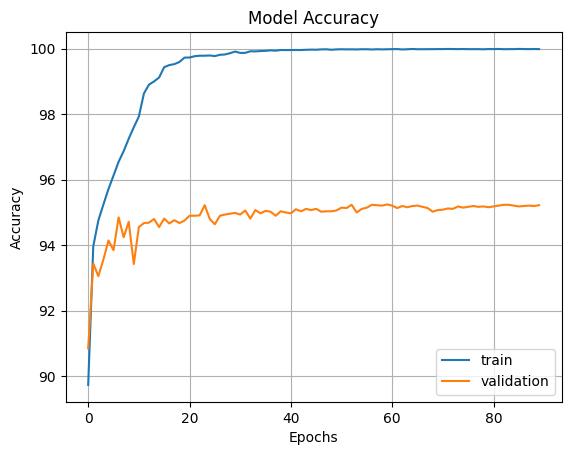

In [14]:
plt.plot(accs_train, label='Train_accuracy')
plt.plot(accs_val, label='Validation_accuracy')
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

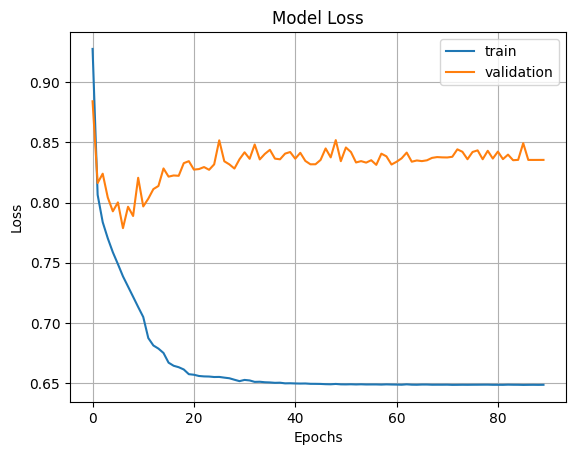

In [15]:
plt.plot(losses_train, label='Train_loss')
plt.plot(losses_val, label='Validation_loss')
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
#Test
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

In [17]:
test = MyTestSet("./pretrained/test_pre.npy")
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [18]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    mod = nn.DataParallel(mod)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

mod.to(device)
mod = mod.to(device)
mod.load_state_dict(torch.load(("./pretrained/checkpoint_model_pre.pth")))
mod.eval()

Loaded pretrained weights for efficientnet-b3


DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [19]:
out = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred= mod(query)
    _, predicted = torch.max(pred.data, 1)
    out.append(predicted)

pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()

In [20]:
real_label = pd.read_csv("./pretrained/testy_pre.csv", index_col=0)
real_label.value_counts()

celltype_l2      
CD14 Mono            2132
CD4 Naive             874
NK                    859
CD4 TCM               745
CD8 TEM               587
CD8 Naive             539
B naive               385
CD16 Mono             315
CD4 TEM               214
gdT                   183
B memory              164
CD8 TCM               144
MAIT                  139
Treg                  125
cDC2                  123
B intermediate        121
Platelet              114
CD4 CTL                87
NK_CD56bright          47
pDC                    43
Doublet                29
NK Proliferating       27
dnT                    17
Plasmablast            16
HSPC                   16
ILC                     7
cDC1                    7
Eryth                   4
CD8 Proliferating       4
ASDC                    4
CD4 Proliferating       3
dtype: int64

In [21]:
file = open("./pretrained/label_encoder_pre.obj",'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)
pred_label.value_counts()

CD14 Mono            2135
CD4 Naive             895
NK                    847
CD4 TCM               737
CD8 TEM               575
CD8 Naive             542
B naive               387
CD16 Mono             325
CD4 TEM               220
gdT                   186
B memory              162
CD8 TCM               144
MAIT                  139
cDC2                  123
B intermediate        121
Treg                  116
Platelet              109
CD4 CTL                88
NK_CD56bright          56
pDC                    43
NK Proliferating       32
dnT                    19
HSPC                   16
Plasmablast            16
Doublet                15
ILC                     7
cDC1                    7
Eryth                   4
ASDC                    4
CD8 Proliferating       2
CD4 Proliferating       2
dtype: int64

In [22]:
ls = list(set(pd.unique(pred_label[0]).tolist()) | set(pd.unique(real_label["celltype_l2"]).tolist()))
acc = accuracy_score(pred_label,real_label)

le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["celltype_l2"])
ari = adjusted_rand_score(real_label_2, pred_label_2)

print("Accuray: %.03f, ARI = %.03f" % (acc, ari))

Accuray: 0.953, ARI = 0.945
